In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress, ttest_ind_from_stats, ttest_1samp

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI

In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24/"
nbqx_export_summary = data_dir + "export_summary_backup.csv"

output_fig_dir = 'P:/John/crossing-paper/input/'
camera_program = 4
um_per_px = 6.0 #um

In [3]:
# load CSV of all L4 and L2/3 crossing with NBQX blockade (array only CSV)
crossing_data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
crossing_data = pd.read_csv(crossing_data_dir + 'export_summary_crossing_PPR_array_only.csv')

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

crossing_data

Layer  drug        Date  Slice  Location  Recording  \
0     L4  ACSF   12/9/2024      2         1          1   
1     L4  NBQX   12/9/2024      2         3          3   
2     L4  ACSF  10/29/2024      1         1          3   
3     L4  NBQX  10/29/2024      1         2          1   
4   L2/3  ACSF  10/23/2024      1         2          3   
5   L2/3  NBQX  10/23/2024      1         2          4   
6   L2/3  ACSF   6/26/2024      1         1          1   
7   L2/3  NBQX   6/26/2024      1         1          4   
8   L2/3  ACSF    7/1/2024      3         2          1   
9   L2/3  NBQX    7/1/2024      3         2          5   
10  L2/3  ACSF    7/1/2024      4         1          1   
11  L2/3  NBQX    7/1/2024      4         1          4   
12  L2/3  ACSF   7/15/2024      2         1          1   
13  L2/3  NBQX   7/15/2024      2         1          5   
14    L4  ACSF   7/17/2024      3         1          1   
15    L4  NBQX   7/17/2024      3         1          5   
16    L4  ACSF  12/11/2024      2         1          1   
17    L4  NBQX  12/11/2024      2         3          2   
18    L4  ACSF  12/11/2024      3         2          1   
19    L4  NBQX  12/11/2024      3         4          2   
20    L4  ACSF  12/18/2024      2         1          2   
21    L4  NBQX  12/18/2024      2         3          1   
22  L2/3  ACSF  12/20/2024      1         3          1   
23  L2/3  NBQX  12/20/2024      1         3          2   

                                            amp_array  \
0   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
1   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
5   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
6   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
7   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
8   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
9   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
10  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
11  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
12  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
13  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
14  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
15  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
16  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
17  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
18  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
19  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
20  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
21  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
22  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
23  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   

                                             ROI file  \
0   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
1   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
5   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
6   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
7   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
8   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
9   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
10  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
11  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
12  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
13  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
14  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
15  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
16  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
17  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
18  C:/Users/jjudge3/Desktop/Data/crossing_

In [4]:
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

nbqx_export_sagittal = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/' + "export_summary_backup.csv"
hw_lat_sagittal_df = pd.read_csv(nbqx_export_sagittal)
hw_lat_sagittal_df

ROI        amp        snr  latency  halfwidth  Stim_Distance   X_Center  \
0     1   2.101260   66.64650  51.0524    5.84029      63.780875  33.171206   
1     2   1.138650   30.75740  51.7941    8.86817     182.778555  57.975089   
2     1   1.863310   47.13760  51.6354    7.20305      63.780875  33.171206   
3     2   0.446560    9.51275  52.0617   18.19140     182.778555  57.975089   
4     1  22.877600   55.88170  52.6757   12.79720      24.000000  60.593750   
5     2   4.549810   13.30700  54.6543   20.84750     115.256236  34.826211   
6     1  17.931500   49.08750  52.5286    9.55607      24.000000  60.593750   
7     2   1.360260    5.49498  54.6159    6.92785     115.256236  34.826211   
8     1  48.319700   53.74320  49.8735    8.69107      43.266615  55.612069   
9     2   7.034680   37.30910  53.1874   21.11320     201.603571  36.433333   
10    1   5.769570   24.55730  51.6274    7.05051      43.266615  55.612069   
11    2   1.050210    3.35967  47.6332   18.86500     201.603571  36.433333   
12    1   7.356100   81.10530  51.3404    5.66305      49.477268  54.478964   
13    2   4.406020   73.80480  51.6541   10.19470     148.189068  28.932773   
14    1   3.558260   48.59160  50.5976    8.41476     139.556440  66.753012   
15    2   2.231760   32.85240  51.3152   14.36230     218.073382  48.975758   
16    1   2.730740   15.19890  52.8901    6.43186      49.477268  54.478964   
17    2   1.033000    6.89101  54.5502    7.43321     148.189068  28.932773   
18    1  10.031400   79.39310  52.5279    6.43667     139.556440  66.753012   
19    2   2.278970   11.12270  53.5835    7.81864     218.073382  48.975758   
20    1   4.362700   21.97140  55.3154   16.25260     167.140659  65.006623   
21    2   2.715180   15.45560  55.4260   20.39530     178.392825  53.296919   
22    1   4.620350   14.02540  50.2347   17.56290      99.859902  40.331707   
23    2   1.470900    6.07907  53.6418   17.28000      80.721744  25.364532   
24    1   2.159170    9.02291  53.3181   13.77760     167.140659  65.006623   
25    2   1.493440    7.66513  55.6665    9.88714     178.392825  53.296919   
26    1   4.762550   13.63030  50.1274    6.42867      99.859902  40.331707   
27    2   1.172120    3.69340  51.7582   26.54270      80.721744  25.364532   
28    1   7.275070   65.46070  50.3961   13.05470      42.000000  47.456522   
29    2   0.843794   13.16240  52.1982   22.64070     162.443836  51.026846   
30    1   1.514180   15.46410  51.0773   16.30770     178.997207  16.607759   
31    2   0.934745    6.88446  51.0552   12.76960     242.759140  18.206250   
32    1   5.517440   14.00720  50.3087   12.59670      42.000000  47.456522   
33    2   0.636414    2.35868  48.7967        NaN     162.443836  51.026846   
34    1   1.895850    3.06785  48.9784   14.43540     178.997207  16.607759   
35    2   1.660900    2.99022  48.1556   12.00540     242.759140  18.206250   
36    1   5.510860   94.72160  51.7180    9.04587      72.993150  33.970297   
37    2   0.813395   23.81590  51.5998   36.85050     180.000000  54.714286   
38    1  12.012700  104.08700  51.6368    7.36268      72.993150  33.970297   
39    2   1.760250    8.24925  52.0891    8.36272     180.000000  54.714286   
40    1  23.183700   82.01480  52.2659   21.09000      42.426407  58.769737   
41    2   7.614200   15.49940  52.6995        NaN     113.841996  46.979900   
42    1  11.954700   22.43890  51.6497   15.57760      42.426407  58.769737   
43    2   7.156080   11.15190  52.2233   12.79370     113.841996  46.979900   

     Y_Center               ROI_Set       Date  Slice  Location  Recording  \
0   27.688716                1_rois  1/15/2025      1         2          1   
1   52.832740                1_rois  1/15/2025      1         2          1   
2   27.688716                1_rois  1/15/2025      1         4          1   
3   52.832740                1_rois  1/15/2025      1         4          1   
4   37.625000                2_rois  1/15/2025      2     

In [ ]:

hw_lat_df['Section'] = 'Coronal'
hw_lat_sagittal_df['Section'] = 'Sagittal'

# merge the two hw_lat dataframes
hw_lat_df = pd.concat([hw_lat_df, hw_lat_sagittal_df], ignore_index=True)
hw_lat_df

Layer  drug  ROI        amp       snr  latency  halfwidth   X_Center  \
0      L4  ACSF    1   1.208980  44.28930   1.1323    8.08166  50.551020   
1      L4  ACSF    2   0.330953   6.90515   3.4924   26.12920  66.867374   
2      L4  NBQX    1   1.774300  75.77820   1.2188    4.78006  50.551020   
3      L4  NBQX    2   0.325975   7.08423   2.3590    5.69864  66.867374   
4      L4  ACSF    1   1.488840  68.13480   1.6920    6.25805  55.466877   
..    ...   ...  ...        ...       ...      ...        ...        ...   
99     L4  NBQX    2   1.760250   8.24925  52.0891    8.36272  54.714286   
100    L4  ACSF    1  23.183700  82.01480  52.2659   21.09000  58.769737   
101    L4  ACSF    2   7.614200  15.49940  52.6995        NaN  46.979900   
102    L4  NBQX    1  11.954700  22.43890  51.6497   15.57760  58.769737   
103    L4  NBQX    2   7.156080  11.15190  52.2233   12.79370  46.979900   

      Y_Center ROI_Set  ... Slice  Location  Recording  Medial/Lateral  \
0    51.918367  1_rois  ...     1         1          1             NaN   
1    28.713528  1_rois  ...     1         1          1         Lateral   
2    51.918367  1_rois  ...     1         1          2             NaN   
3    28.713528  1_rois  ...     1         1          2         Lateral   
4    41.141956  1_rois  ...     1         1          1             NaN   
..         ...     ...  ...   ...       ...        ...             ...   
99   45.108466  1_rois  ...     1         4          1             NaN   
100  10.532895  2_rois  ...     2         2         12             NaN   
101  37.638191  2_rois  ...     2         2         12             NaN   
102  10.532895  2_rois  ...     2         3          1             NaN   
103  37.638191  2_rois  ...     2         3          1             NaN   

                                                 trace   Section  \
0    C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   Coronal   
1    C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   Coronal   
2    C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   Coronal   
3    C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   Coronal   
4    C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   Coronal   
..                                                 ...       ...   
99   C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...  Sagittal   
100  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...  Sagittal   
101  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...  Sagittal   
102  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...  Sagittal   
103  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...  Sagittal   

    Stim_Distance                                          amp_array  \
0             NaN                                                NaN   
1             NaN                                                NaN   
2             NaN                                                NaN   
3             NaN                                                NaN   
4             NaN                                                NaN   
..            ...                                                ...   
99     180.000000  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...   
100     42.426407  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...   
101    113.841996  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...   
102     42.426407  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...   
103    113.841996  C:/Users/jjudge3/Desktop/Data/crossing_PPR/sag...   

                                             snr_array Rostral/Caudal  
0                                                  NaN            NaN  
1                                                  NaN            NaN  
2                                                  NaN            NaN  
3                                                  NaN            NaN  
4                                                  NaN            NaN  
..                                                 ...            ...  
99   C:/Users/jj

In [ ]:
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df


Layer  drug  ROI        amp       snr  latency  halfwidth   X_Center  \
0     L4  ACSF    1   1.208980  44.28930   1.1323    8.08166  50.551020   
1     L4  ACSF    2   0.330953   6.90515   3.4924   26.12920  66.867374   
2     L4  NBQX    1   1.774300  75.77820   1.2188    4.78006  50.551020   
3     L4  NBQX    2   0.325975   7.08423   2.3590    5.69864  66.867374   
4     L4  ACSF    1   1.488840  68.13480   1.6920    6.25805  55.466877   
5     L4  ACSF    2   0.983708  39.26490   4.9494   12.78330  29.060606   
6     L4  NBQX    1   0.000000   0.00000      NaN    6.25805  55.466877   
7     L4  NBQX    2   0.053680   1.00786   5.2739    2.54030  29.060606   
8     L4  ACSF    1  14.255900  56.77760   1.5938    8.15259  40.464912   
9     L4  ACSF    2   3.041910  23.21550   2.3892   15.21730  51.851974   
10    L4  NBQX    1  11.732800  54.59800   2.8157    8.20410  40.464912   
11    L4  NBQX    2   0.701709   3.20418   3.4493   12.61820  51.851974   
12    L4  ACSF    1   2.573440  97.43780   1.3351    6.30031  50.146259   
13    L4  ACSF    2   0.571037  24.28420   2.9283   14.31090  16.678689   
14    L4  NBQX    1   5.443460  77.75390   1.2248    5.51101  50.146259   
15    L4  NBQX    2   0.861818  25.36420   2.4844    6.10551  16.678689   
16    L4  ACSF    1  19.962100  63.10510   2.3035    8.88925  35.790254   
17    L4  ACSF    2   4.861120  53.08610   3.3611   14.41060  59.607509   
18    L4  NBQX    1  18.841000  96.41500   2.4930    7.88870  35.790254   
19    L4  NBQX    2   2.310180  17.46460   2.7515    8.32071  59.607509   
20    L4  ACSF    1  11.198100  87.57760   2.7940        NaN  51.000000   
21    L4  ACSF    2  12.553400  70.35970   2.0402    7.41857  52.287425   
22    L4  NBQX    1  21.239600  65.33420   2.2896    5.21123  51.000000   
23    L4  NBQX    2   3.796700  13.19490   3.1772    7.53653  52.287425   
24  L2/3  ACSF    1   0.546602  28.83120   3.4849   14.78900  46.531977   
25  L2/3  ACSF    2   0.332892  14.80070   3.8840   10.12840  34.393939   
26  L2/3  NBQX    1   0.676087  29.28670   3.5807    4.39530  46.531977   
27  L2/3  NBQX    2   0.508976  29.92430   4.0253    5.33224  34.393939   
28  L2/3  ACSF    1   1.073720  53.76460   3.1838    5.87219        NaN   
29  L2/3  ACSF    2   0.466662  21.17600   3.8387   16.13250        NaN   
30  L2/3  NBQX    2   1.085010  36.89220   4.1900    5.42142        NaN   
31  L2/3  NBQX    1   3.538080  64.96840   3.5978    4.69792        NaN   
32  L2/3  ACSF    1   6.150710  67.93360   2.7378    6.30723        NaN   
33  L2/3  ACSF    2   5.971970  60.32280   3.6349    7.91301        NaN   
34  L2/3  NBQX    1   8.453990  53.83170   2.5830    4.99195        NaN   
35  L2/3  NBQX    2   8.319750  76.03030   3.5719    4.91658        NaN   
36  L2/3  ACSF    1  12.771800  87.66710   2.7700    5.98509        NaN   
37  L2/3  ACSF    2   5.016220  31.97000   3.7273   13.69360        NaN   
38  L2/3  NBQX    1  15.506900  84.73370   2.8276    5.29504        NaN   
39  L2/3  NBQX    2   4.799370  22.44080   3.8786    9.76893        NaN   
40  L2/3  ACSF    1   3.171290  39.36250   1.3686    9.03713        NaN   
41  L2/3  ACSF    2   3.885410  50.35280   2.7901   11.62340        NaN   
42  L2/3  NBQX    1   9.305170  84.64130   1.1554    5.67852        NaN   
43  L2/3  NBQX    2   9.700130  80.91630   2.5481    5.03678        NaN   
44    L4  ACSF    1   7.436220  40.48660   2.9353   10.16720        NaN   
45    L4  ACSF    2   8.699790  42.83210   3.0089    6.29783        NaN   
46    L4  NBQX    1   8.619740  27.99020   3.2368    7.90942        NaN   
47    L4  NBQX    2   2.355590   5.54932   5.6297    8.40421        NaN   
48    L4  ACSF    1   2.658410  40.94130   2.4280   12.50470  53.414035   
49    L4  ACSF    2   1.531480  56.84930   3.8833   14.67710  45.696319   
50    L4  NBQX    1   2.797270  27.63270   2.9883    6.19402  53.414035   
51    L4  NBQX    2   0.695155   5.94485   3.5891    6.02117  45.696319   
52  L2/3  ACSF    1   1.6681

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


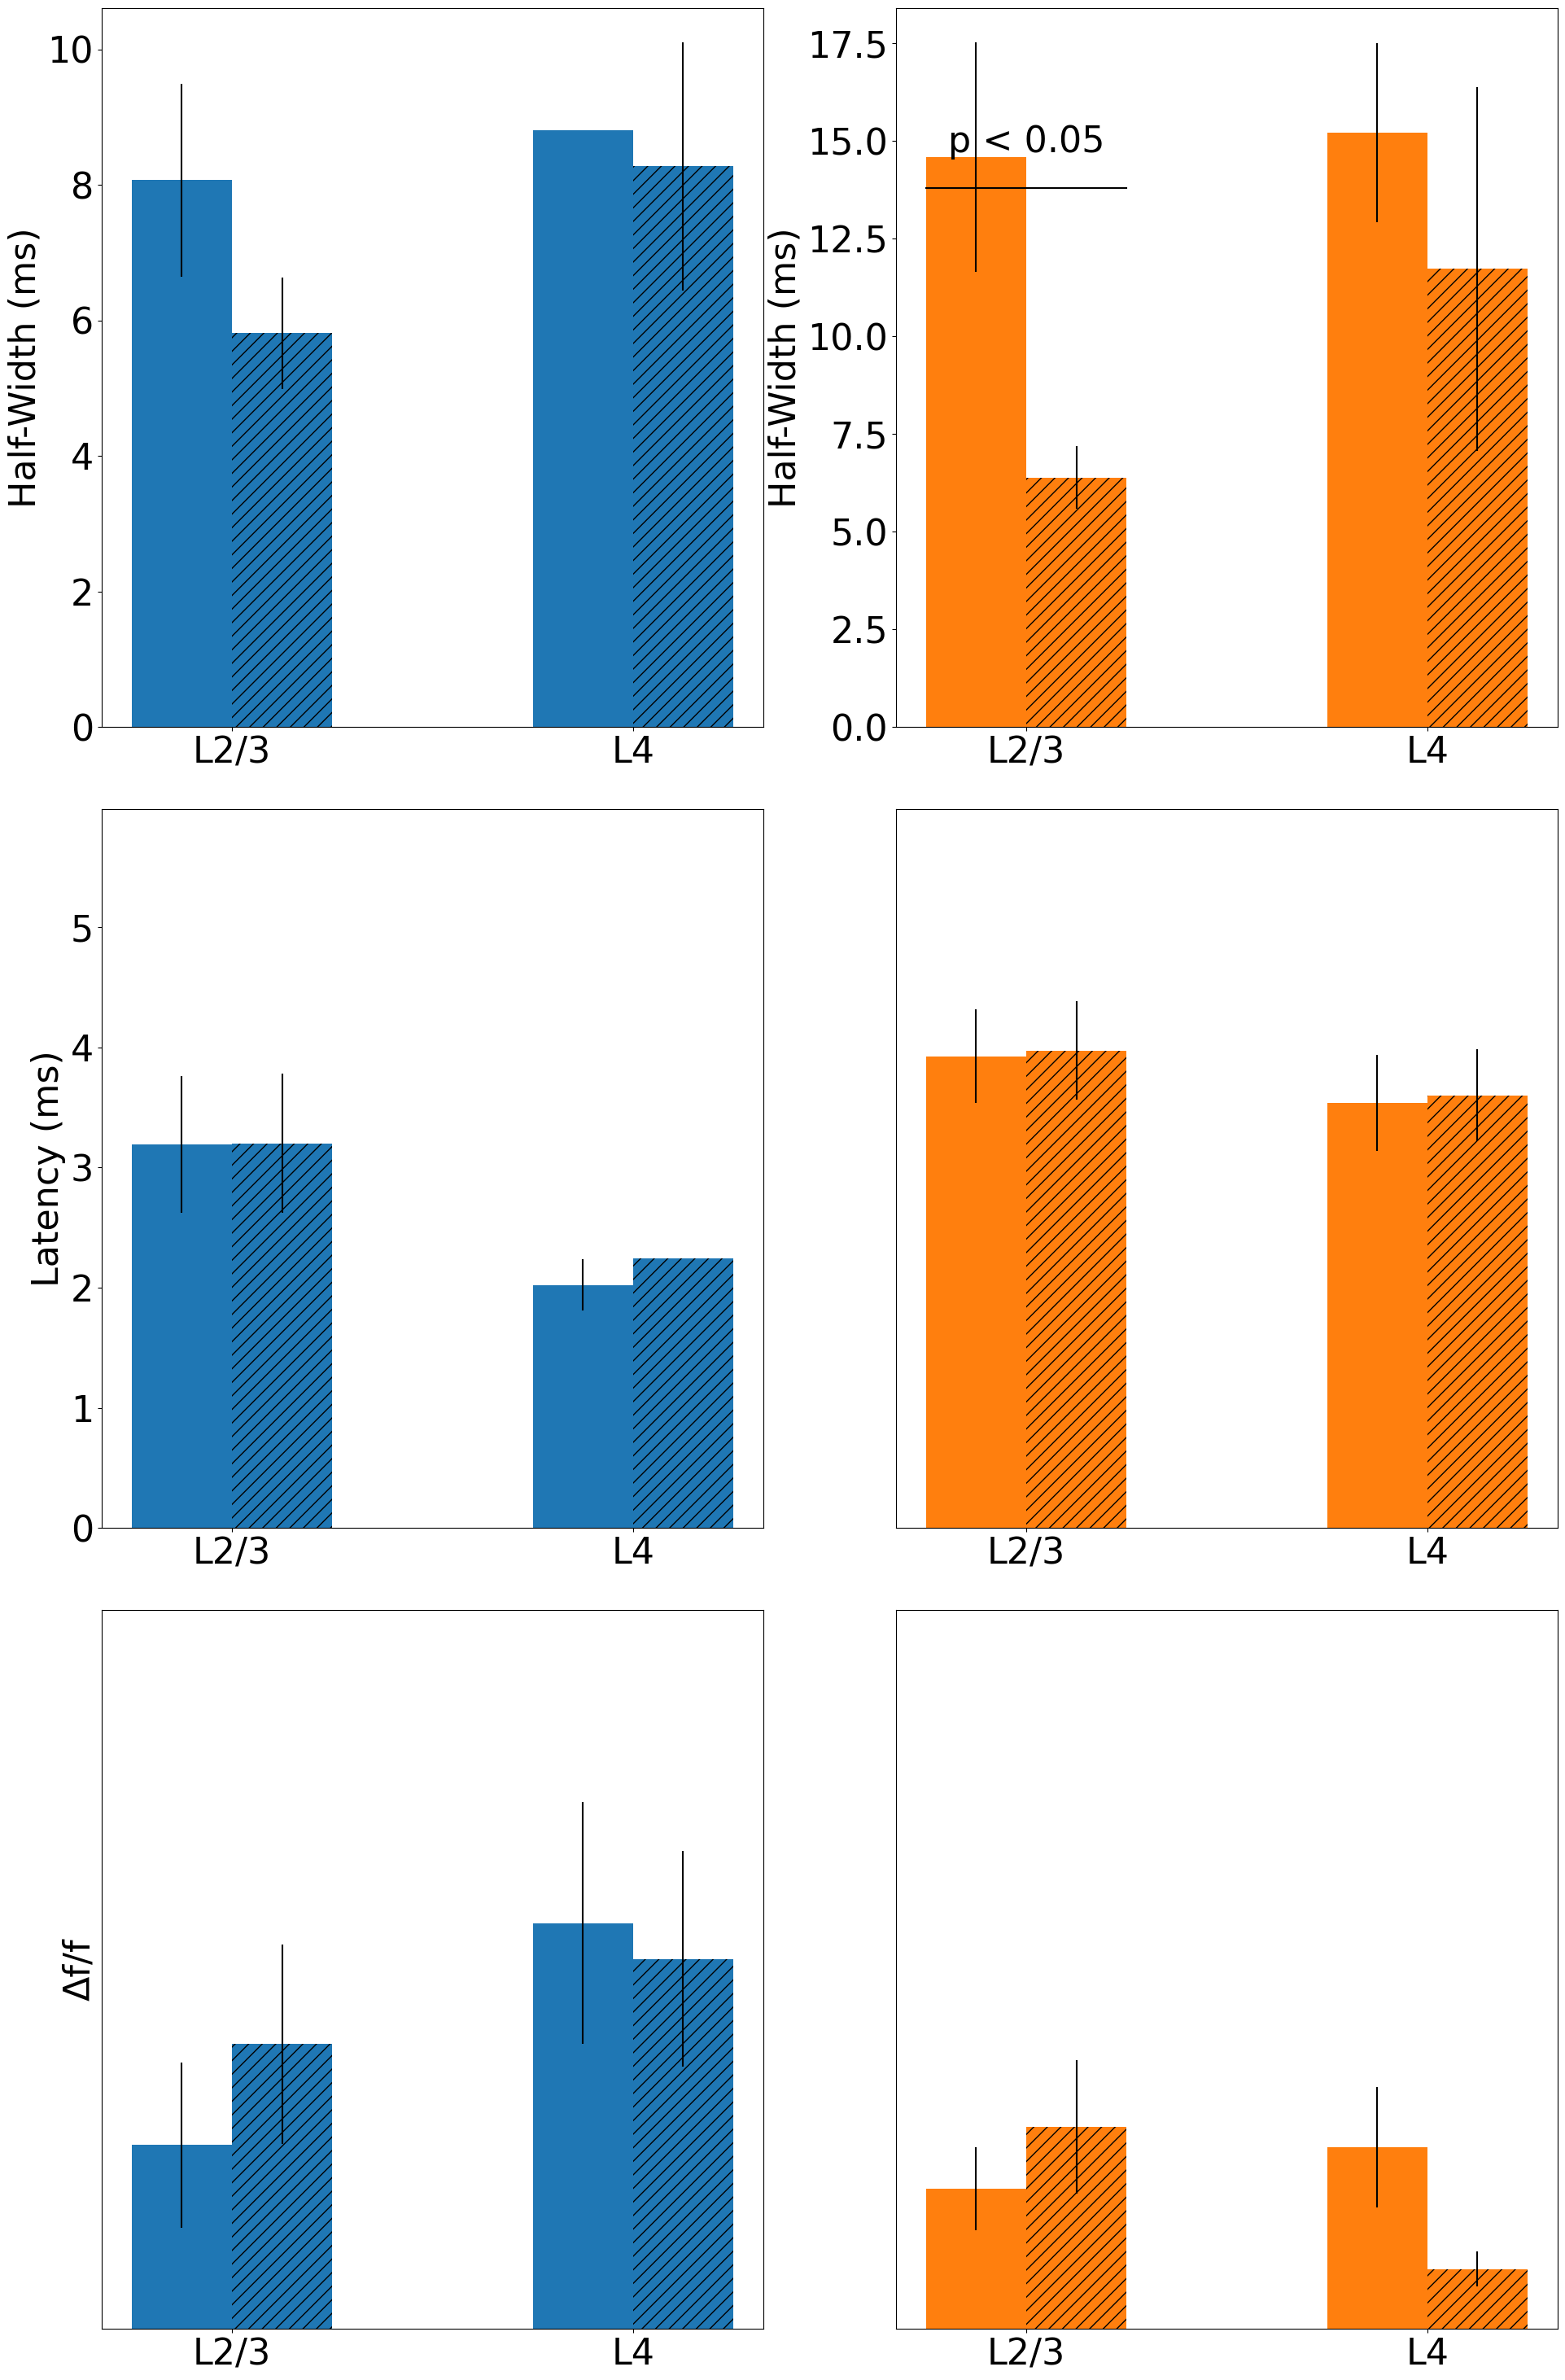

In [7]:
# plot the data, comparing L2/3 to L4 and ACSF to NBQX and home (ROI == 1) to neighbor (ROI > 1)

# font size
plt.rcParams.update({'font.size': 32})

fig, ax = plt.subplots(3, 2, figsize=(20, 30))
layers = ['L2/3', 'L4']
drug = ['ACSF', 'NBQX']

handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        
        hatch = '//' if d == 'NBQX' else None
        for roi in [1, 2]:
            col = 'tab:blue' if roi == 1 else 'tab:orange'
            roi_df = hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == d) & (hw_lat_df['ROI'] == roi)]
            l = ax[0][roi-1].bar([i + j/4-.125], np.mean(roi_df['halfwidth']), yerr=sem(roi_df['halfwidth']), label=drug, width=.25, color=col, hatch=hatch)
            ax[1][roi-1].bar([i + j/4-.125], np.mean(roi_df['latency']), yerr=sem(roi_df['latency']), label=drug, width=.25, color=col, hatch=hatch)
            ax[2][roi-1].bar([i + j/4-.125], np.mean(roi_df['amp']), yerr=sem(roi_df['amp']), label=drug, width=.25, color=col, hatch=hatch)
            handles.append(l)
        
ax[0][0].set_ylabel('Half-Width (ms)')
ax[1][0].set_ylabel('Latency (ms)')
ax[2][0].set_ylabel('Δf/f')

for i in range(2):
    for j in range(3):
        ax[j][i].set_xticks([0, 1])
        ax[j][i].set_xticklabels(layers)

# autoscale y-axis for each pair of subplots togethere
for i in range(1,3):
    y_max = max(ax[i][0].get_ylim()[1], ax[i][1].get_ylim()[1]) * 1.3
    ax[i][0].set_ylim(0, y_max)
    ax[i][1].set_ylim(0, y_max)
    ax[i][1].set_yticks([])
ax[2][0].set_yticks([])

# significance testing
for i, layer in enumerate(layers):
    for roi in [1, 2]:
        for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
            t_stat, p_val = ttest_ind(hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'ACSF') & (hw_lat_df['ROI'] == roi)][metric],
                                      hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'NBQX') & (hw_lat_df['ROI'] == roi)][metric])
            if p_val < 0.05:
                ax[j][roi-1].text((i), ax[j][roi-1].get_ylim()[1] * 0.8, 'p < 0.05', ha='center')

                # draw bar between ACSF and NBQX
                ax[j][roi-1].plot([i -.25, i + .25], [ax[j][roi-1].get_ylim()[1] * 0.75, ax[j][roi-1].get_ylim()[1] * 0.75], color='black')
            #else:
            #    ax[j][roi-1].text((i + .125), ax[j][roi-1].get_ylim()[1] * 0.8, str(p_val)[:5], ha='center')

handles = [handles[1], handles[3]]
#ax[0][1].legend(handles=handles, labels=['ACSF', '+NBQX'], loc='upper left')
ax[0][1].set_ylabel('Half-Width (ms)')
#ax[0][0].set_title('Home Barrel')
#ax[0][1].set_title('Neighbor Barrel')
plt.tight_layout()
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp.png')
plt.show()


In [8]:
# load pulse 2 ladder data

# load C:\Users\jjudge3\Desktop\Data\crossing_PPR\PPR_ladder_pulse_2\export_summary_pulse_2.csv
ppr_ladder_pulse_2_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_ladder_pulse_2/export_summary_pulse_2.csv'
ppr_ladder_pulse_2_df = pd.read_csv(ppr_ladder_pulse_2_csv)
# add Drug and Layer columns to the dataframe
ppr_ladder_pulse_2_df['drug'] = 'ACSF'
ppr_ladder_pulse_2_df['Layer'] = 'L4'

# format date to m/d/yyyy in ppr_ladder_pulse_2_df
try:
    ppr_ladder_pulse_2_df['Date'] = pd.to_datetime(ppr_ladder_pulse_2_df['Date'], format='%m-%d-%Y').dt.strftime('%#m/%#d/%Y')
except ValueError:  # formatted already
    pass

# add new columns Coronal/Sagittal and IPI to the dataframe
ppr_ladder_pulse_2_df['Coronal/Sagittal'] = np.nan
ppr_ladder_pulse_2_df['IPI'] = np.nan
ppr_ladder_pulse_2_df['Is_Pulse_2'] = True

# load C:\Users\jjudge3\Desktop\Data\crossing_PPR\PPR_ladder_pulse_2\ppr_catalog_backup.csv
ppr_ladder_pulse_2_catalog_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_ladder_pulse_2/ppr_catalog_backup.csv'
ppr_ladder_pulse_2_catalog_df = pd.read_csv(ppr_ladder_pulse_2_catalog_csv)

# use catalog to fill Coronal/Sagittal and IPI columns in ppr_ladder_pulse_2_df
for row in ppr_ladder_pulse_2_catalog_df.iterrows():
    zda_file = row[1]['zda_file'] # format is C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_ladder_pulse_2/PPR_coronal_annotated\01-02-25\converted_zda/01_03_01.zda
    # get the date from the file name
    date = os.path.basename(os.path.dirname(os.path.dirname(zda_file))) # format is 01-02-25
    # format the date to m/d/yyyy
    date = pd.to_datetime(date, format='%m-%d-%y').strftime('%#m/%#d/%Y')
    # get the slice from the file name
    slic_loc_rec = zda_file.split("/")[-1].replace(".zda", "") 
    slic = int(slic_loc_rec.split("_")[0]) 
    loc = int(slic_loc_rec.split("_")[1])
    rec = int(slic_loc_rec.split("_")[2])

    #print(f"Checking {date} {slic} {loc} {rec} in ppr_ladder_pulse_2_df")
    #print(row[1]['Coronal/Sagittal'], row[1]['IPI'])
    #print(ppr_ladder_pulse_2_df['Date'].unique())

    # store Coronal/Sagittal
    ppr_ladder_pulse_2_df.loc[(ppr_ladder_pulse_2_df['Date'] == date) & (ppr_ladder_pulse_2_df['Slice'] == slic) &
                                        (ppr_ladder_pulse_2_df['Location'] == loc) & (ppr_ladder_pulse_2_df['Recording'] == rec), 'Coronal/Sagittal'] = row[1]['Coronal/Sagittal']

    # store IPI
    ppr_ladder_pulse_2_df.loc[(ppr_ladder_pulse_2_df['Date'] == date) & (ppr_ladder_pulse_2_df['Slice'] == slic) &
                                        (ppr_ladder_pulse_2_df['Location'] == loc) & (ppr_ladder_pulse_2_df['Recording'] == rec), 'IPI'] = row[1]['IPI']
              
ppr_ladder_pulse_2_df

ROI       amp  latency  halfwidth  Stim_Distance   X_Center   Y_Center  \
0       1  0.447418  184.746    6.98220     284.541737  63.000000  54.790698   
1       2  0.413064  184.684    9.99002     268.663358  60.743902  52.841463   
2       3  0.393519  184.871   10.25910     266.308092  58.702381  50.702381   
3       4  0.424824  184.181   17.29830     250.710989  56.588235  48.600000   
4       5  0.511221  183.866    7.74091     235.304059  54.157303  46.741573   
...   ...       ...      ...        ...            ...        ...        ...   
7739   21  0.392233  178.747    5.93887     309.974193  35.278481   8.721519   
7740   22  0.710792  177.487    3.35339     339.835254  33.571429   6.311688   
7741   23  1.011800  178.461   28.19760     344.308002  29.714286   5.190476   
7742   24  1.046040  178.175    2.39320     365.754016  26.437500   3.708333   
7743   25  1.692640  179.360   26.93150     391.795865  23.064516   2.322581   

                            ROI_Set       Date  Slice  Location  Recording  \
0     1_rois_output__ladder_ pulse1   2/5/2025      1         3         16   
1     1_rois_output__ladder_ pulse1   2/5/2025      1         3         16   
2     1_rois_output__ladder_ pulse1   2/5/2025      1         3         16   
3     1_rois_output__ladder_ pulse1   2/5/2025      1         3         16   
4     1_rois_output__ladder_ pulse1   2/5/2025      1         3         16   
...                             ...        ...    ...       ...        ...   
7739  3_rois_output__ladder_ pulse1  1/15/2025      3         2         25   
7740  3_rois_output__ladder_ pulse1  1/15/2025      3         2         25   
7741  3_rois_output__ladder_ pulse1  1/15/2025      3         2         25   
7742  3_rois_output__ladder_ pulse1  1/15/2025      3         2         25   
7743  3_rois_output__ladder_ pulse1  1/15/2025      3         2         25   

      drug Layer Coronal/Sagittal    IPI  Is_Pulse_2  
0     ACSF    L4         Sagittal   80.0        True  
1     ACSF    L4         Sagittal   80.0        True  
2     ACSF    L4         Sagittal   80.0        True  
3     ACSF    L4         Sagittal   80.0        True  
4     ACSF    L4         Sagittal   80.0        True  
...    ...   ...              ...    ...         ...  
7739  ACSF    L4         Sagittal  120.0        True  
7740  ACSF    L4         Sagittal  120.0        True  
7741  ACSF    L4         Sagittal  120.0        True  
7742  ACSF    L4         Sagittal  120.0        True  
7743  ACSF    L4         Sagittal  120.0        True  

[7744 rows x 17 columns]

In [9]:
# velocity analysis 
# read in velocity ladders
ladder_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_ladders.csv'
ladder_df = pd.read_csv(ladder_csv)
ladder_df['latency'] -= 48.6

# fold in some more ladder data from PPR_ladder directory 
ladder_csv_2 = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_ladder/export_summary_ladder_backup.csv'
ladder_df_2 = pd.read_csv(ladder_csv_2)
ladder_df_2['latency'] -= 48.6  # some of the data is stimulated at a different time point, but deltas are the same

# format m-d-yy to m/d/yyyy in ladder_df_2
#ladder_df_2['Date'] = pd.to_datetime(ladder_df_2['Date'], format='%m-%d-%Y').dt.strftime('%#m/%#d/%Y')

# before merging, remove any rows that are in both dataframes from the second dataframe (match on date/slice alone)
for row in ladder_df_2.iterrows():
    date = row[1]['Date']
    slic = row[1]['Slice']
    #print(f"Checking {date} {slic} in ladder_df_2")
    if len(ladder_df[(ladder_df['Date'] == date) & (ladder_df['Slice'] == slic)]) > 0:
        ladder_df_2.drop(row[0], inplace=True)
        print(f"Removing {date} {slic} from ladder_df_2")

# merge the dataframes
ladder_df = pd.concat([ladder_df, ladder_df_2], ignore_index=True) # , ppr_ladder_pulse_2_df

# add a new column Dist_from_home_barrel
ladder_df['Dist_from_home_barrel'] = np.nan

# add a new column resides_in_barrel
ladder_df['resides_in_barrel'] = np.nan

# and for velocity
ladder_df['instantaneous_velocity'] = np.nan

ladder_df

Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 2 from ladder_df_2
Removing 12/11/2024 3 from ladder_df_2
Removing 12/11/2024 3 fro

ROI        amp      snr  latency  halfwidth  Stim_Distance   X_Center  \
0       1   0.408552  19.7128   3.9030    16.6507     272.917570  34.263889   
1       2   0.462050  27.5393   3.9159    14.4435     256.320112  36.851351   
2       3   0.441868  28.2700   3.8743    13.6368     239.774894  38.767123   
3       4   0.466602  22.1134   3.8636    13.2221     223.293529  40.816901   
4       5   0.526346  26.8669   3.7651    10.1029     206.891276  43.818182   
...   ...        ...      ...      ...        ...            ...        ...   
1424   22  10.513800      NaN  32.4017    10.5138      87.361319  68.000000   
1425   23  10.499200      NaN  32.5608    10.4992      93.914855  71.000000   
1426   24  11.141100      NaN  32.6341    11.1411     103.227903  74.000000   
1427   25  10.717900      NaN  32.7312    10.7179     114.629839  77.000000   
1428   26  11.365600      NaN  32.8025    11.3656     127.561750  79.000000   

       Y_Center                        ROI_Set       Date  Slice  Location  \
0     10.236111          1_roi_output__ladder_  6/26/2024      1         1   
1     12.054054          1_roi_output__ladder_  6/26/2024      1         1   
2     14.273973          1_roi_output__ladder_  6/26/2024      1         1   
3     16.338028          1_roi_output__ladder_  6/26/2024      1         1   
4     17.766234          1_roi_output__ladder_  6/26/2024      1         1   
...         ...                            ...        ...    ...       ...   
1424  42.000000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1425  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1426  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1427  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1428  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   

      Recording                                              trace  \
0             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
1             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
2             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
3             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
4             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
...         ...                                                ...   
1424          1                                                NaN   
1425          1                                                NaN   
1426          1                                                NaN   
1427          1                                                NaN   
1428          1                                                NaN   

      Dist_from_home_barrel  resides_in_barrel  instantaneous_velocity  
0                       NaN                NaN                     NaN  
1                       NaN                NaN                     NaN  
2                       NaN                NaN                     NaN  
3                       NaN                NaN                     NaN  
4                       NaN                NaN                     NaN  
...                     ...                ...                     ...  
1424                    NaN                NaN                     NaN  
1425                    NaN                NaN                     NaN  
1426                    NaN                NaN                     NaN  
1427                    NaN                NaN                     NaN  
1428                    NaN                NaN                     NaN  

[1429 rows x 17 columns]

In [10]:
# also load export_summary_backup_coronal.csv and export_summary_backup_sagittal.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\PPR\
coronal_ppr_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/export_summary_backup_coronal.csv'
coronal_ppr_df_ = pd.read_csv(coronal_ppr_csv)

sagittal_ppr_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/export_summary_backup_sagittal.csv'
sagittal_ppr_df_ = pd.read_csv(sagittal_ppr_csv)

# merge the two dataframes
ppr_df_for_roi_lookup = pd.concat([coronal_ppr_df_, sagittal_ppr_df_], ignore_index=True)
# split column 'ROI_Set'
ppr_df_for_roi_lookup['ROI file'] =  ppr_df_for_roi_lookup['ROI_Set'].str.split(' ', expand=True)[0]

# file ROI_File should be located in the same directory as the file named in 'trace'
for row in ppr_df_for_roi_lookup.iterrows():
    # get the trace file name
    trace_file = row[1]['trace']
    # get the directory of the trace file
    trace_dir = os.path.dirname(trace_file)
    # get the ROI file name
    roi_file = row[1]['ROI file'] + '.dat'
    # set the ROI file to be in the same directory as the trace file
    ppr_df_for_roi_lookup.at[row[0], 'ROI file'] = os.path.join(trace_dir, roi_file)

# add Drug and Layer columns to the dataframe
ppr_df_for_roi_lookup['drug'] = 'ACSF'
ppr_df_for_roi_lookup['Layer'] = 'L4'

In [11]:
# re-run from here down to fill in the missing velocity data

    drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
0   ACSF             368.804275          Neighbor                     NaN
1   ACSF             350.406813          Neighbor              422.912185
2   ACSF             332.813666              None             1626.003658
3   ACSF             315.415427          Neighbor              183.157884
4   ACSF             297.374375          Neighbor              139.073187
5   ACSF             279.851153          Neighbor              117.169503
6   ACSF             262.228860              None              102.428724
7   ACSF             244.477962              None              184.949586
8   ACSF             227.111196              Home              363.951400
9   ACSF             209.423158              Home              128.503918
10  ACSF             191.869523              Home              880.865557
11  ACSF             174.604558              None               90.659734
12  ACSF             157.098163       

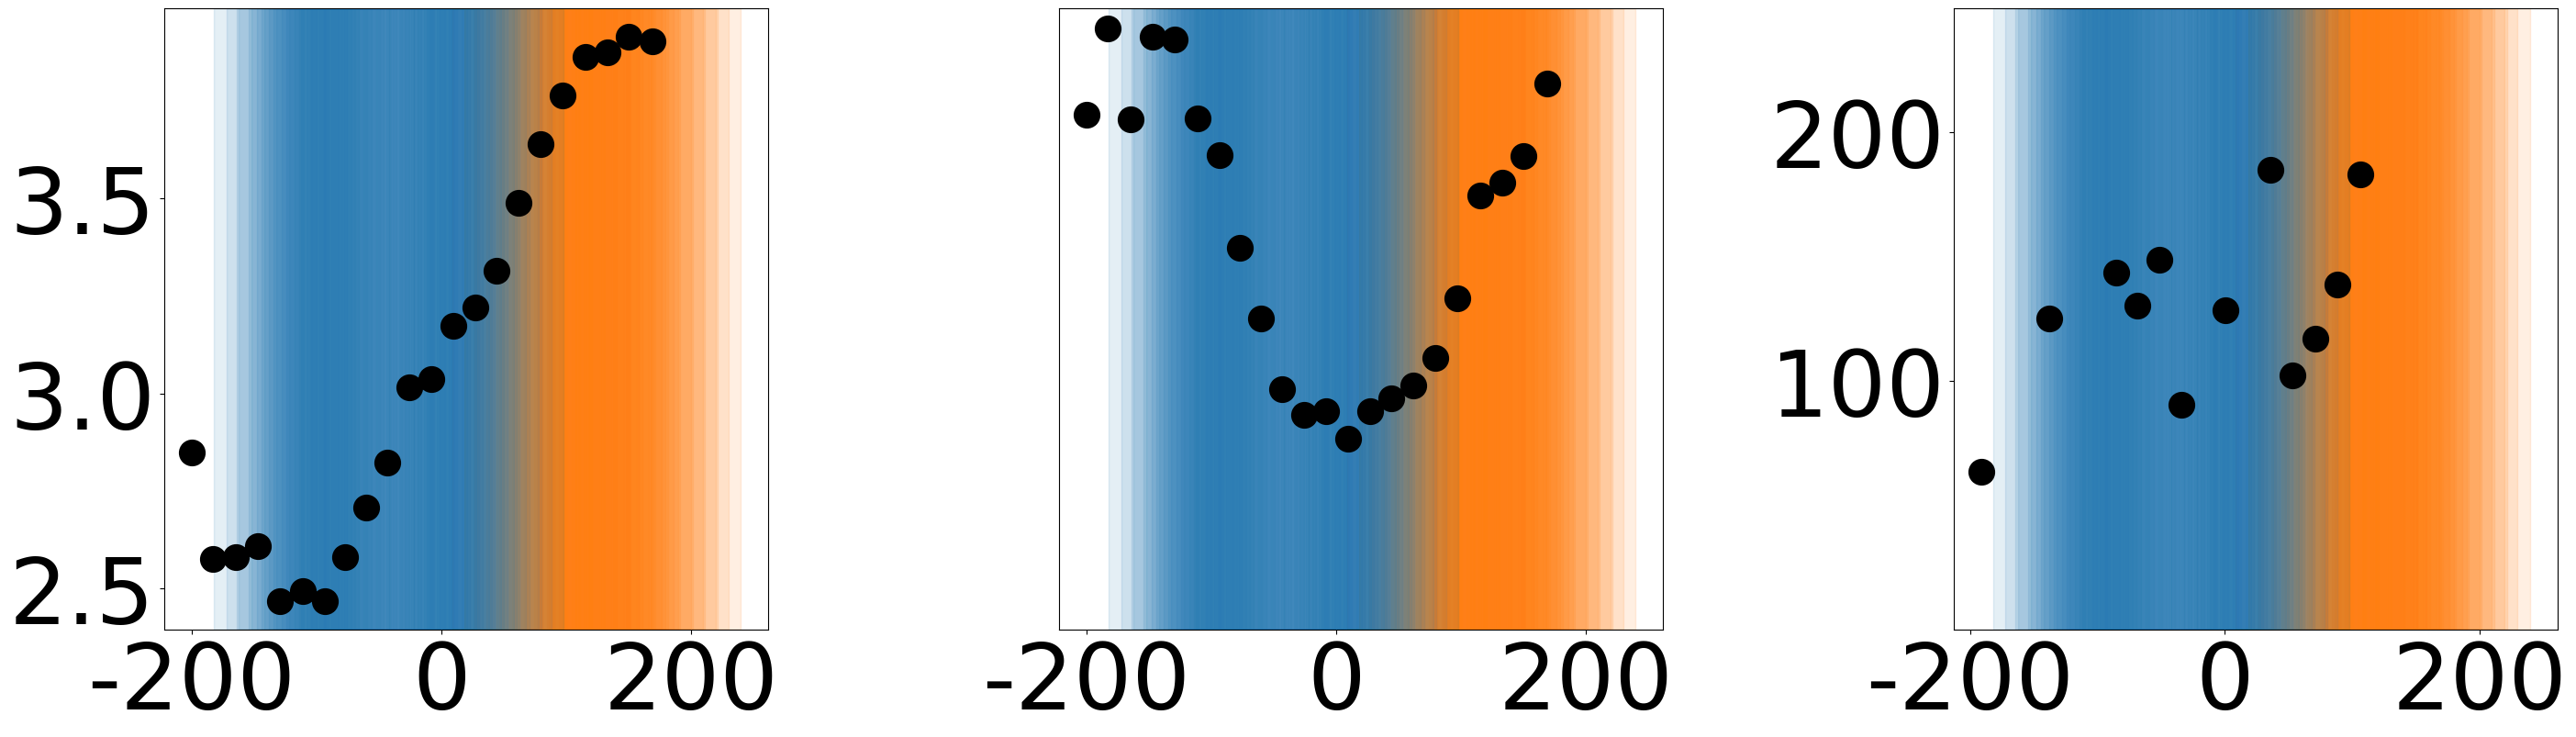

    drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
44  ACSF             432.360313              None              211.638397
45  ACSF             413.968936          Neighbor              101.327378
46  ACSF             396.094787          Neighbor               80.874932
47  ACSF             377.720002          Neighbor               95.330108
48  ACSF             359.836074          Neighbor              158.675077
49  ACSF             342.048598          Neighbor              123.367766
50  ACSF             323.703811          Neighbor              103.289735
51  ACSF             305.783042              None               96.675226
52  ACSF             288.033470          Neighbor              119.284679
53  ACSF             269.651701          Neighbor               82.064643
54  ACSF             251.769816              None               85.696913
55  ACSF             233.970567              None              442.499527
56  ACSF             215.651086       

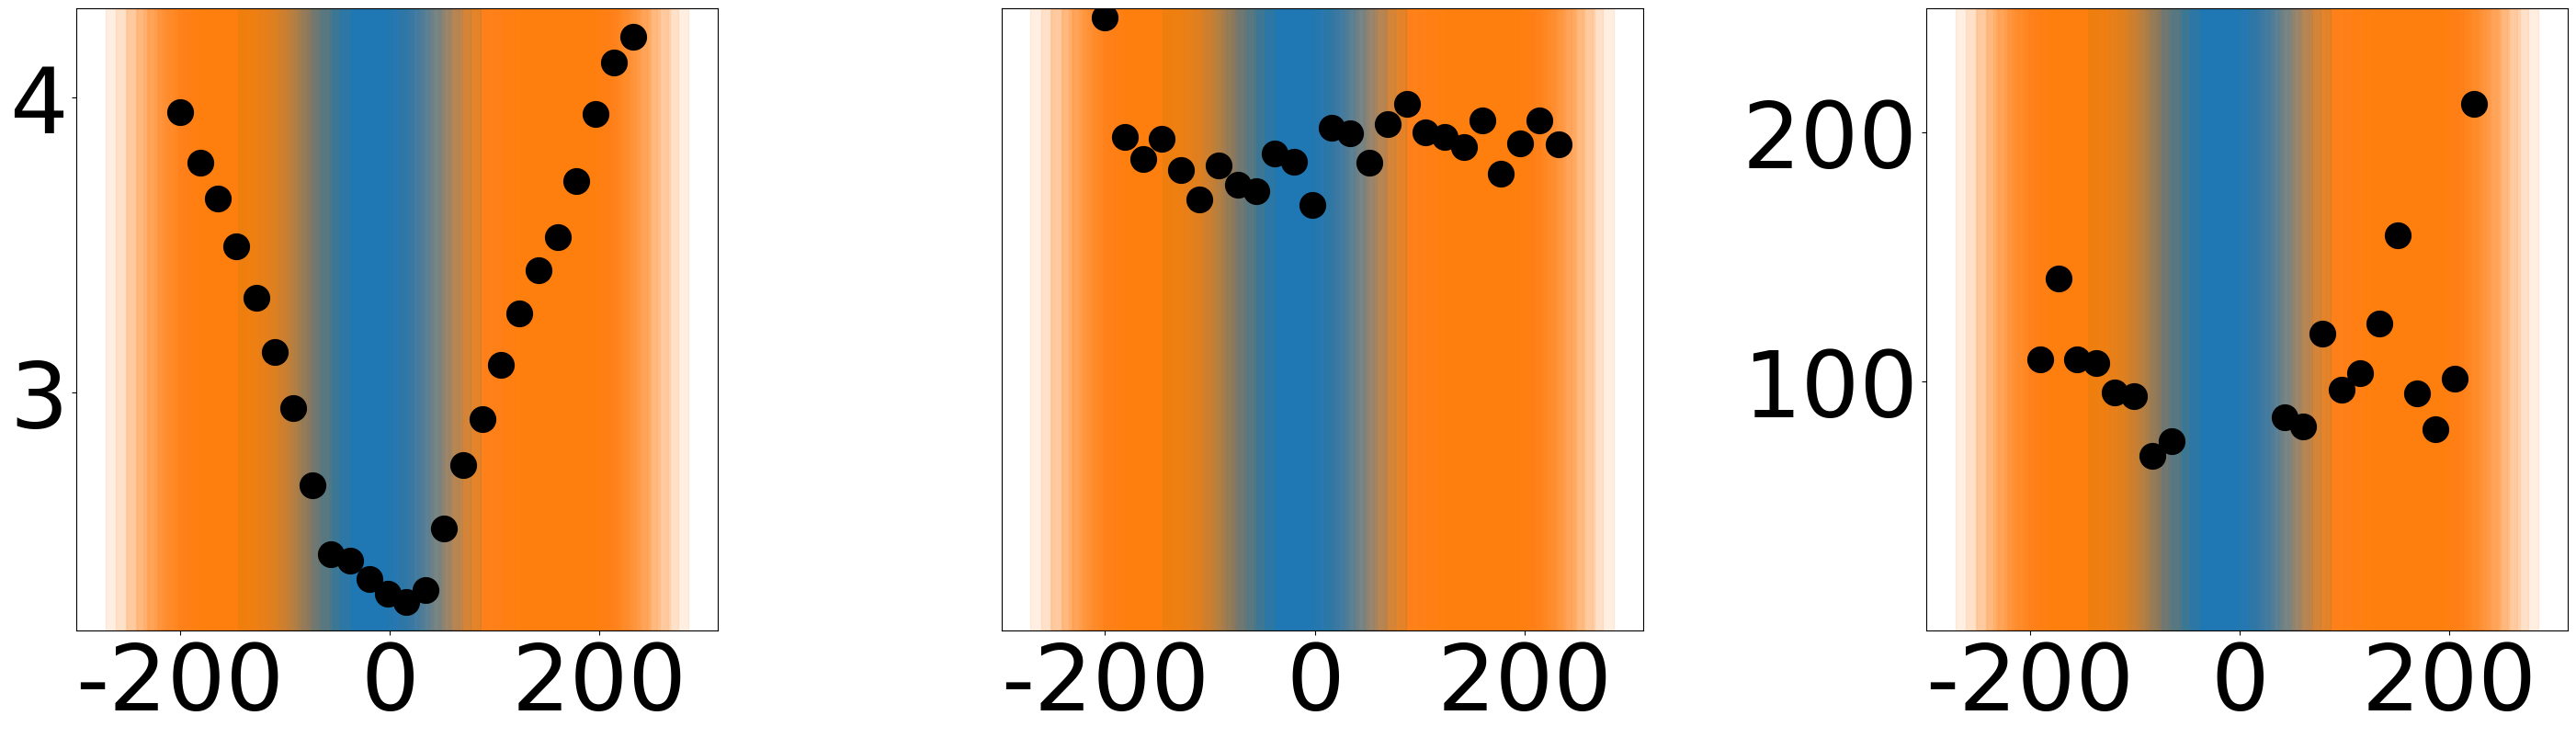

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
94   ACSF             430.110289              Home              486.288839
95   ACSF             412.117602              Home              203.680662
96   ACSF             394.132599              Home              -70.725751
97   ACSF             376.118750              Home              -66.798357
98   ACSF             358.136633              Home             -156.878942
99   ACSF             340.142618              None             -219.163775
100  ACSF             322.149272              None             -144.925003
101  ACSF             304.164079              None             -166.683086
102  ACSF             286.178974          Neighbor             -115.801918
103  ACSF             268.287578          Neighbor             -141.540966
104  ACSF             250.396800          Neighbor             -142.454175
105  ACSF             232.419083          Neighbor             -122.791931
106  ACSF             214

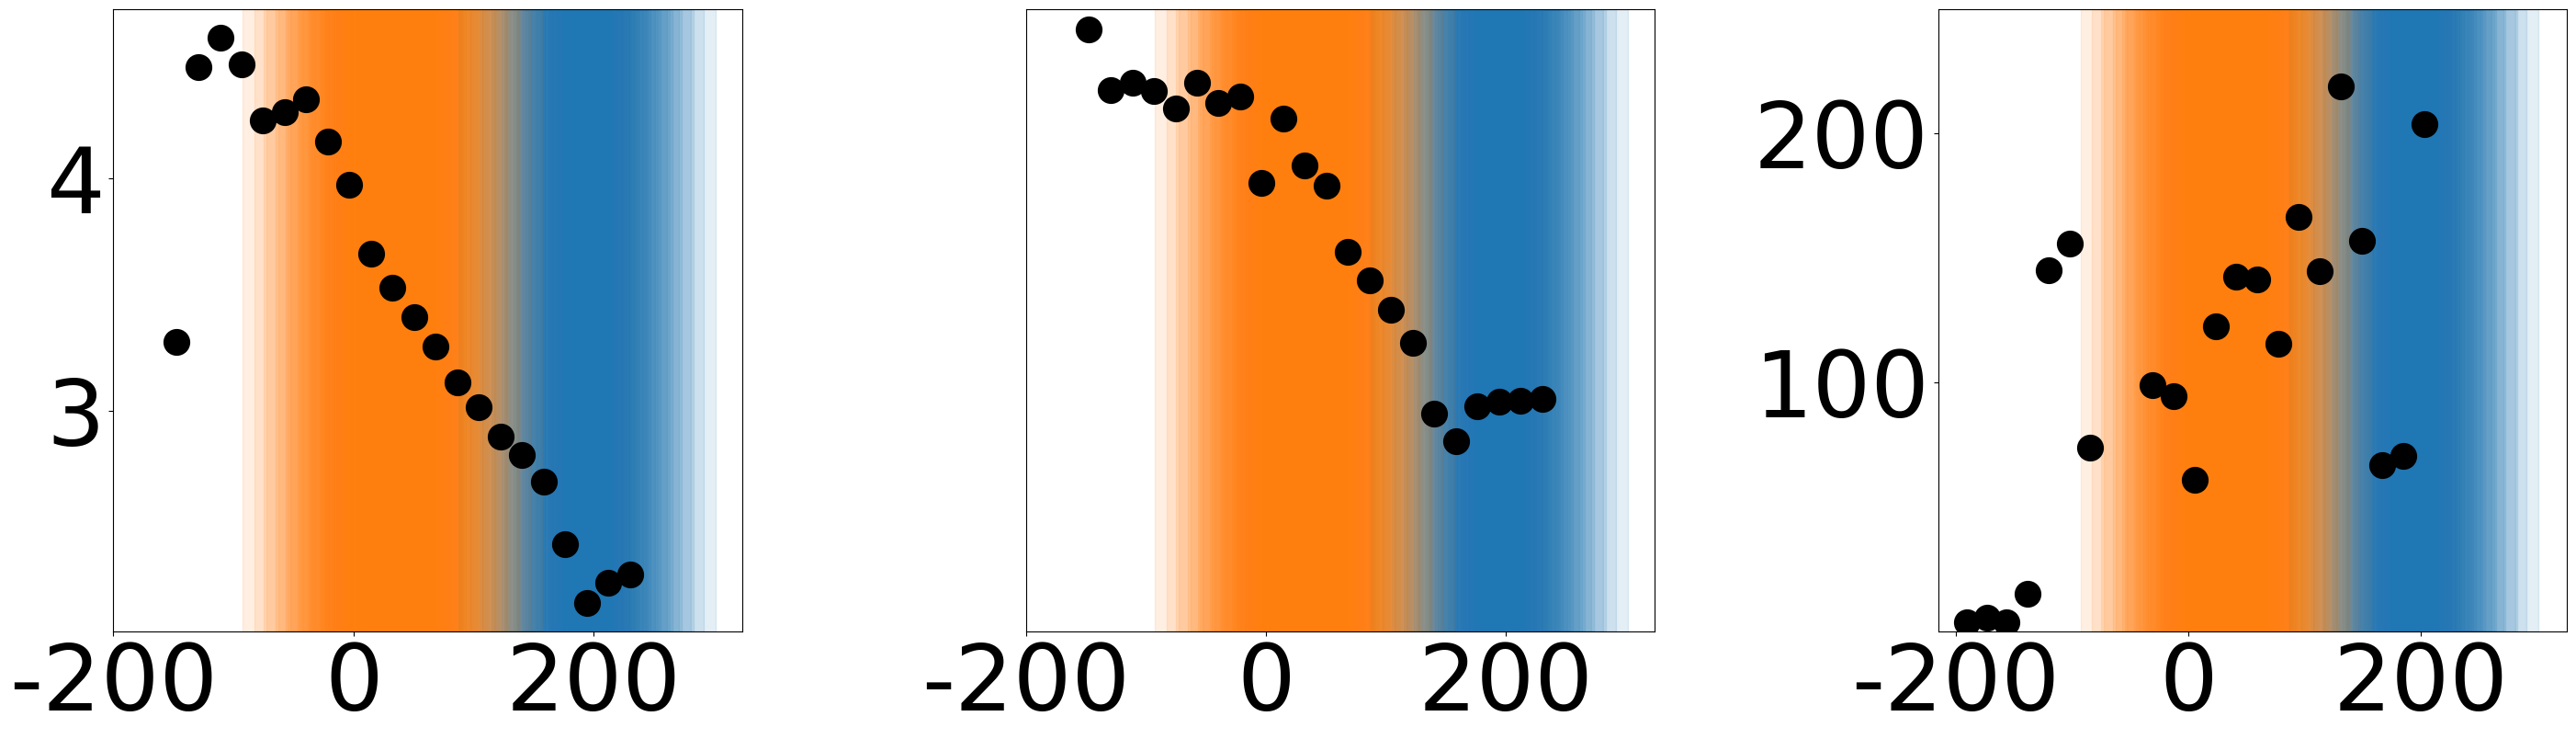

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
144  ACSF             495.611372              None               46.447408
145  ACSF             477.348251              None              128.819407
146  ACSF             459.094541              None              190.126553
147  ACSF             442.211303              None              150.041743
148  ACSF             423.996236              None              250.102233
149  ACSF             405.913844              None               97.035441
150  ACSF             387.603256              None               63.881818
151  ACSF             369.416103              None               50.651101
152  ACSF             352.539156              Home               65.169195
153  ACSF             334.383018              Home              171.558757
154  ACSF             316.369349              Home              109.711715
155  ACSF             299.199465              Home               94.109777
156  ACSF             280

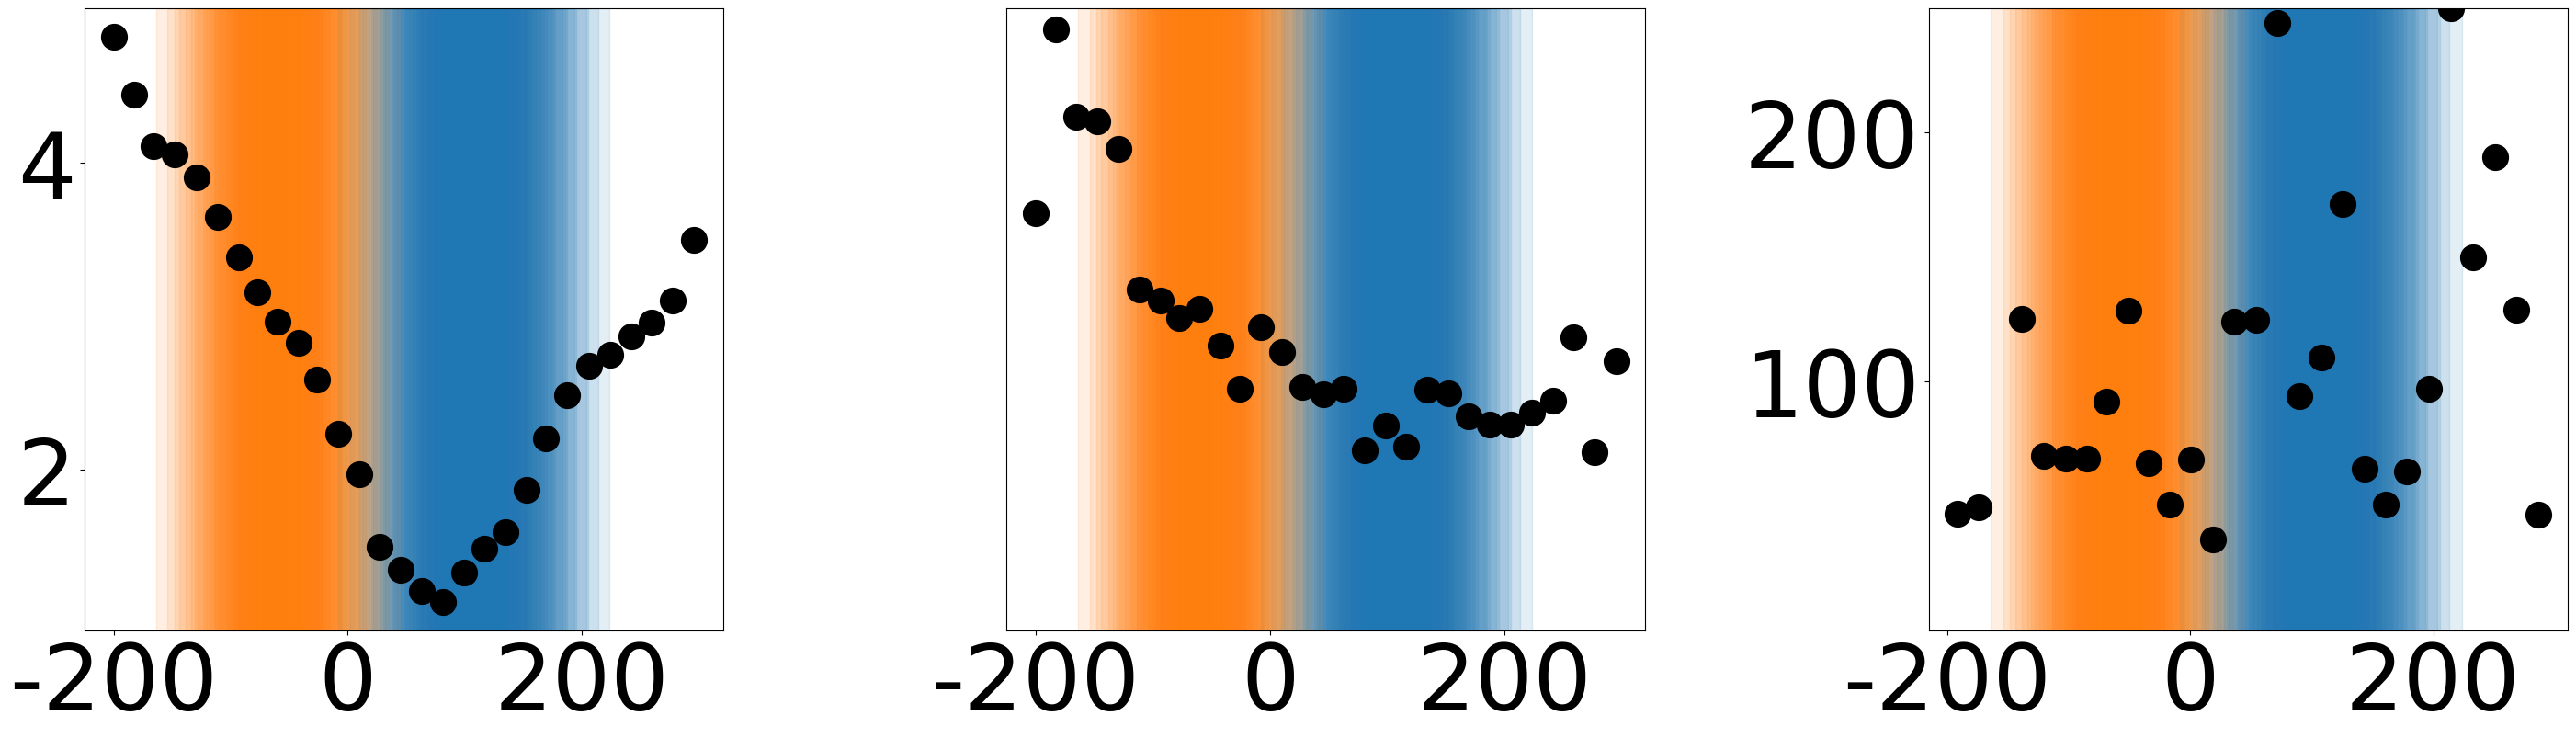

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
202  ACSF             388.536514              None               65.104863
203  ACSF             370.925649              None               44.614970
204  ACSF             352.896740              None              -80.408649
205  ACSF             335.150551              None             -232.437797
206  ACSF             317.043647              None              104.480100
207  ACSF             299.208894              None               90.230783
208  ACSF             281.280037              None              174.489961
209  ACSF             263.708898              None              122.778613
210  ACSF             245.427163          Neighbor              323.697402
211  ACSF             227.979873              None              115.461868
212  ACSF             209.933183          Neighbor               55.630221
213  ACSF             192.226083          Neighbor               58.920040
214  ACSF             174

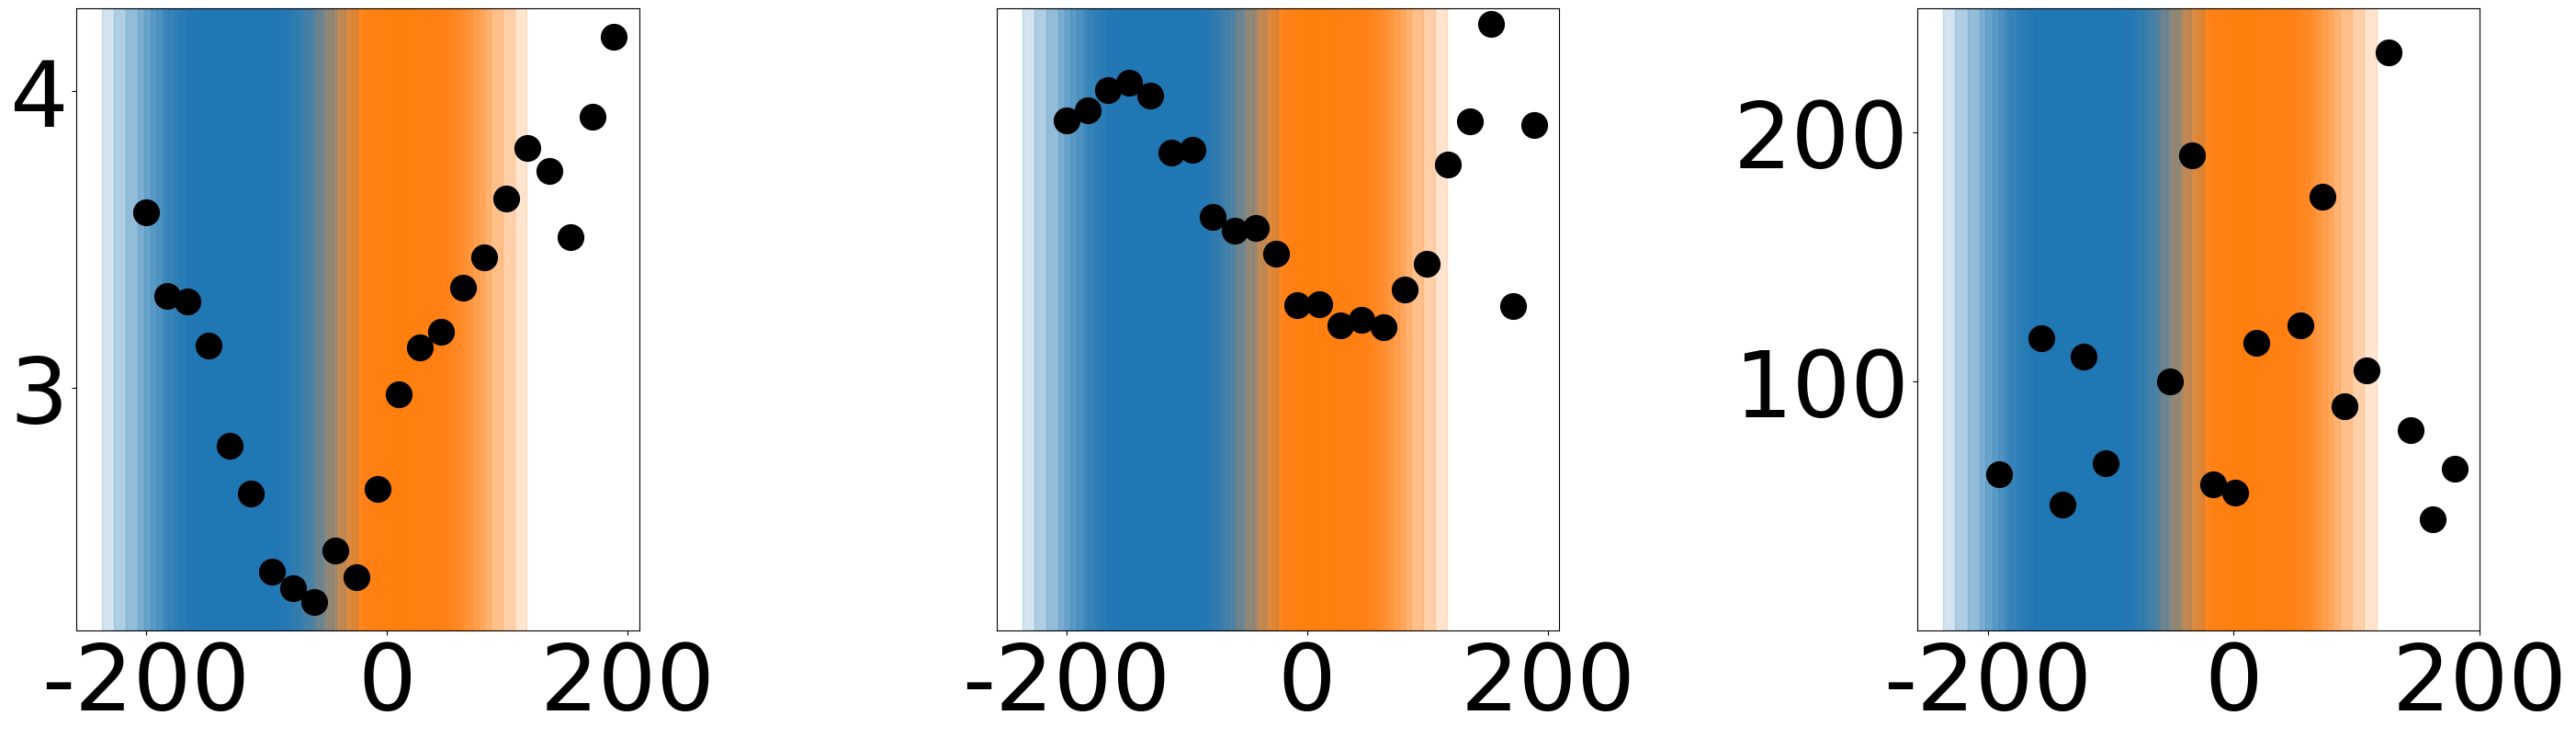

No ROI file found for  11/6/2024 1 1


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
969  ACSF             435.419753          Neighbor              120.663688
970  ACSF             416.837545              None               92.289429
971  ACSF             399.671712          Neighbor               48.395263
972  ACSF             381.233117          Neighbor               99.778105
973  ACSF             363.771948              None               87.508160
974  ACSF             345.832775              None               81.133978
975  ACSF             328.064434              Home               60.486552
976  ACSF             309.857982              Home              279.467229
977  ACSF             292.531014              Home             -116.238861
978  ACSF             274.513990              Home             -125.098303
979  ACSF             256.875130              Home             -154.048403
980  ACSF             238.851466              Home             -169.119635
981  ACSF             220

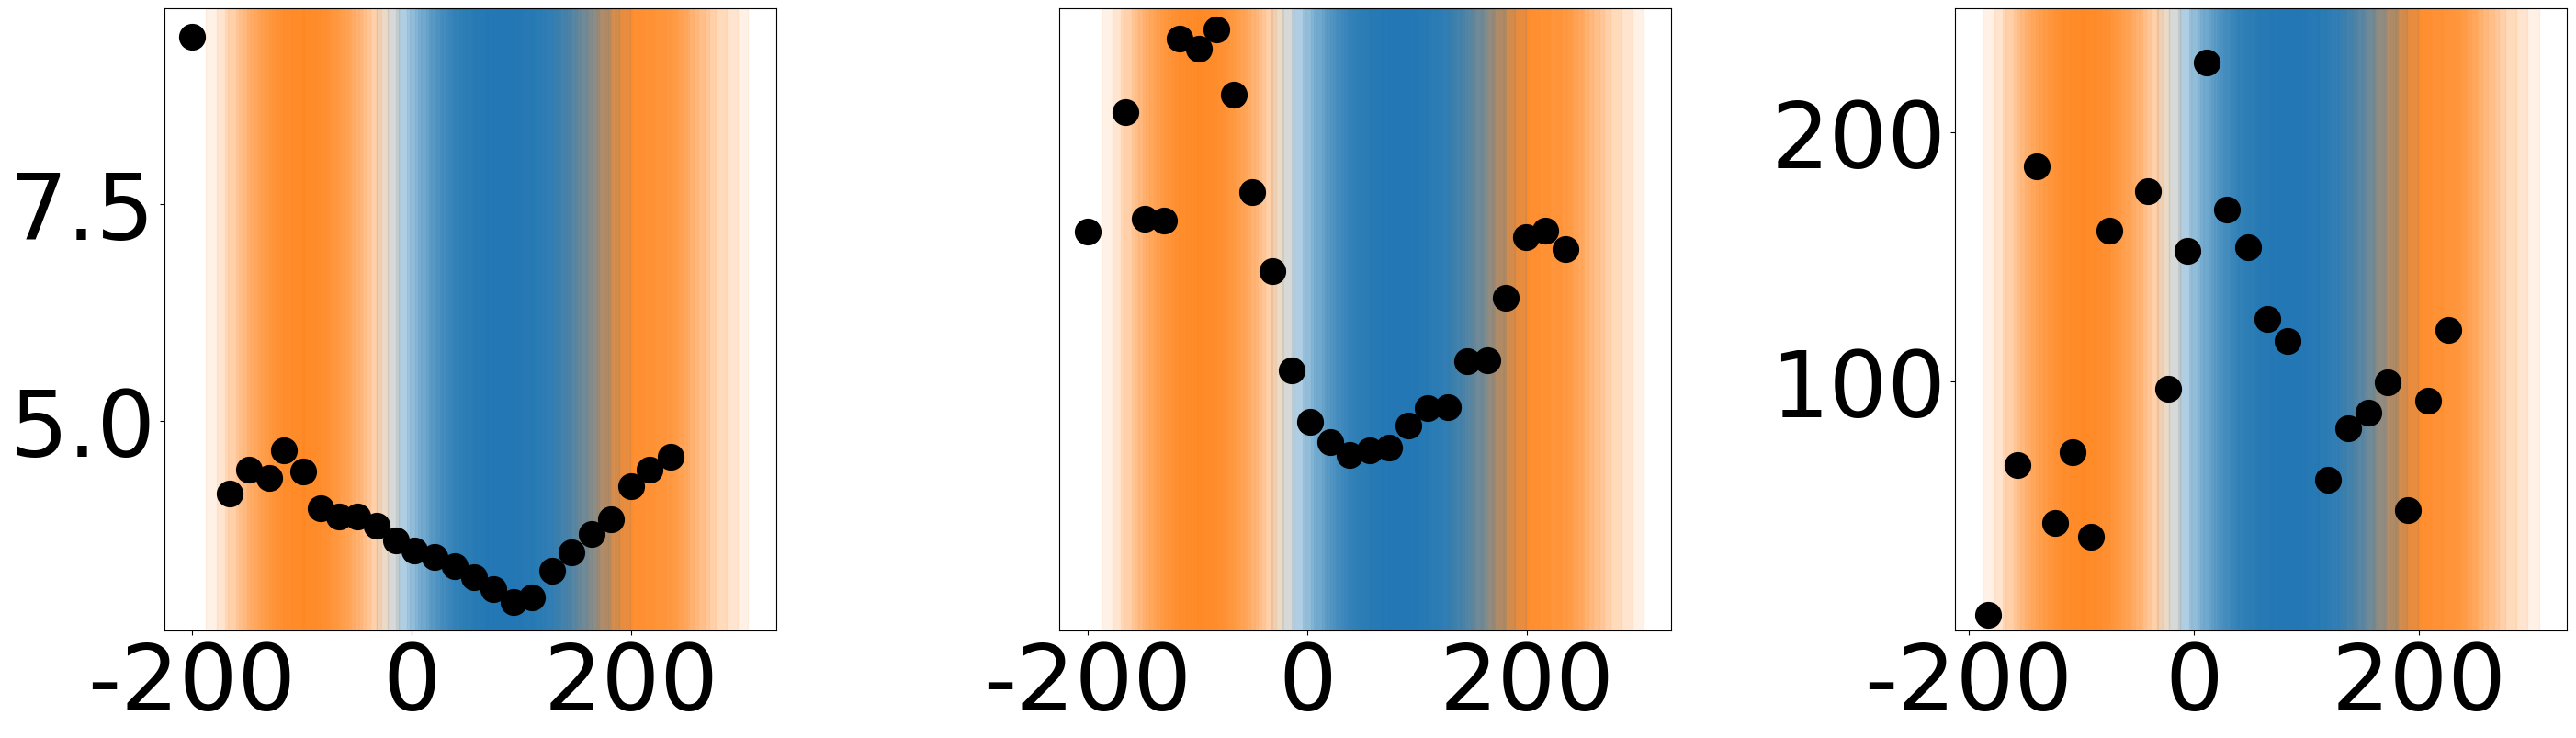

No ROI file found for  12/9/2024 1 1


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
344  ACSF             507.399931              None               34.576583
345  ACSF             490.066690              None               94.065929
346  ACSF             472.504581          Neighbor                     NaN
347  ACSF             454.125955              None             -237.197565
348  ACSF             436.810533          Neighbor             -782.988696
349  ACSF             418.723494          Neighbor               64.788278
350  ACSF             400.958548          Neighbor               83.585081
351  ACSF             383.330454              None               49.404910
352  ACSF             365.317424              None               72.662501
353  ACSF             347.631371              Home               83.774637
354  ACSF             329.846016              Home               92.051369
355  ACSF             313.479282              Home             -333.565307
356  ACSF             294

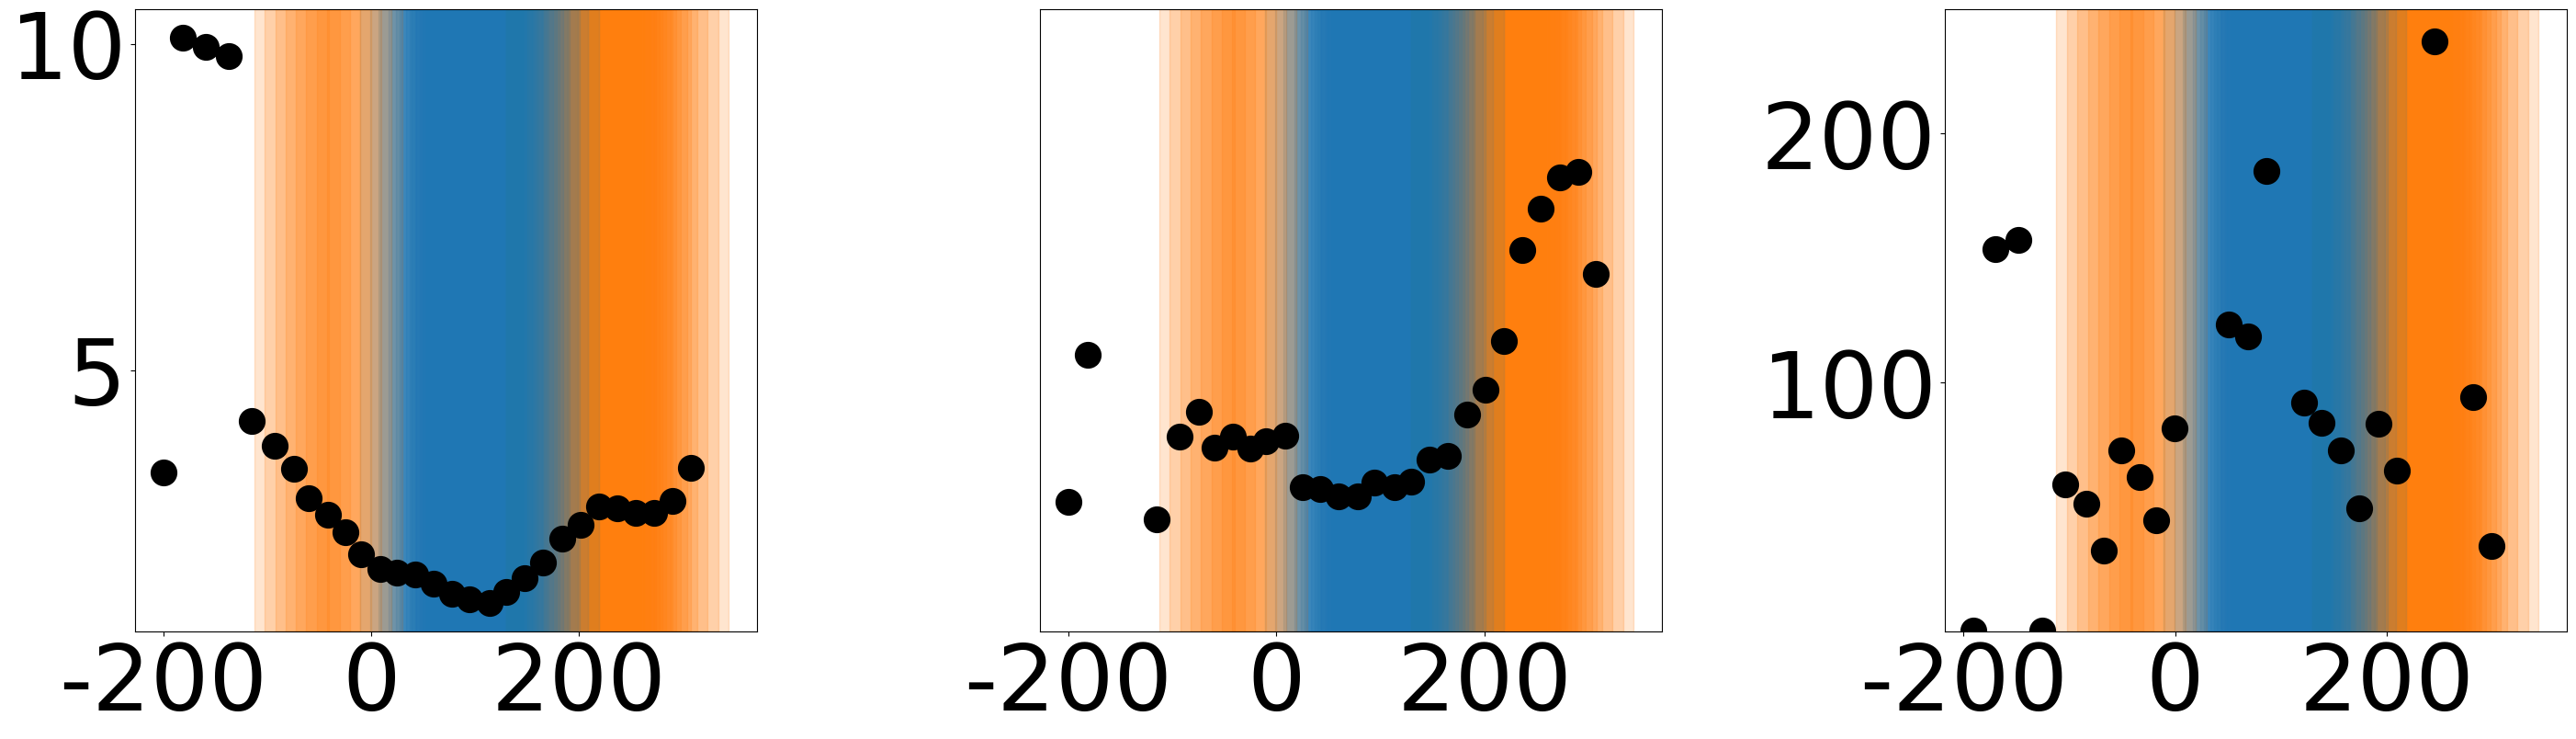

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
402  ACSF             414.010869              None              108.692669
403  ACSF             396.011363              None              101.634438
404  ACSF             378.011905              None              132.836936
405  ACSF             360.012500              None              369.108602
406  ACSF             342.000000              None              218.181818
407  ACSF             324.000000              Home              402.684564
408  ACSF             306.000000              Home                     NaN
409  ACSF             288.000000              None             -248.962656
410  ACSF             270.000000              Home             -117.340287
411  ACSF             252.000000              None              -87.167070
412  ACSF             234.000000              None              -98.306936
413  ACSF             216.000000              None             -137.231099
414  ACSF             198

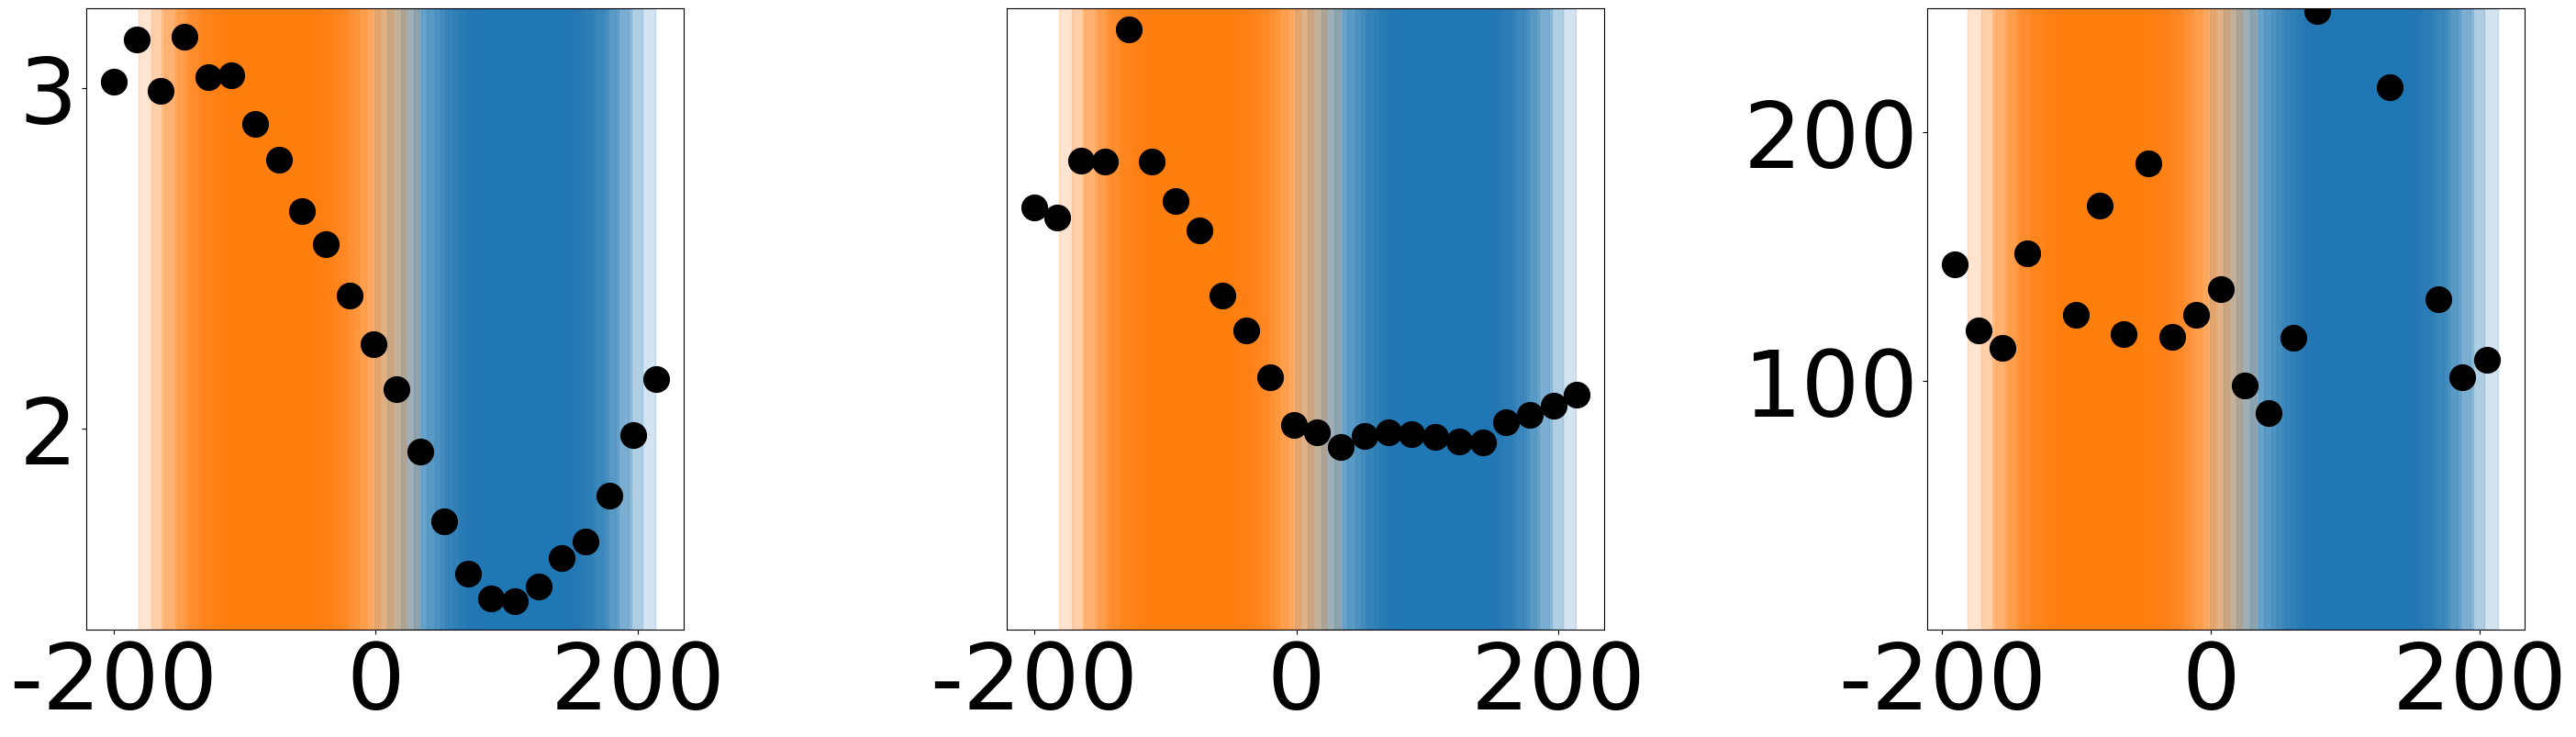

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
450  ACSF             464.397477          Neighbor              380.984401
451  ACSF             446.643604          Neighbor               26.135570
452  ACSF             429.054365          Neighbor               54.011000
453  ACSF             411.484587              None               77.974583
454  ACSF             393.605015              None               54.262410
455  ACSF             375.058123          Neighbor               51.205856
456  ACSF             357.284571              None               48.682065
457  ACSF             339.676268              None               51.339383
458  ACSF             321.851234              None              186.267013
459  ACSF             303.764707              None              202.005624
460  ACSF             286.170017              None              183.449872
461  ACSF             269.017454              Home              266.822798
462  ACSF             250

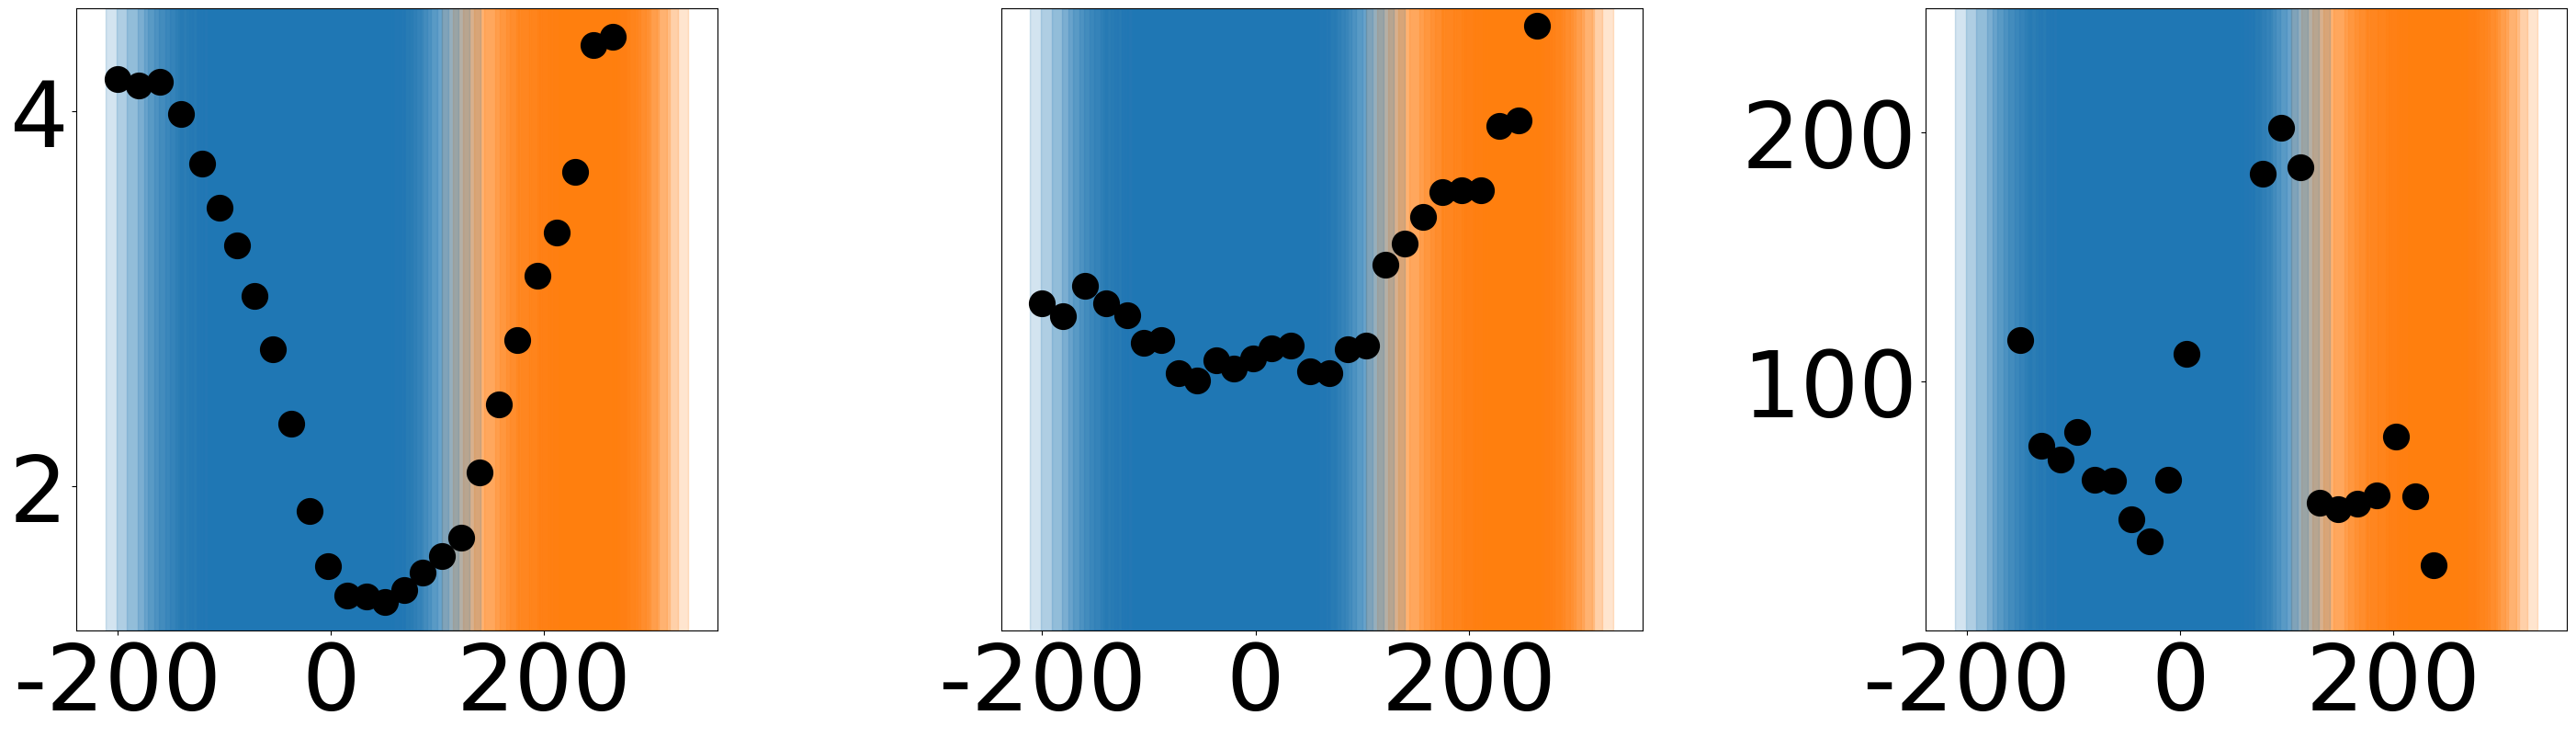

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
994   ACSF             466.927868              Home              107.212072
995   ACSF             448.809027              Home               98.732809
996   ACSF             430.642191              Home              164.593015
997   ACSF             412.866145              Home                     NaN
998   ACSF             394.743427              None               45.435828
999   ACSF             376.569095              Home                     NaN
1000  ACSF             358.610401              Home             -555.686427
1001  ACSF             340.828436              Home              -72.599151
1002  ACSF             322.751247              Home              -52.758614
1003  ACSF             304.971594              None             -150.184010
1004  ACSF             287.099697              None              -45.992745
1005  ACSF             268.932562              None             -112.487272
1006  ACSF  

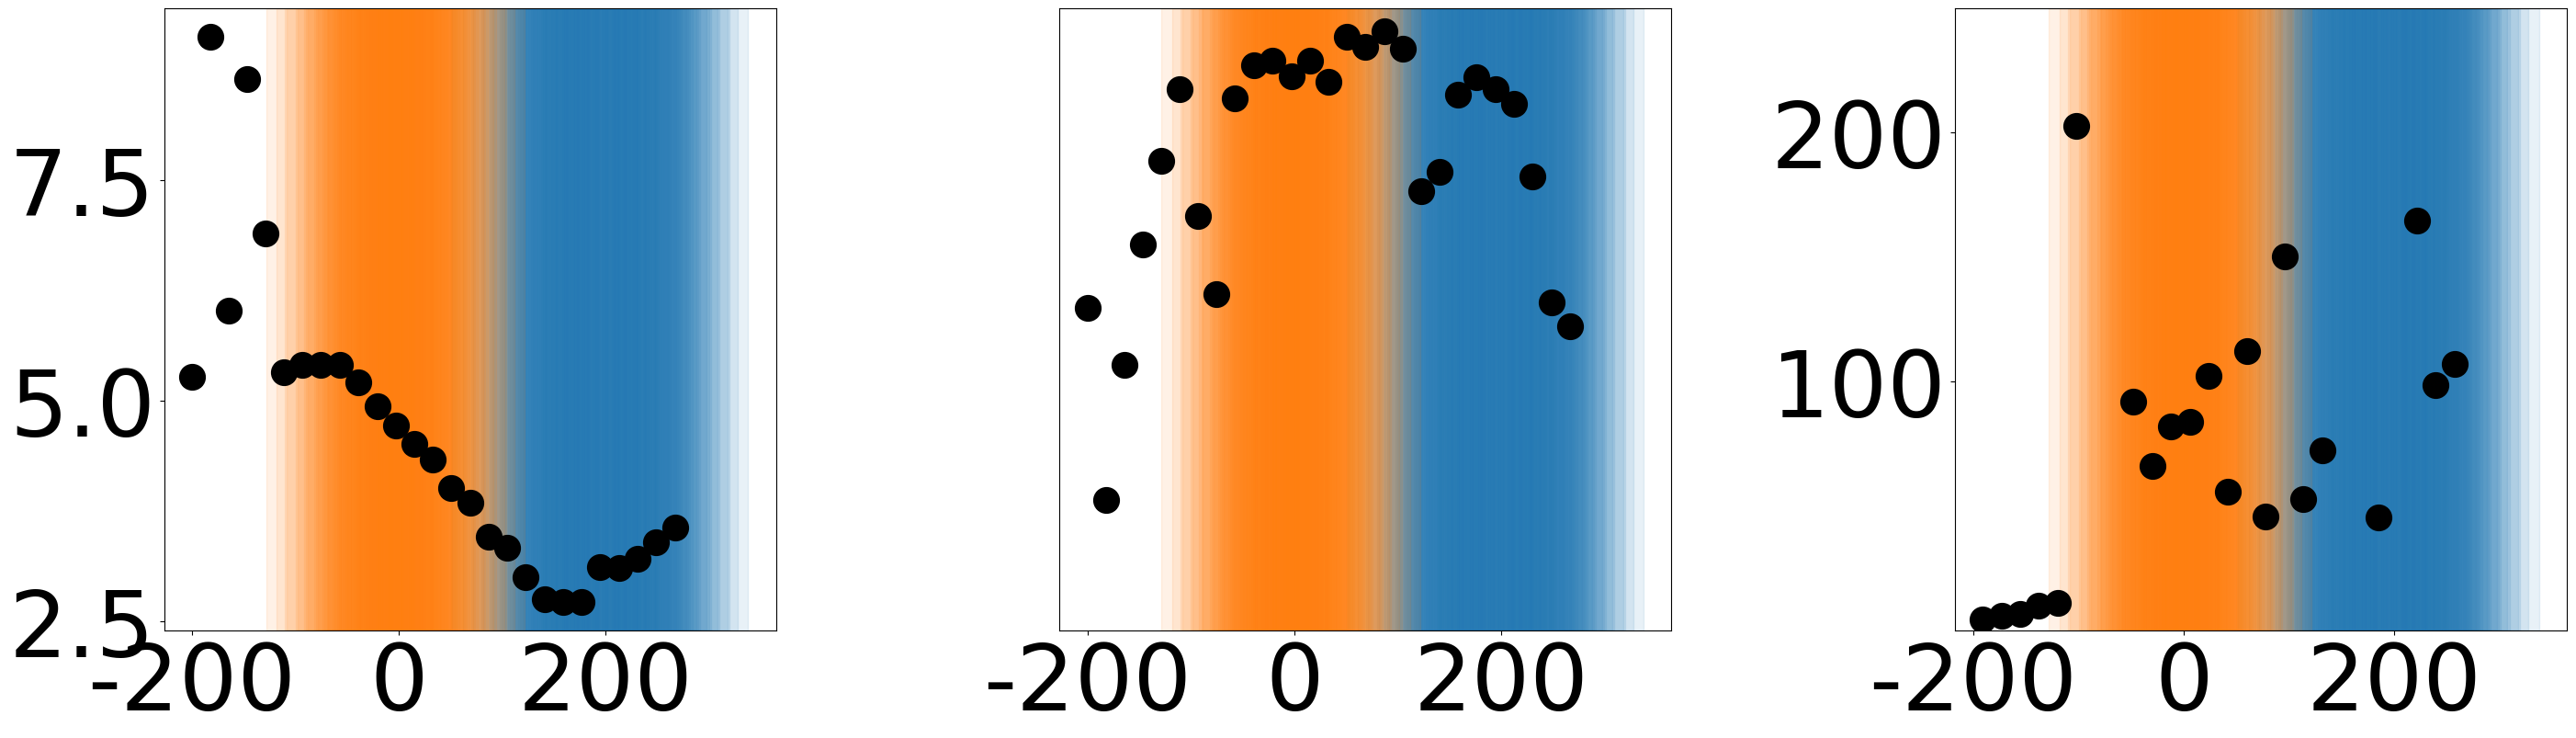

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
504  ACSF             499.134323              None              355.536009
505  ACSF             482.317469              None              290.417201
506  ACSF             463.208018          Neighbor              185.452227
507  ACSF             445.590056          Neighbor              329.282647
508  ACSF             427.249013          Neighbor               86.877526
509  ACSF             410.499026          Neighbor              128.890678
510  ACSF             390.984977          Neighbor              153.372688
511  ACSF             374.543425          Neighbor              934.362409
512  ACSF             355.015250              None               88.240638
513  ACSF             338.973102              None             -153.999343
514  ACSF             320.754980              None              659.720447
515  ACSF             303.404332              Home                     NaN
516  ACSF             286

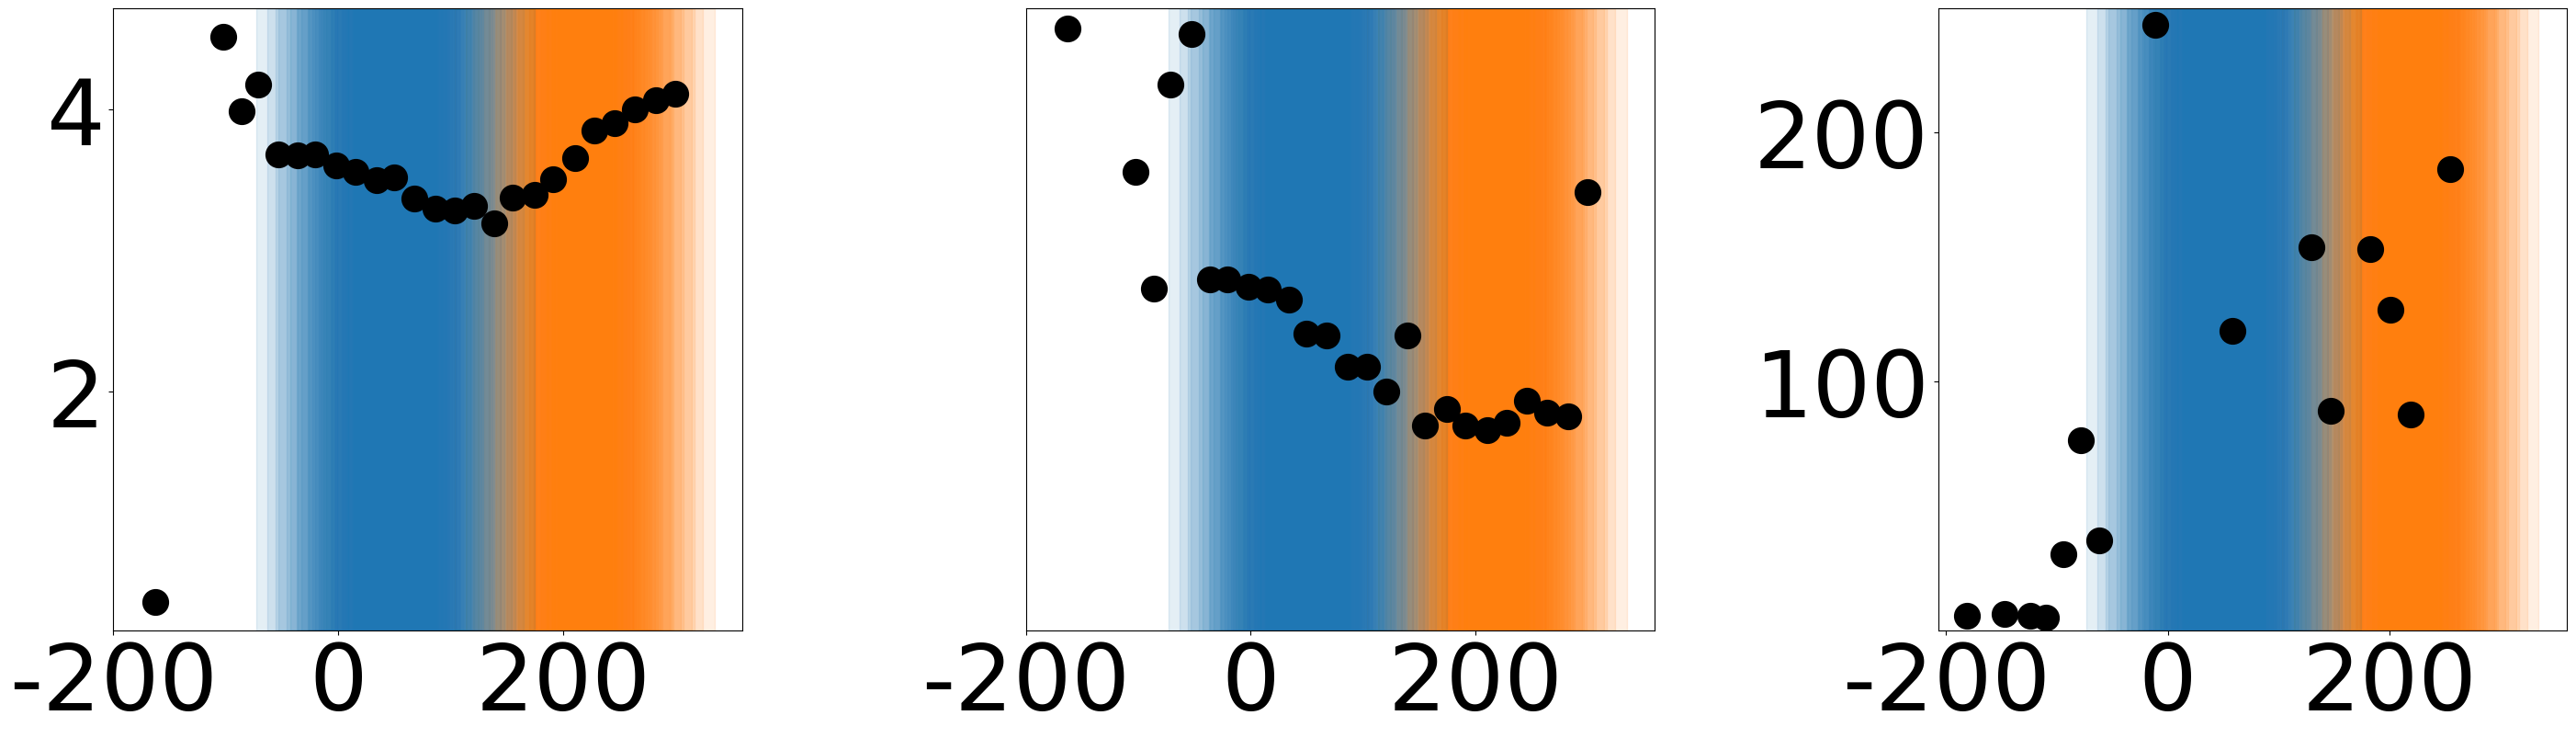

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
560  ACSF             411.098528              None              877.828703
561  ACSF             393.103040              None               88.733015
562  ACSF             375.107984              None               42.697923
563  ACSF             357.012605              None               95.682001
564  ACSF             339.053093              None               88.524463
565  ACSF             321.056070              None               28.006022
566  ACSF             303.059400              None             -214.496415
567  ACSF             285.063151              Home             -512.699250
568  ACSF             267.067407              None              275.576241
569  ACSF             249.072279              None              129.642433
570  ACSF             231.077909              None              123.651908
571  ACSF             213.000000              Home               90.200323
572  ACSF             195

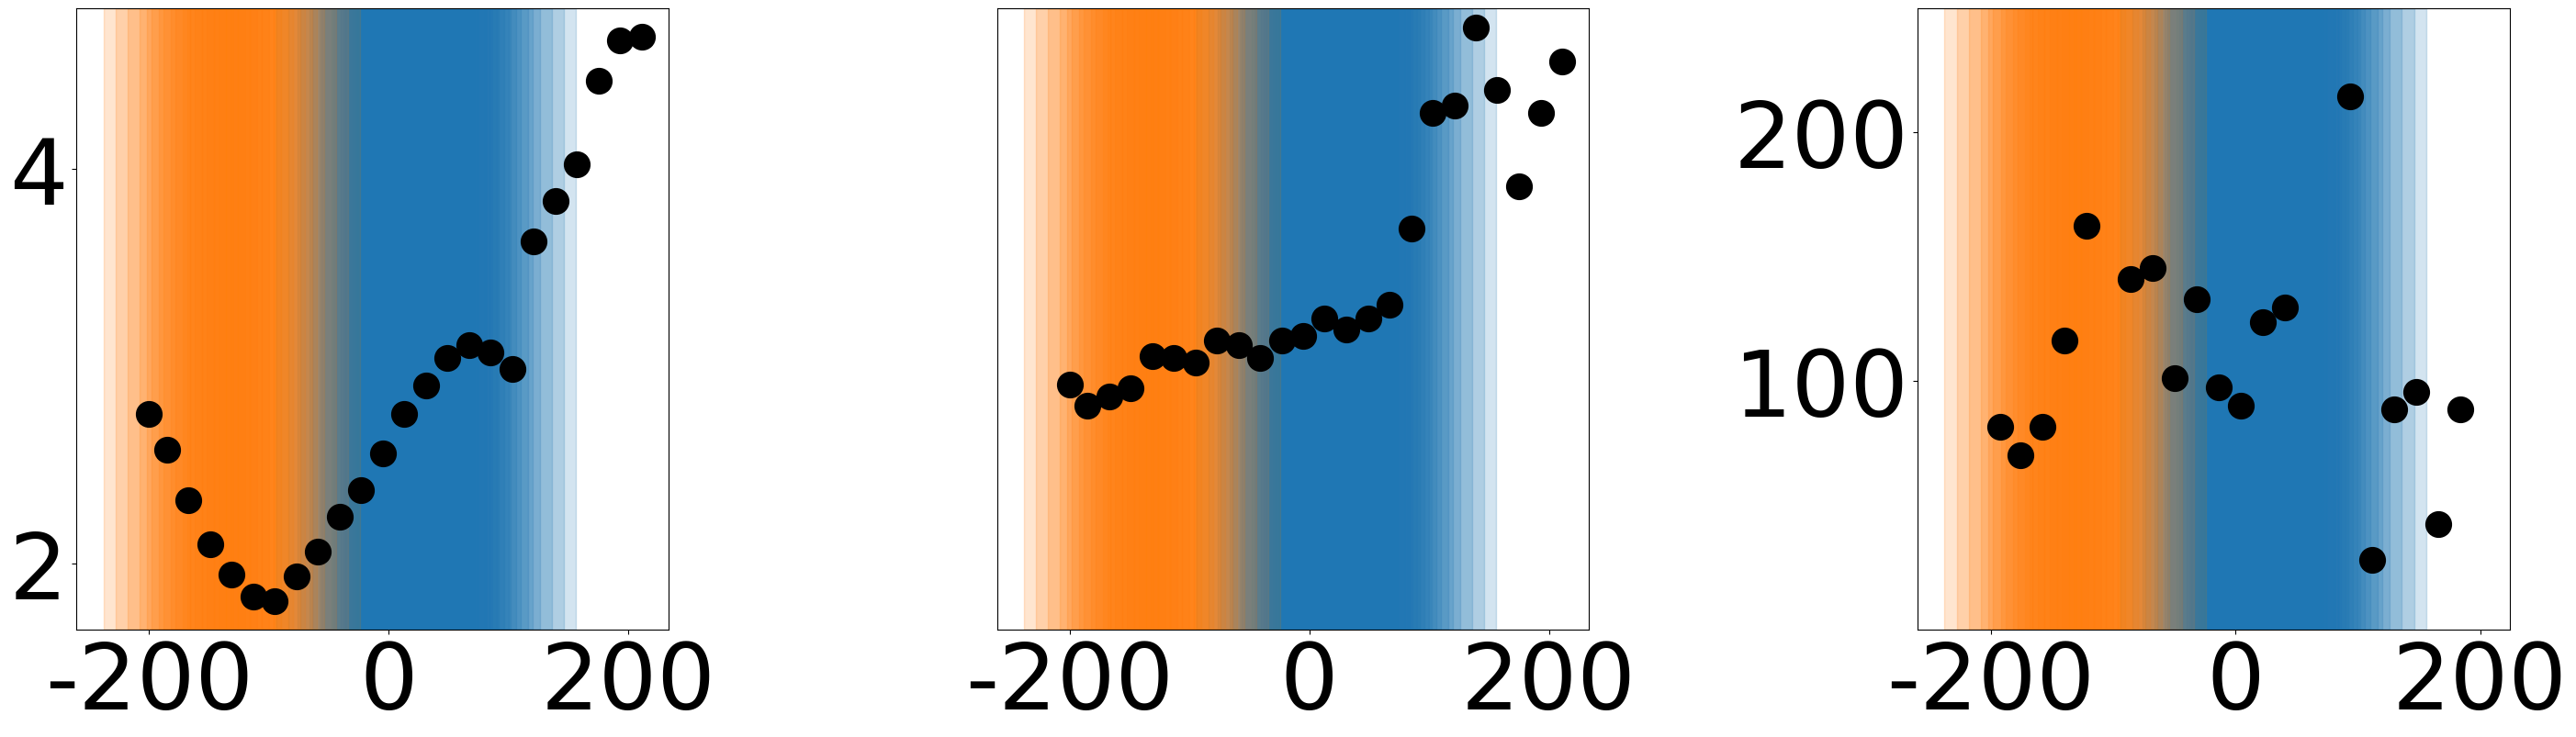

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
608  ACSF             413.649162              None               73.242832
609  ACSF             395.931721              Home               84.992276
610  ACSF             377.947355              Home               81.566168
611  ACSF             360.157774              Home               63.281643
612  ACSF             342.046567              Home               51.040057
613  ACSF             324.284628              Home               57.171078
614  ACSF             306.281455              Home             -604.204352
615  ACSF             288.880370              Home             1394.047472
616  ACSF             270.897158              None             -496.764938
617  ACSF             253.013620              None              -83.465698
618  ACSF             235.243773              None              -70.674240
619  ACSF             217.582280          Neighbor              -75.465092
620  ACSF             199

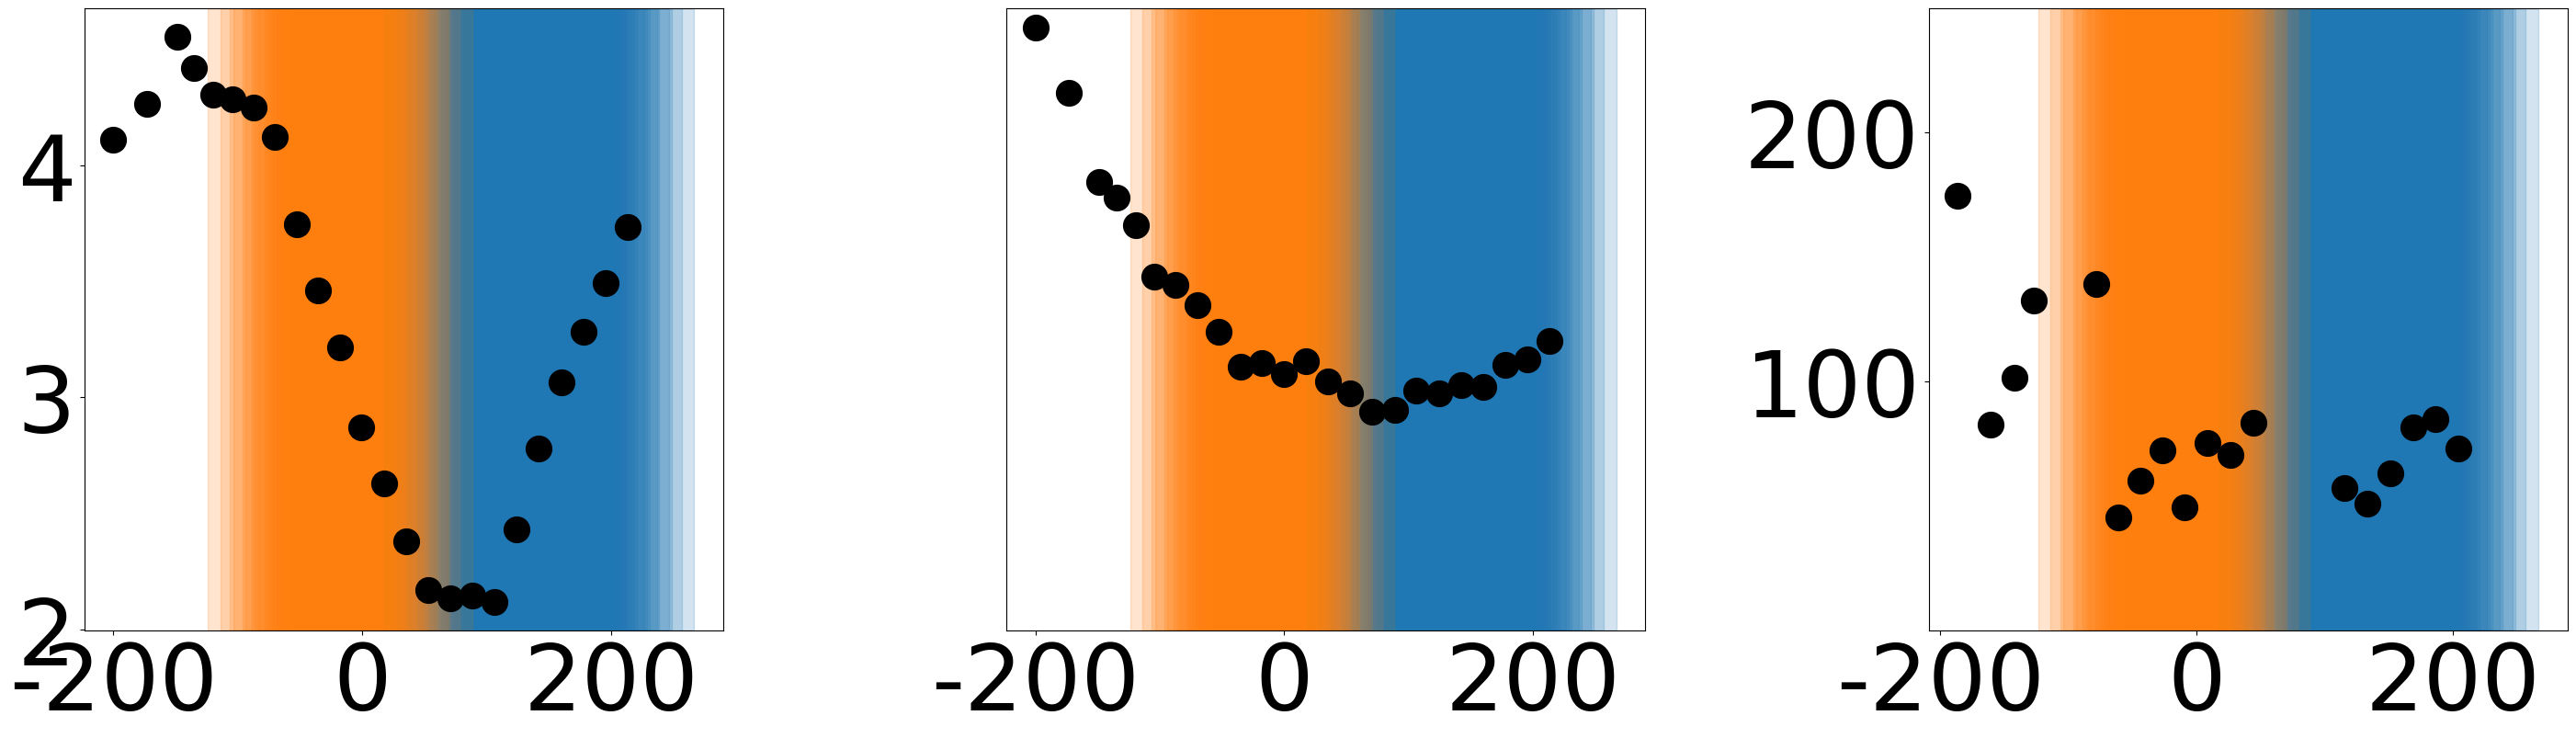

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1021  ACSF             463.639256          Neighbor              276.638170
1022  ACSF             445.104499          Neighbor               58.637869
1023  ACSF             427.161311              None               86.735904
1024  ACSF             409.206979          Neighbor              242.540296
1025  ACSF             391.744078              None              123.090704
1026  ACSF             373.280472              None              102.375287
1027  ACSF             355.671923              None              109.842898
1028  ACSF             337.218316              None               78.906431
1029  ACSF             319.701088              Home               89.876785
1030  ACSF             301.995361              Home               93.299176
1031  ACSF             284.175219              Home              459.703409
1032  ACSF             265.787082              Home             -210.026858
1033  ACSF  

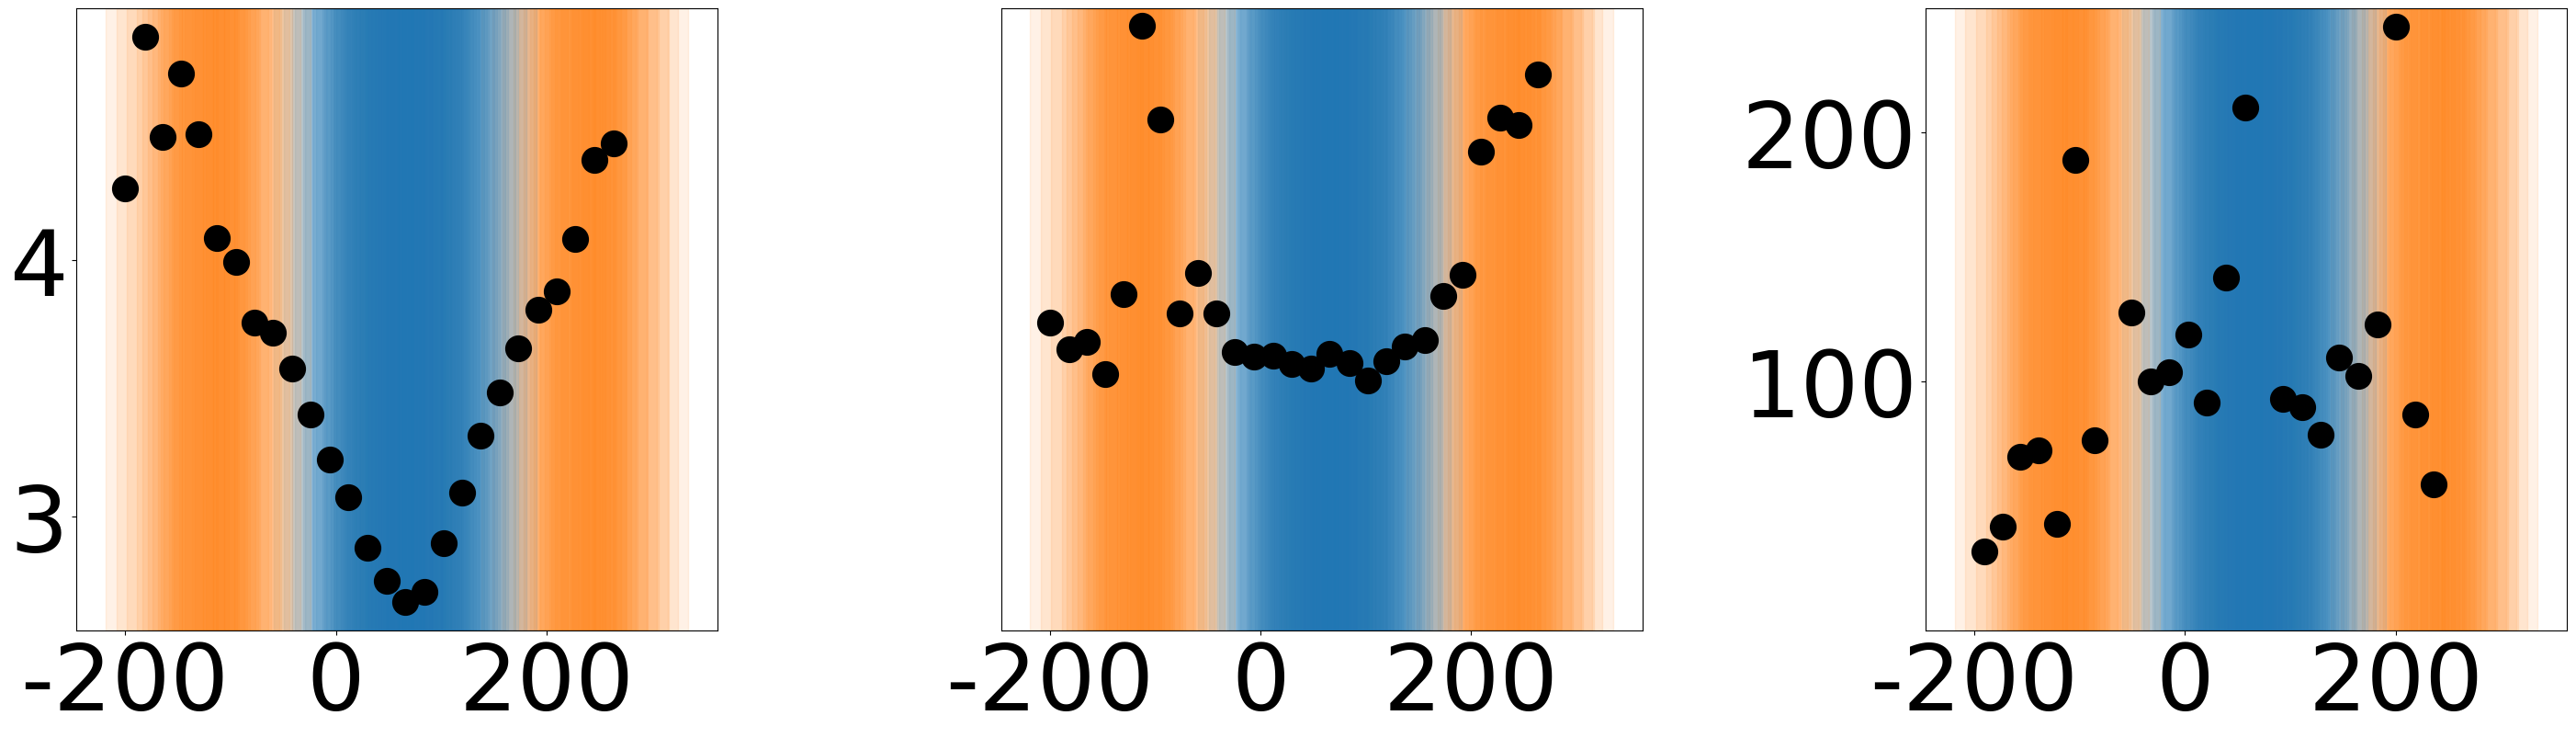

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
656  ACSF             415.288174              None               -1.182643
657  ACSF             397.403184              None             -168.511893
658  ACSF             379.844244              None                2.504684
659  ACSF             361.701063              None               -2.662894
660  ACSF             343.674071              None               49.004508
661  ACSF             325.949141              None              106.850544
662  ACSF             307.699068              None               66.477329
663  ACSF             289.982860              None              546.535121
664  ACSF             271.837894              Home                     NaN
665  ACSF             254.336869              Home               95.555326
666  ACSF             236.143135              None             -310.302622
667  ACSF             218.486916              Home              423.370800
668  ACSF             201

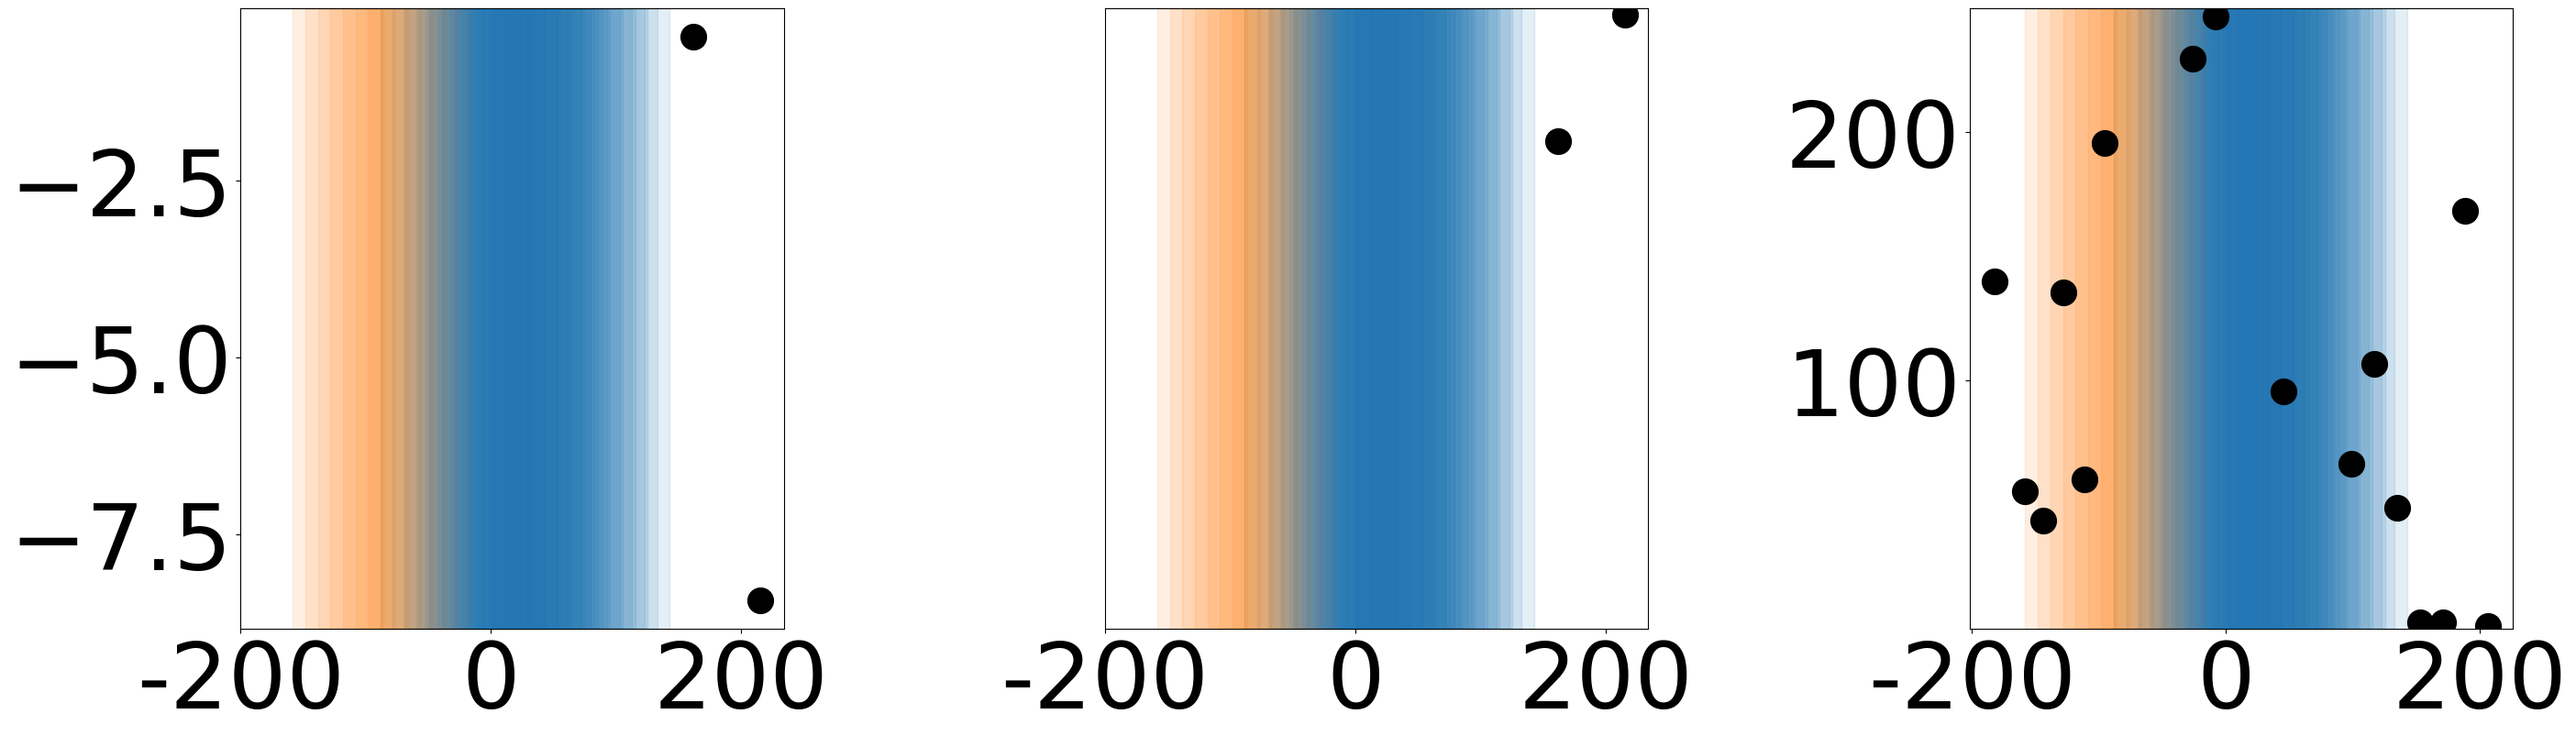

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
704  ACSF             491.367043              None             -152.759681
705  ACSF             474.563864              None              -79.936829
706  ACSF             454.912200              None             -106.888378
707  ACSF             438.791613              None               70.708522
708  ACSF             420.243109              None               35.137982
..    ...                    ...               ...                     ...
811  ACSF              99.448200          Neighbor               74.130072
812  ACSF              82.830732          Neighbor              -26.366625
813  ACSF              67.740267              None               18.089689
814  ACSF              51.298779              None             -112.734470
815  ACSF              35.642295              None              -51.776593

[112 rows x 4 columns]
     ROI       amp       snr  latency  halfwidth  Stim_Distance   X_Center  

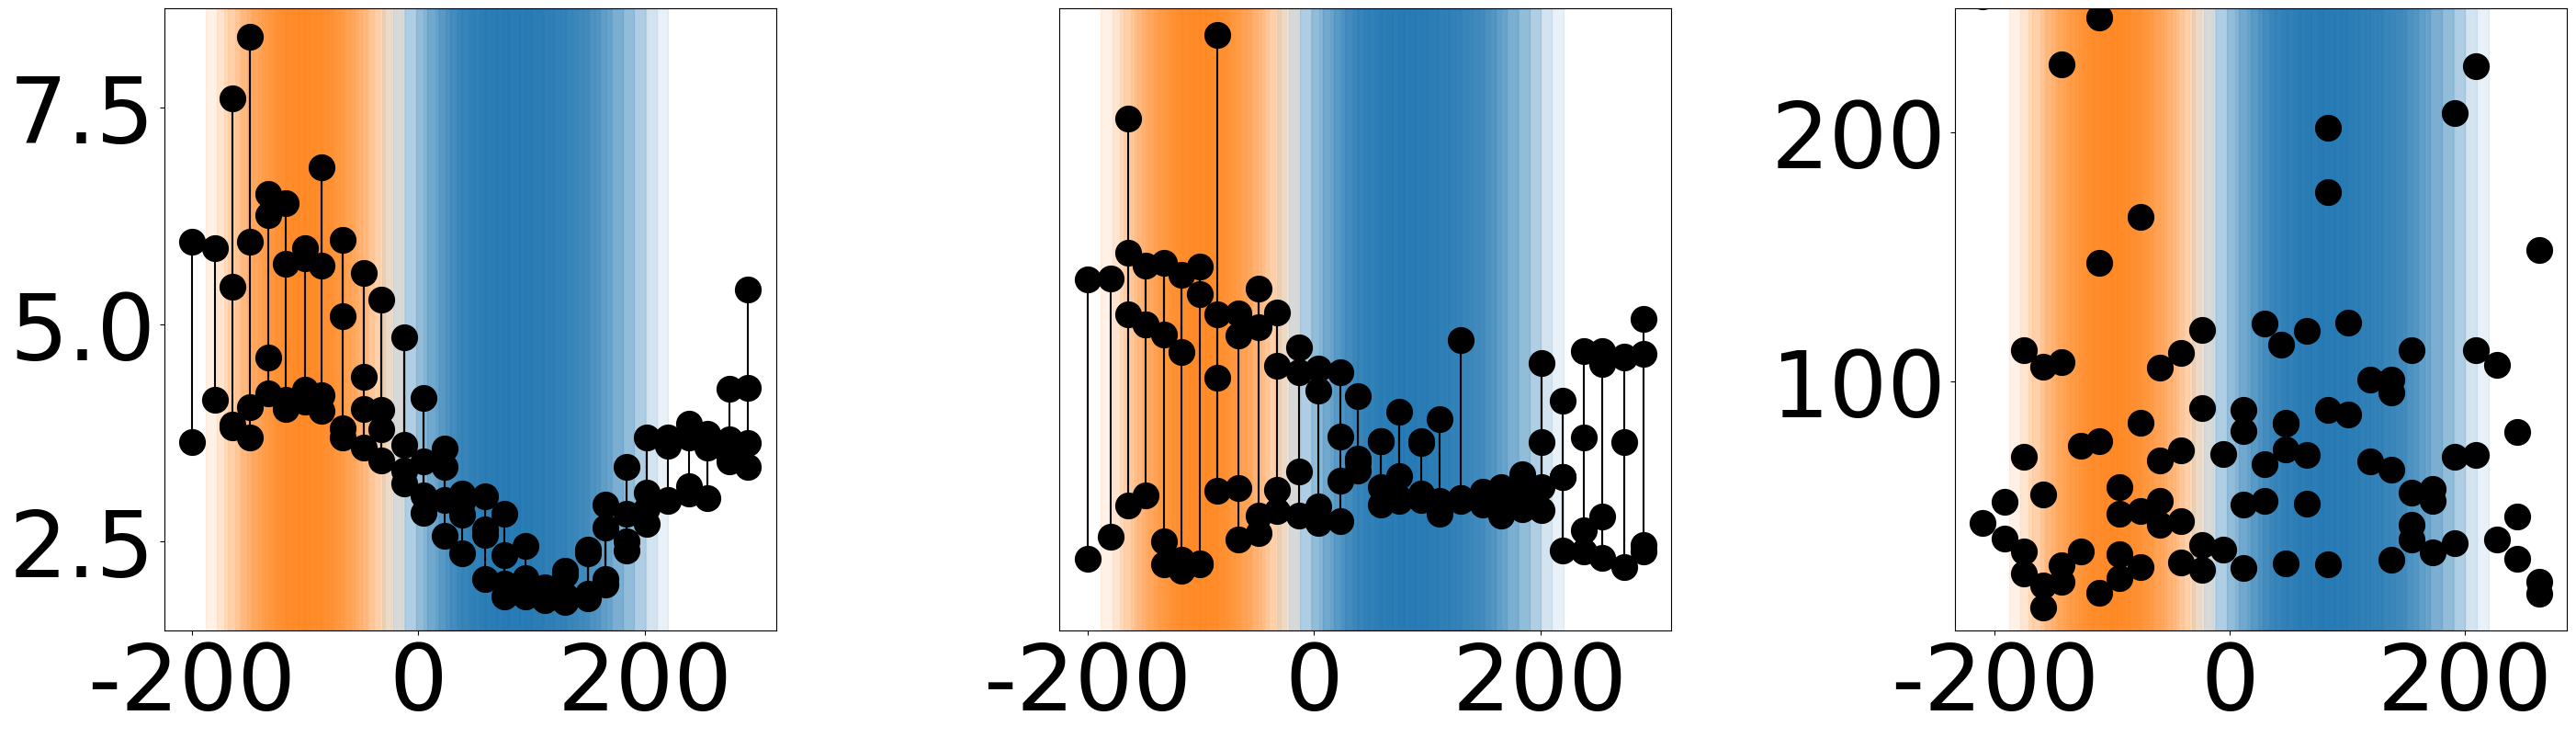

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
816  ACSF             410.364728              None              -61.434747
817  ACSF             392.671520              Home               85.197949
818  ACSF             374.950347              Home               68.462042
819  ACSF             357.013292              None              967.740094
820  ACSF             339.593970              Home              243.384672
821  ACSF             321.340120              Home               86.171008
822  ACSF             303.502721              Home               73.526147
823  ACSF             285.929972              None              163.850099
824  ACSF             268.070311              None              457.082054
825  ACSF             251.158275              None             -166.158496
826  ACSF             233.213158          Neighbor              -50.076915
827  ACSF             215.736314          Neighbor              -76.362947
828  ACSF             198

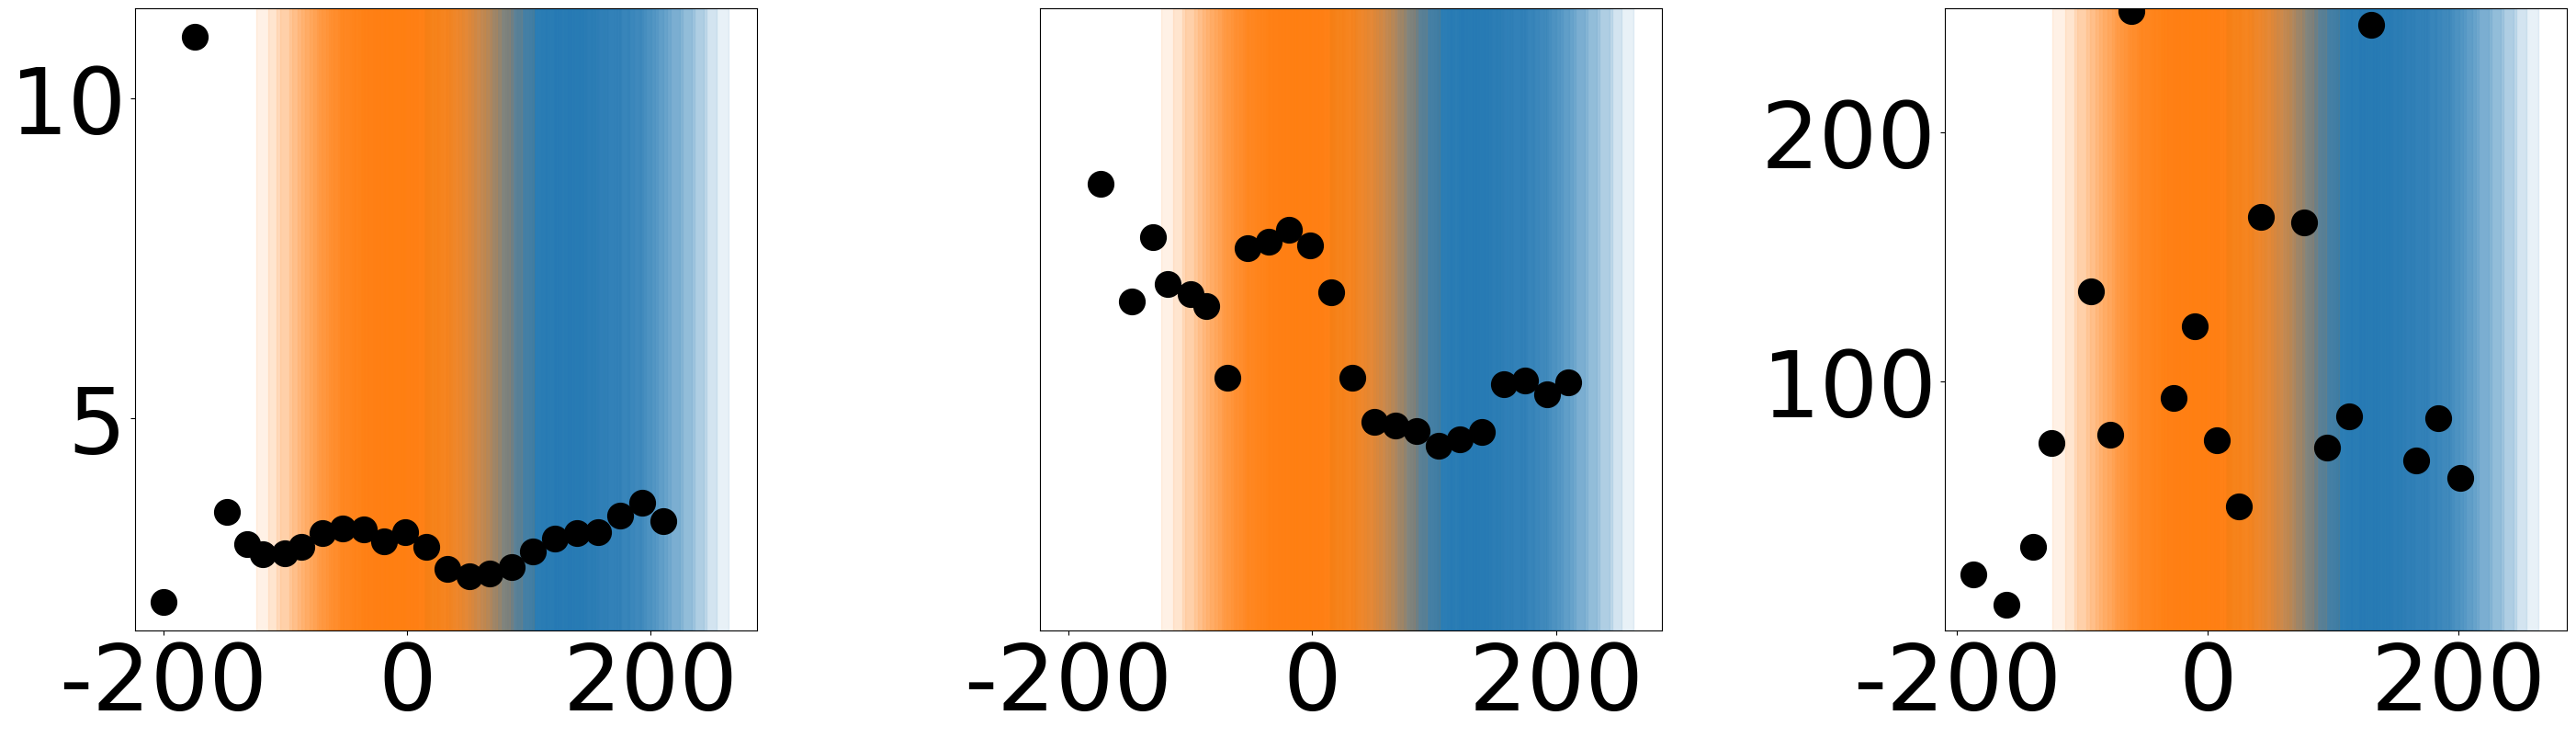

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
840  ACSF             392.159609              None               54.262767
841  ACSF             374.073829              None               52.137405
842  ACSF             356.070783              Home               95.269407
843  ACSF             338.169662              Home              623.620685
844  ACSF             320.458834              Home             -124.613359
845  ACSF             302.813583              Home              -73.675103
846  ACSF             284.917900              Home              -88.109731
847  ACSF             267.014003              Home             -168.806165
848  ACSF             249.221833              None             -141.538560
849  ACSF             231.090743              None              -26.192355
850  ACSF             213.238034              None              -28.036616
851  ACSF             195.482445          Neighbor              -44.005007
852  ACSF             178

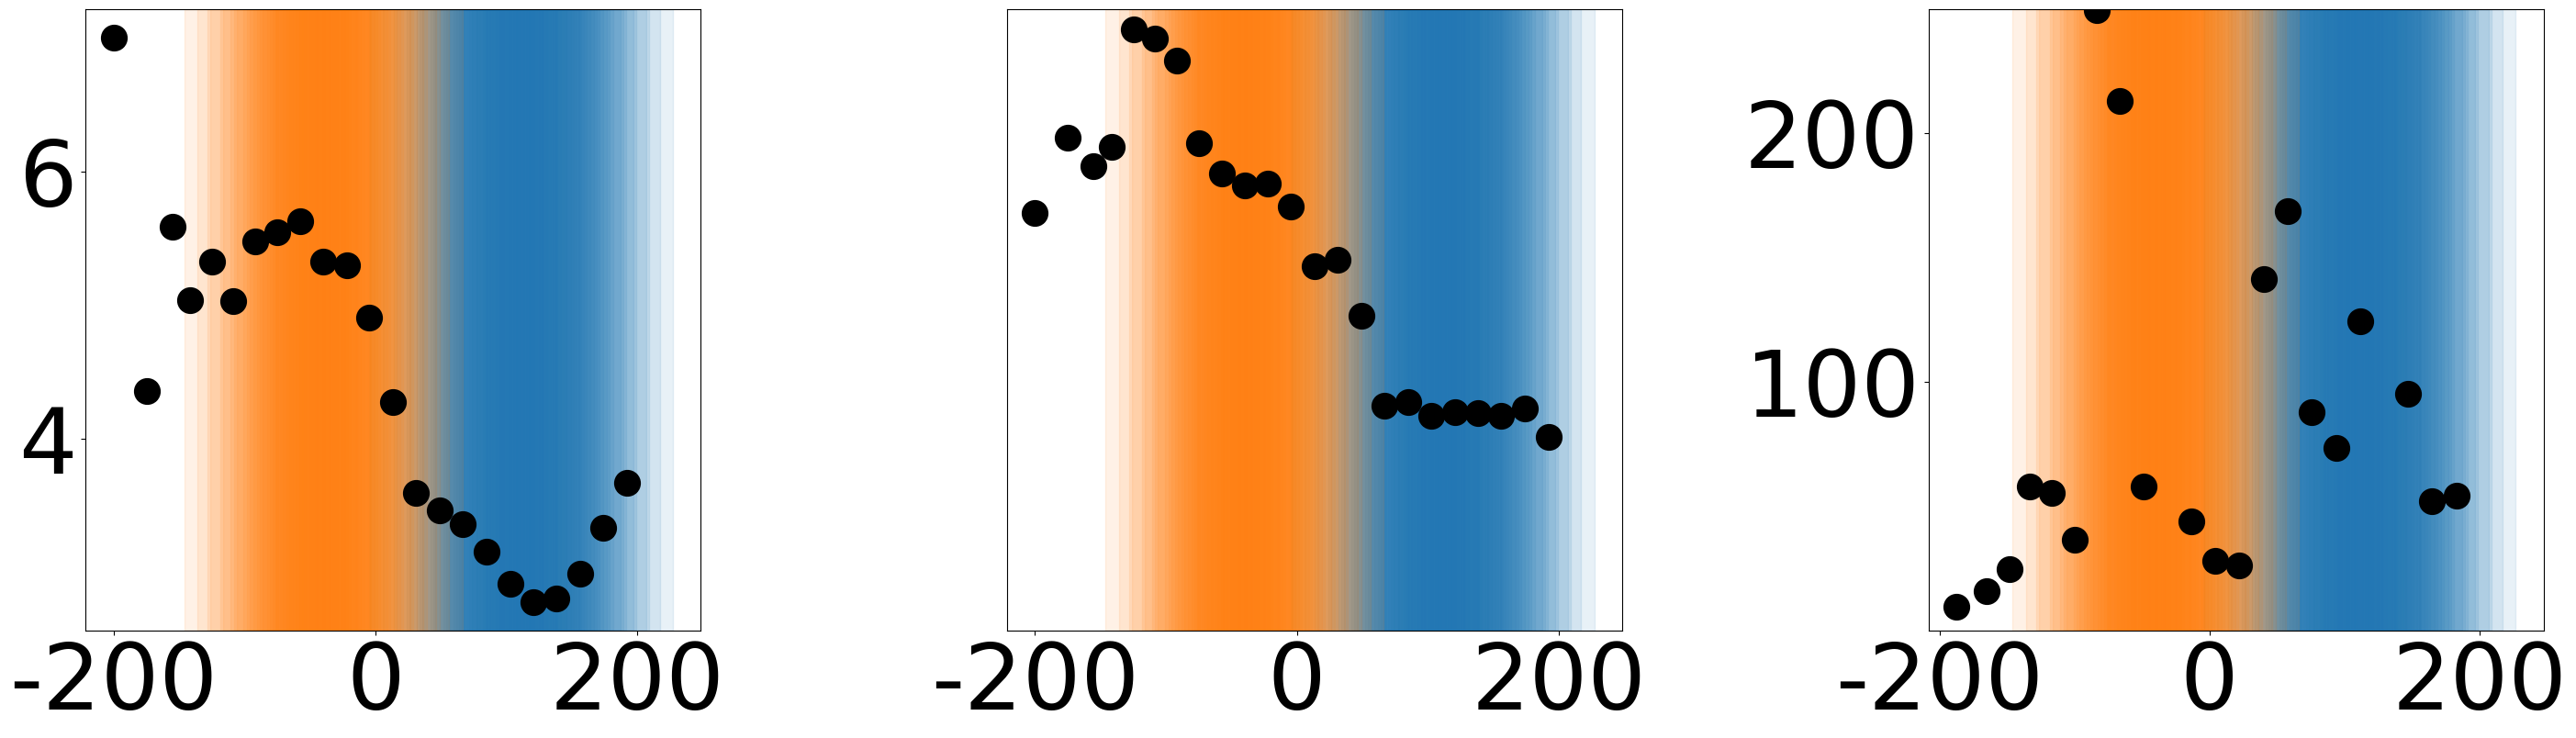

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
863  ACSF             462.354570              None              160.549588
864  ACSF             444.629896          Neighbor              105.483227
865  ACSF             426.739940          Neighbor              111.194832
866  ACSF             408.592944          Neighbor              142.117931
867  ACSF             390.728720          Neighbor               39.869698
868  ACSF             372.743499          Neighbor               77.191567
869  ACSF             354.842774              None              132.897490
870  ACSF             337.260437              Home               58.200065
871  ACSF             319.445397              Home             -212.508150
872  ACSF             301.679715              Home                     NaN
873  ACSF             283.808887              Home              238.949062
874  ACSF             266.150551              Home              -58.818587
875  ACSF             248

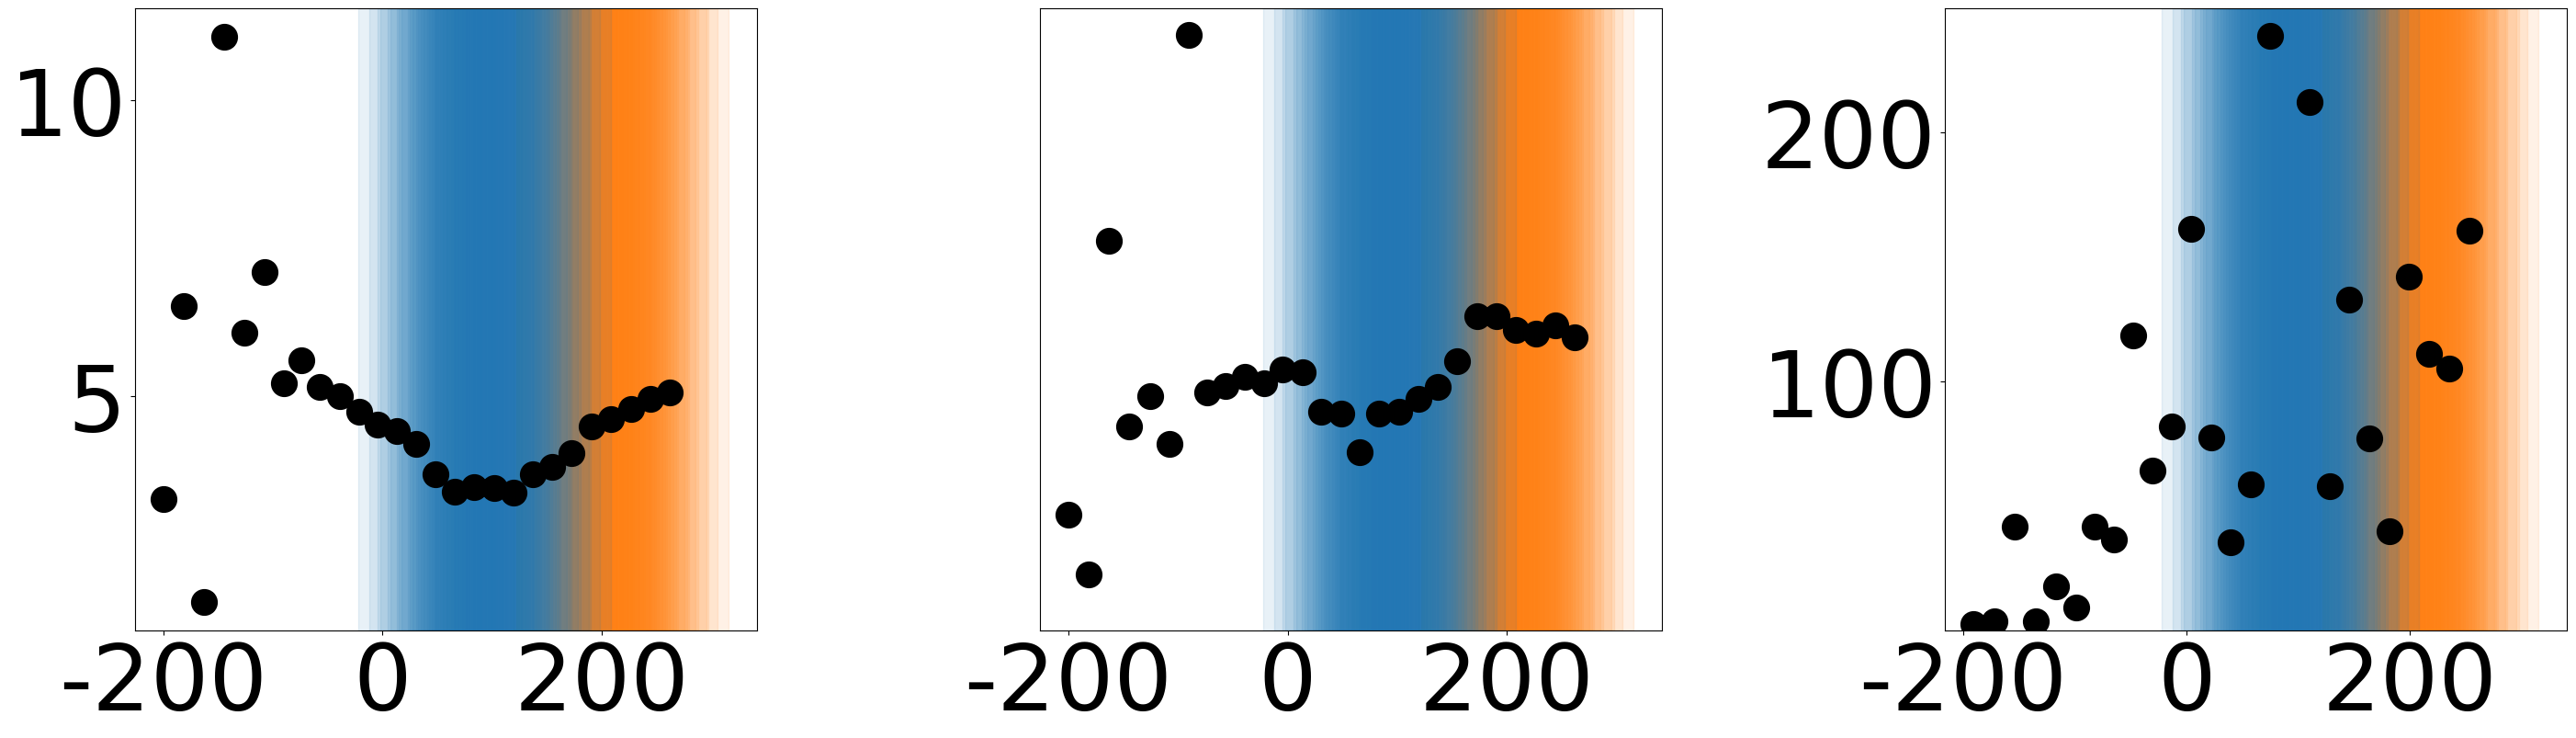

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
890  ACSF             470.905470          Neighbor               28.318103
891  ACSF             452.895157          Neighbor              230.710121
892  ACSF             435.130477          Neighbor               62.757864
893  ACSF             416.993454              None               31.551524
894  ACSF             398.882880              None               45.680315
895  ACSF             381.615721              Home               86.671713
896  ACSF             362.894631              Home             -936.496559
897  ACSF             345.101196              None              -66.649395
898  ACSF             327.305808              Home              -21.848482
899  ACSF             309.805173              Home              -39.880704
900  ACSF             292.855874              None              -38.940916
901  ACSF             274.125294              None              -52.526028
902  ACSF             256

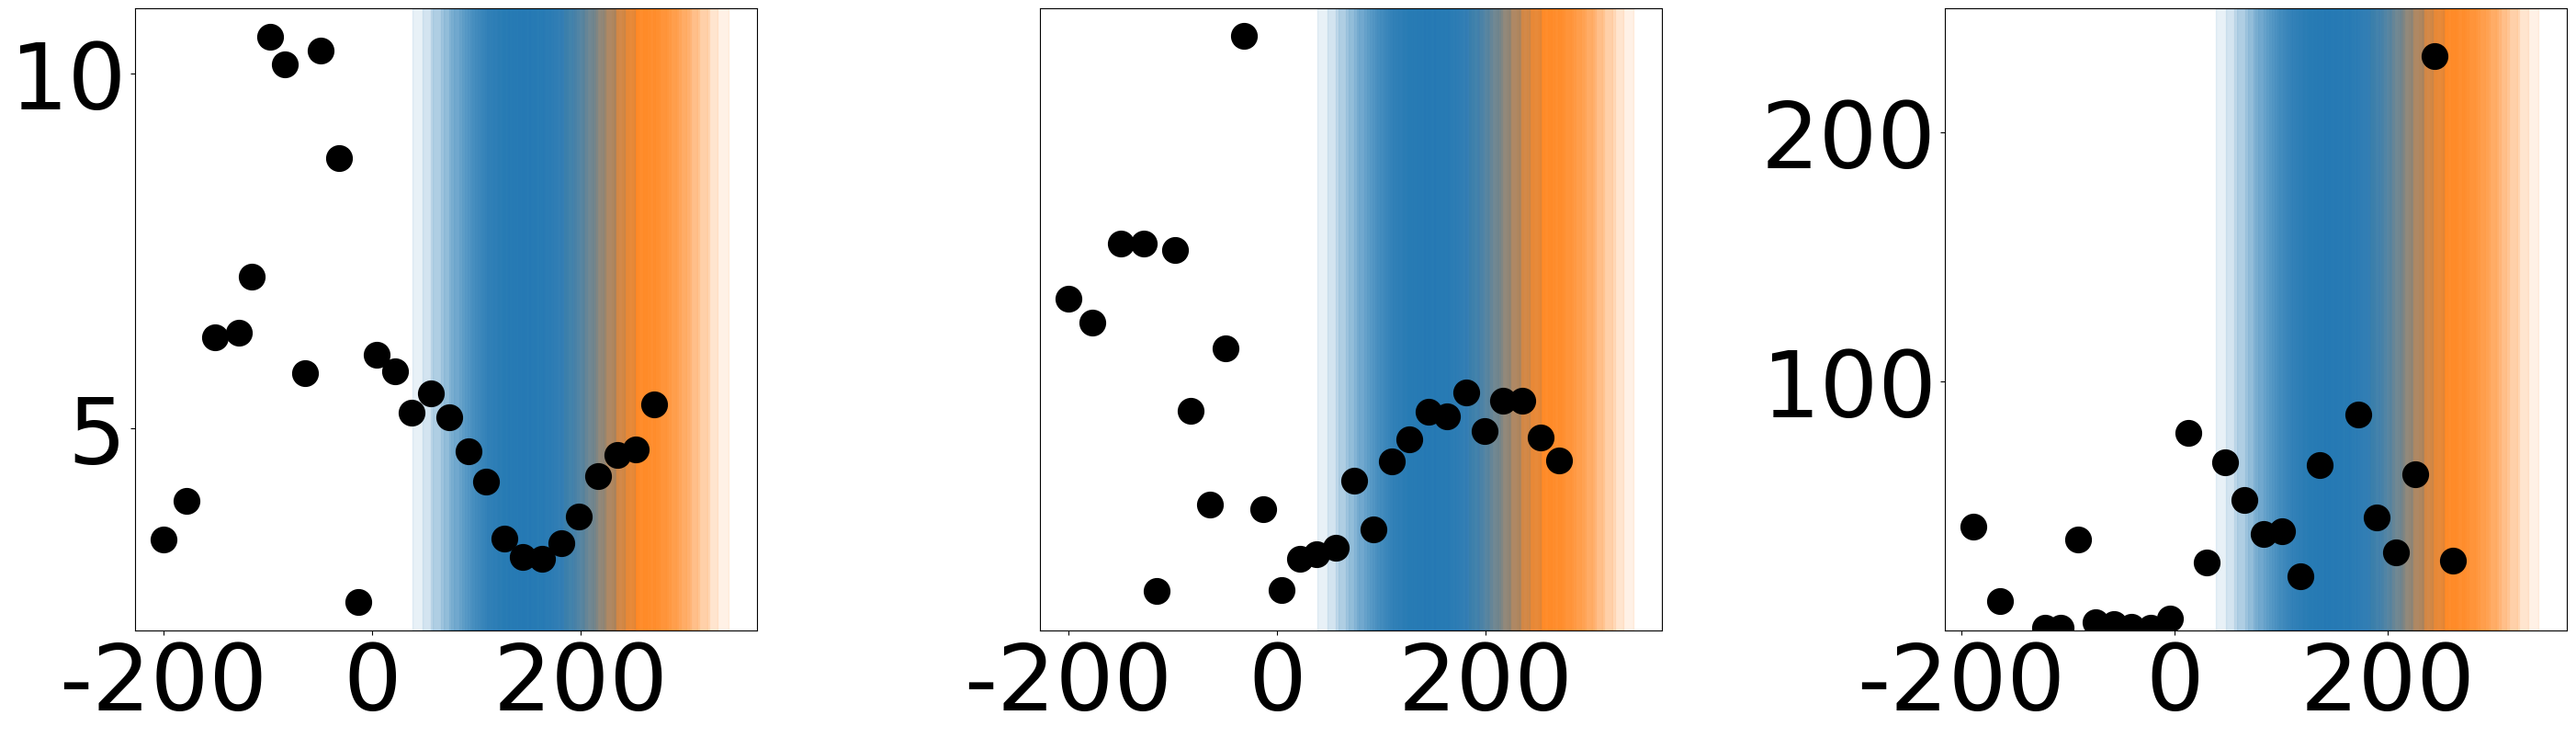

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
917  ACSF             453.013476              None               -4.363559
918  ACSF             434.446096              None                1.430055
919  ACSF             417.171747              None               -1.368952
920  ACSF             398.664068          Neighbor                7.206873
921  ACSF             380.777329          Neighbor                2.186355
922  ACSF             362.430964          Neighbor               -3.878768
923  ACSF             344.901647          Neighbor               -2.307966
924  ACSF             327.715838              None               -0.423159
925  ACSF             309.207633              None                     NaN
926  ACSF             291.049284              Home                     NaN
927  ACSF             272.736394              Home                     NaN
928  ACSF             256.347359              Home                     NaN
929  ACSF             237

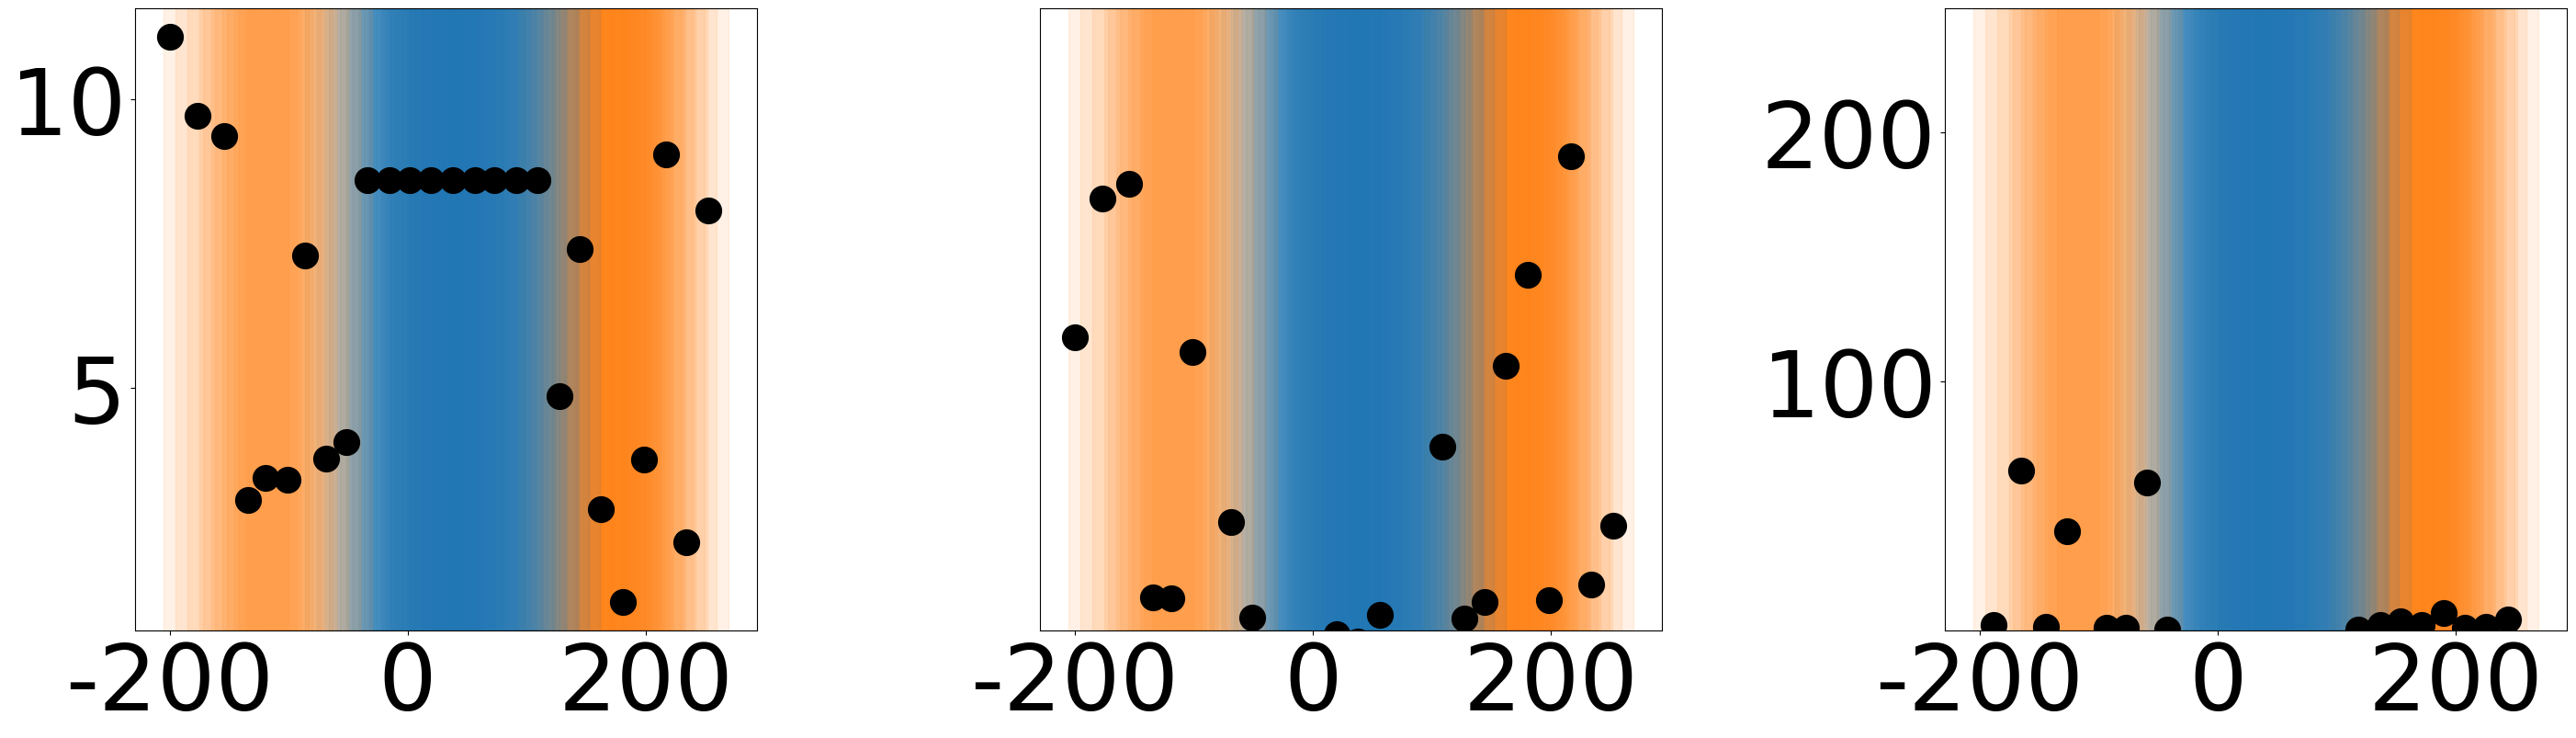

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

     drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
943  ACSF             458.705640              None               63.567541
944  ACSF             439.978643              None              -30.844204
945  ACSF             421.373419              None               70.349655
946  ACSF             403.863390              None               62.090581
947  ACSF             385.292097              None               73.391608
948  ACSF             367.333170              None              383.422680
949  ACSF             349.580700              None              127.387996
950  ACSF             332.676313              None               50.186159
951  ACSF             314.885320              Home               49.760326
952  ACSF             296.185390              Home               56.196786
953  ACSF             278.730668              Home             -910.900130
954  ACSF             259.966125              Home              -44.551156
955  ACSF             242

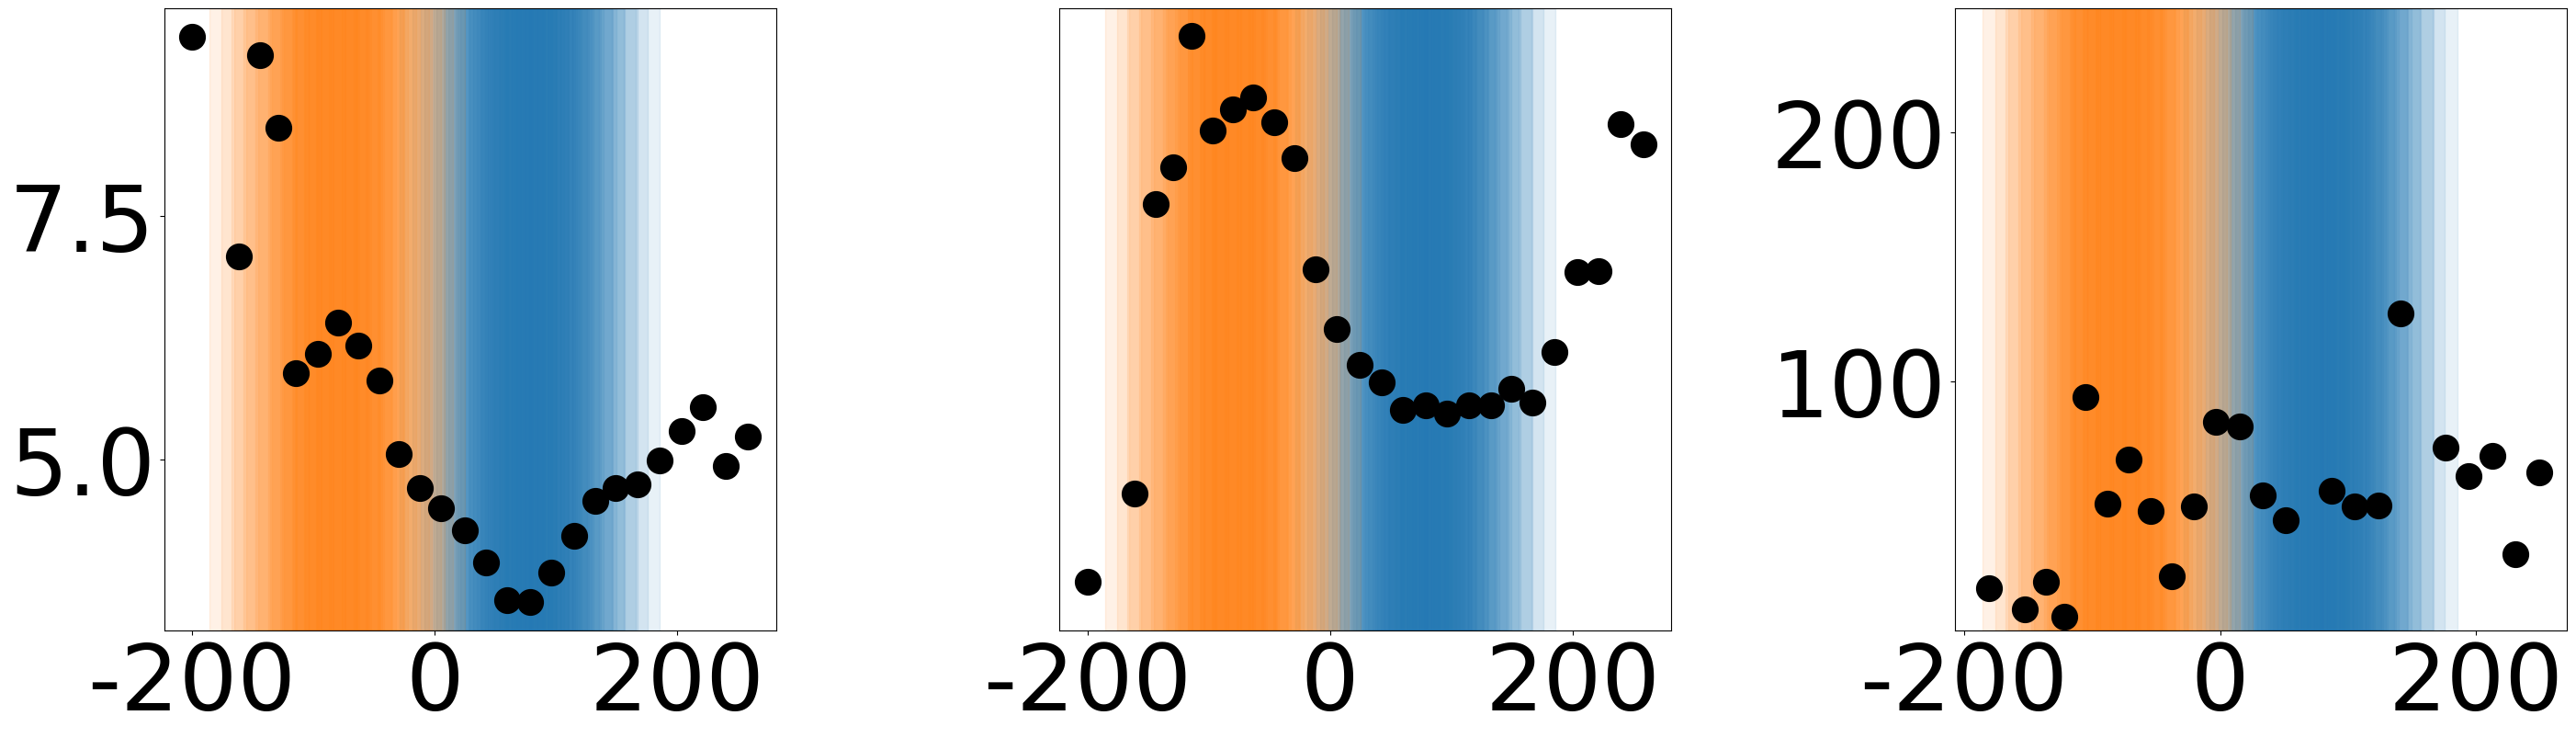

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1048  ACSF             439.063977              None              683.147273
1049  ACSF             421.438778              None              -67.729222
1050  ACSF             403.856272              None              123.426494
1051  ACSF             385.687892              None              275.355560
1052  ACSF             367.183998          Neighbor              164.866120
1053  ACSF             350.351167              None              198.799623
1054  ACSF             332.121242          Neighbor               64.298706
1055  ACSF             313.693233          Neighbor               66.281214
1056  ACSF             296.069058          Neighbor               64.805727
1057  ACSF             277.878090              None              223.002111
1058  ACSF             260.127122              None              222.889367
1059  ACSF             242.362840              None              251.034003
1060  ACSF  

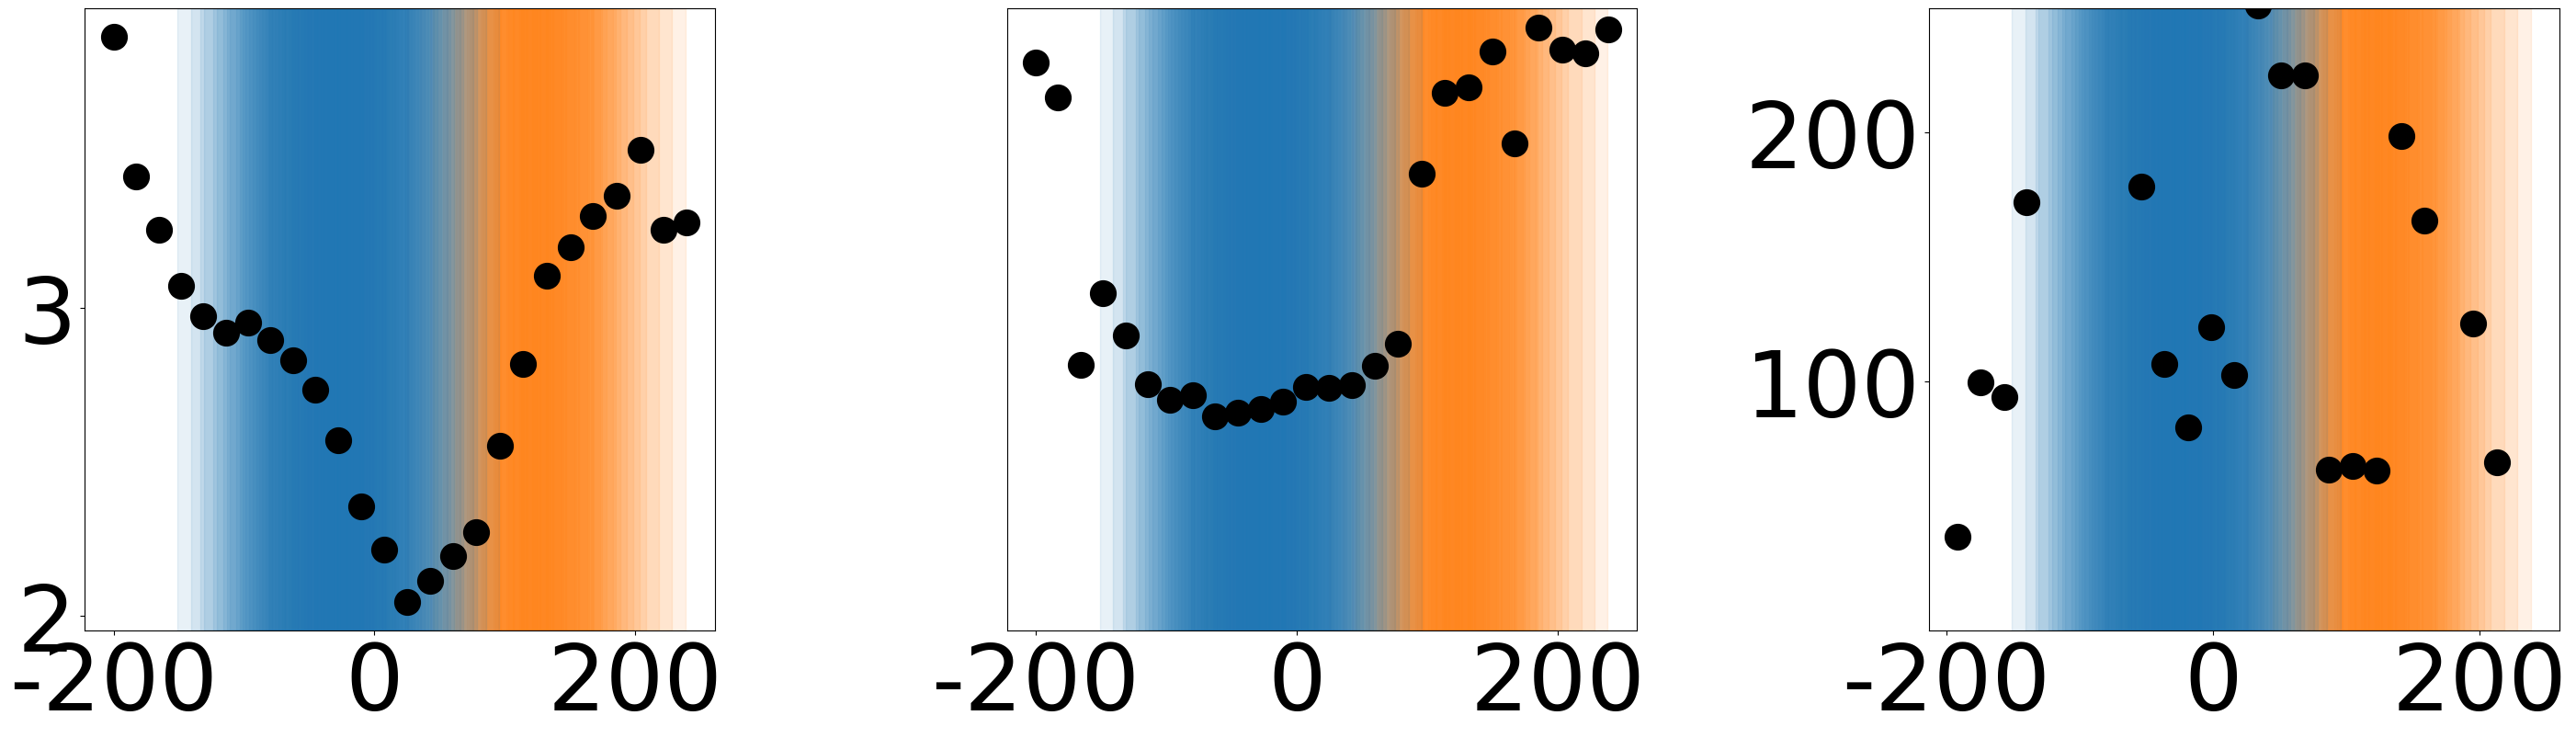

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1074  ACSF             395.166720              None              101.279220
1075  ACSF             377.544136              Home               83.082315
1076  ACSF             359.490349              Home               58.704520
1077  ACSF             341.972920              Home               50.380231
1078  ACSF             324.148394              Home               51.332454
1079  ACSF             306.212835              Home              294.692137
1080  ACSF             288.914406              Home              -74.675330
1081  ACSF             271.477717              None              -56.045842
1082  ACSF             254.473408              None             -106.265182
1083  ACSF             236.387074              None              -69.690609
1084  ACSF             218.790195              None              -62.183464
1085  ACSF             201.409917              None              -67.418648
1086  ACSF  

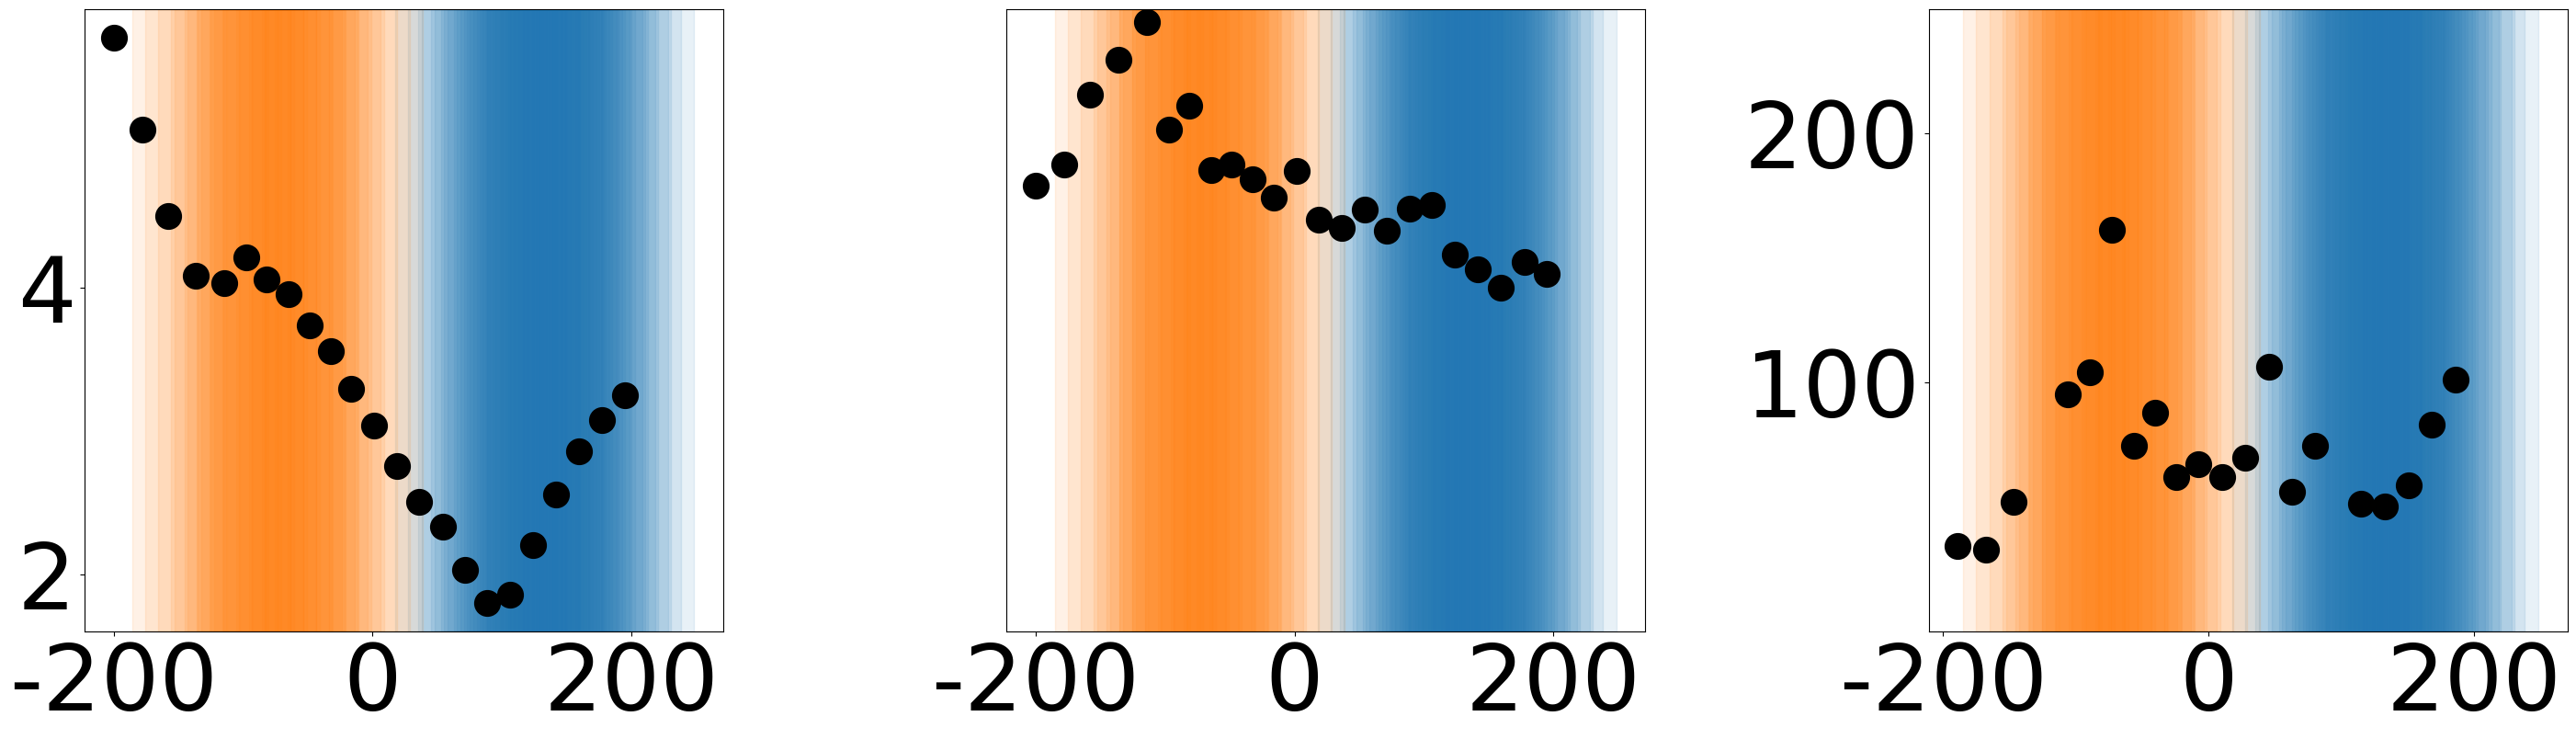

No ROI file found for  1/15/2025 1 1
      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1127  ACSF             430.427419              Home               30.489172
1128  ACSF             412.265019              Home               45.434066
1129  ACSF             394.123196              Home               63.925904
1130  ACSF             376.377365              None              126.343687
1131  ACSF             358.411293              Home              266.580623
1132  ACSF             340.577049              None             2319.458157
1133  ACSF             322.949167              Home             -462.113720
1134  ACSF             305.157789              Home             -148.042895
1135  ACSF             287.466663              Home             -110.294789
1136  ACSF             270.006998              Home              -95.442460
1137  ACSF             251.710678              None              -89.840422
1138  ACSF             234.281637              None

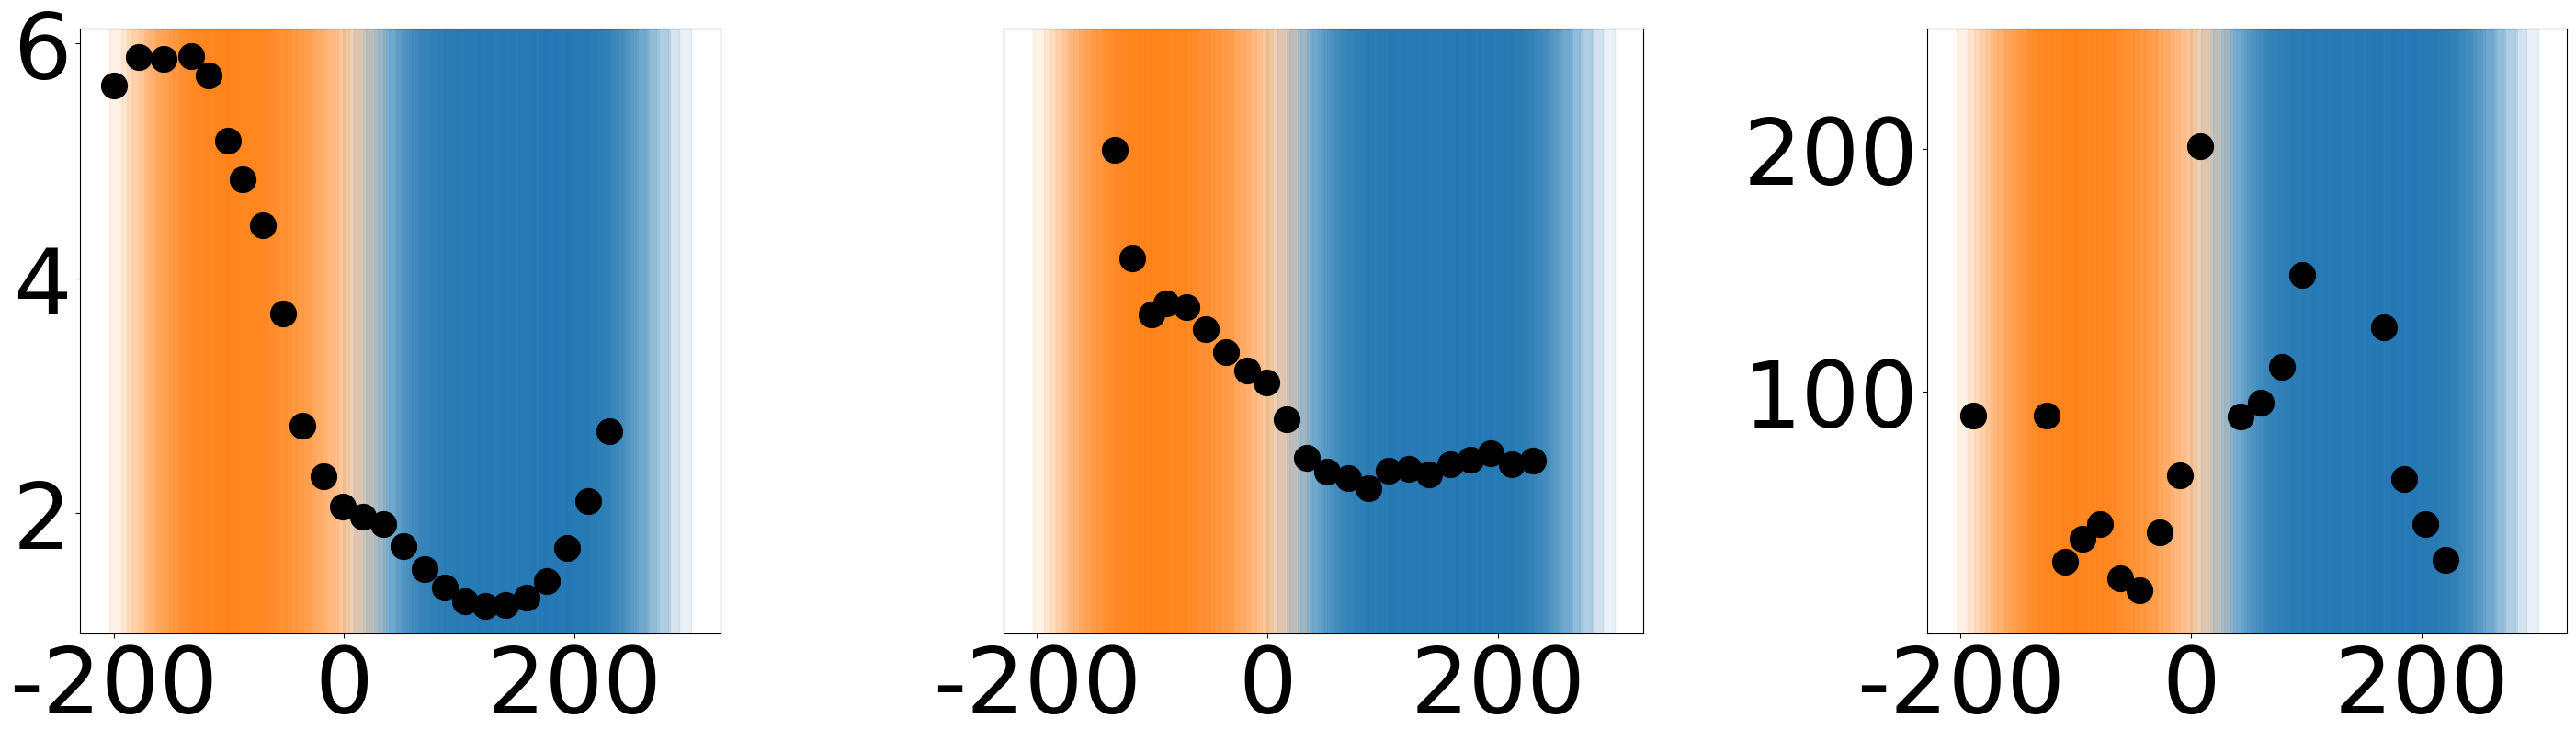

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1152  ACSF             461.671702              None             1158.692911
1153  ACSF             443.248484              None              156.912795
1154  ACSF             425.250587              None             -700.217533
1155  ACSF             408.235301          Neighbor              255.995785
1156  ACSF             389.803604          Neighbor              335.966529
1157  ACSF             372.467731          Neighbor              119.142355
1158  ACSF             353.964924              None              102.612907
1159  ACSF             335.648520          Neighbor              182.800961
1160  ACSF             317.971667          Neighbor              125.565915
1161  ACSF             299.902732              None             -945.081964
1162  ACSF             281.946174              None             -360.217729
1163  ACSF             264.007331              None                     NaN
1164  ACSF  

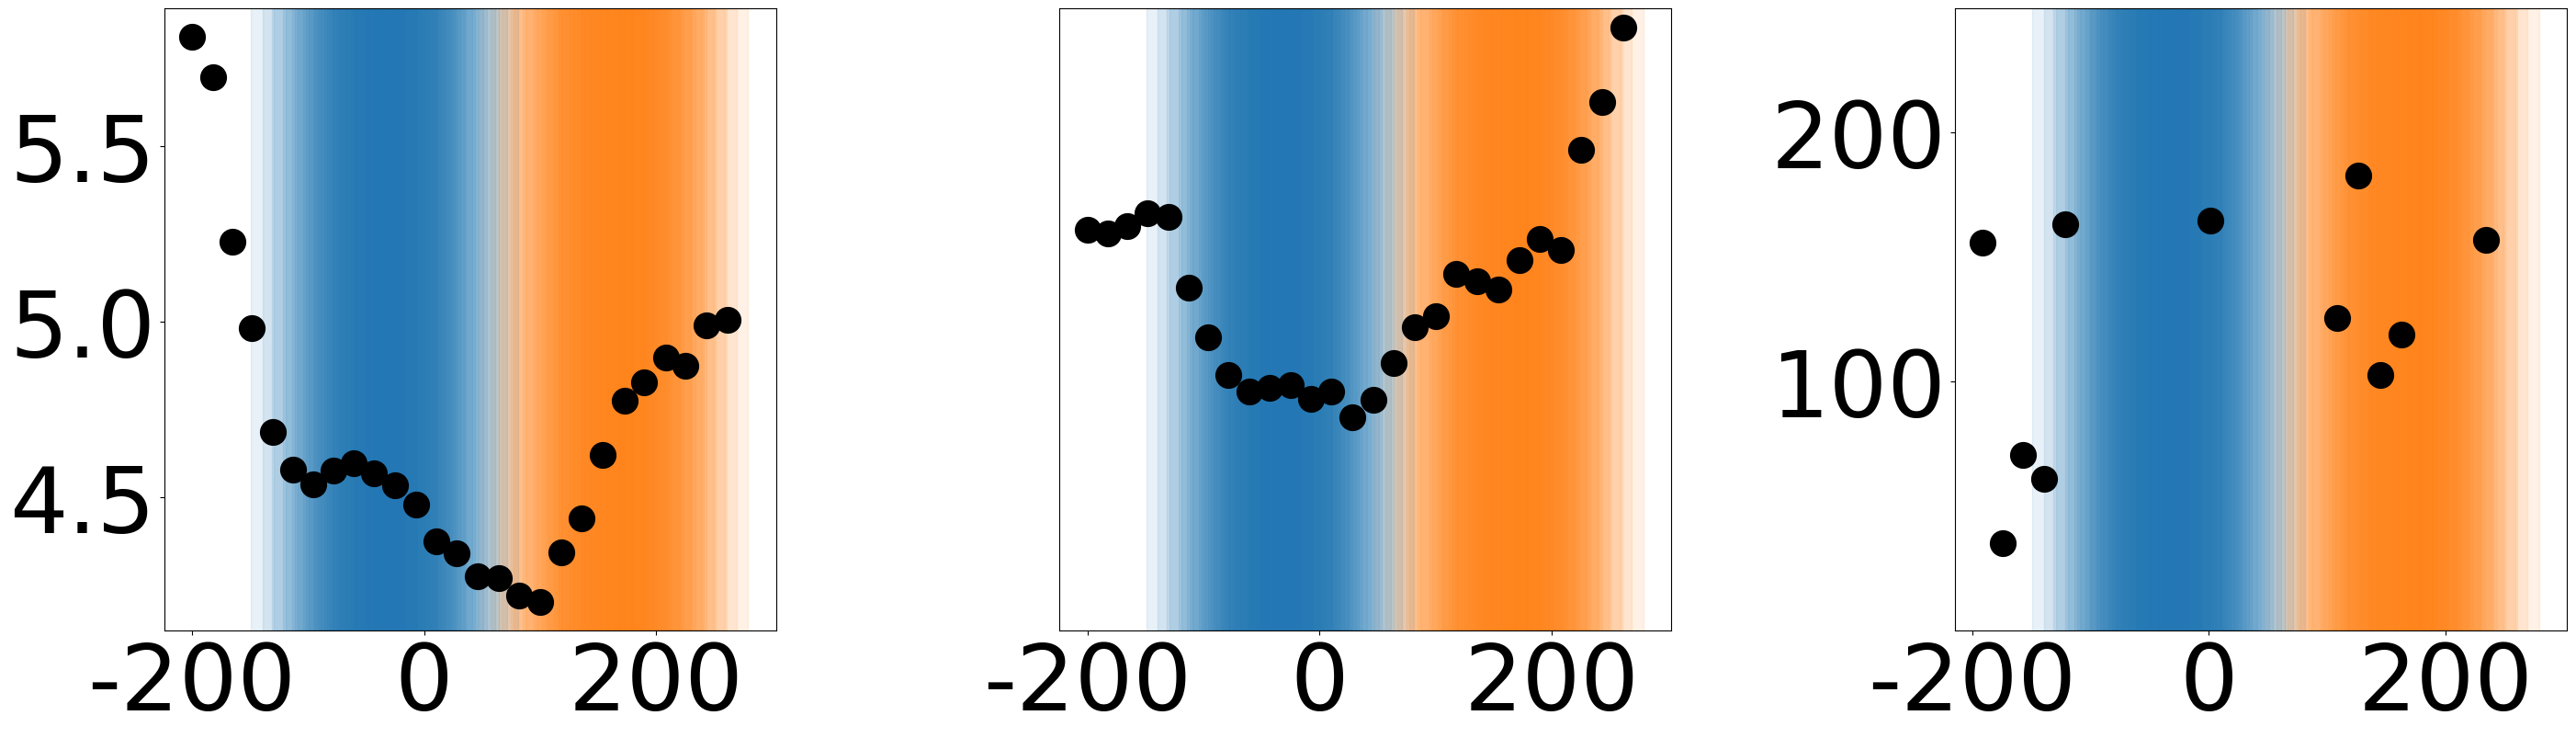

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1179  ACSF             395.851117              None               59.992779
1180  ACSF             377.853283              None              -34.210721
1181  ACSF             359.721601          Neighbor               99.448681
1182  ACSF             341.820838          Neighbor              102.273456
1183  ACSF             323.922983          Neighbor              109.085955
1184  ACSF             305.923801          Neighbor              116.123099
1185  ACSF             287.924720          Neighbor               24.455106
1186  ACSF             269.925763              None              109.117144
1187  ACSF             251.812317              None               73.770492
1188  ACSF             233.812317              None              189.473684
1189  ACSF             215.812317              None              610.881590
1190  ACSF             198.096751              None               53.227564
1191  ACSF  

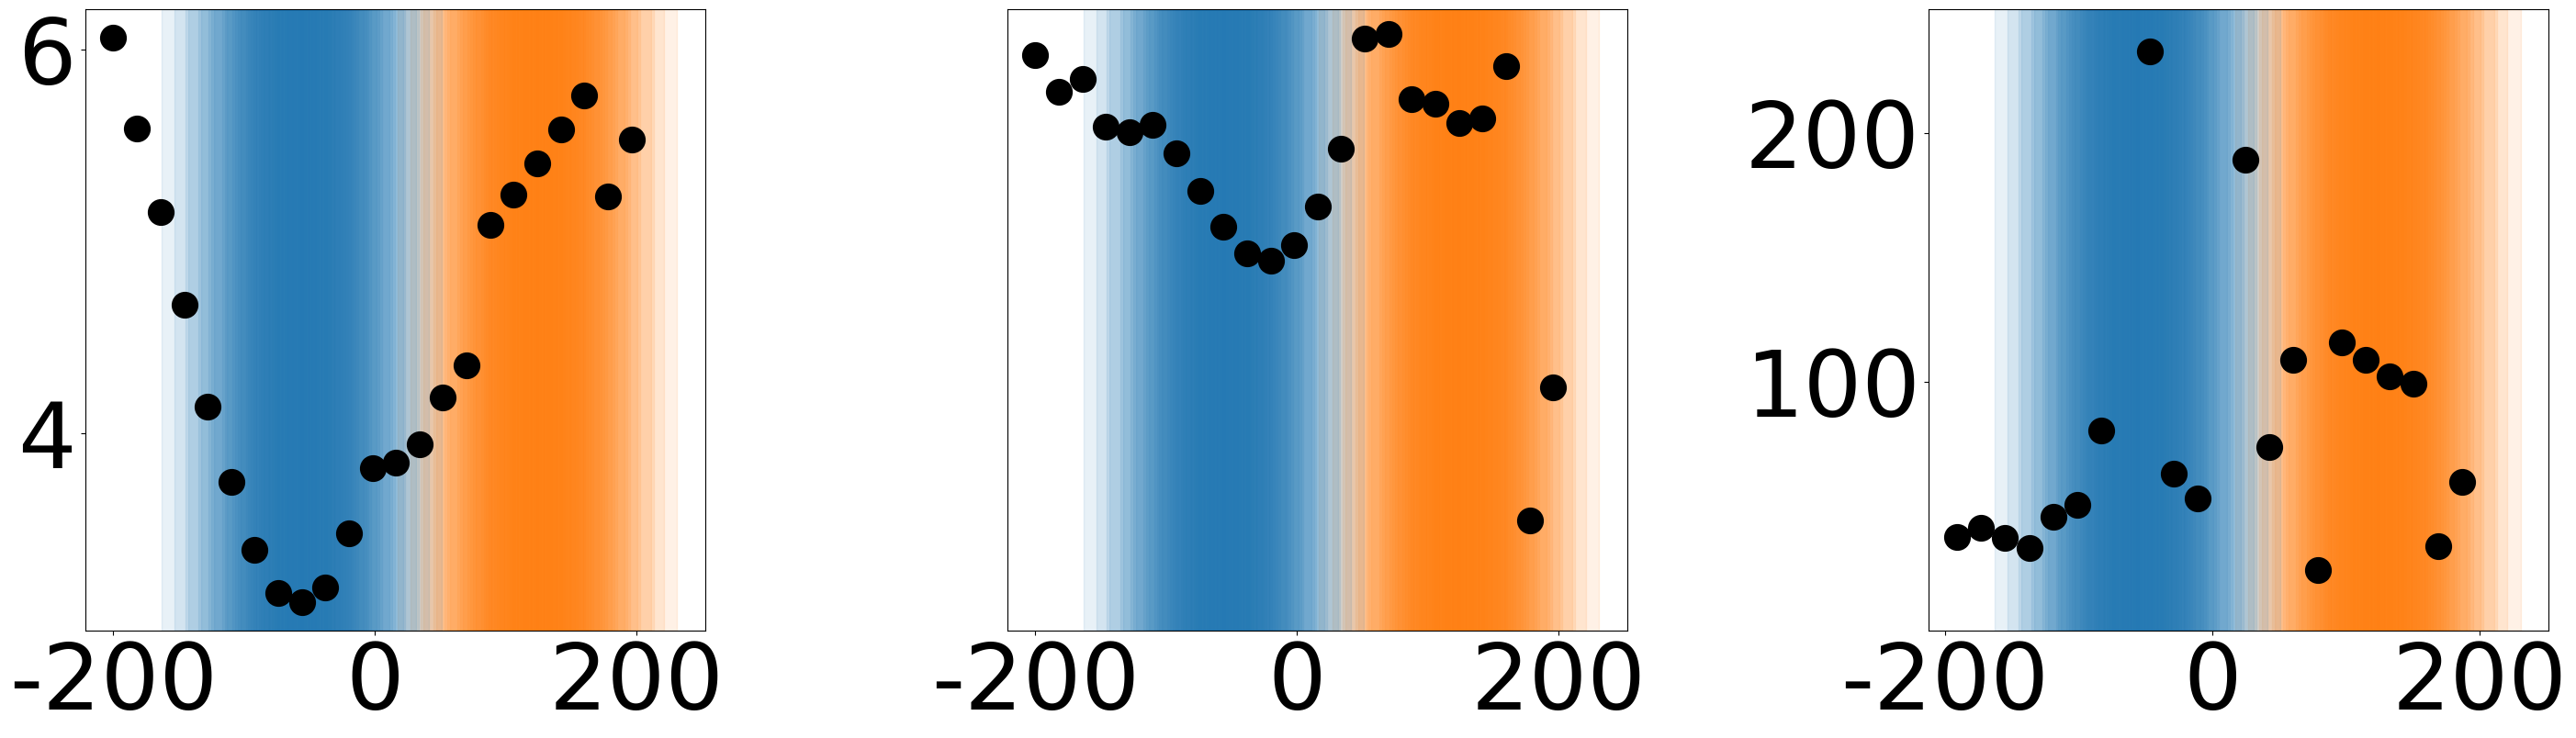

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1202  ACSF             468.596040              None               56.078767
1203  ACSF             450.706914          Neighbor              -21.660618
1204  ACSF             433.053510          Neighbor               30.540903
1205  ACSF             415.217623          Neighbor               39.009873
1206  ACSF             396.882982              None               58.002668
1207  ACSF             378.960158          Neighbor                     NaN
1208  ACSF             361.082200          Neighbor               92.597023
1209  ACSF             343.210975              None              229.659985
1210  ACSF             325.067836              None              231.574764
1211  ACSF             306.773430              None              461.508813
1212  ACSF             289.236095              None              585.456989
1213  ACSF             271.672385              None              303.662140
1214  ACSF  

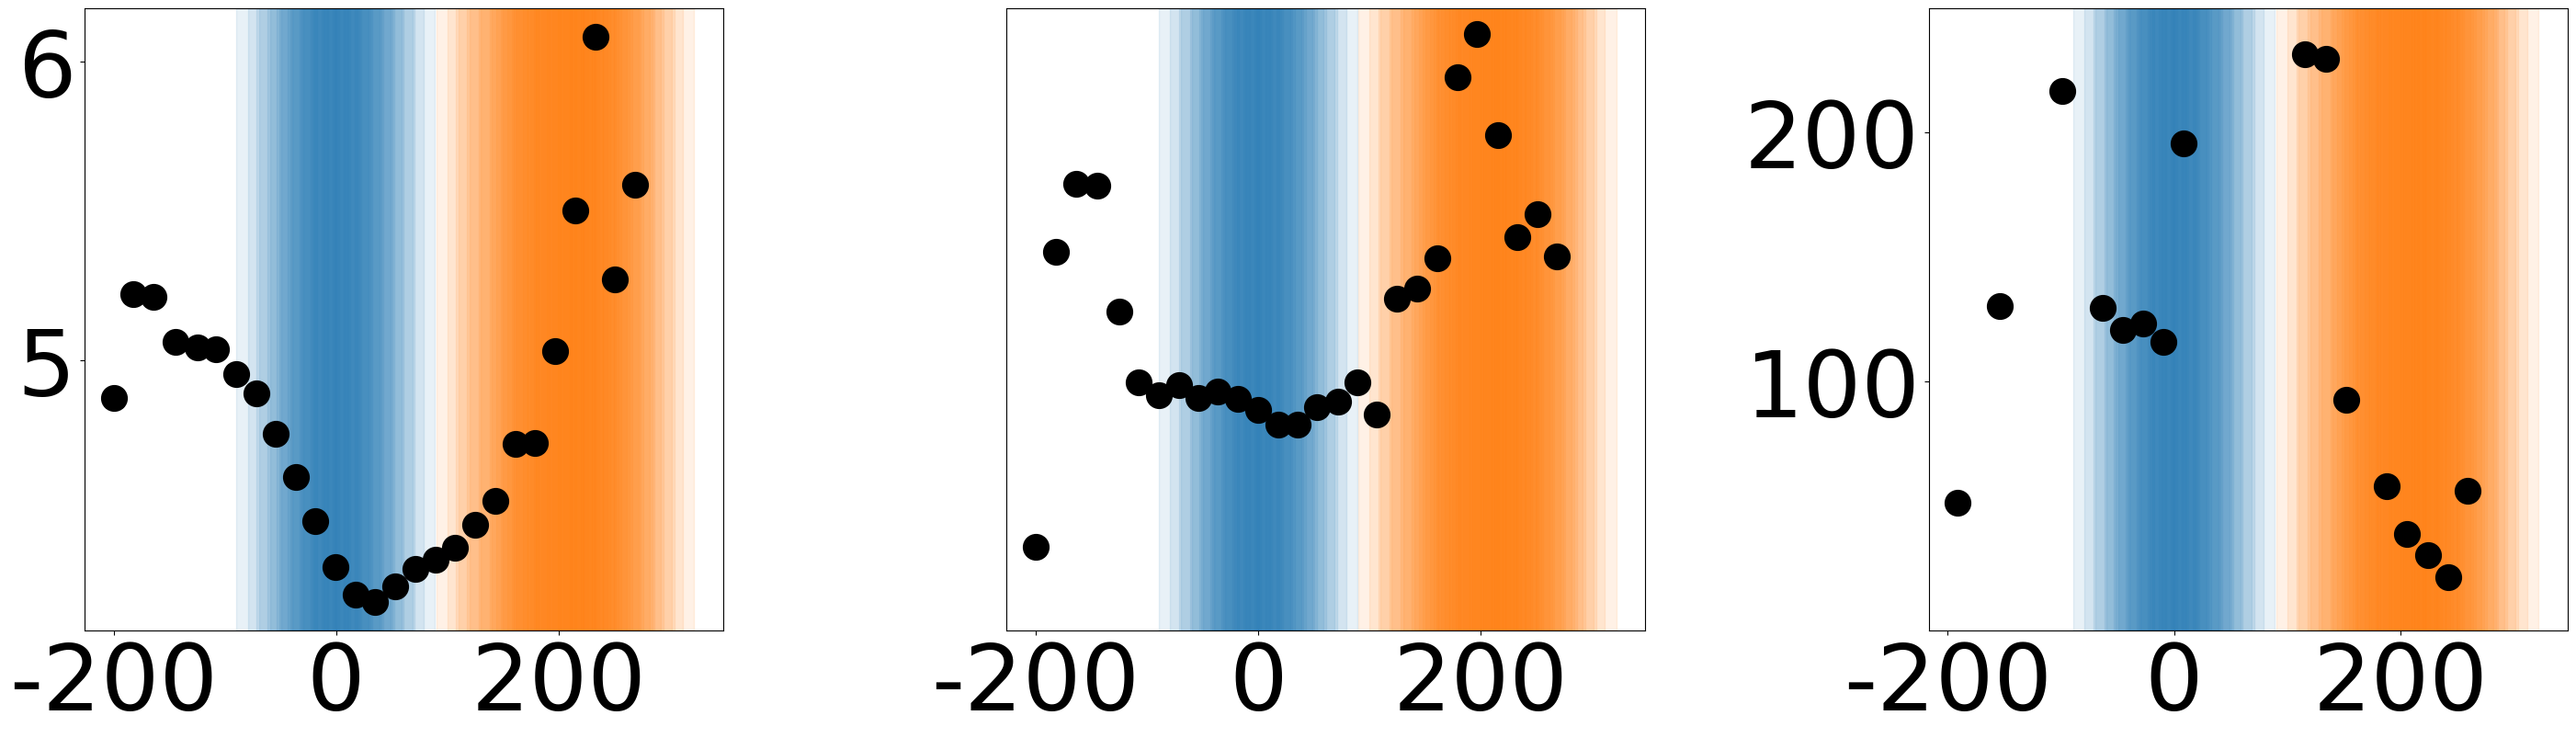

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1229  ACSF             493.782255              Home               41.987869
1230  ACSF             476.487451              Home               53.542933
1231  ACSF             457.983014              None               51.899616
1232  ACSF             438.863195              None              108.352157
1233  ACSF             422.523690              None              949.462880
1234  ACSF             403.629379              None              -87.008395
1235  ACSF             385.984076              None                     NaN
1236  ACSF             368.031629              None               92.926709
1237  ACSF             349.743653          Neighbor               88.445770
1238  ACSF             333.107004          Neighbor              100.744989
1239  ACSF             314.287840          Neighbor              212.072722
1240  ACSF             297.428058          Neighbor             -123.139348
1241  ACSF  

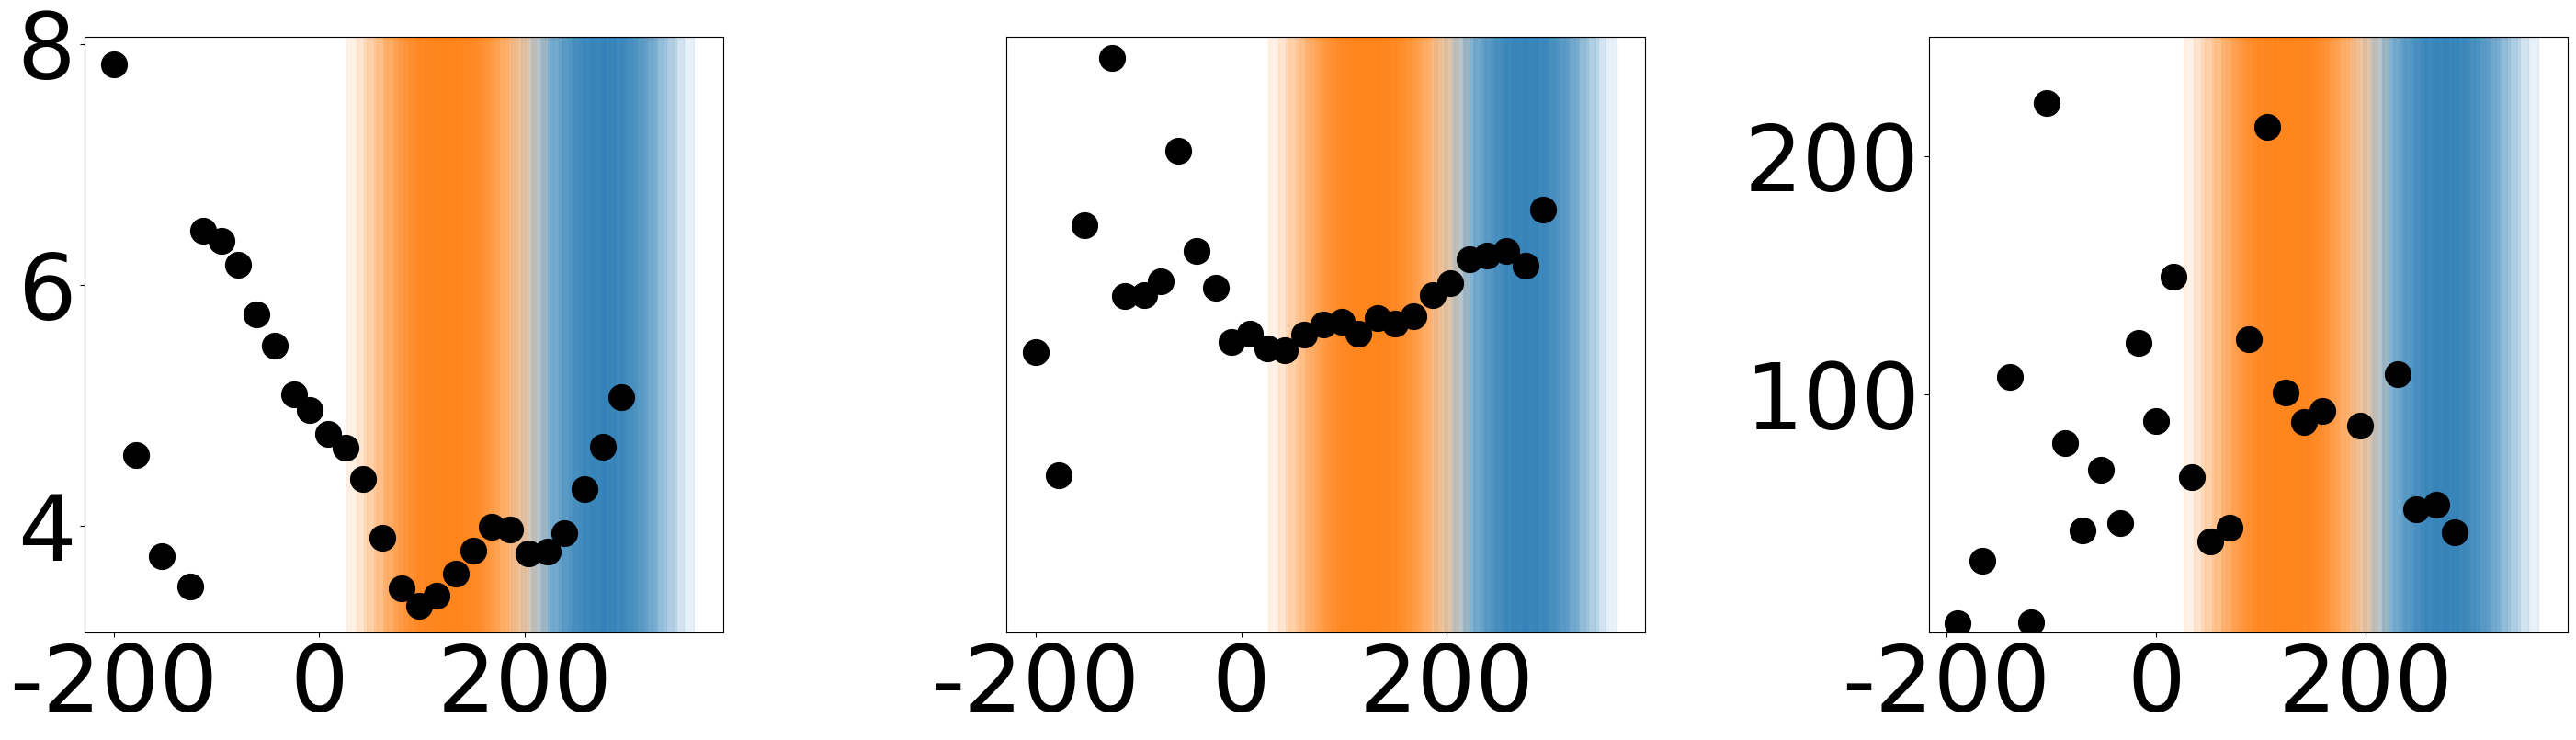

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1257  ACSF             387.382053              None               11.216218
1258  ACSF             371.152186              None               38.018967
1259  ACSF             352.941101              None                5.420519
1260  ACSF             336.338052              None               90.716170
1261  ACSF             318.285534              None              267.904587
1262  ACSF             298.996404              None              108.198819
1263  ACSF             280.386207          Neighbor               57.771616
1264  ACSF             264.036840          Neighbor               63.825896
1265  ACSF             246.484718          Neighbor               48.576880
1266  ACSF             230.114310          Neighbor               49.581323
1267  ACSF             212.612103              None               83.083709
1268  ACSF             196.161528              None               57.200383
1269  ACSF  

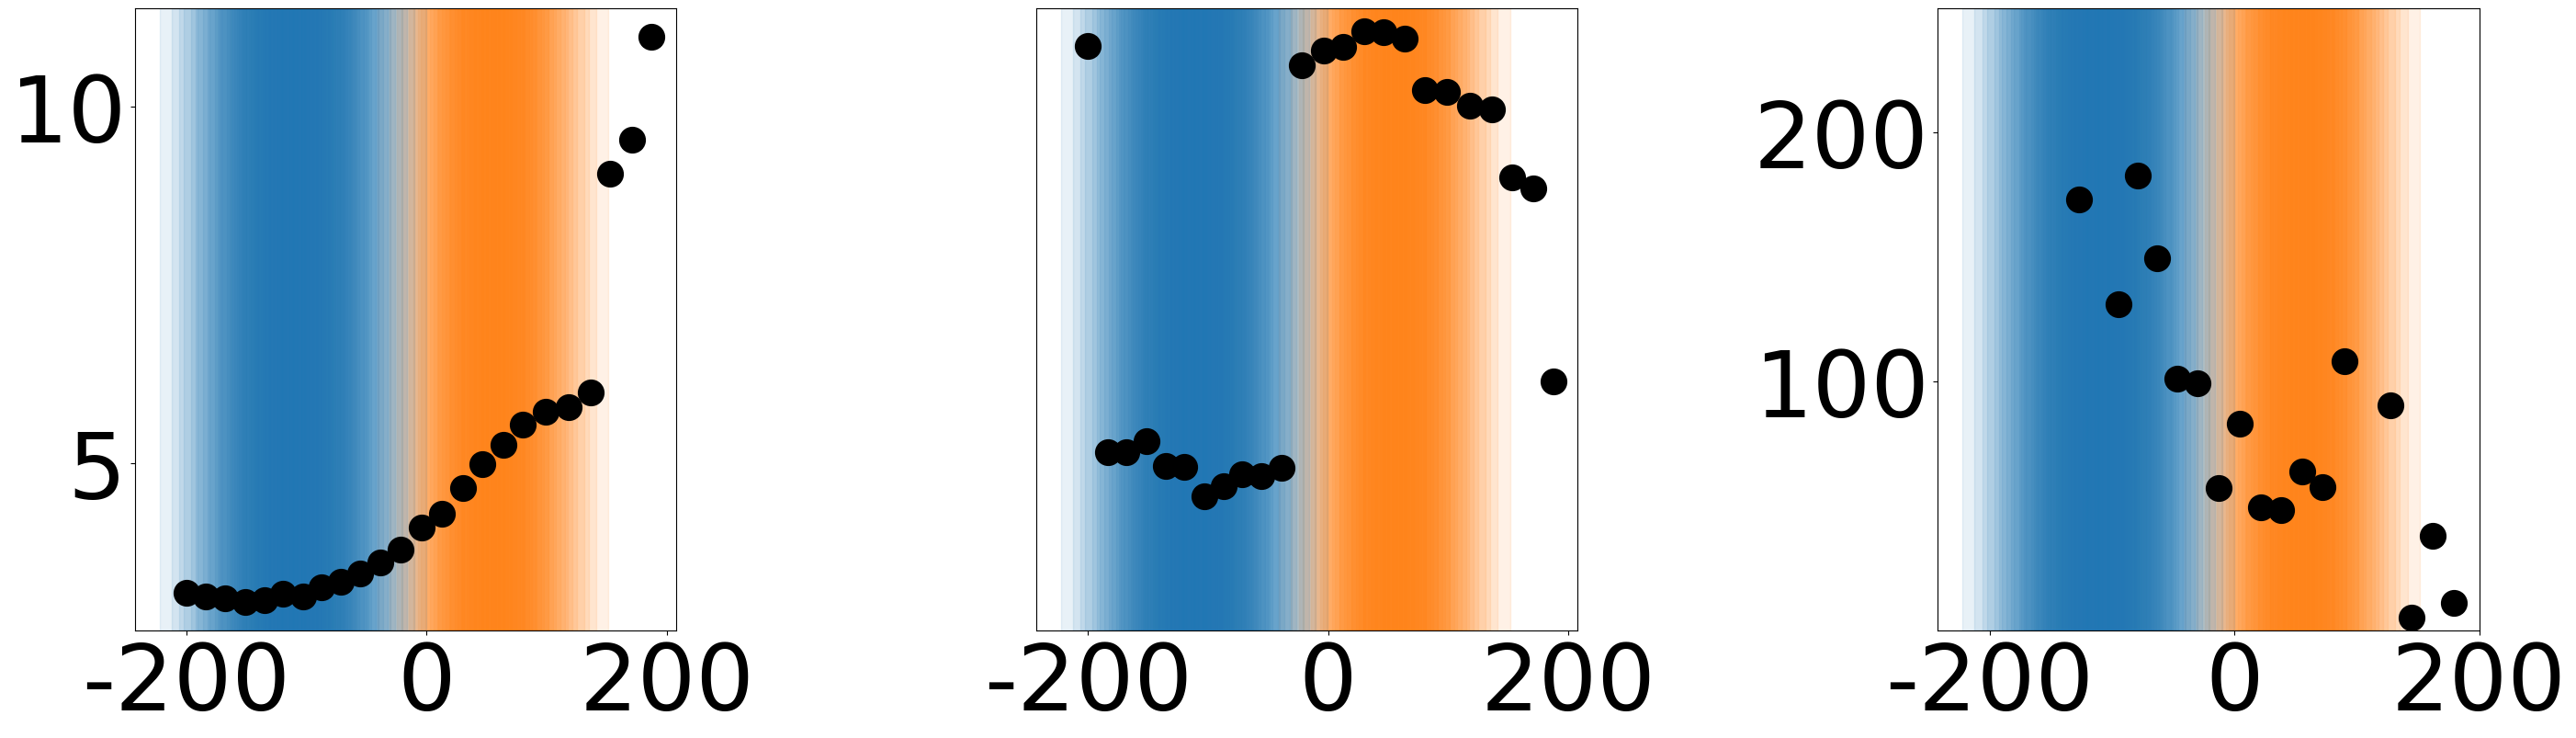

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1281  ACSF             433.249520              None              108.670468
1282  ACSF             415.797043              None               50.336406
1283  ACSF             397.399086              None               62.547784
1284  ACSF             380.160917              None               89.698044
1285  ACSF             361.871486              None              236.142454
1286  ACSF             343.759360              None             -847.231139
1287  ACSF             326.306398              Home             -150.020164
1288  ACSF             308.469001              None              -90.209234
1289  ACSF             290.246736              Home              -43.973583
1290  ACSF             273.527979              Home              -82.739971
1291  ACSF             255.242446              Home             -120.183151
1292  ACSF             236.590021              None              -89.607259
1293  ACSF  

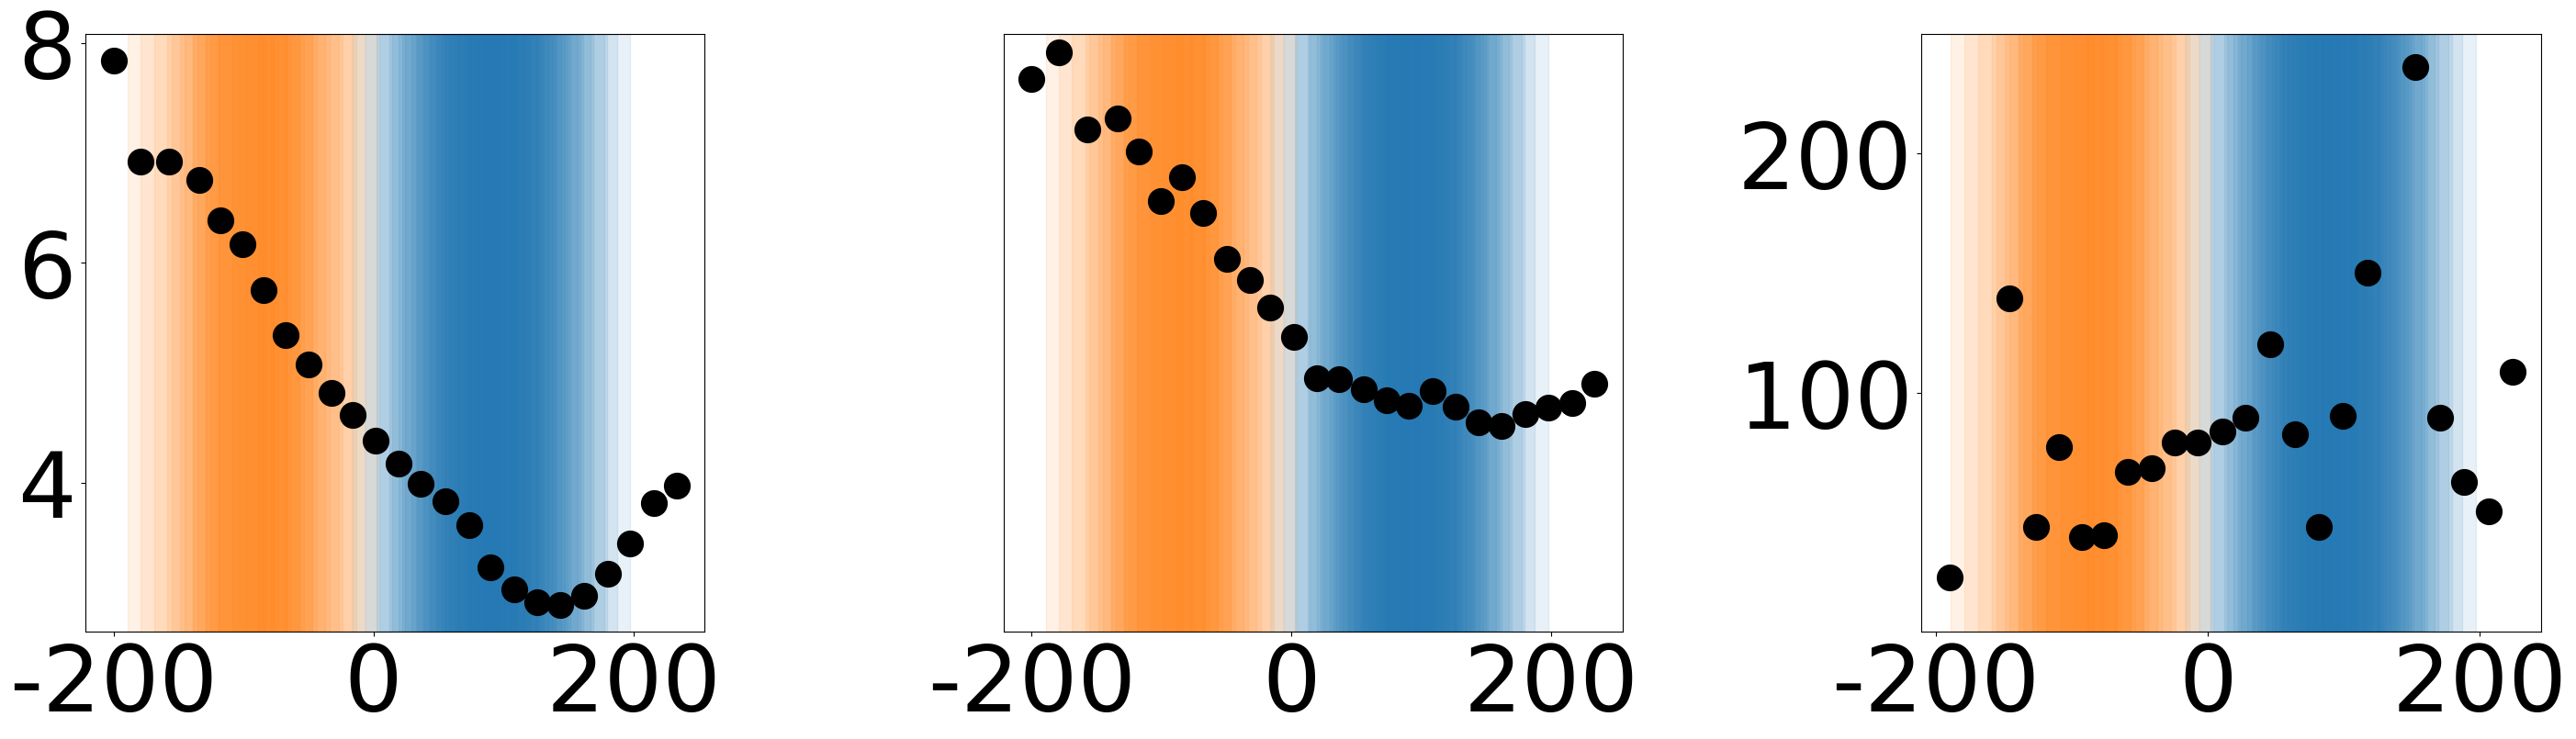

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1306  ACSF                  414.0          Neighbor               70.866142
1307  ACSF                  396.0          Neighbor               65.454545
1308  ACSF                  378.0              None              110.429448
1309  ACSF                  360.0          Neighbor              104.046243
1310  ACSF                  342.0              None              131.386861
1311  ACSF                  324.0              None              117.647059
1312  ACSF                  306.0              None              105.263158
1313  ACSF                  288.0              None               98.901099
1314  ACSF                  270.0              None               84.905660
1315  ACSF                  252.0              Home               62.068966
1316  ACSF                  234.0              Home               48.257373
1317  ACSF                  216.0              Home               85.714286
1318  ACSF  

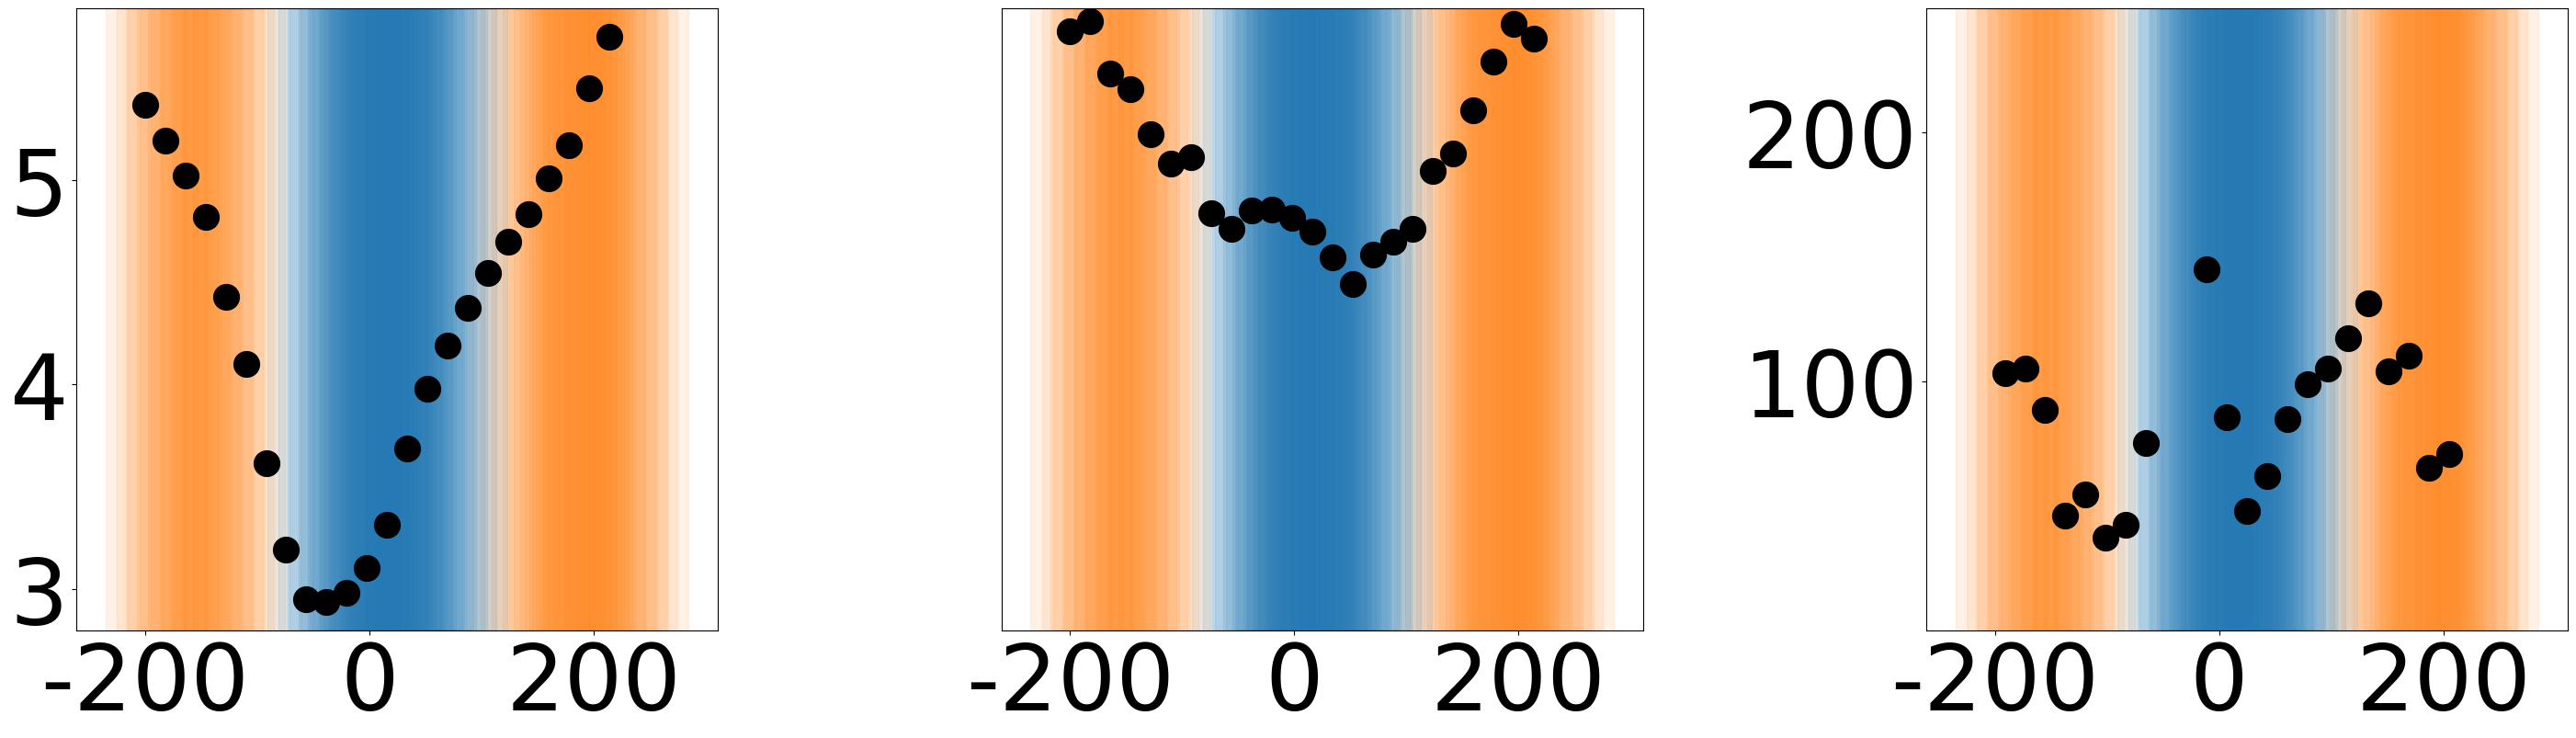

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1330  ACSF             486.997599          Neighbor                     NaN
1331  ACSF             468.861909          Neighbor             1502.669659
1332  ACSF             450.829873          Neighbor              108.808550
1333  ACSF             432.332419          Neighbor               93.987563
1334  ACSF             414.944720              None              376.750913
1335  ACSF             397.237427              None              305.498052
1336  ACSF             378.602046              None              169.327028
1337  ACSF             360.653381              None              188.198448
1338  ACSF             343.150926              None              174.989012
1339  ACSF             325.302046              None              205.412302
1340  ACSF             306.814939              Home              151.912016
1341  ACSF             288.889321              Home              111.476055
1342  ACSF  

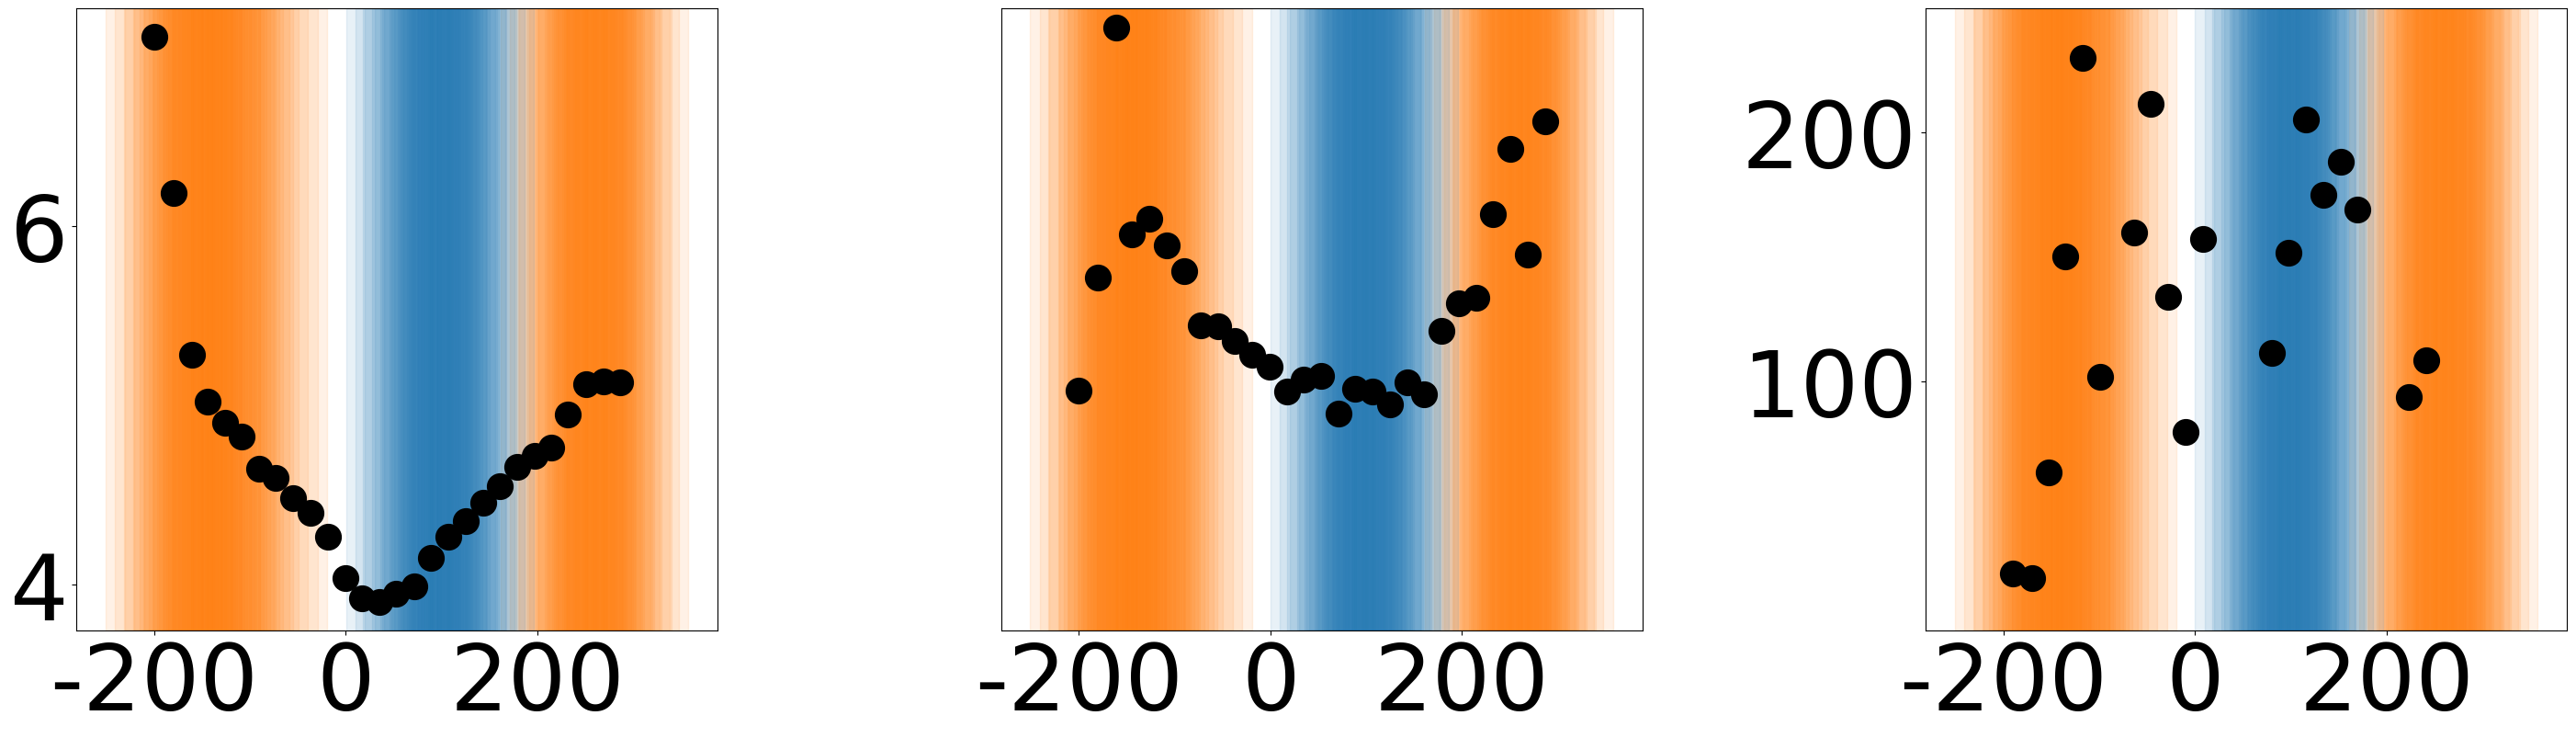

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1358  ACSF             388.429997          Neighbor               45.809505
1359  ACSF             370.472671          Neighbor              108.572589
1360  ACSF             352.449621              None              133.054860
1361  ACSF             334.753325              None              420.368202
1362  ACSF             317.097860              None             -670.971012
1363  ACSF             298.981643              None              126.957709
1364  ACSF             281.461479              Home              130.122041
1365  ACSF             262.854027              Home              216.442622
1366  ACSF             245.105732              Home              656.109538
1367  ACSF             227.390775              Home              329.621132
1368  ACSF             209.261613              Home              468.000847
1369  ACSF             191.945581              None              168.153445
1370  ACSF  

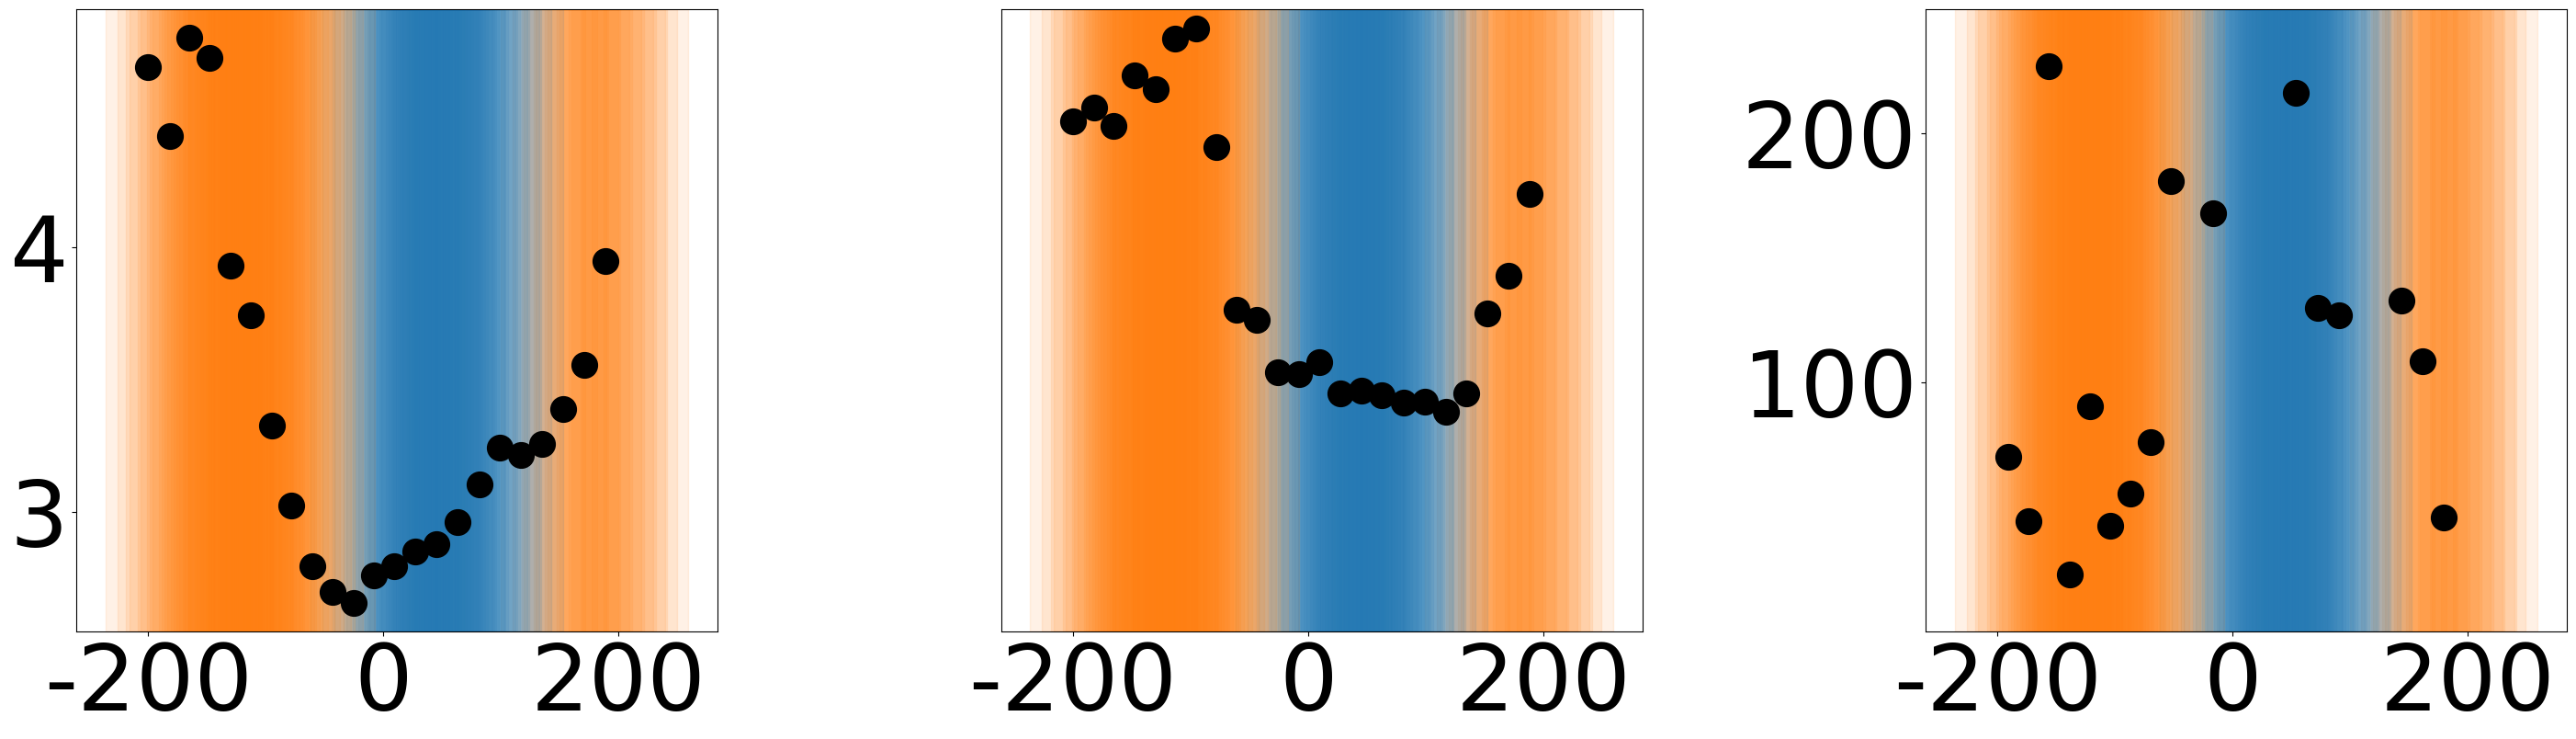

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1381  ACSF             370.751421          Neighbor               65.134056
1382  ACSF             353.165226          Neighbor                     NaN
1383  ACSF             335.685803              None               63.787050
1384  ACSF             317.378919              None              203.027220
1385  ACSF             299.715551              None              225.526861
1386  ACSF             282.124456              None              448.160281
1387  ACSF             264.198045              None              349.028441
1388  ACSF             246.746623              None              842.869354
1389  ACSF             229.046366              Home              485.889470
1390  ACSF             211.068456              Home              247.484450
1391  ACSF             193.744544              Home             1953.264590
1392  ACSF             176.165163              None              -80.120241
1393  ACSF  

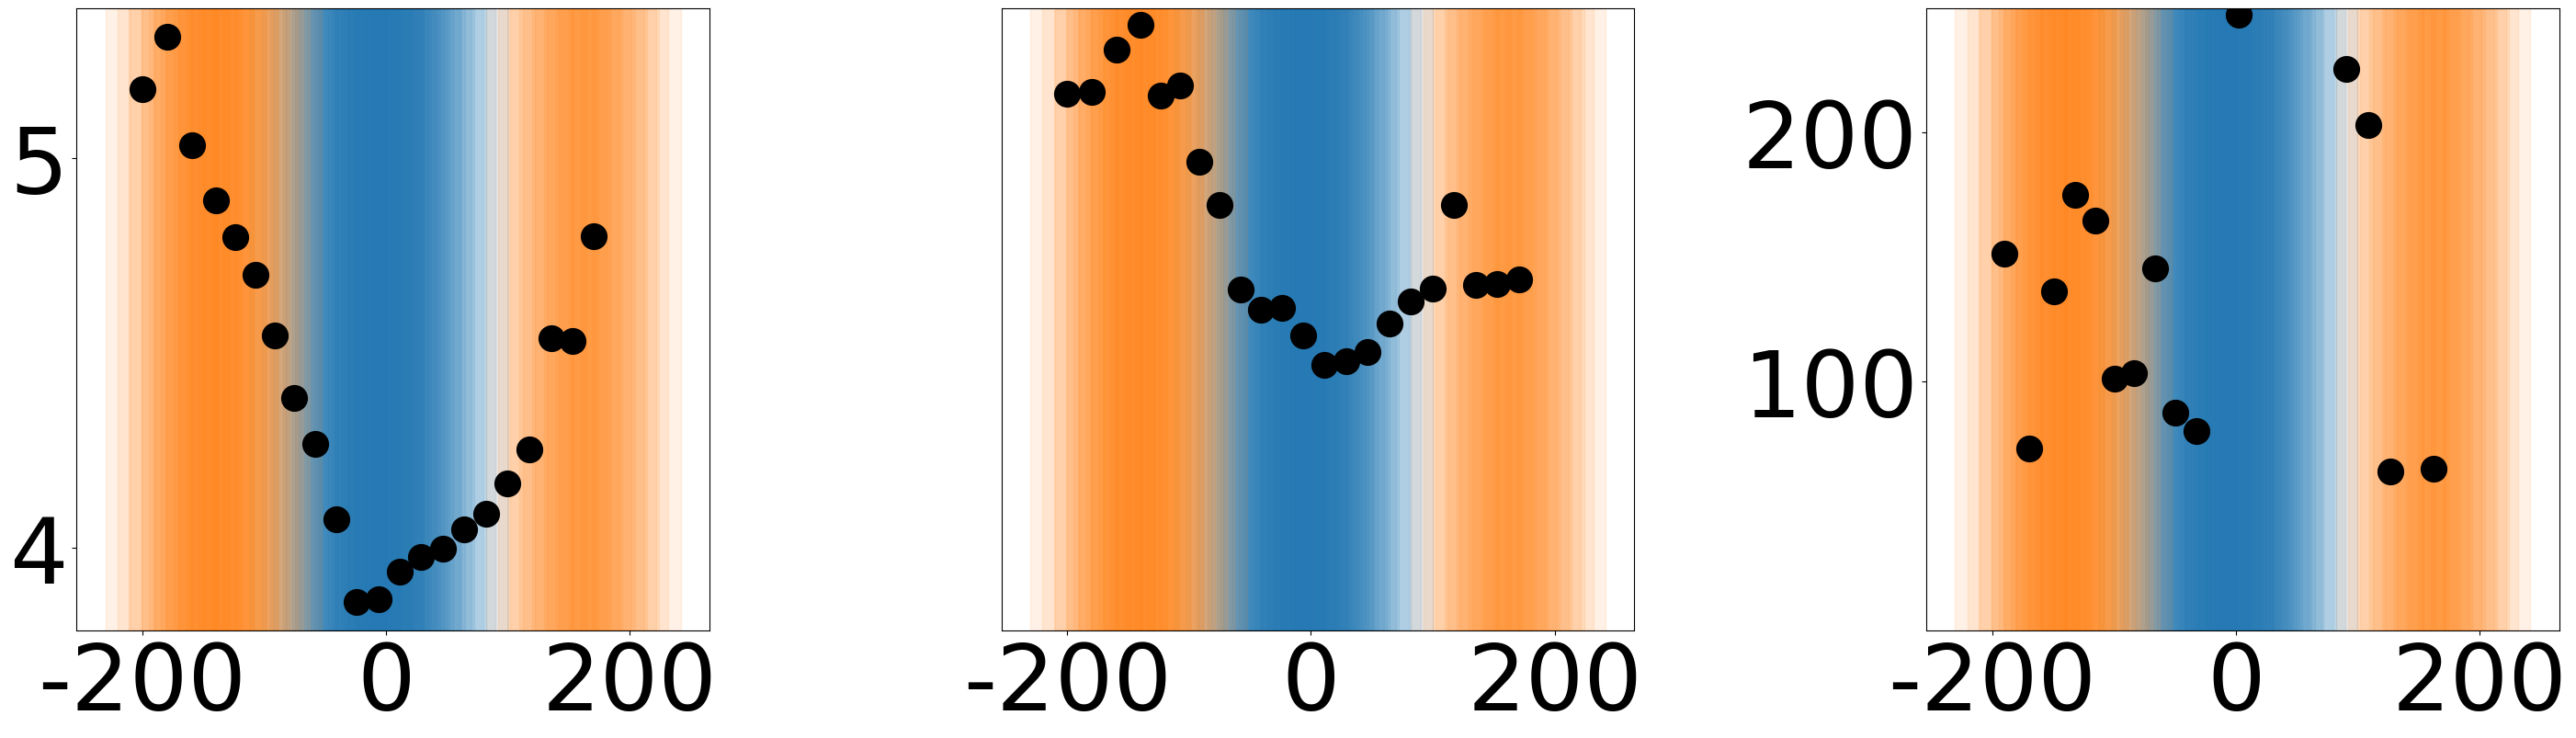

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_df['latency'] = (roi_df['latency'] % 10) + 1.2
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_18940\3383918680.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

      drug  Dist_from_home_barrel resides_in_barrel  instantaneous_velocity
1403  ACSF             444.364715              None               -4.072139
1404  ACSF             426.380112              None               52.505829
1405  ACSF             408.396866              None               27.799372
1406  ACSF             390.288355              None               17.567941
1407  ACSF             372.302297          Neighbor              -54.350687
1408  ACSF             354.317654          Neighbor               11.088297
1409  ACSF             336.334655          Neighbor              966.724610
1410  ACSF             318.353577          Neighbor               38.367074
1411  ACSF             300.374766          Neighbor               24.005779
1412  ACSF             282.255204          Neighbor               70.603130
1413  ACSF             264.272587              None               83.202580
1414  ACSF             246.292509              None              167.097021
1415  ACSF  

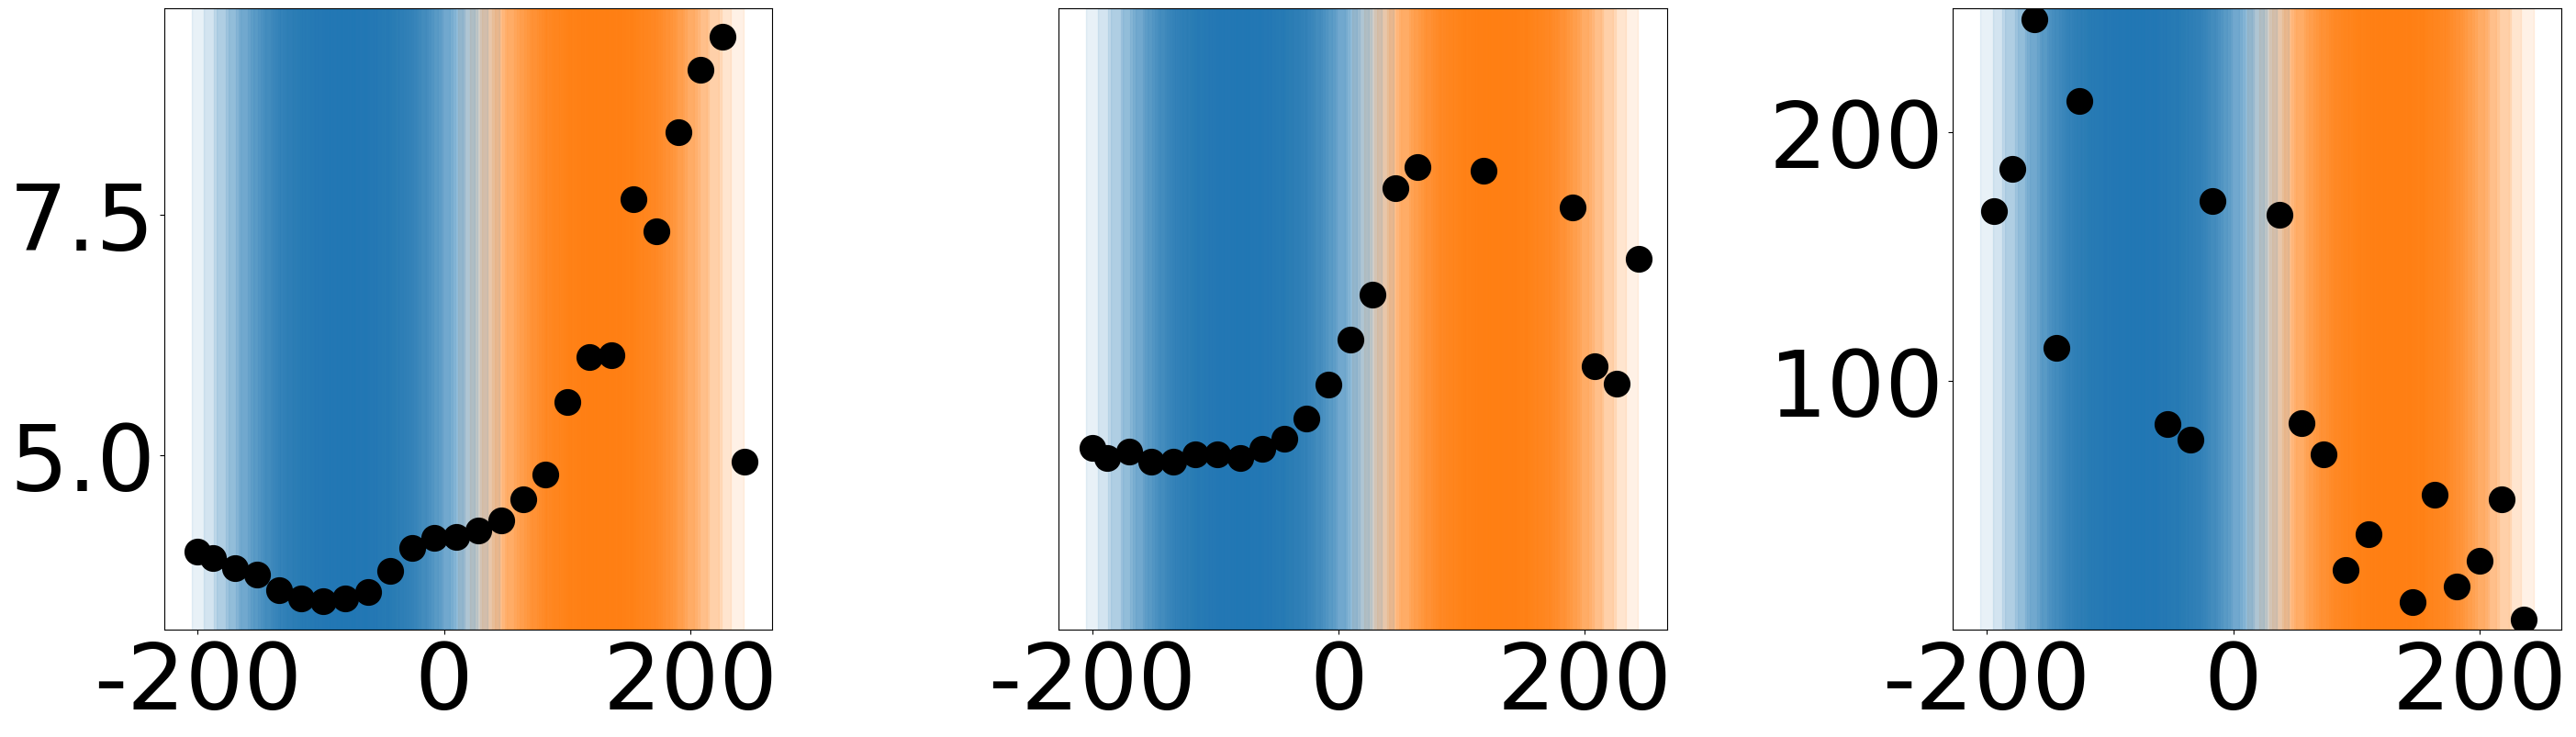

In [40]:
def identify_overlap_barrel(barrel_rois, roi):
    """ return a list of bools of whether roi overlaps w the barrel in barrel_rois
        0 - home barrel, 1 or 2 - neighbor barrel """
    overlap_ctr = OverlapCounterROI([], [])
    is_overlap = [overlap_ctr.do_rois_overlap(barrel, roi) for barrel in barrel_rois]
    return is_overlap

# set matplotlib font size
plt.rcParams.update({'font.size': 72})

# for each Slice/Location/Recording, plot the latency of each ladder ROI
num_legends = 1
for date in ladder_df['Date'].unique():
    date_df = ladder_df[ladder_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]

        # see if we have an ROI file for this slice/recording
        # look up ROI file from crossing_data
        barrel_df_sub = crossing_data[(crossing_data['Date'] == date) &
                                    (crossing_data['Slice'] == slic) &
                                    (crossing_data['Recording'] == slic_df['Recording'].values[0]) ]
        if barrel_df_sub.empty:
            # then try to look it up in ppr_df_for_roi_lookup
            barrel_df_sub = ppr_df_for_roi_lookup[(ppr_df_for_roi_lookup['Date'] == date) &
                                    (ppr_df_for_roi_lookup['Slice'] == slic) &
                                    (ppr_df_for_roi_lookup['Recording'] == slic_df['Recording'].values[0]) ]
            if barrel_df_sub.empty:
                print('No ROI file found for ', date, slic, slic_df['Recording'].values[0])
                continue
        handles = []
        fig, ax = plt.subplots(1, 3, figsize=(30, 10))

        for rec in slic_df['Recording'].unique():
            rec_df = slic_df[slic_df['Recording'] == rec]

            # look up ROI file from crossing_data
            barrel_df_sub = crossing_data[(crossing_data['Date'] == date) &
                                    (crossing_data['Slice'] == slic) &
                                    (crossing_data['Recording'] == rec) ]
            if barrel_df_sub.empty:
                # then try to look it up in ppr_df_for_roi_lookup
                barrel_df_sub = ppr_df_for_roi_lookup[(ppr_df_for_roi_lookup['Date'] == date) &
                                    (ppr_df_for_roi_lookup['Slice'] == slic) &
                                    (ppr_df_for_roi_lookup['Recording'] == rec) ]
                if barrel_df_sub.empty:
                    print('No ROI file found for ', date, slic, rec)
                    continue

            roi_file = barrel_df_sub['ROI file'].values[0]
            drug = barrel_df_sub['drug'].values[0]
            stim_layer = barrel_df_sub['Layer'].values[0]

            # save roi_file, drug, and stim_layer in ladder_df in new columns
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'ROI file'] = roi_file
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'drug'] = drug
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'Layer'] = stim_layer

            # read in the ROI file
            rois = ROIFileReader(roi_file).get_roi_list()

            # get the center of the home barrel
            home_barrel_center = LaminarROI(rois[0], input_diode_numbers=True).get_center()

            # convert from diode to pixel
            rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in rois]

            # first roi is home barrel, rest are neighboring barrels
            home_barrel = rois[0]
            neighbor_barrels = rois[1:]

            for roi in rec_df['ROI'].unique():
                roi_df = rec_df[rec_df['ROI'] == roi]
                # get the center of the ROI
                x_center = roi_df['X_Center'].values[0]
                y_center = roi_df['Y_Center'].values[0]

                is_overlap = identify_overlap_barrel(rois, [[int(x_center), int(y_center)]])

                # also calculate distance from home barrel along barrel axis
                ln = Line(home_barrel_center, [x_center, y_center])
                dist = ln.get_length()

                resides_in_barrel = None
                if is_overlap[0]:
                    resides_in_barrel = 'Home'
                elif is_overlap[1] or (len(is_overlap) > 2 and is_overlap[2]):
                    resides_in_barrel = 'Neighbor'

                # store in ladder_df
                ladder_df.loc[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['ROI'] == roi), 'Dist_from_home_barrel'] = dist
                ladder_df.loc[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['ROI'] == roi), 'resides_in_barrel'] = resides_in_barrel

            # now calculate which ROI is the closest to the home barrel
            arg_min = rec_df['Dist_from_home_barrel'].argmin()
            # get the ROI of the closest ROI
            closest_roi = rec_df.iloc[arg_min]
            closest_x = closest_roi['X_Center']
            closest_y = closest_roi['Y_Center']

            # also, which ROI is closest to the stim (min Stim_Distance)
            arg_min_stim = rec_df['Stim_Distance'].argmin()
            closest_stim_roi = rec_df.iloc[arg_min_stim]
            
            for roi in rec_df['ROI'].unique():
                roi_df = rec_df[(rec_df['ROI'] == roi)]
                dist_to_closest_roi = Line([closest_x, closest_y], 
                                            [roi_df['X_Center'].values[0],
                                                roi_df['Y_Center'].values[0]]).get_length()

                # denote negative distances as those to one side of the closest ROI
                if roi_df['ROI'].values[0] > closest_roi['ROI']:
                    dist_to_closest_roi *= -1

                ladder_df.loc[(ladder_df['Date'] == date) &
                                (ladder_df['Slice'] == slic) &
                                (ladder_df['Recording'] == rec) &
                                (ladder_df['ROI'] == roi), 'Dist_from_home_barrel'] = dist_to_closest_roi * 6.0  # px -> um
                
                # refresh data before plotting
                roi_df = ladder_df[(ladder_df['Date'] == date) &
                                (ladder_df['Slice'] == slic) &
                                (ladder_df['Recording'] == rec) &
                                (ladder_df['ROI'] == roi)]

                color = 'black' if drug == 'ACSF' else 'tab:green'
                region_color = None
                if roi_df['resides_in_barrel'].values[0] == 'Home':
                    region_color = 'tab:blue'
                if np.abs(roi - closest_stim_roi['ROI']) < 2:
                    region_color = 'tab:blue'
                elif roi_df['resides_in_barrel'].values[0] == 'Neighbor':
                    region_color = 'tab:orange'
                
                for sub_ax in ax:
                    # shade a vertical region of each plot around this ROI
                    if region_color is not None:
                        for radius in range(1, 76, 10):
                            sub_ax.axvspan(roi_df['Dist_from_home_barrel'].values[0] - radius, 
                                        roi_df['Dist_from_home_barrel'].values[0] + radius, 
                                        color=region_color, alpha=(0.06 if stim_layer == 'L2/3' else 0.1))
                    # draw a black dotted vertical line at the closest_stim_roi
                    if roi == closest_stim_roi['ROI'] and drug != 'ACSF':
                        #sub_ax.axvline(x=roi_df['Dist_from_home_barrel'].values[0], color='black', linestyle='--',
                        #            linewidth=4)

                        # and a black star next to the line at 50% the middle of the y-axis scale
                        middle_y = (sub_ax.get_ylim()[0] + sub_ax.get_ylim()[1]) / 2
                        if sub_ax == ax[2]:
                            middle_y = 0

                        #sub_ax.plot(roi_df['Dist_from_home_barrel'].values[0], middle_y, 
                        #            color='black', marker='*', markersize=20)
                
                if drug == 'ACSF':  # exclude NBQX data from the plot now
                    # plot the latency vs distance from home barrel
                    #if 10 > roi_df['latency'].values[0] > 1:
                    # remove latency values > 10 ms
                    if stim_layer == 'L2/3':
                        roi_df = roi_df[roi_df['latency'] < 5]

                    # stim time is 1.2 ms before the closest multiple of 10 (e.g. measured 48.8)
                    # only apply latency correction to values > 10 ms
                    for lat in roi_df['latency']:
                        if lat > 10:
                            roi_df['latency'] = (roi_df['latency'] % 10) + 1.2

                    ax[0].plot(roi_df['Dist_from_home_barrel'], roi_df['latency'], 
                            label=str(resides_in_barrel),
                            color=color, marker='o', markersize=20,
                            markeredgecolor='black')

                    # Now also plot the amplitude vs distance from home barrel
                    #ax[1].plot(roi_df['Dist_from_home_barrel'], roi_df['amp'] / 10, 
                    #            label=drug,
                    #            color=color, marker='o', markersize=20,
                    #            markeredgecolor='black')

                    # now also plot the half-width vs distance from home barrel
                    ax[1].plot(roi_df['Dist_from_home_barrel'], roi_df['halfwidth'], 
                                label=drug,
                                color=color, marker='o', markersize=20,
                                markeredgecolor='black')
            
            # now we also want to calculate the velocity of the ladder
            # for each pair of ROIs i and i+1, calculate the velocity as the distance between the two ROIs
            # divided by the difference in latency between the two ROIs
            # this will give the velocity in um/ms
            for i in range(1, len(rec_df)):
                roi1 = rec_df.iloc[i-1]
                roi2 = rec_df.iloc[i]
                dist = roi2['Dist_from_home_barrel'] - roi1['Dist_from_home_barrel']
                position = (roi2['Dist_from_home_barrel'] + roi1['Dist_from_home_barrel']) / 2
                latency_diff = roi2['latency'] - roi1['latency']
                velocity = dist / latency_diff
                if 5000 > velocity > -1000:
                    if drug == 'ACSF':
                        ax[2].plot(position, np.abs(velocity), color=color, linestyle='-', marker='o', markersize=20,
                    markeredgecolor='black')
                    # track this in the df as the velocity of roi i-1
                    ladder_df.loc[(ladder_df['Date'] == date) &
                                    (ladder_df['Slice'] == slic) &
                                    (ladder_df['Recording'] == rec) &
                                    (ladder_df['ROI'] == roi1['ROI']), 'instantaneous_velocity'] = velocity
            
            if drug == 'ACSF':
                subset_df_ = ladder_df[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec)]
                print(subset_df_[['drug', 'Dist_from_home_barrel', 'resides_in_barrel', 'instantaneous_velocity']])
                if len(subset_df_) > 40:
                    print(subset_df_)


        #for sub_ax in ax:
            #sub_ax.set_xlabel('Distance along L4 (um)')
        #ax[0].set_ylabel('Latency (ms)')
        #ax[1].set_ylabel('Δf/f (%)')
        #ax[2].set_ylabel('Half-Width (ms)')
        #ax[3].set_ylabel('Velocity (um/ms)')
        ax[1].set_ylim(0, ax[1].get_ylim()[1])
        
        for i in range(3):
            ax[i].set_xticks([0, 200, 400])
            ax[i].set_xticklabels([-200, 0, 200])
        #ax[0].set_yticks([])
        ax[1].set_yticks([])
        ax[2].set_ylim(0, 250)
        ax[2].set_yticks([100, 200])
        #ax[0].set_title()
        handles = ax[0].get_legend_handles_labels()
        handles = [handles[0][0], handles[0][-1]]
        if num_legends > 0:
            #ax[0].legend(handles=handles, labels=['ACSF', '+NBQX'], loc='upper left')
            num_legends -= 1
        plt.tight_layout()
        plt.savefig(output_fig_dir + 'Ladder_velocity_plot_' \
                + date.replace('/', '-') + '_' + str(slic) + '_' + stim_layer.replace("/", "") + '_' + str(rec) + '_latency.png')
        print('Date: ' + date + '   Slice: ' + str(slic) + '   Stim: ' + stim_layer )
        plt.show()
        

In [17]:
print(ladder_df.columns)
ladder_df

Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI_Set', 'Date', 'Slice', 'Location',
       'Recording', 'trace', 'Dist_from_home_barrel', 'resides_in_barrel',
       'instantaneous_velocity', 'ROI file', 'drug', 'Layer'],
      dtype='object')


ROI        amp      snr  latency  halfwidth  Stim_Distance   X_Center  \
0       1   0.408552  19.7128   3.9030    16.6507     272.917570  34.263889   
1       2   0.462050  27.5393   3.9159    14.4435     256.320112  36.851351   
2       3   0.441868  28.2700   3.8743    13.6368     239.774894  38.767123   
3       4   0.466602  22.1134   3.8636    13.2221     223.293529  40.816901   
4       5   0.526346  26.8669   3.7651    10.1029     206.891276  43.818182   
...   ...        ...      ...      ...        ...            ...        ...   
1424   22  10.513800      NaN  32.4017    10.5138      87.361319  68.000000   
1425   23  10.499200      NaN  32.5608    10.4992      93.914855  71.000000   
1426   24  11.141100      NaN  32.6341    11.1411     103.227903  74.000000   
1427   25  10.717900      NaN  32.7312    10.7179     114.629839  77.000000   
1428   26  11.365600      NaN  32.8025    11.3656     127.561750  79.000000   

       Y_Center                        ROI_Set       Date  Slice  Location  \
0     10.236111          1_roi_output__ladder_  6/26/2024      1         1   
1     12.054054          1_roi_output__ladder_  6/26/2024      1         1   
2     14.273973          1_roi_output__ladder_  6/26/2024      1         1   
3     16.338028          1_roi_output__ladder_  6/26/2024      1         1   
4     17.766234          1_roi_output__ladder_  6/26/2024      1         1   
...         ...                            ...        ...    ...       ...   
1424  42.000000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1425  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1426  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1427  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   
1428  42.500000  3_rois_output__ladder_ pulse1  4/16/2025      3         2   

      Recording                                              trace  \
0             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
1             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
2             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
3             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
4             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
...         ...                                                ...   
1424          1                                                NaN   
1425          1                                                NaN   
1426          1                                                NaN   
1427          1                                                NaN   
1428          1                                                NaN   

      Dist_from_home_barrel resides_in_barrel  instantaneous_velocity  \
0                368.804275          Neighbor                     NaN   
1                350.406813          Neighbor              422.912185   
2                332.813666              None             1626.003658   
3                315.415427          Neighbor              183.157884   
4                297.374375          Neighbor              139.073187   
...                     ...               ...                     ...   
1424              66.068147              Home             -113.564718   
1425              48.000000              None             -245.566166   
1426              30.000000              None             -185.375901   
1427              12.000000              None             -168.302945   
1428               0.000000              None                     NaN   

                                               ROI file  drug Layer  
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3  
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3  
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3  
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3  
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann

In [41]:

# remove any row in ladder_df_2 or from ladder_df that has the same date/slice/recording/ROI as ladder_df
ladder_df_nbqx = ladder_df.copy()
'''for row in ladder_df_nbqx.iterrows():
    date = row[1]['Date']
    slic = row[1]['Slice']
    rec = row[1]['Recording']
    #print(f"Checking {date} {slic} {rec} {roi} in ladder_df_2")
    if len(ladder_df_2[(ladder_df_2['Date'] == date) & 
                            (ladder_df_2['Slice'] == slic) & 
                            (ladder_df_2['Recording'] == rec)]) > 0:
        ladder_df_nbqx.drop(row[0], inplace=True)
        print(f"Removing {date} {slic} {rec} from ladder_df_nbqx")'''

# drop any rows that are marked as 'Is_Pulse_2' in ladder_df_nbqx
if 'Is_Pulse_2' in ladder_df_nbqx.columns:
    # remove any rows that are marked as 'Is_Pulse_2'
    ladder_df_nbqx = ladder_df_nbqx[ladder_df_nbqx['Is_Pulse_2'] != True]

In [42]:
# load all_animals_age_sex.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\
age_sex_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_animals_age_sex.csv'
age_sex_df = pd.read_csv(age_sex_csv)

# add age and sex as columns to ladder_df_nbqx, matching on Date
# Merge Age and Sex from age_sex_df into ladder_df_nbqx using the Date column
ladder_df_nbqx = ladder_df_nbqx.merge(
    age_sex_df[['Date', 'Age', 'Sex']],
    on='Date',
    how='left',
    suffixes=('', '_from_age_sex')
)
ladder_df_nbqx

# abs value on instantaneous_velocity
ladder_df_nbqx['instantaneous_velocity'] = ladder_df_nbqx['instantaneous_velocity'].abs()

# write the ladder_df_nbqx to a CSV file called export_summary_final_velocity_ladders.csv
ladder_df_nbqx.to_csv('C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_final_velocity_ladders.csv', index=False)
ladder_df_nbqx

ROI        amp      snr  latency  halfwidth  Stim_Distance   X_Center  \
0       1   0.408552  19.7128   3.9030    16.6507     272.917570  34.263889   
1       2   0.462050  27.5393   3.9159    14.4435     256.320112  36.851351   
2       3   0.441868  28.2700   3.8743    13.6368     239.774894  38.767123   
3       4   0.466602  22.1134   3.8636    13.2221     223.293529  40.816901   
4       5   0.526346  26.8669   3.7651    10.1029     206.891276  43.818182   
...   ...        ...      ...      ...        ...            ...        ...   
1424   22  10.513800      NaN  32.4017    10.5138      87.361319  68.000000   
1425   23  10.499200      NaN  32.5608    10.4992      93.914855  71.000000   
1426   24  11.141100      NaN  32.6341    11.1411     103.227903  74.000000   
1427   25  10.717900      NaN  32.7312    10.7179     114.629839  77.000000   
1428   26  11.365600      NaN  32.8025    11.3656     127.561750  79.000000   

       Y_Center                        ROI_Set       Date  ...  \
0     10.236111          1_roi_output__ladder_  6/26/2024  ...   
1     12.054054          1_roi_output__ladder_  6/26/2024  ...   
2     14.273973          1_roi_output__ladder_  6/26/2024  ...   
3     16.338028          1_roi_output__ladder_  6/26/2024  ...   
4     17.766234          1_roi_output__ladder_  6/26/2024  ...   
...         ...                            ...        ...  ...   
1424  42.000000  3_rois_output__ladder_ pulse1  4/16/2025  ...   
1425  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...   
1426  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...   
1427  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...   
1428  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...   

                                                  trace  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
...                                                 ...   
1424                                                NaN   
1425                                                NaN   
1426                                                NaN   
1427                                                NaN   
1428                                                NaN   

      Dist_from_home_barrel  resides_in_barrel instantaneous_velocity  \
0                368.804275           Neighbor                    NaN   
1                350.406813           Neighbor             422.912185   
2                332.813666               None            1626.003658   
3                315.415427           Neighbor             183.157884   
4                297.374375           Neighbor             139.073187   
...                     ...                ...                    ...   
1424              66.068147               Home             113.564718   
1425              48.000000               None             245.566166   
1426              30.000000               None             185.375901   
1427              12.000000               None             168.302945   
1428               0.000000               None                    NaN   

                                               ROI file  drug  Layer  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF   L2/3   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF   L2/3   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF   L2/3   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF   L2/3   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF   L2/3   
...                                                 ...   ...    ...   
1424  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  ACSF     L4   
1425  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  ACSF     L4   
1426  C:/Users/jjudge3/Desktop

L2/3 Neighbor 3.636 +/- 0.093 um/ms
L4 Neighbor 4.065 +/- 0.300 um/ms
L2/3 Neighbor 3.401 +/- 0.154 um/ms
L4 Neighbor 2.982 +/- 0.093 um/ms
Date        Slice
10/23/2024  1        3.718967
12/20/2024  1        5.396700
6/26/2024   1        3.817340
7/1/2024    3        3.498514
            4        3.591557
7/15/2024   2        2.984840
Name: latency, dtype: float64 Date        Slice
10/23/2024  1        3.718967
12/20/2024  1        5.396700
6/26/2024   1        3.817340
7/1/2024    3        3.498514
            4        3.591557
7/15/2024   2        2.984840
Name: latency, dtype: float64
0.0 1.0 male and female test: latency layer: L2/3
Date        Slice
10/29/2024  1        2.024900
12/11/2024  2        2.815625
            3        3.800850
12/18/2024  2        3.185000
12/20/2024  2        5.079692
12/9/2024   2        2.803520
7/17/2024   3        2.943267
Name: latency, dtype: float64 Date        Slice
10/29/2024  1        2.024900
12/11/2024  2        2.815625
            3     

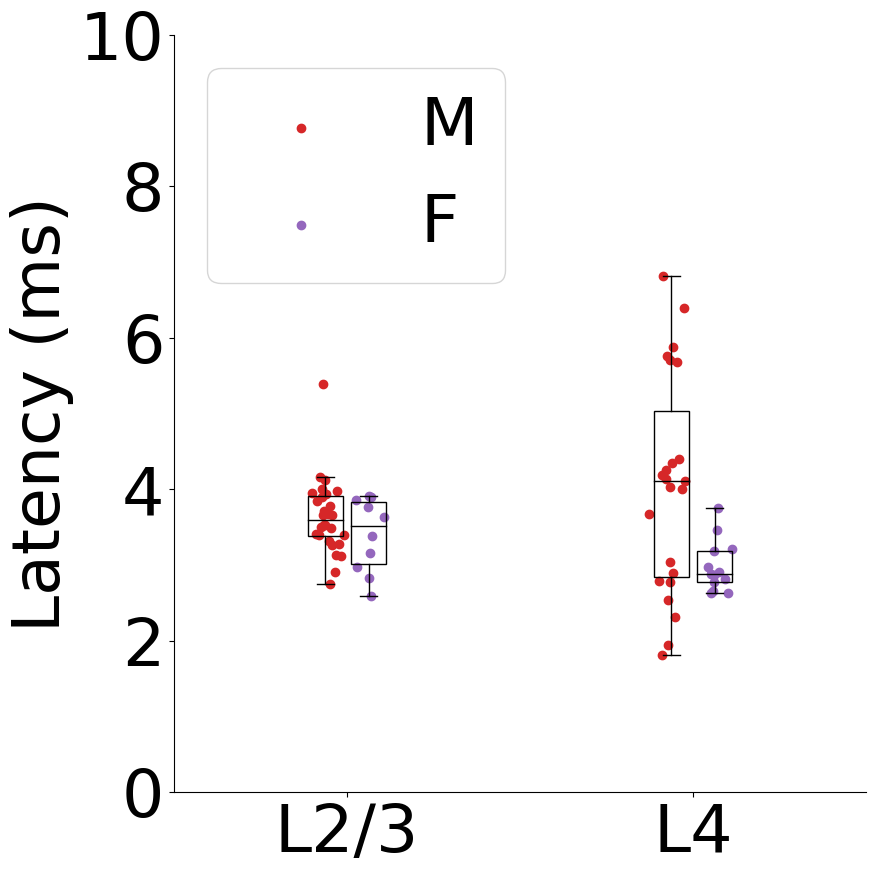

L2/3 Neighbor 3.614 +/- 0.348 um/ms
L4 Neighbor 3.496 +/- 0.725 um/ms
L2/3 Neighbor 1.901 +/- 0.470 um/ms
L4 Neighbor 3.688 +/- 0.737 um/ms
Date        Slice
10/23/2024  1        0.297847
12/20/2024  1        3.366220
6/26/2024   1        0.491232
7/1/2024    3        4.618447
            4        4.485337
7/15/2024   2        3.312360
Name: amp, dtype: float64 Date        Slice
10/23/2024  1        0.297847
12/20/2024  1        3.366220
6/26/2024   1        0.491232
7/1/2024    3        4.618447
            4        4.485337
7/15/2024   2        3.312360
Name: amp, dtype: float64
0.0 1.0 male and female test: amp layer: L2/3
Date        Slice
10/29/2024  1        11.271067
12/11/2024  2         0.798567
            3         4.314008
12/18/2024  2         1.790246
12/20/2024  2         2.180017
12/9/2024   2         2.946464
7/17/2024   3         8.090730
Name: amp, dtype: float64 Date        Slice
10/29/2024  1        11.271067
12/11/2024  2         0.798567
            3         4.3

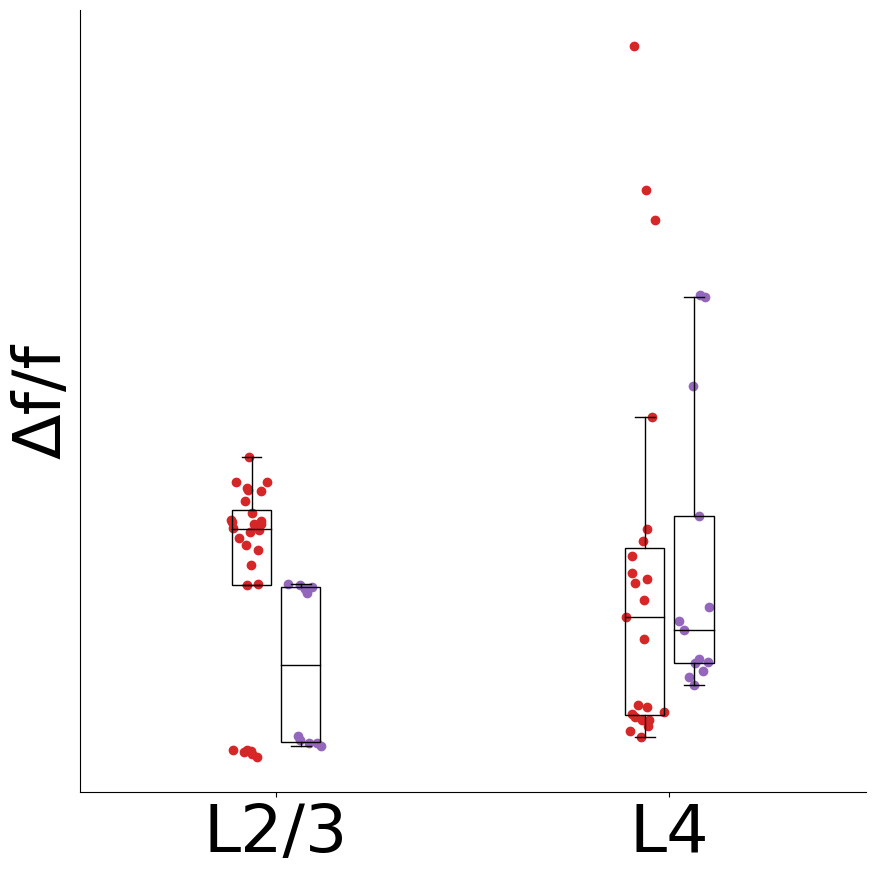

L2/3 Neighbor 10.53 +/- 0.580 um/ms
L4 Neighbor 15.29 +/- 1.965 um/ms
L2/3 Neighbor 11.88 +/- 0.793 um/ms
L4 Neighbor 15.40 +/- 1.827 um/ms
Date        Slice
10/23/2024  1        10.527975
12/20/2024  1        20.409400
6/26/2024   1        12.539660
7/1/2024    3         8.366849
            4        13.470743
7/15/2024   2        11.236660
Name: halfwidth, dtype: float64 Date        Slice
10/23/2024  1        10.527975
12/20/2024  1        20.409400
6/26/2024   1        12.539660
7/1/2024    3         8.366849
            4        13.470743
7/15/2024   2        11.236660
Name: halfwidth, dtype: float64
0.0 1.0 male and female test: halfwidth layer: L2/3
Date        Slice
10/29/2024  1         7.928047
12/11/2024  2        12.429553
            3        15.971825
12/18/2024  2        16.724320
12/20/2024  2        17.870466
12/9/2024   2        19.566000
7/17/2024   3         6.289943
Name: halfwidth, dtype: float64 Date        Slice
10/29/2024  1         7.928047
12/11/2024  2       

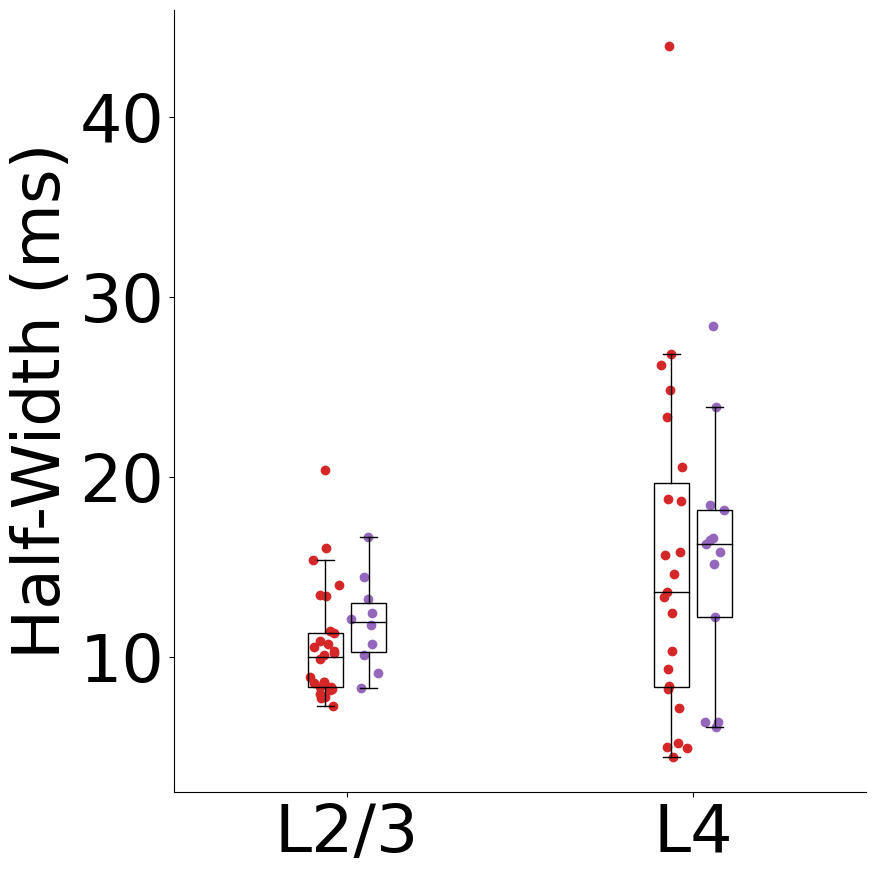

L2/3 Neighbor 118.1 +/- 6.442 um/ms
L4 Neighbor 99.45 +/- 16.00 um/ms
L2/3 Neighbor 108.1 +/- 14.67 um/ms
L4 Neighbor 63.88 +/- 3.834 um/ms
Date        Slice
10/23/2024  1        303.039696
12/20/2024  1       -195.584128
6/26/2024   1        215.578190
7/1/2024    3         23.175633
            4       -111.051009
7/15/2024   2        -85.168054
Name: instantaneous_velocity, dtype: float64 Date        Slice
10/23/2024  1        303.039696
12/20/2024  1       -195.584128
6/26/2024   1        215.578190
7/1/2024    3         23.175633
            4       -111.051009
7/15/2024   2        -85.168054
Name: instantaneous_velocity, dtype: float64
0.0 1.0 male and female test: instantaneous_velocity layer: L2/3
Date        Slice
10/29/2024  1       -301.113521
12/11/2024  2        878.124920
            3        128.084207
12/18/2024  2        -60.652594
12/20/2024  2        -51.744719
12/9/2024   2       -176.821861
7/17/2024   3        146.082554
Name: instantaneous_velocity, dtype: float6

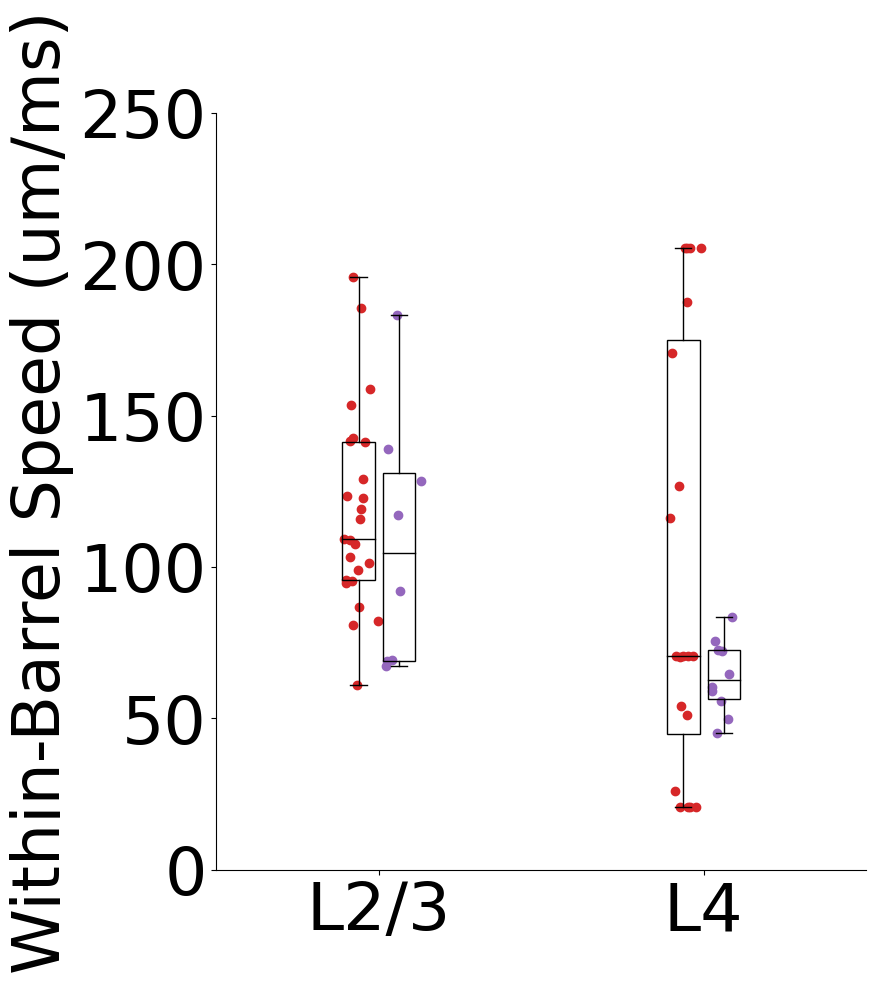

In [20]:
# 1-d scatter plot of the average speed
# broken down by sex

# matplotlib font size larger
plt.rcParams.update({'font.size': 48})

for metric, label in zip(['latency', 'amp', 'halfwidth', 'instantaneous_velocity'], 
                            ['Latency (ms)', 'Δf/f', 'Half-Width (ms)', 'Within-Barrel Speed (um/ms)']):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    layers = ['L2/3', 'L4']
    for i_sex, sex in enumerate(['M', 'F']):

        speeds = []
        positions = []
        for i, layer in enumerate(layers):
            for i_reg, region in enumerate(['Neighbor']):
                region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                        (ladder_df_nbqx['Sex'] == sex) & 
                                        (ladder_df_nbqx['drug'] == 'ACSF') &
                                        (ladder_df_nbqx['resides_in_barrel'] == region)]
                speed = [s for s in list(np.abs(region_df[metric])) if not np.isnan(s)]
                if metric == 'instantaneous_velocity':
                    # remove outliers
                    speed = [s for s in speed if s < 300]
                
                speeds.append(speed)
                positions.append(i + i_sex/8 - 1/16)
                # print the mean +/- sem of the speed
                print(layer, region, str(np.mean(speed))[:5], "+/-", str(sem(speed))[:5], "um/ms")
        ax.boxplot(speeds, positions=positions, 
                        showfliers=False, patch_artist=True,
                        boxprops=dict(facecolor=(0,0,0,0)),
                        widths=0.1,
                        medianprops=dict(color='black'))
        

    # scatter plot of the average speed
    for i, layer in enumerate(layers):
        for j, sex in enumerate(['M', 'F']):
            edgecolors= None
            for i_reg, region in enumerate(['Neighbor']):
                region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                        (ladder_df_nbqx['Sex'] == sex) & 
                                        (ladder_df_nbqx['drug'] == 'ACSF') &
                                        (ladder_df_nbqx['resides_in_barrel'] == region)]
                x_jitter = np.random.normal(i + j/8 - 1/16, 0.025, len(region_df))
                ax.scatter(x_jitter, 
                                np.abs(region_df[metric]), 
                                label=sex, 
                                color='tab:red' if sex == 'M' else 'tab:purple',
                                edgecolors=edgecolors)
                
                if metric == 'instantaneous_velocity':
                    ax.set_ylim(0, 250)
                elif metric == 'latency':
                    ax.set_ylim(0, 10)
                elif metric == 'amp':
                    # ax.set_ylim(0, 10.5)
                    ax.set_yticks([])
                elif metric == 'halfwidth':
                    pass # ax.set_ylim(0, 2.5)
                ax.set_xlim(-.5, 1.5)
                ax.set_xticks([0, 1])
                ax.set_xticklabels(layers)

    for layer_sig in ['L2/3', 'L4']:
        # is there a significant difference between M and F for L2/3 and L4? 
        male = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer_sig) & 
                                (ladder_df_nbqx['resides_in_barrel'] == 'Neighbor') &
                                (ladder_df_nbqx['drug'] == 'ACSF')][metric]
        female = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer_sig) &
                                (ladder_df_nbqx['resides_in_barrel'] == 'Neighbor') &
                                (ladder_df_nbqx['drug'] == 'ACSF')][metric]

        # average for each date/slice
        male = male.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
        female = female.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()

        print(male, female)

        t_stat, p_val = ttest_ind(male, female, equal_var=False)
        print(t_stat, p_val, "male and female test:", metric, "layer:", layer_sig)

        # get t-test for adjusted p-value
        if p_val < 0.05:
            print('Significant difference between ACSF and NBQX for ' + metric + ' in ' + layer_sig)
            # place in terms of fraction of the y-axis
            x_loc = 0 if layer_sig == 'L2/3' else 1
            ax.text(x_loc, 0.73 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0], 'p < 0.05', ha='center')
            # draw a line between the two boxes. shift it right a bit if drug_sig == 'NBQX', left if drug_sig == 'ACSF'
            layer_sig_shift = 1/10 
            
            layer_sig_yshift = 0.02 if layer_sig == 'L4' else 0.0
            y_height = (0.7 - layer_sig_yshift) * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0]
            ax.plot([x_loc - layer_sig_shift, x_loc + layer_sig_shift], [y_height, y_height], color='black') 
            
            # vertical segments at the ends of the bar to make it a bracket
            brack_cap = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.plot([x_loc - layer_sig_shift, x_loc - layer_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')
            ax.plot([x_loc + layer_sig_shift, x_loc + layer_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')

    ax.set_ylabel(label)
    # set spines to be invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # legend in top left, but with only the first two labels
    handles = ax.get_legend_handles_labels()
    if metric == 'latency':
        ax.legend(handles=handles[0][:2], labels=handles[1][:2], loc='upper left')
    # tight layout
    plt.tight_layout()
    plt.savefig(output_fig_dir + '/sex_' + metric + '.png')
    plt.show()
        

L2/3 Neighbor 3.574 +/- 0.080 um/ms
L4 Neighbor 3.674 +/- 0.212 um/ms
Linear regression for L2/3 Neighbor: slope=-0.03, intercept=5.67, p-value=0.230
Linear regression for L4 Neighbor: slope=-0.02, intercept=4.49, p-value=0.478


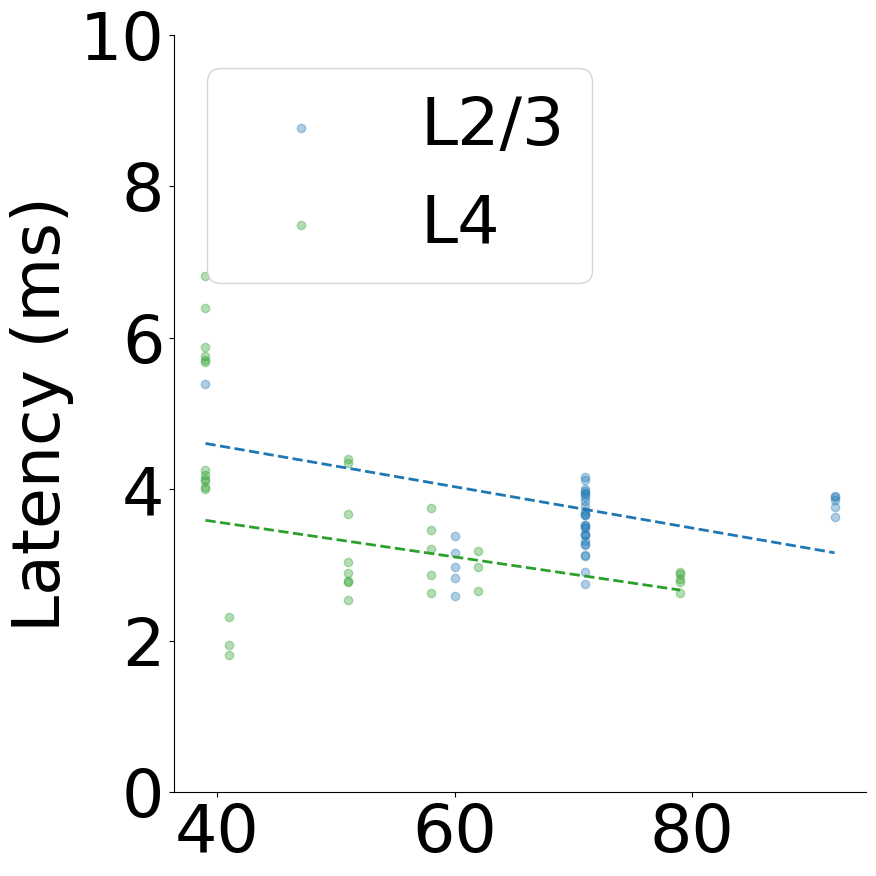

L2/3 Neighbor 3.163 +/- 0.307 um/ms
L4 Neighbor 3.566 +/- 0.528 um/ms
Linear regression for L2/3 Neighbor: slope=-0.05, intercept=6.03, p-value=0.382
Linear regression for L4 Neighbor: slope=-0.06, intercept=7.53, p-value=0.668


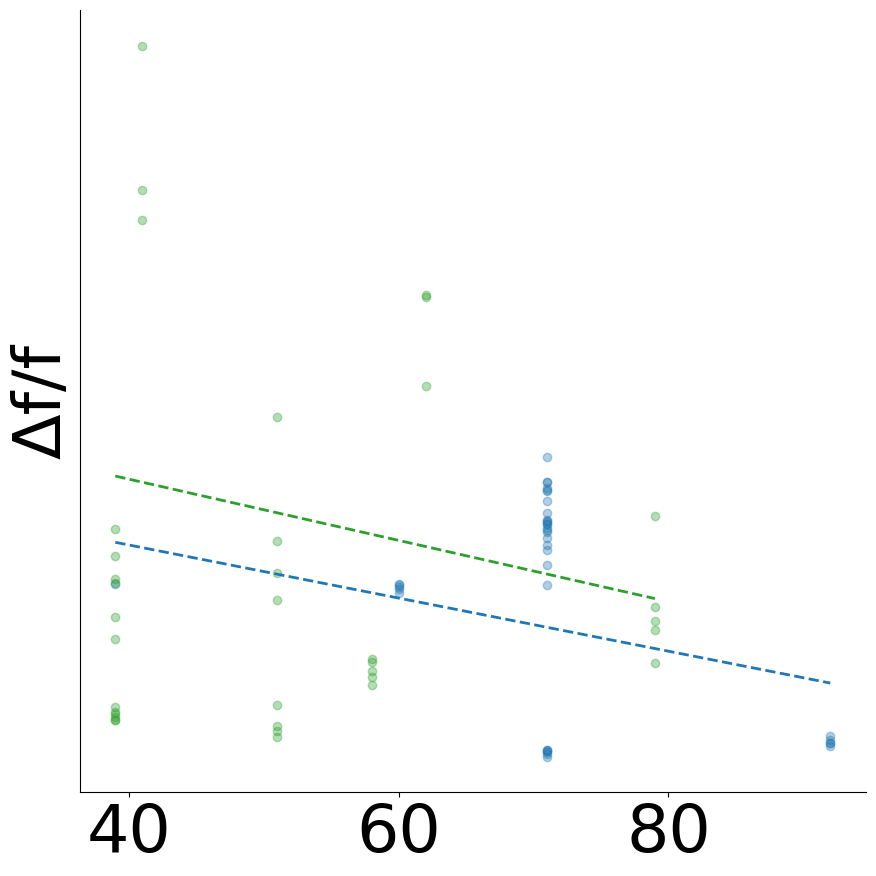

L2/3 Neighbor 10.89 +/- 0.480 um/ms
L4 Neighbor 15.33 +/- 1.401 um/ms
Linear regression for L2/3 Neighbor: slope=-0.15, intercept=23.17, p-value=0.164
Linear regression for L4 Neighbor: slope=0.10, intercept=8.53, p-value=0.573


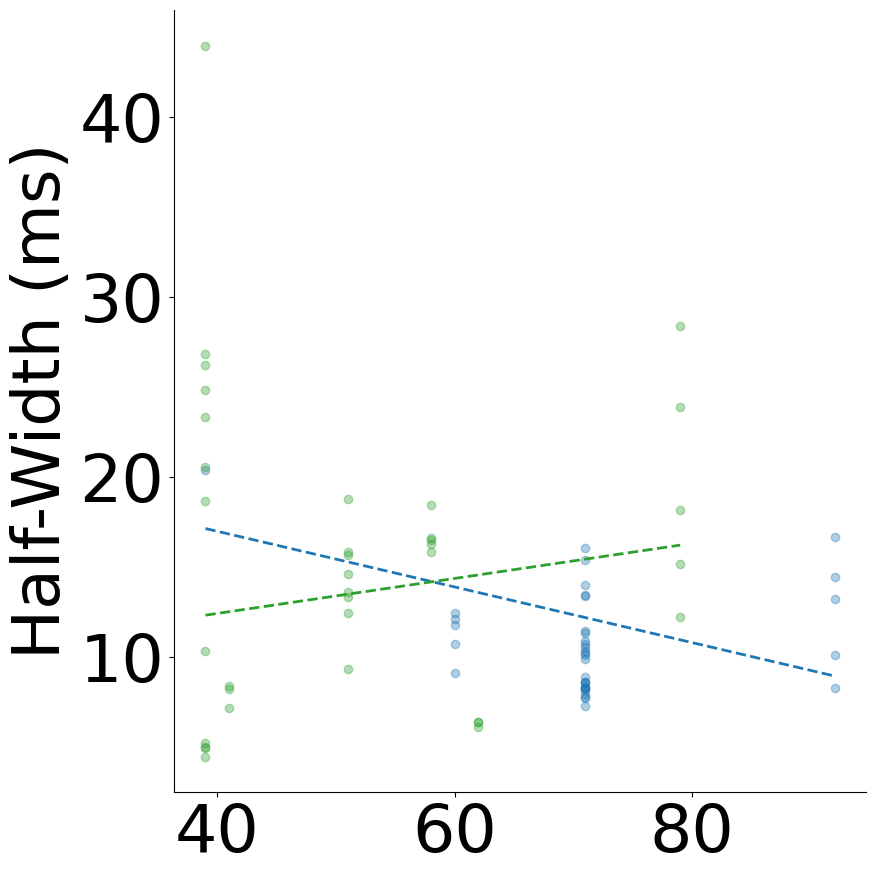

L2/3 Neighbor 115.7 +/- 5.965 um/ms
L4 Neighbor 87.59 +/- 11.09 um/ms
Linear regression for Neighbor: slope=2.50, intercept=-96.33, p-value=0.662


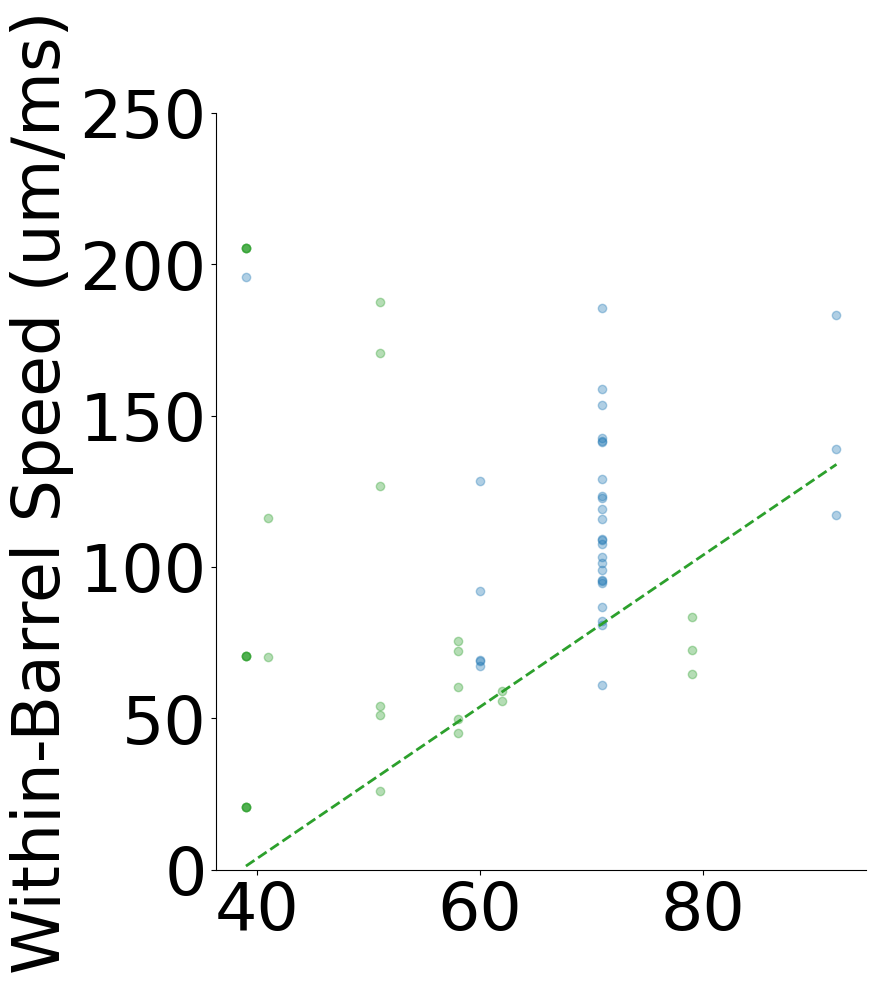

In [21]:
# 2-d scatter plot of the average speed
# versus age

# matplotlib font size larger
plt.rcParams.update({'font.size': 48})

for metric, label in zip(['latency', 'amp', 'halfwidth', 'instantaneous_velocity'], 
                            ['Latency (ms)', 'Δf/f', 'Half-Width (ms)', 'Within-Barrel Speed (um/ms)']):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    layers = ['L2/3', 'L4']

    for i, layer in enumerate(layers):
        for i_reg, region in enumerate(['Neighbor']):
            region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                    (ladder_df_nbqx['drug'] == 'ACSF') &
                                    (ladder_df_nbqx['resides_in_barrel'] == region)]

            edgecolors= None
            ax.scatter(np.abs(region_df['Age']), 
                                np.abs(region_df[metric]), 
                                label=layer, 
                                color='tab:blue' if layer == 'L2/3' else 'tab:green',
                                edgecolors=edgecolors,
                                alpha=0.35,)

            speed = [s for s in list(np.abs(region_df[metric])) if not np.isnan(s)]
            if metric == 'instantaneous_velocity':
                # remove outliers
                speed = [s for s in speed if s < 300]
            
            # print the mean +/- sem of the speed
            print(layer, region, str(np.mean(speed))[:5], "+/-", str(sem(speed))[:5], "um/ms")
    if metric == 'instantaneous_velocity':
        ax.set_ylim(0, 250)
    elif metric == 'latency':
        ax.set_ylim(0, 10)
    elif metric == 'amp':
        # ax.set_ylim(0, 10.5)
        ax.set_yticks([])
    elif metric == 'halfwidth':
        pass # ax.set_ylim(0, 2.5)


    # linear regression lines by layer
    if metric != 'instantaneous_velocity':
        for i, layer in enumerate(layers):
            for i_reg, region in enumerate(['Neighbor']):
                region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                        (ladder_df_nbqx['drug'] == 'ACSF') &
                                        (ladder_df_nbqx['resides_in_barrel'] == region)]
                # average for each date/slice
                region_df = region_df.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
                if len(region_df) > 0:
                    # fit a linear regression line
                    slope, intercept, r_value, p_value, std_err = linregress(region_df['Age'], region_df[metric])
                    x_vals = np.linspace(region_df['Age'].min(), region_df['Age'].max(), 100)
                    y_vals = slope * x_vals + intercept
                    ax.plot(x_vals, y_vals, color='tab:blue' if layer == 'L2/3' else 'tab:green', linestyle='--', linewidth=2)
                    print(f"Linear regression for {layer} {region}: slope={slope:.2f}, intercept={intercept:.2f}, p-value={p_value:.3f}")
    else:
        for i_reg, region in enumerate(['Neighbor']):
            region_df = ladder_df_nbqx[#(ladder_df_nbqx['Layer'] == layer) & 
                                    (ladder_df_nbqx['drug'] == 'ACSF') &
                                    (ladder_df_nbqx['resides_in_barrel'] == region)]
            # average for each date/slice
            region_df = region_df.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
            if len(region_df) > 0:
                # fit a linear regression line
                slope, intercept, r_value, p_value, std_err = linregress(region_df['Age'], region_df[metric])
                x_vals = np.linspace(region_df['Age'].min(), region_df['Age'].max(), 100)
                y_vals = slope * x_vals + intercept
                ax.plot(x_vals, y_vals, color='tab:blue' if layer == 'L2/3' else 'tab:green', linestyle='--', linewidth=2)
                print(f"Linear regression for {region}: slope={slope:.2f}, intercept={intercept:.2f}, p-value={p_value:.3f}")

    ax.set_ylabel(label)
    # set spines to be invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # legend in top left, but with only the first two labels
    handles = ax.get_legend_handles_labels()
    if metric == 'latency':
        ax.legend(handles=handles[0][:2], labels=handles[1][:2], loc='upper left')
    # tight layout
    plt.tight_layout()
    plt.savefig(output_fig_dir + '/age_' + metric + '.png')
    plt.show()
        

L2/3 Neighbor ACSF 3.574 +/- 0.080 um/ms
L4 Neighbor ACSF 3.674 +/- 0.212 um/ms
L2/3 Neighbor NBQX 3.565 +/- 0.100 um/ms
L4 Neighbor NBQX 2.981 +/- 0.229 um/ms
1.2072119733278175 0.25266864429227726 Neighbor L2/3 and L4 test: latency drug: ACSF
2.3293565128831943 0.04734659738744986 Neighbor L2/3 and L4 test: latency drug: NBQX
Significant difference between L2/3 and L4 for latency in NBQX
0.08623345761020575 0.9329848927854529 ACSF and NBQX test: latency layer: L2/3
-0.7542866514821169 0.46905658952483686 ACSF and NBQX test: latency layer: L4


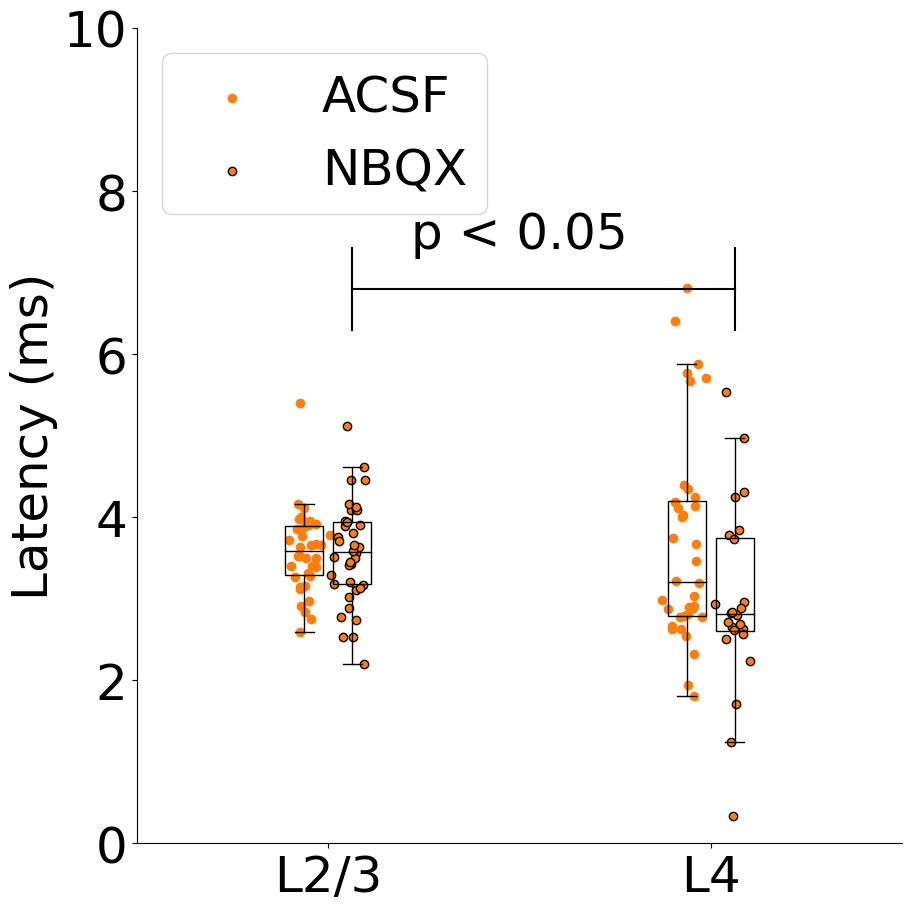

L2/3 Neighbor ACSF 3.163 +/- 0.307 um/ms
L4 Neighbor ACSF 3.566 +/- 0.528 um/ms
L2/3 Neighbor NBQX 4.736 +/- 0.466 um/ms
L4 Neighbor NBQX 1.845 +/- 0.251 um/ms
-1.0489930759269412 0.321266786584071 Neighbor L2/3 and L4 test: amp drug: ACSF
1.5017789624642124 0.18082936657356827 Neighbor L2/3 and L4 test: amp drug: NBQX
-0.80655389025548 0.4391861128825203 ACSF and NBQX test: amp layer: L2/3
-0.045672644221068724 0.9644824287394451 ACSF and NBQX test: amp layer: L4


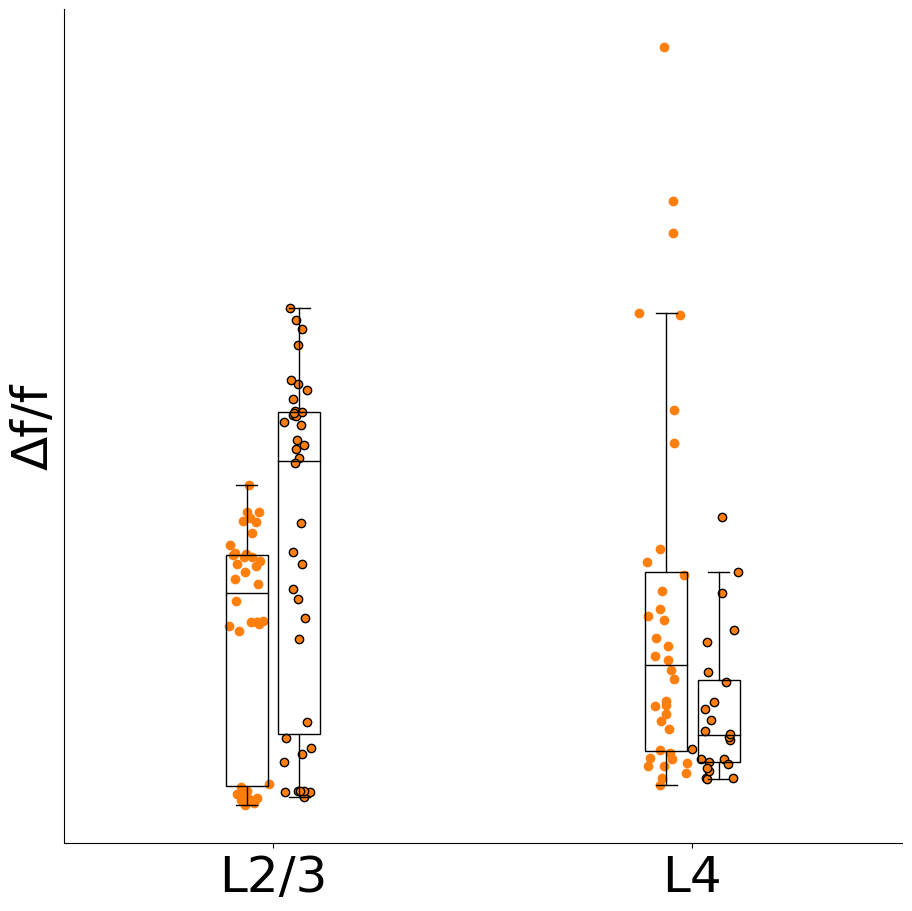

L2/3 Neighbor ACSF 10.89 +/- 0.480 um/ms
L4 Neighbor ACSF 15.33 +/- 1.401 um/ms
L2/3 Neighbor NBQX 6.016 +/- 0.292 um/ms
L4 Neighbor NBQX 9.753 +/- 1.216 um/ms
-0.41647420900989796 0.6850859648550872 Neighbor L2/3 and L4 test: halfwidth drug: ACSF
-1.7928022917630222 0.115564879874173 Neighbor L2/3 and L4 test: halfwidth drug: NBQX
1.9094607324504709 0.10873727831120794 ACSF and NBQX test: halfwidth layer: L2/3
2.5579782075966895 0.029436108032276215 ACSF and NBQX test: halfwidth layer: L4
Significant difference between ACSF and NBQX for halfwidth in L4


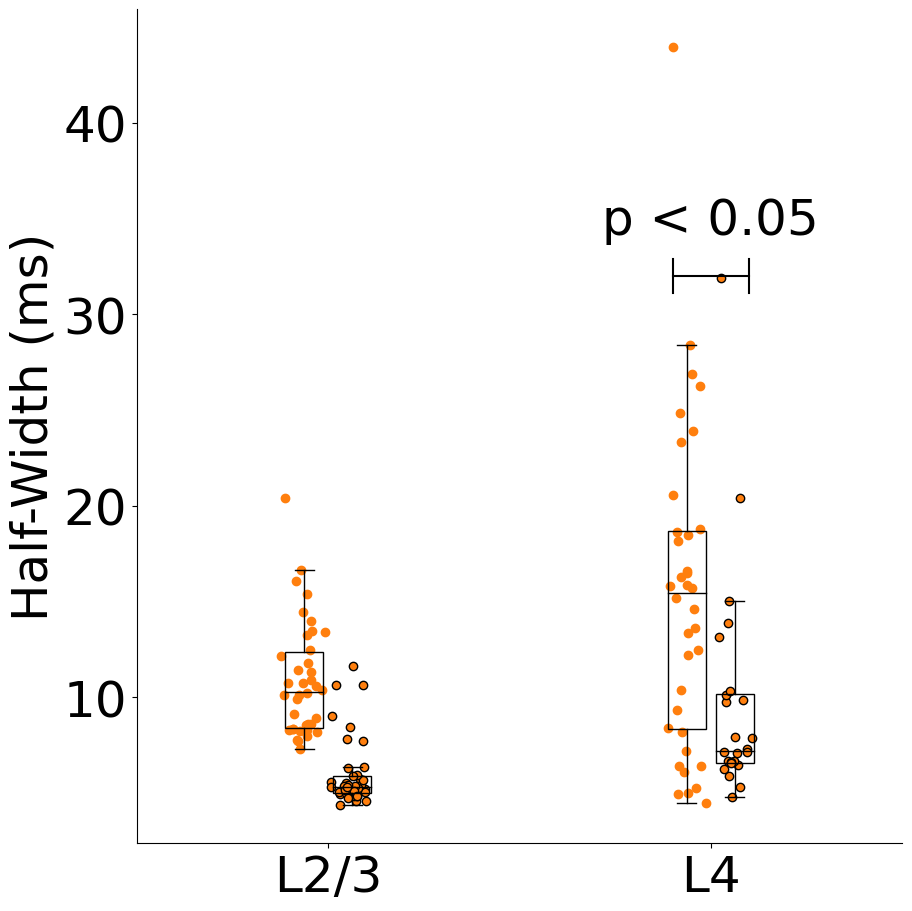

L2/3 Neighbor ACSF 115.7 +/- 5.965 um/ms
L4 Neighbor ACSF 87.59 +/- 11.09 um/ms
L2/3 Neighbor NBQX 107.8 +/- 9.015 um/ms
L4 Neighbor NBQX 70.16 +/- 15.61 um/ms
-0.7975834066793618 0.44915431395729954 Neighbor L2/3 and L4 test: instantaneous_velocity drug: ACSF
-0.7300245844778259 0.4822787328196698 Neighbor L2/3 and L4 test: instantaneous_velocity drug: NBQX
-0.6675877796242037 0.5196393222122266 ACSF and NBQX test: instantaneous_velocity layer: L2/3
-0.3974758728179336 0.6987963062368098 ACSF and NBQX test: instantaneous_velocity layer: L4


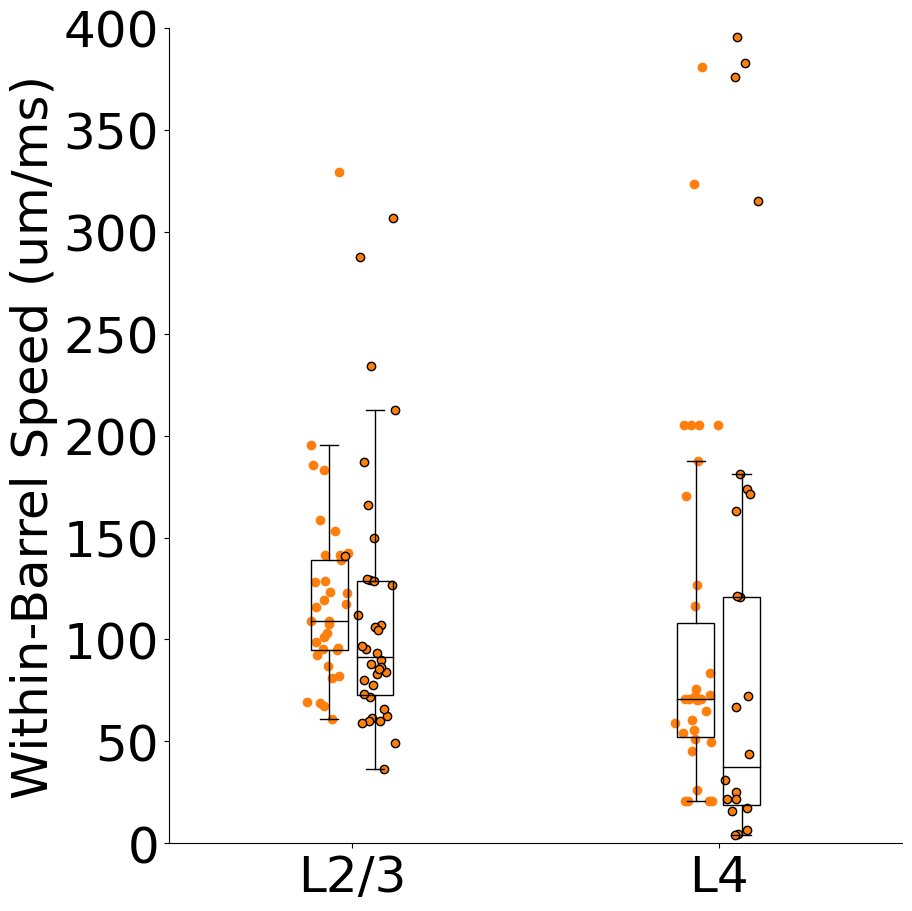

In [22]:
# make a 1-d scatter plot of the average speed
# broken down by home vs neighbor barrel and L2/3 vs L4


# matplotlib font size larger
plt.rcParams.update({'font.size': 36})

for metric, label in zip(['latency', 'amp', 'halfwidth', 'instantaneous_velocity'], 
                            ['Latency (ms)', 'Δf/f', 'Half-Width (ms)', 'Within-Barrel Speed (um/ms)']):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    layers = ['L2/3', 'L4']
    drug = ['ACSF', 'NBQX']
    # boxplots of the average speed
    for j, d in enumerate(drug):
        speeds = []
        positions = []
        for i, layer in enumerate(layers):
            for i_reg, region in enumerate(['Neighbor']):
                region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                        (ladder_df_nbqx['drug'] == d) & 
                                        (ladder_df_nbqx['resides_in_barrel'] == region)]
                speed = [s for s in list(np.abs(region_df[metric])) if not np.isnan(s)]
                if metric == 'instantaneous_velocity':
                    # remove outliers
                    speed = [s for s in speed if s < 300]
                
                speeds.append(speed)
                positions.append(i + j/8 - 1/16)
                # print the mean +/- sem of the speed
                print(layer, region, d, str(np.mean(speed))[:5], "+/-", str(sem(speed))[:5], "um/ms")
        ax.boxplot(speeds, positions=positions, 
                        showfliers=False, patch_artist=True,
                        boxprops=dict(facecolor=(0,0,0,0)),
                        widths=0.1,
                        medianprops=dict(color='black'))
        

    # scatter plot of the average speed
    for i, layer in enumerate(layers):
        for j, d in enumerate(drug):
            edgecolors= "black" if d == 'NBQX' else None
            for i_reg, region in enumerate(['Neighbor']):
                region_df = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer) & 
                                        (ladder_df_nbqx['drug'] == d) & 
                                        (ladder_df_nbqx['resides_in_barrel'] == region)]
                x_jitter = np.random.normal(i + j/8 - 1/16, 0.025, len(region_df))
                ax.scatter(x_jitter, 
                                np.abs(region_df[metric]), 
                                label=d, 
                                color='tab:blue' if region == 'Home' else 'tab:orange',
                                edgecolors=edgecolors)
                
                if metric == 'instantaneous_velocity':
                    ax.set_ylim(0, 400)
                elif metric == 'latency':
                    ax.set_ylim(0, 10)
                elif metric == 'amp':
                    # ax.set_ylim(0, 10.5)
                    ax.set_yticks([])
                elif metric == 'halfwidth':
                    pass # ax.set_ylim(0, 2.5)
                ax.set_xlim(-.5, 1.5)
                ax.set_xticks([0, 1])
                ax.set_xticklabels(layers)

    for drug_sig in ['ACSF', 'NBQX']:
        
        # is there a significant difference between neighbor L2/3 and neighbor L4? For ACSF
        neighbor_L23 = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == 'L2/3') & 
                                    (ladder_df_nbqx['resides_in_barrel'] == 'Neighbor')&
                                    (ladder_df_nbqx['drug'] == drug_sig)][metric]
        neighbor_L4 = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == 'L4') &
                                    (ladder_df_nbqx['resides_in_barrel'] == 'Neighbor') &
                                    (ladder_df_nbqx['drug'] == drug_sig)][metric]

        # average for each date/slice
        neighbor_L23 = neighbor_L23.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
        neighbor_L4 = neighbor_L4.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
        # get rid of nans
        neighbor_L23 = [s for s in list(np.abs(neighbor_L23)) if not np.isnan(s)]
        neighbor_L4 = [s for s in list(np.abs(neighbor_L4)) if not np.isnan(s)]

        t_stat, p_val = ttest_ind(neighbor_L23, neighbor_L4, equal_var=False)
        print(t_stat, p_val, "Neighbor L2/3 and L4 test:", metric, "drug:", drug_sig)
        if p_val < 0.05:  #  x 20 for pseudo-multiple testing correction
            print('Significant difference between L2/3 and L4 for ' + metric + ' in ' + drug_sig)
            # place in terms of fraction of the y-axis
            ax.text(0.5, 0.73 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0], 'p < 0.05', ha='center')
            # draw a line between the two boxes. shift it right a bit if drug_sig == 'NBQX', left if drug_sig == 'ACSF'
            drug_sig_shift = 1/16 if drug_sig == 'NBQX' else -1/16
            drug_sig_yshift = 0.02 if drug_sig == 'NBQX' else 0.0
            y_height = (0.7 - drug_sig_yshift) * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0]
            ax.plot([drug_sig_shift, 1+drug_sig_shift], [y_height, y_height], color='black') 
            
            # vertical segments at the ends of the bar to make it a bracket
            brack_cap = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.plot([drug_sig_shift, drug_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')
            ax.plot([1+drug_sig_shift, 1+drug_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')

            #ax.text(0.5, 730, 'p < 0.05', ha='center')
            # draw a line between the two boxes
            #ax.plot([0, 1], [700, 700], color='black')
            # vertical segments at the ends of the bar to make it a bracket
            #ax.plot([0, 0], [700, 650], color='black')
            #ax.plot([1, 1], [700, 650], color='black')
            #ax.plot([-.1, .1], [650, 650], color='black')
            #ax.plot([1-.1, 1+.1], [650, 650], color='black')
    for layer_sig in ['L2/3', 'L4']:
        # is there a significant difference between ACSF and NBQX for L2/3 and L4? 
        acsf = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer_sig) & 
                                (ladder_df_nbqx['resides_in_barrel'] == 'Home') &
                                (ladder_df_nbqx['drug'] == 'ACSF')][metric]
        nbqx = ladder_df_nbqx[(ladder_df_nbqx['Layer'] == layer_sig) &
                                (ladder_df_nbqx['resides_in_barrel'] == 'Home') &
                                (ladder_df_nbqx['drug'] == 'NBQX')][metric]

        # average for each date/slice
        acsf = acsf.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()
        nbqx = nbqx.groupby([ladder_df_nbqx['Date'], ladder_df_nbqx['Slice']]).mean()

        t_stat, p_val = ttest_ind(acsf, nbqx, equal_var=False)
        print(t_stat, p_val, "ACSF and NBQX test:", metric, "layer:", layer_sig)

        # get t-test for adjusted p-value
        if p_val < 0.05:
            print('Significant difference between ACSF and NBQX for ' + metric + ' in ' + layer_sig)
            # place in terms of fraction of the y-axis
            x_loc = 0 if layer_sig == 'L2/3' else 1
            ax.text(x_loc, 0.73 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0], 'p < 0.05', ha='center')
            # draw a line between the two boxes. shift it right a bit if drug_sig == 'NBQX', left if drug_sig == 'ACSF'
            layer_sig_shift = 1/10 
            
            layer_sig_yshift = 0.02 if layer_sig == 'L4' else 0.0
            y_height = (0.7 - layer_sig_yshift) * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0]
            ax.plot([x_loc - layer_sig_shift, x_loc + layer_sig_shift], [y_height, y_height], color='black') 
            
            # vertical segments at the ends of the bar to make it a bracket
            brack_cap = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.plot([x_loc - layer_sig_shift, x_loc - layer_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')
            ax.plot([x_loc + layer_sig_shift, x_loc + layer_sig_shift], [y_height-brack_cap, y_height+brack_cap], color='black')

            



    ax.set_ylabel(label)
    # set spines to be invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # legend in top left, but with only the first two labels
    handles = ax.get_legend_handles_labels()
    if metric == 'latency':
        ax.legend(handles=handles[0][:2], labels=handles[1][:2], loc='upper left')
    # tight layout
    plt.tight_layout()
    plt.savefig(output_fig_dir + '/' + metric + '.png')
    plt.show()

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\stats\_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\stats\_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\stats\_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\stats\_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\stats\_stats_mstats_common.py:174: RuntimeWarning: invalid valu

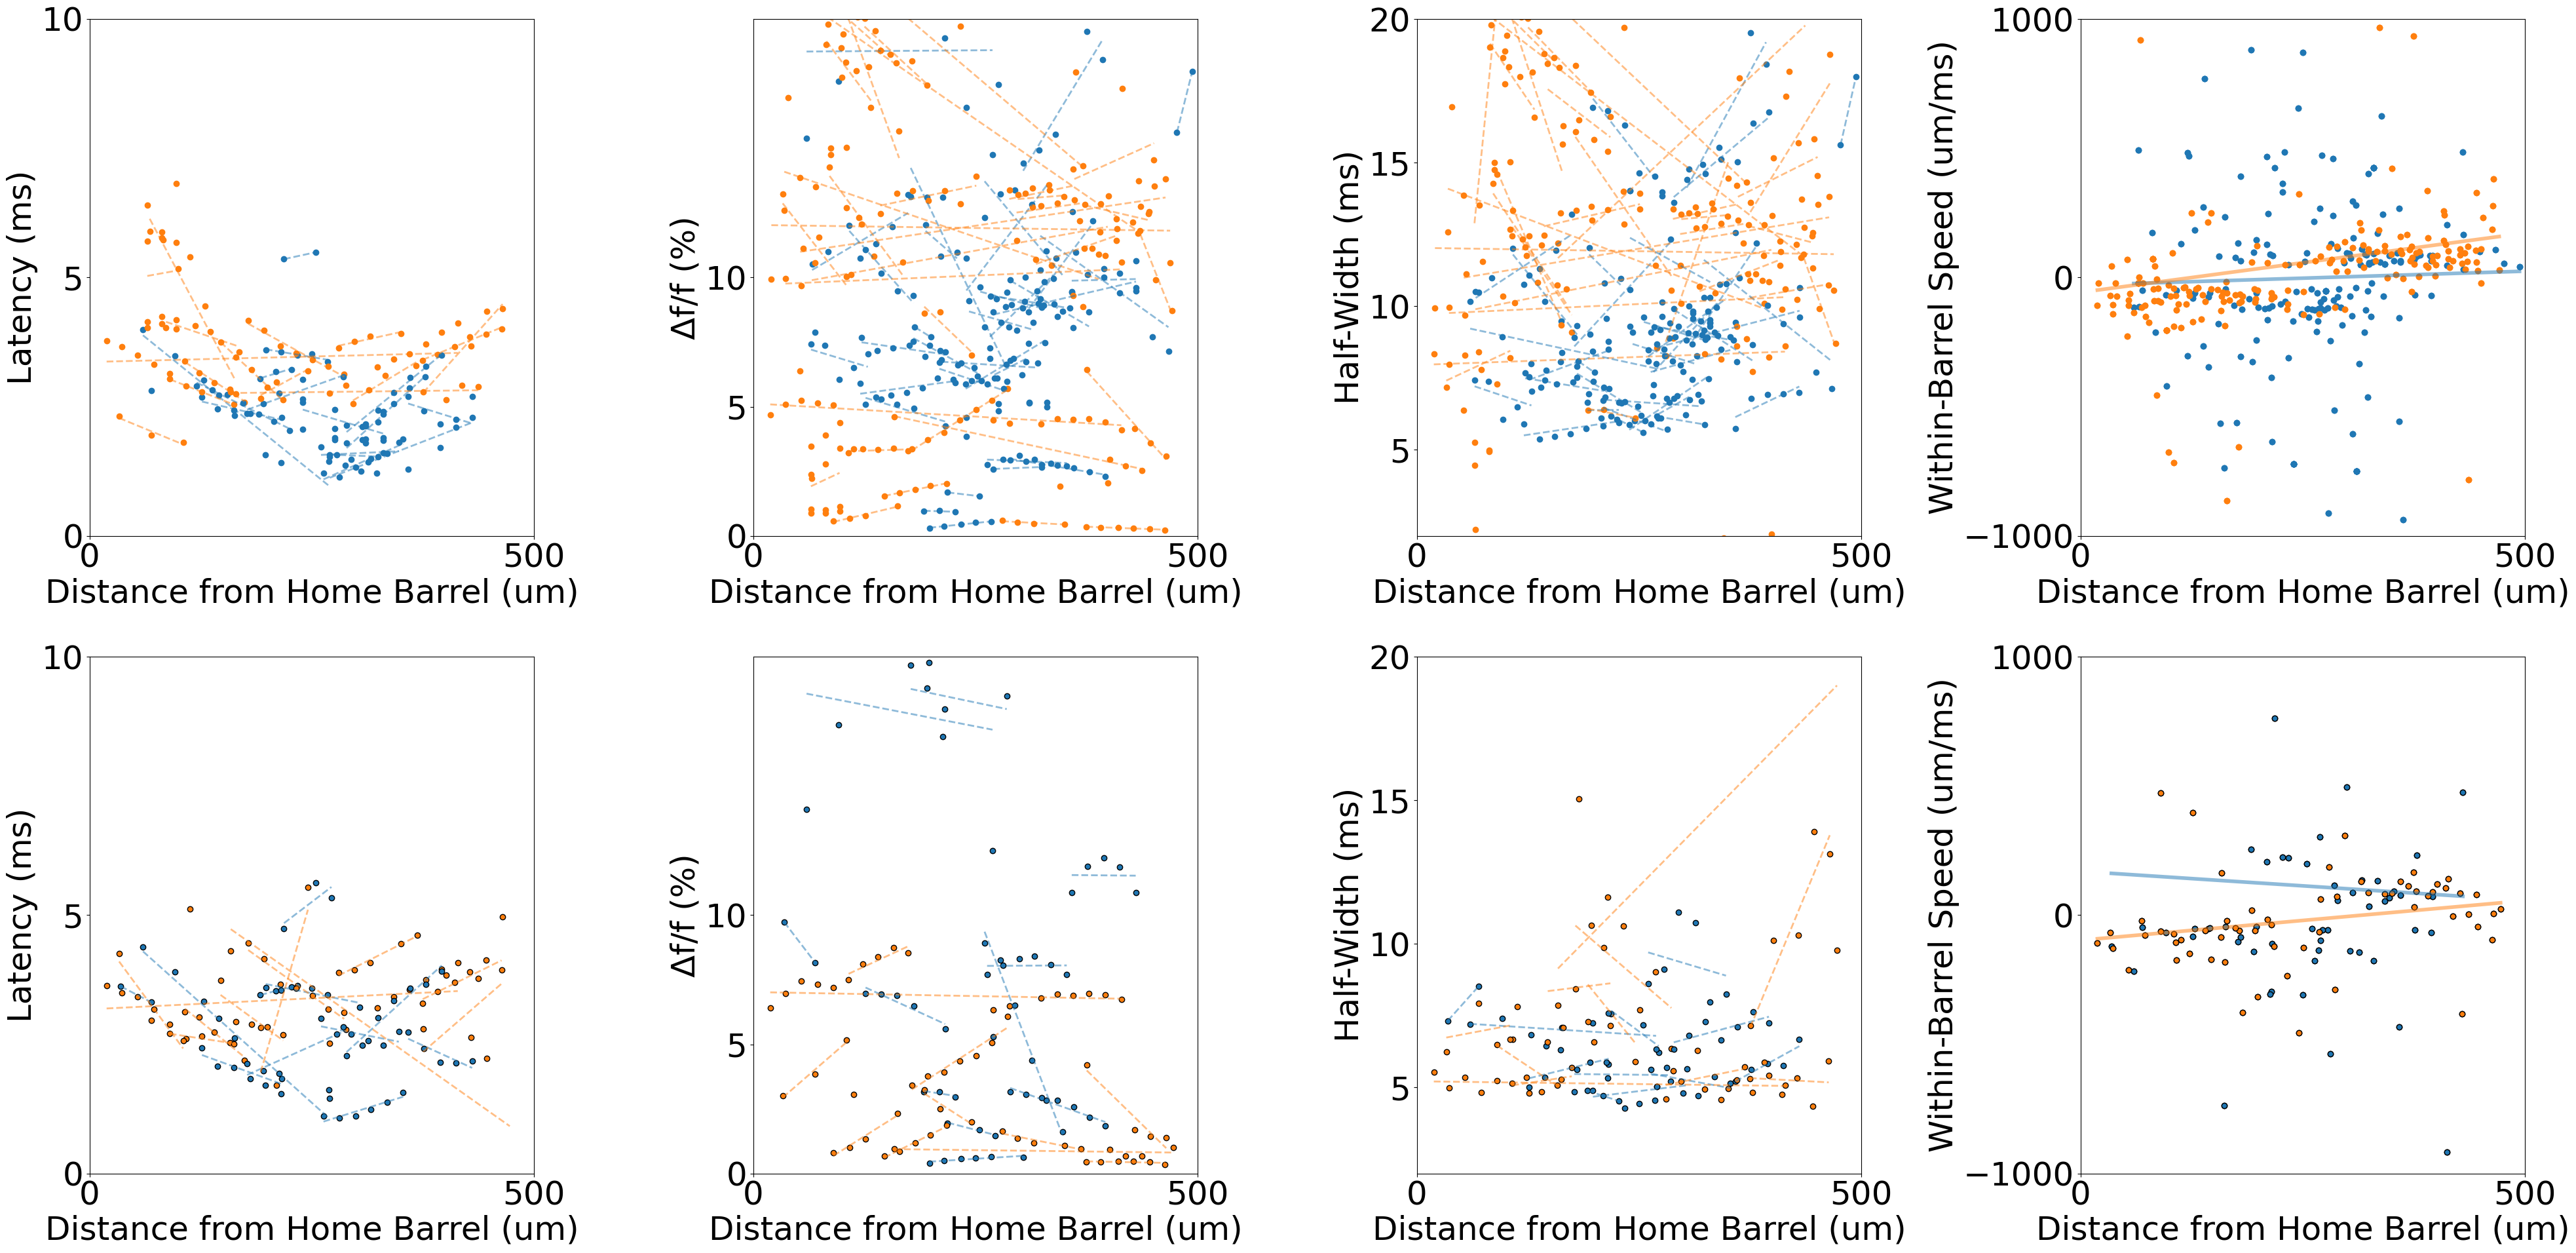

In [23]:
# show correlation of latency, halfwidth, amp, and velocity with distance from home barrel
# plot each metric vs distance from home barrel, each date/slice/recording in a different color
# with the NBQX data in markeredgecolor='black'
# fit and plot a linear regression line for each date/slice/recording

fig, ax = plt.subplots(2, 4, figsize=(40, 20))
layers = ['L2/3', 'L4']
drug = ['ACSF', 'NBQX']
handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        for i_reg, region in enumerate(['Home', 'Neighbor']):
            for date in ladder_df['Date'].unique():
                for slic in ladder_df['Slice'].unique():
                    for rec in ladder_df['Recording'].unique():

                        region_df = ladder_df[(ladder_df['Layer'] == layer) & 
                                                (ladder_df['drug'] == d) & 
                                                (ladder_df['resides_in_barrel'] == region) &
                                                (ladder_df['Date'] == date) &
                                                (ladder_df['Slice'] == slic) &
                                                (ladder_df['Recording'] == rec)]
                        # get rid of nans
                        region_df = region_df[region_df['Dist_from_home_barrel'].notna()]
                        region_df = region_df[region_df['latency'].notna()]
                        region_df = region_df[region_df['amp'].notna()]
                        region_df = region_df[region_df['halfwidth'].notna()]
                        region_df = region_df[region_df['instantaneous_velocity'].notna()]

                        if region_df.empty:
                            continue

                        # fit a linear regression line to the data
                        slope, intercept, r_value, p_value, std_err = linregress(region_df['Dist_from_home_barrel'], 
                                                                                    region_df['latency'])
                        x = np.linspace(region_df['Dist_from_home_barrel'].min(), 
                                        region_df['Dist_from_home_barrel'].max(), 100)
                        y = slope * x + intercept
                        
                        # plot the data and the line
                        color = 'tab:blue' if region == 'Home' else 'tab:orange'
                        edgecolors= "black" if d == 'NBQX' else None
                        
                        ax[j][0].scatter(region_df['Dist_from_home_barrel'], 
                                        region_df['latency'], 
                                        label=d, 
                                        color=color,
                                        edgecolors=edgecolors,
                                        marker='o')
                        
                        ax[j][0].plot(x, y, color=color, linestyle='--', linewidth=2, alpha=0.5)

                        # now do the same for amp
                        slope, intercept, r_value, p_value, std_err = linregress(region_df['Dist_from_home_barrel'], 
                                                                                    region_df['amp'])
                        x = np.linspace(region_df['Dist_from_home_barrel'].min(), 
                                        region_df['Dist_from_home_barrel'].max(), 100)
                        y = slope * x + intercept

                        ax[j][1].scatter(region_df['Dist_from_home_barrel'], 
                                        region_df['amp'], 
                                        label=d, 
                                        color=color,
                                        edgecolors=edgecolors,
                                        marker='o')

                        ax[j][1].plot(x, y, color=color, linestyle='--', linewidth=2, alpha=0.5)
                        # now do the same for halfwidth
                        slope, intercept, r_value, p_value, std_err = linregress(region_df['Dist_from_home_barrel'], 
                                                                                    region_df['halfwidth'])
                        x = np.linspace(region_df['Dist_from_home_barrel'].min(), 
                                        region_df['Dist_from_home_barrel'].max(), 100)
                        y = slope * x + intercept
                        ax[j][2].scatter(region_df['Dist_from_home_barrel'], 
                                        region_df['halfwidth'], 
                                        label=d, 
                                        color=color,
                                        edgecolors=edgecolors,
                                        marker='o')

                        ax[j][2].plot(x, y, color=color, linestyle='--', linewidth=2, alpha=0.5)
                        
                        # now do the same for velocity
                        slope, intercept, r_value, p_value, std_err = linregress(region_df['Dist_from_home_barrel'], 
                                                                                    region_df['instantaneous_velocity'])
                        x = np.linspace(region_df['Dist_from_home_barrel'].min(),
                                        region_df['Dist_from_home_barrel'].max(), 100)
                        y = slope * x + intercept
                        ax[j][3].scatter(region_df['Dist_from_home_barrel'], 
                                        region_df['instantaneous_velocity'], 
                                        label=d, 
                                        color=color,
                                        edgecolors=edgecolors,
                                        marker='o')
                                        
                        #ax[j][3].plot(x, y, color=color, linestyle='--', linewidth=2, alpha=0.5)
                        # print the slope and r^2 value for each metric
                        '''print(layer, region, d, 'Latency', str(slope)[:5], str(r_value**2)[:5])
                        print(layer, region, d, 'Amp', str(slope)[:5], str(r_value**2)[:5])
                        print(layer, region, d, 'Halfwidth', str(slope)[:5], str(r_value**2)[:5])
                        print(layer, region, d, 'Velocity', str(slope)[:5], str(r_value**2)[:5])
                        # print the p-value for each metric
                        print(layer, region, d, 'Latency', str(p_value)[:5])
                        print(layer, region, d, 'Amp', str(p_value)[:5])
                        print(layer, region, d, 'Halfwidth', str(p_value)[:5])
                        print(layer, region, d, 'Velocity', str(p_value)[:5])
                        # print the std_err for each metric
                        print(layer, region, d, 'Latency', str(std_err)[:5])
                        print(layer, region, d, 'Amp', str(std_err)[:5])
                        print(layer, region, d, 'Halfwidth', str(std_err)[:5])
                        print(layer, region, d, 'Velocity', str(std_err)[:5])
                        # print the number of points for each metric
                        print(layer, region, d, 'Latency', len(region_df['latency']))
                        print(layer, region, d, 'Amp', len(region_df['amp']))
                        print(layer, region, d, 'Halfwidth', len(region_df['halfwidth']))
                        print(layer, region, d, 'Velocity', len(region_df['instantaneous_velocity']))
                        # print the mean and std of each metric
                        print(layer, region, d, 'Latency', str(np.mean(region_df['latency']))[:5], str(np.std(region_df['latency']))[:5])
                        print(layer, region, d, 'Amp', str(np.mean(region_df['amp']))[:5], str(np.std(region_df['amp']))[:5])
                        print(layer, region, d, 'Halfwidth', str(np.mean(region_df['halfwidth']))[:5], str(np.std(region_df['halfwidth']))[:5])
                        print(layer, region, d, 'Velocity', str(np.mean(region_df['instantaneous_velocity']))[:5], str(np.std(region_df['instantaneous_velocity']))[:5])
                        '''
                        # save plot to file
                        #ax[0].set_title('Latency vs Distance from Home Barrel')
                        #ax[1].set_title('Amp vs Distance from Home Barrel')
                        #ax[2].set_title('Halfwidth vs Distance from Home Barrel')
                        #ax[3].set_title('Velocity vs Distance from Home Barrel')
                        ax[j][0].set_xlabel('Distance from Home Barrel (um)')
                        ax[j][1].set_xlabel('Distance from Home Barrel (um)')
                        ax[j][2].set_xlabel('Distance from Home Barrel (um)')
                        ax[j][3].set_xlabel('Distance from Home Barrel (um)')
                        ax[j][0].set_ylabel('Latency (ms)')
                        ax[j][1].set_ylabel('Δf/f (%)')
                        ax[j][2].set_ylabel('Half-Width (ms)')
                        ax[j][3].set_ylabel('Within-Barrel Speed (um/ms)')
                        ax[j][0].set_ylim(0, 8)
                        ax[j][1].set_ylim(0, 20)
                        ax[j][2].set_ylim(2, 20)
                        ax[j][3].set_ylim(-1000, 1000)
                        ax[j][0].set_xlim(0, 500)
                        ax[j][1].set_xlim(0, 500)
                        ax[j][2].set_xlim(0, 500)
                        ax[j][3].set_xlim(0, 500)
                        ax[j][0].set_xticks([0, 500])
                        ax[j][1].set_xticks([0, 500])
                        ax[j][2].set_xticks([0, 500])
                        ax[j][3].set_xticks([0, 500])
                        ax[j][0].set_xticklabels([ 0, 500])
                        ax[j][1].set_xticklabels([ 0, 500])   
                        ax[j][2].set_xticklabels([ 0, 500])
                        ax[j][3].set_xticklabels([ 0, 500])
                        ax[j][0].set_yticks([0, 5, 10])
                        ax[j][1].set_yticks([0, 5, 10])
                        ax[j][3].set_yticks([-1000, 0, 1000])
                        ax[j][0].set_yticklabels([0, 5, 10])

# Is there overall correlation between velocity and distance from home barrel?
# fit a single linear regression line to all data points (drug, region-specific)
for i_reg, region in enumerate(['Home', 'Neighbor']):
    for j, d in enumerate(drug):
        region_df = ladder_df[(ladder_df['drug'] == d) & 
                                (ladder_df['resides_in_barrel'] == region)]
        # get rid of nans
        region_df = region_df[region_df['Dist_from_home_barrel'].notna()]
        region_df = region_df[region_df['latency'].notna()]
        region_df = region_df[region_df['amp'].notna()]
        region_df = region_df[region_df['halfwidth'].notna()]
        region_df = region_df[region_df['instantaneous_velocity'].notna()]

        if region_df.empty:
            continue

        # fit a linear regression line to the data
        slope, intercept, r_value, p_value, std_err = linregress(region_df['Dist_from_home_barrel'], 
                                                                    region_df['instantaneous_velocity'])
        x = np.linspace(region_df['Dist_from_home_barrel'].min(), 
                        region_df['Dist_from_home_barrel'].max(), 100)
        y = slope * x + intercept
        
        # plot the data and the line
        color = 'tab:blue' if region == 'Home' else 'tab:orange'
        edgecolors= "black" if d == 'NBQX' else None
        
        ax[j][3].scatter(region_df['Dist_from_home_barrel'], 
                        region_df['instantaneous_velocity'], 
                        label=d, 
                        color=color,
                        edgecolors=edgecolors,
                        marker='o')
        
        ax[j][3].plot(x, y, color=color, linewidth=4, alpha=0.5)


plt.tight_layout()          
plt.savefig(output_fig_dir + '/' + layer + '_' + region + '_' + d + '_latency_vs_distance.png')
plt.show()


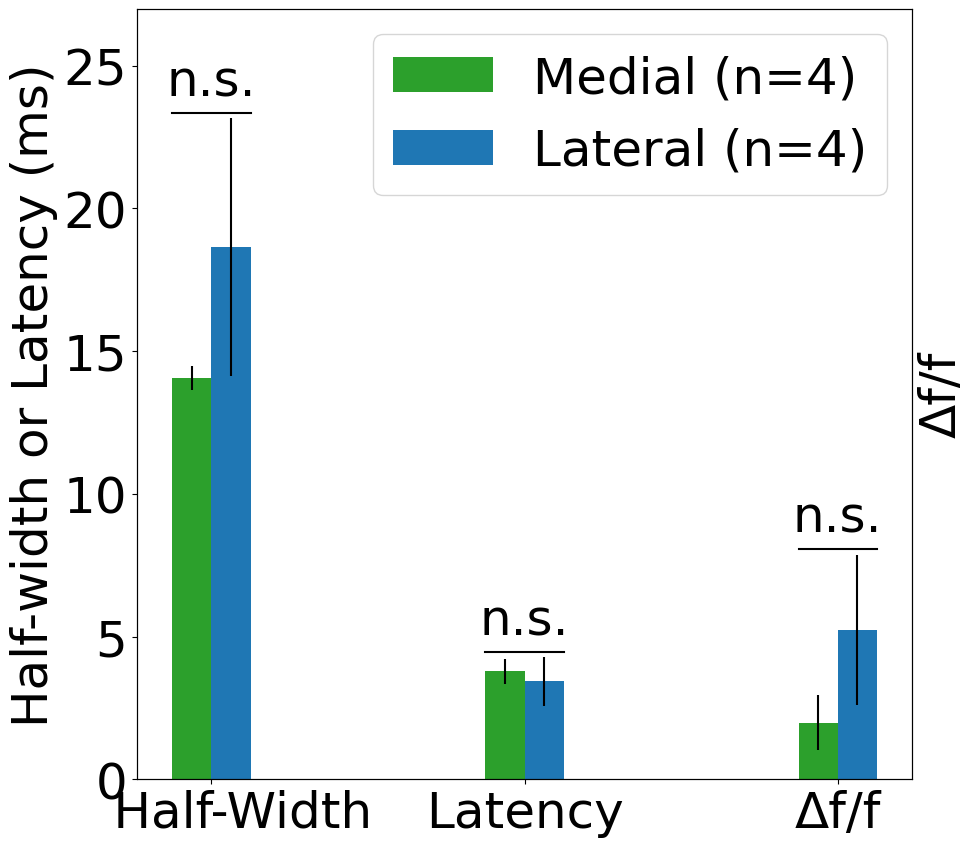

In [24]:
# using the 'Medial/Lateral' column in file export_summar_hw_latency_amp.csv, compare medial and lateral neighbor barrels
# for each layer and drug
# read in hw/lat/amp data
hw_lat_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6

# plot the data that has 'Medial/Lateral' column populated. Restrict to L4 and ACSF and neighbor barrels (ROI > 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only for L4, not for L2/3. Compare latency, half-width, and amplitude for medial vs lateral neighbor barrels
directions = ['Medial', 'Lateral']
handles = []

for i, direction in enumerate(directions):
    color = 'tab:blue' if direction == 'Lateral' else 'tab:green'
    for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
        # get the data for the direction
        direction_df = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & 
                                (hw_lat_df['drug'] == 'ACSF') & 
                                (hw_lat_df['ROI'] > 1) & 
                                (hw_lat_df['Medial/Lateral'] == direction)]
        # plot the data
        l1 = ax.bar(j + i / 8 - 1/16, 
                        np.mean(direction_df[metric]), 
                        yerr=sem(direction_df[metric]), 
                        width=.125,
                        color=color, label=direction)
        handles.append(l1)

# legend: Medial in black, Lateral in green
ax.legend(handles=[handles[0], handles[-1]], labels=['Medial (n=4)', 'Lateral (n=4)'], loc='upper right')

ax.set_ylabel('Half-width or Latency (ms)')
# right-side y-axis label
ax2 = ax.twinx()
ax2.set_ylabel('Δf/f')
ax2.set_yticks([])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['    Half-Width', 'Latency', 'Δf/f'])

# significance testing Medial vs Lateral
for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
    med = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & 
                                        (hw_lat_df['drug'] == 'ACSF') & 
                                        (hw_lat_df['ROI'] > 1) & 
                                        (hw_lat_df['Medial/Lateral'] == 'Medial')][metric]
    lat = hw_lat_df[(hw_lat_df['Layer'] == 'L4') &
                                        (hw_lat_df['drug'] == 'ACSF') &
                                        (hw_lat_df['ROI'] > 1) &
                                        (hw_lat_df['Medial/Lateral'] == 'Lateral')][metric]
    t_stat, p_val = ttest_ind(med, lat, equal_var=False)
    # draw bar between the two boxes # ax.get_ylim()[1] * 0.8
    height = max(med.mean() + sem(med), lat.mean() + sem(lat)) + 0.2

    ax.plot([j - 1/8, j + 1/8], [height, height], color='black')
    if p_val < 0.05:
        ax.text(j, height + .6, 'p < 0.05', ha='center')

        
    else:
        ax.text(j, height + .6, 'n.s.', ha='center')

# raise the y-axis limit by 10% to make room for the significance testing
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)


plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp_medial_lateral.png')
plt.show()

In [25]:
# for each row in ladder_df, populate drug, layer, and Medial/Lateral columns by looking it up in hw_lat_df
for i, row in ladder_df.iterrows():
    date = row['Date']
    slic = row['Slice']
    rec = row['Recording']
    loc = row['Location']
    ladder_roi = row['ROI']
    x_center = row['X_Center']
    y_center = row['Y_Center']

    # to know which barrel roi this is in, find the closest roi in the hw_lat_df

    hw_lat_rows = hw_lat_df[(hw_lat_df['Date'] == date) &
                            (hw_lat_df['Slice'] == slic) &
                            (hw_lat_df['Location'] == loc) &
                            (hw_lat_df['Recording'] == rec)]
            
    
    if hw_lat_rows.empty:
        print('No data found for ', date, slic, rec, loc)
        continue

    # go through the matched rows, pull x_center and y_center, and calculate the distance to the ladder roi
    min_dist = np.Inf
    min_dist_row = None
    for j, hw_lat_row in hw_lat_rows.iterrows():
        dist = np.sqrt((x_center - hw_lat_row['X_Center'])**2 + (y_center - hw_lat_row['Y_Center'])**2)
        if dist < min_dist:
            min_dist = dist
            min_dist_row = hw_lat_row
    if min_dist_row is None:
        print('No data found for ', date, slic, rec, loc)
        continue
    # populate the drug, layer, and Medial/Lateral columns in ladder_df from the min_dist_row
    ladder_df.loc[i, 'drug'] = min_dist_row['drug']
    ladder_df.loc[i, 'Layer'] = min_dist_row['Layer']
    ladder_df.loc[i, 'Medial/Lateral'] = min_dist_row['Medial/Lateral']

print(ladder_df['Medial/Lateral'])

ladder_df

No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 1 1
No data found for  6/26/2024 1 4 1
No data found for  6/26/2024 1 4 1
No data found for  6/26/2024 1 4 1
No data found for  6/26/2024 1 4 1
No data found for  6/26/2024 1 4 1
No data found for  6/26/2024 1 4 1
No data found for  6

ROI        amp      snr  latency  halfwidth  Stim_Distance   X_Center  \
0       1   0.408552  19.7128   3.9030    16.6507     272.917570  34.263889   
1       2   0.462050  27.5393   3.9159    14.4435     256.320112  36.851351   
2       3   0.441868  28.2700   3.8743    13.6368     239.774894  38.767123   
3       4   0.466602  22.1134   3.8636    13.2221     223.293529  40.816901   
4       5   0.526346  26.8669   3.7651    10.1029     206.891276  43.818182   
...   ...        ...      ...      ...        ...            ...        ...   
1424   22  10.513800      NaN  32.4017    10.5138      87.361319  68.000000   
1425   23  10.499200      NaN  32.5608    10.4992      93.914855  71.000000   
1426   24  11.141100      NaN  32.6341    11.1411     103.227903  74.000000   
1427   25  10.717900      NaN  32.7312    10.7179     114.629839  77.000000   
1428   26  11.365600      NaN  32.8025    11.3656     127.561750  79.000000   

       Y_Center                        ROI_Set       Date  ...  Location  \
0     10.236111          1_roi_output__ladder_  6/26/2024  ...         1   
1     12.054054          1_roi_output__ladder_  6/26/2024  ...         1   
2     14.273973          1_roi_output__ladder_  6/26/2024  ...         1   
3     16.338028          1_roi_output__ladder_  6/26/2024  ...         1   
4     17.766234          1_roi_output__ladder_  6/26/2024  ...         1   
...         ...                            ...        ...  ...       ...   
1424  42.000000  3_rois_output__ladder_ pulse1  4/16/2025  ...         2   
1425  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...         2   
1426  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...         2   
1427  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...         2   
1428  42.500000  3_rois_output__ladder_ pulse1  4/16/2025  ...         2   

      Recording                                              trace  \
0             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
1             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
2             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
3             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
4             1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
...         ...                                                ...   
1424          1                                                NaN   
1425          1                                                NaN   
1426          1                                                NaN   
1427          1                                                NaN   
1428          1                                                NaN   

     Dist_from_home_barrel  resides_in_barrel instantaneous_velocity  \
0               368.804275           Neighbor                    NaN   
1               350.406813           Neighbor             422.912185   
2               332.813666               None            1626.003658   
3               315.415427           Neighbor             183.157884   
4               297.374375           Neighbor             139.073187   
...                    ...                ...                    ...   
1424             66.068147               Home            -113.564718   
1425             48.000000               None            -245.566166   
1426             30.000000               None            -185.375901   
1427             12.000000               None            -168.302945   
1428              0.000000               None                    NaN   

                                               ROI file  drug Layer  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  ACSF  L2/3   
...         

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[117.70583955160473, 187.4638415291147, 118.93944074219237, 170.5597212643176, 126.70191910840396, 3997.225160452277, 151.4037962848741, 113.35012594458482, 120.40133779264521, 146.93877551020987, 145.96287808143225, 181.41662083464098, 336.3651847531535, 395.4736394150895, 174.00070129006517, 473.35561110624974, 104.83153161222222, 87.08272859216045, 48.609235754793374, 246.23803009574672, 26.135570143023877, 54.01100012772474, 77.97458347194969, 54.26241040210428, 51.205855554515566, 48.68206481799609, 51.33938277032127, 186.2670131098011, 202.0056240606084, 43.776104296305036, 382.78384186378156, 2263.236960774644, 138.1004607255306, 31.083512527059266, 140.08196376029332, 90.25333517901655, 188.0096358935616, 265.37993749139304, 70.6742403444782, 75.46509206978398, 49.67029895327767, 72.39821903086364, 60.38737274892658, 45.34198729766184, 139.24730484383522, 457.6681878446055, 791.039473446256, 132.7732118859409, 101.78962302954889, 82.82100984276695, 174.68592979359116, 47.889079

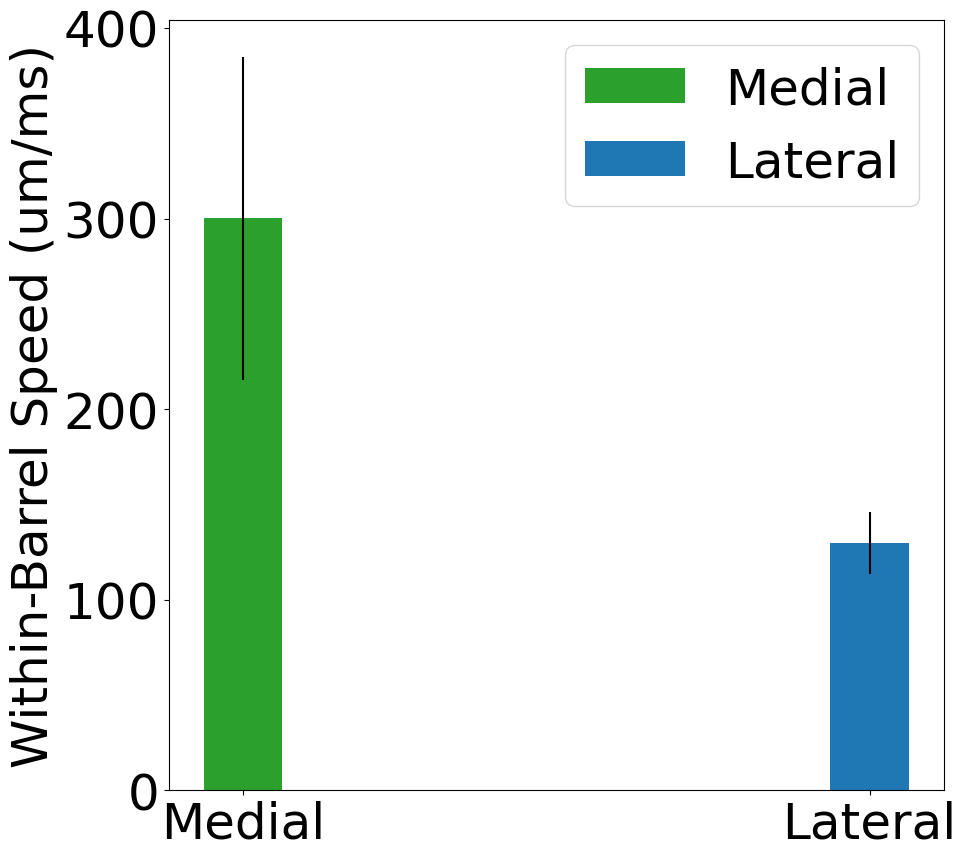

In [26]:
# compare medial vs lateral: speed



fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot speeds for ladder_df, split into L2/3 and L4, and only for neighbor barrels (ROI > 1) in ACSF
directions = ['Medial', 'Lateral']
handles = []

for i, direction in enumerate(directions):
    color = 'tab:blue' if direction == 'Lateral' else 'tab:green'
    direction_df = ladder_df[(ladder_df['Layer'] == 'L4') & 
                                #(ladder_df['drug'] == 'ACSF') & 
                                (ladder_df['ROI'] > 1) & 
                                (ladder_df['Medial/Lateral'] == direction)]
    # plot the data
    l1 = ax.bar(i, 
                    np.mean(np.abs(direction_df["instantaneous_velocity"])), 
                    yerr=sem(np.abs(direction_df["instantaneous_velocity"])), 
                    width=.125,
                    color=color, label=direction)
    handles.append(l1)

# legend: Lateral in blue, Medial in green
ax.legend(handles=[handles[0], handles[-1]], labels=['Medial', 'Lateral'], loc='upper right')

ax.set_ylabel('Within-Barrel Speed (um/ms)')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Medial', 'Lateral'])

# significance testing Medial vs Lateral
med = ladder_df[(ladder_df['Layer'] == 'L4') & 
                                #(ladder_df['drug'] == 'ACSF') & 
                                (ladder_df['ROI'] > 1) & 
                                (ladder_df['Medial/Lateral'] == 'Medial')]["instantaneous_velocity"]

lat = ladder_df[(ladder_df['Layer'] == 'L4') &
                                #(ladder_df['drug'] == 'ACSF') &
                                (ladder_df['ROI'] > 1) &
                                (ladder_df['Medial/Lateral'] == 'Lateral')]["instantaneous_velocity"]

# filter out nans from med and lat
med = [s for s in list(np.abs(med)) if not np.isnan(s)]
lat = [s for s in list(np.abs(lat)) if not np.isnan(s)]

print(list(med), "\n", list(lat))

t_stat, p_val = ttest_ind(med, lat, alternative='greater', equal_var=False)
print("p =", p_val)

# errorbars
ax.errorbar(0, np.mean(med), yerr=sem(med), fmt='', color='black')
ax.errorbar(1, np.mean(lat), yerr=sem(lat), fmt='', color='black')


plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/velocity_medial_lateral.png')
plt.show()


In [27]:
# now let's repeat the same analysis for L2/3 readout
# read in the supragranular data
supra_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_supragranular.csv"
supra_df = pd.read_csv(supra_dir)
supra_df['latency'] -= 48.6

# reformat Dat to match the format of the hw/lat/amp data
supra_df['Date'] = supra_df['Date'].apply(lambda x: x.replace('-', '/'))
# convert from m/d/yy to m/d/yyyy
supra_df['Date'] = supra_df['Date'].apply(lambda x: x[:-2] + '20' + x[-2:])

# merge with crossing_data to get the 'Medial/Lateral', 'Layer', and 'drug' columns. 
# append _supra to column names in the supra_df
hw_lat_df_metadata = hw_lat_df[['Date', 'Slice', 'Recording', 'Location', 'Layer', 'drug', 'Medial/Lateral']]
supra_df = supra_df.merge(hw_lat_df_metadata, on=['Date', 'Slice', 'Location', 'Recording'])

supra_df

ROI       amp       snr  latency  halfwidth  Stim_Distance   X_Center  \
0      1  0.457087  32.53260   1.7484   10.68250      81.608823  38.209677   
1      1  0.457087  32.53260   1.7484   10.68250      81.608823  38.209677   
2      2  0.274570  10.66380   2.3245   11.36730     165.517371  21.765217   
3      2  0.274570  10.66380   2.3245   11.36730     165.517371  21.765217   
4      1  0.911748  19.74610   1.8831    8.93258      81.608823  38.209677   
..   ...       ...       ...      ...        ...            ...        ...   
123    2  4.646450  21.31610   3.9587   18.61850     205.406913  76.285714   
124    1  4.884740  22.38250   3.6901    7.39750     158.858428  67.032258   
125    1  4.884740  22.38250   3.6901    7.39750     158.858428  67.032258   
126    2  2.450560   8.86932   3.3752   11.95010     205.406913  76.285714   
127    2  2.450560   8.86932   3.3752   11.95010     205.406913  76.285714   

      Y_Center               ROI_Set        Date  Slice  Location  Recording  \
0    49.080645   1_roi_supragranular   6/26/2024      1         1          1   
1    49.080645   1_roi_supragranular   6/26/2024      1         1          1   
2    36.182609   1_roi_supragranular   6/26/2024      1         1          1   
3    36.182609   1_roi_supragranular   6/26/2024      1         1          1   
4    49.080645   1_roi_supragranular   6/26/2024      1         1          4   
..         ...                   ...         ...    ...       ...        ...   
123  40.857143  2_rois_supragranular  12/20/2024      2         1          1   
124  59.658065  2_rois_supragranular  12/20/2024      2         3          1   
125  59.658065  2_rois_supragranular  12/20/2024      2         3          1   
126  40.857143  2_rois_supragranular  12/20/2024      2         3          1   
127  40.857143  2_rois_supragranular  12/20/2024      2         3          1   

                                                 trace Layer  drug  \
0    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
1    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
2    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
3    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
4    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  NBQX   
..                                                 ...   ...   ...   
123  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  ACSF   
124  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   
125  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   
126  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   
127  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   

    Medial/Lateral  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
..             ...  
123        Lateral  
124            NaN  
125        Lateral  
126            NaN  
127        Lateral  

[128 rows x 17 columns]

In [28]:
# remove duplicate rows from supra_df
supra_df = supra_df.drop_duplicates(subset=['Date', 'Slice', 'Recording', 'Location', 'ROI', 'drug', 'Layer' ])
supra_df

ROI       amp       snr  latency  halfwidth  Stim_Distance   X_Center  \
0      1  0.457087  32.53260   1.7484   10.68250      81.608823  38.209677   
2      2  0.274570  10.66380   2.3245   11.36730     165.517371  21.765217   
4      1  0.911748  19.74610   1.8831    8.93258      81.608823  38.209677   
6      2  0.484146   7.40288   3.4801    8.44907     165.517371  21.765217   
8      1  3.270350  33.91330   0.9119   11.40020      80.498447  62.298578   
..   ...       ...       ...      ...        ...            ...        ...   
118    2  2.384470  14.94280   5.0873    7.64868     181.394597  19.813559   
120    1  9.195530  33.09190   3.1583   11.94090     158.858428  67.032258   
122    2  4.646450  21.31610   3.9587   18.61850     205.406913  76.285714   
124    1  4.884740  22.38250   3.6901    7.39750     158.858428  67.032258   
126    2  2.450560   8.86932   3.3752   11.95010     205.406913  76.285714   

      Y_Center               ROI_Set        Date  Slice  Location  Recording  \
0    49.080645   1_roi_supragranular   6/26/2024      1         1          1   
2    36.182609   1_roi_supragranular   6/26/2024      1         1          1   
4    49.080645   1_roi_supragranular   6/26/2024      1         1          4   
6    36.182609   1_roi_supragranular   6/26/2024      1         1          4   
8    24.469194  3_rois_supragranular    7/1/2024      3         2          1   
..         ...                   ...         ...    ...       ...        ...   
118  11.943503  1_rois_supragranular  12/20/2024      1         3          2   
120  59.658065  2_rois_supragranular  12/20/2024      2         1          1   
122  40.857143  2_rois_supragranular  12/20/2024      2         1          1   
124  59.658065  2_rois_supragranular  12/20/2024      2         3          1   
126  40.857143  2_rois_supragranular  12/20/2024      2         3          1   

                                                 trace Layer  drug  \
0    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
2    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
4    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  NBQX   
6    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  NBQX   
8    C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...  L2/3  ACSF   
..                                                 ...   ...   ...   
118  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...  L2/3  NBQX   
120  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  ACSF   
122  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  ACSF   
124  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   
126  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...    L4  NBQX   

    Medial/Lateral  
0              NaN  
2              NaN  
4              NaN  
6              NaN  
8              NaN  
..             ...  
118            NaN  
120            NaN  
122            NaN  
124            NaN  
126            NaN  

[64 rows x 17 columns]

x_location_bar = -0.15625
x_location_bar = -0.09375

results for home latency in L4stim with ACSF, L2/3 vs L4:
T= 2.2584157744370668 p= 0.038239502971290563
sample size for Supragranular barrel:  9
sample size for Granular barrel:  9
mean +/- sem for Supragranular barrel:  2.61 ± 0.15
mean +/- sem for Granular barrel:  2.02 ± 0.21
x_location_bar = 0.09375
x_location_bar = 0.15625

results for neighbor latency in L4stim with ACSF, L2/3 vs L4:
T= -1.4418794736653746 p= 0.16750568213143743
sample size for Supragranular barrel:  10
sample size for Granular barrel:  9
mean +/- sem for Supragranular barrel:  2.94 ± 0.17
mean +/- sem for Granular barrel:  3.54 ± 0.4
x_location_bar = -0.15625
x_location_bar = -0.09375

results for home latency in L2/3stim with ACSF, L2/3 vs L4:
T= -3.2102530263962668 p= 0.009328041035193255
sample size for Supragranular barrel:  6
sample size for Granular barrel:  6
mean +/- sem for Supragranular barrel:  1.29 ± 0.17
mean +/- sem for Granular barrel:  3.2 ± 0.

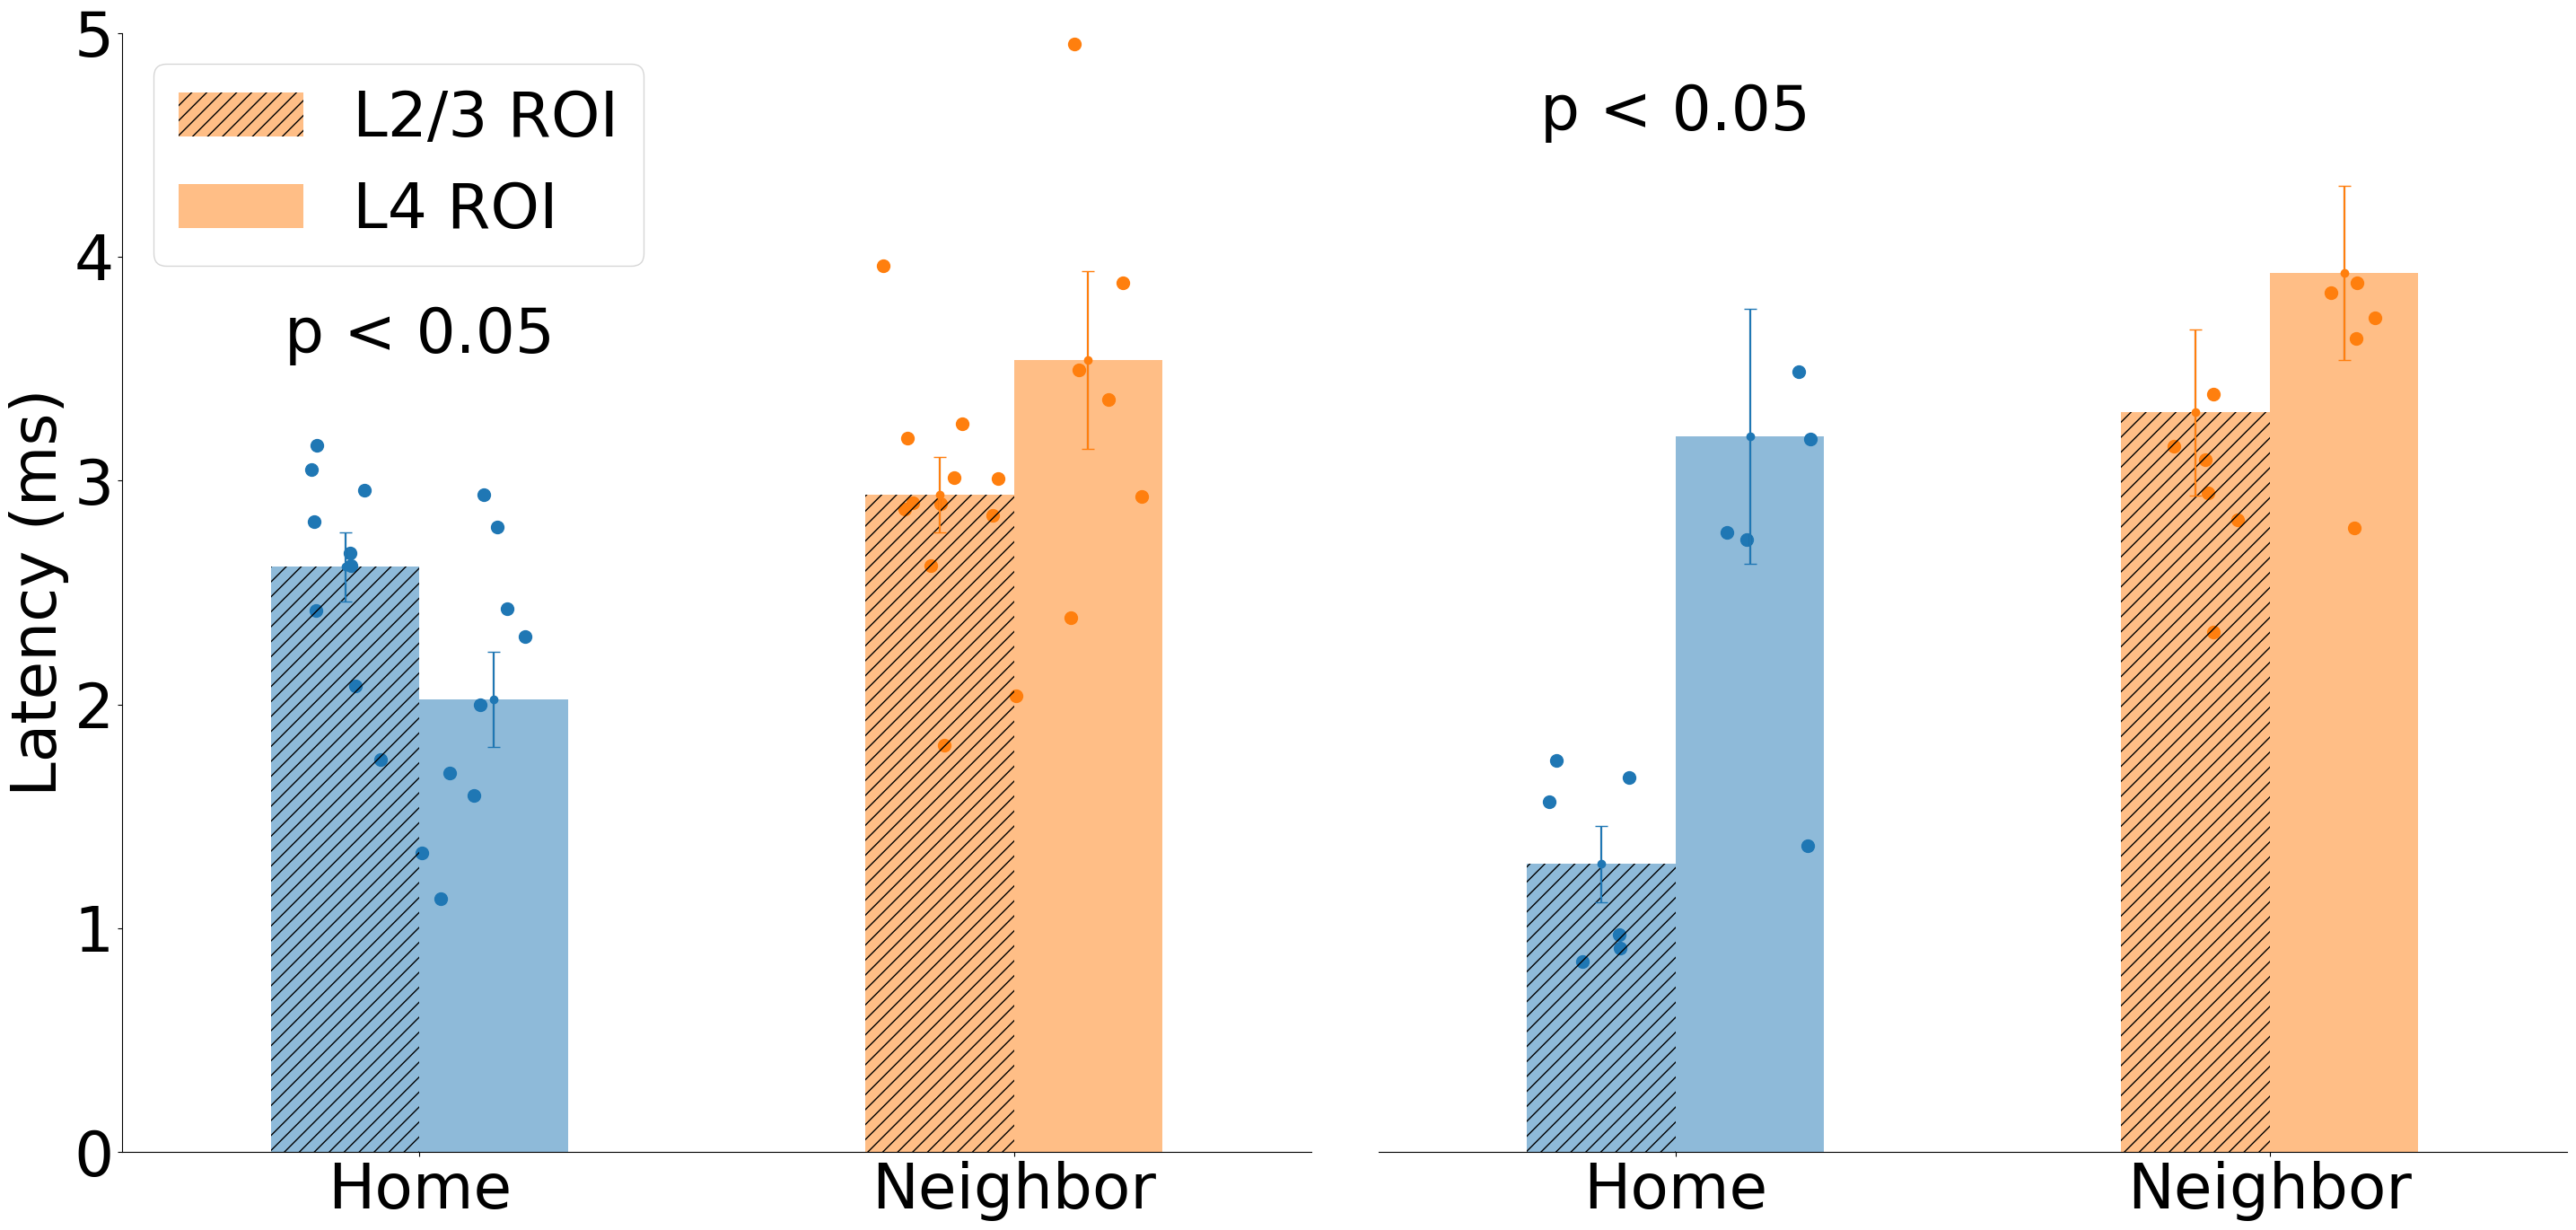

In [29]:
# compare the supra data (supra_df) to the L4 data (hw_lat_df):
#       for ACSF and NBQX, and for L2/3 and L4 stim, and for home versus neighbor
# leave out Medial/Lateral comparison for now
# do latency, half-width, amplitude, comparing supra to L4, for all four of the following plots:
#  - plot 1 home barrel in L4 stim: ACSF vs NBQX
#  - plot 2 neighbor barrel in L4 stim: ACSF vs NBQX
#  - plot 3 home barrel in L2/3 stim: ACSF vs NBQX
#  - plot 4 neighbor barrel in L2/3 stim: ACSF vs NBQX
plt.rcParams.update({'font.size': 50})
fig, ax = plt.subplots(1, 2, figsize=(30, 15))

# plot 1 home barrel in L4 stim: ACSF vs NBQX
layers = ['L4', 'L2/3']
drug = ['ACSF', 'NBQX']
home_neighbor = ['home', 'neighbor']
regions = ['Supragranular', 'Granular']
metrics = ['latency'] #,'halfwidth',  'amp']
metric_labels = ['Latency (ms)', ] #'Half-Width (ms)', 'Δf/f']
handles = ['', '', '', '']
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        if d == 'NBQX':
            continue
        for k, home in enumerate(home_neighbor):
            region_dfs = []
            for m, region in enumerate(regions):
                df = supra_df if region == 'Supragranular' else hw_lat_df
                hatch = '//' if region == 'Supragranular' else None
                color = 'tab:blue' if home == 'home' else 'tab:orange'
                
                region_df = df[(df['Layer'] == layer) & 
                                    (df['drug'] == d)]
                if home == 'home':
                    region_df = region_df[region_df['ROI'] == 1]
                else:
                    region_df = region_df[region_df['ROI'] > 1]
                region_dfs.append(region_df)

                x_location_bar = 1/16 * m - 1/32 + k/4 - 1/8
                print("x_location_bar =", x_location_bar)
                for l, metric in enumerate(metrics):
                    h = ax[i].bar(x_location_bar, 
                                    np.mean(region_df[metric]), 
                                    yerr=sem(region_df[metric]), 
                                    width=.125 / 2,
                                    color=color, label='L4' if region == 'Granular' else 'Supragranular', hatch=hatch, alpha=0.5)

                    # add error bars
                    ax[i].errorbar(x_location_bar,
                                np.mean(region_df[metric]),
                                yerr=sem(region_df[metric]),
                                fmt='o', color=color, capsize=5)
                    # add jitter to x-axis for scatter plot
                    x_jitter = np.random.normal(x_location_bar, 0.015, len(region_df[metric]))
                    # plot the data
                    ax[i].scatter(x_jitter, region_df[metric],
                                    color=color, s=100, marker='o')
                    ax[i].set_xticks([-1/8, 1/8 ])
                    ax[i].set_xticklabels(['Home', 'Neighbor'])
                    ax[0].set_ylabel('Latency (ms)' )
                    ax[i].set_xlim(-0.25, 0.25 + 0.5 * (len(metrics)-1))

                    #ax[i][k].set_title(home + ' barrel' + ' with ' + layer + ' stim')
                    ax[i].set_ylim(0, 5 + 5 * (len(metrics)-1))

                    # turn off spines
                    ax[i].spines['top'].set_visible(False)
                    ax[i].spines['right'].set_visible(False)
                    ax[1].spines['left'].set_visible(False)
                    ax[1].set_yticks([])

                    if d == 'ACSF':
                        if region == 'Supragranular':
                            handles[0] = h
                        else:
                            handles[1] = h
                    if region == 'Supragranular':
                        if d == 'ACSF':
                            handles[2] = h
                        else:
                            handles[3] = h

            # significance testing: home vs neighbor barrel
            for l, metric in enumerate(metrics):
                t_stat, p_val = ttest_ind(region_dfs[0][metric], region_dfs[1][metric])
                if not (metric == 'latency' and d == 'ACSF'):
                    continue
                print("\nresults for " +home+ " " + metric + " in " + layer + "stim with " + d + ", L2/3 vs L4:")
                print("T=", t_stat, "p=", p_val)
                print("sample size for Supragranular barrel: ", len(region_dfs[0][metric]))
                print("sample size for Granular barrel: ", len(region_dfs[1][metric]))
                print("mean +/- sem for Supragranular barrel: ",
                        round(region_dfs[0][metric].mean(), 2), "±", 
                        round(sem(region_dfs[0][metric]), 2))
                print("mean +/- sem for Granular barrel: ",
                        round(region_dfs[1][metric].mean(), 2), "±", 
                        round(sem(region_dfs[1][metric]), 2))
                height = max(region_dfs[0][metric].mean() + sem(region_dfs[0][metric]), 
                                region_dfs[1][metric].mean() + sem(region_dfs[1][metric])) + 0.2
                if p_val < 0.05 and d != 'NBQX':
                    ax[i].text( k/4 - 1/8, height + .6, 'p < 0.05', ha='center', fontsize=50)
                

# legend in top left, but with only the first two labels
ax[0].legend(handles=handles[:2], labels=['L2/3 ROI', 'L4 ROI'] + drug, loc='upper left')
plt.tight_layout()
plt.savefig(output_fig_dir + 'supra_vs_L4' + '_'.join(metrics) + '.png')
plt.show()



results for halfwidth with L4 stim, home versus neighbor (L4 ROIs):
T = -2.663174093401087 p = 0.012235732857539141
sample size for home barrel:  8
sample size for neighbor barrel:  9
mean +/- sem for home barrel:  8.8 ± 0.74
mean +/- sem for neighbor barrel:  15.22 ± 2.29

results for amp with L4 stim, home versus neighbor (L4 ROIs):
T = 1.662928500704462 p = 0.06137886052224368
sample size for home barrel:  9
sample size for neighbor barrel:  9
mean +/- sem for home barrel:  9.34 ± 2.78
mean +/- sem for neighbor barrel:  4.17 ± 1.38

results for halfwidth with L2/3 stim, home versus neighbor (L4 ROIs):
T = -1.9991353959426477 p = 0.04219503115568603
sample size for home barrel:  6
sample size for neighbor barrel:  6
mean +/- sem for home barrel:  8.07 ± 1.43
mean +/- sem for neighbor barrel:  14.59 ± 2.93

results for amp with L2/3 stim, home versus neighbor (L4 ROIs):
T = 0.4727222722461211 p = 0.32503288628359384
sample size for home barrel:  6
sample size for neighbor barrel:  6


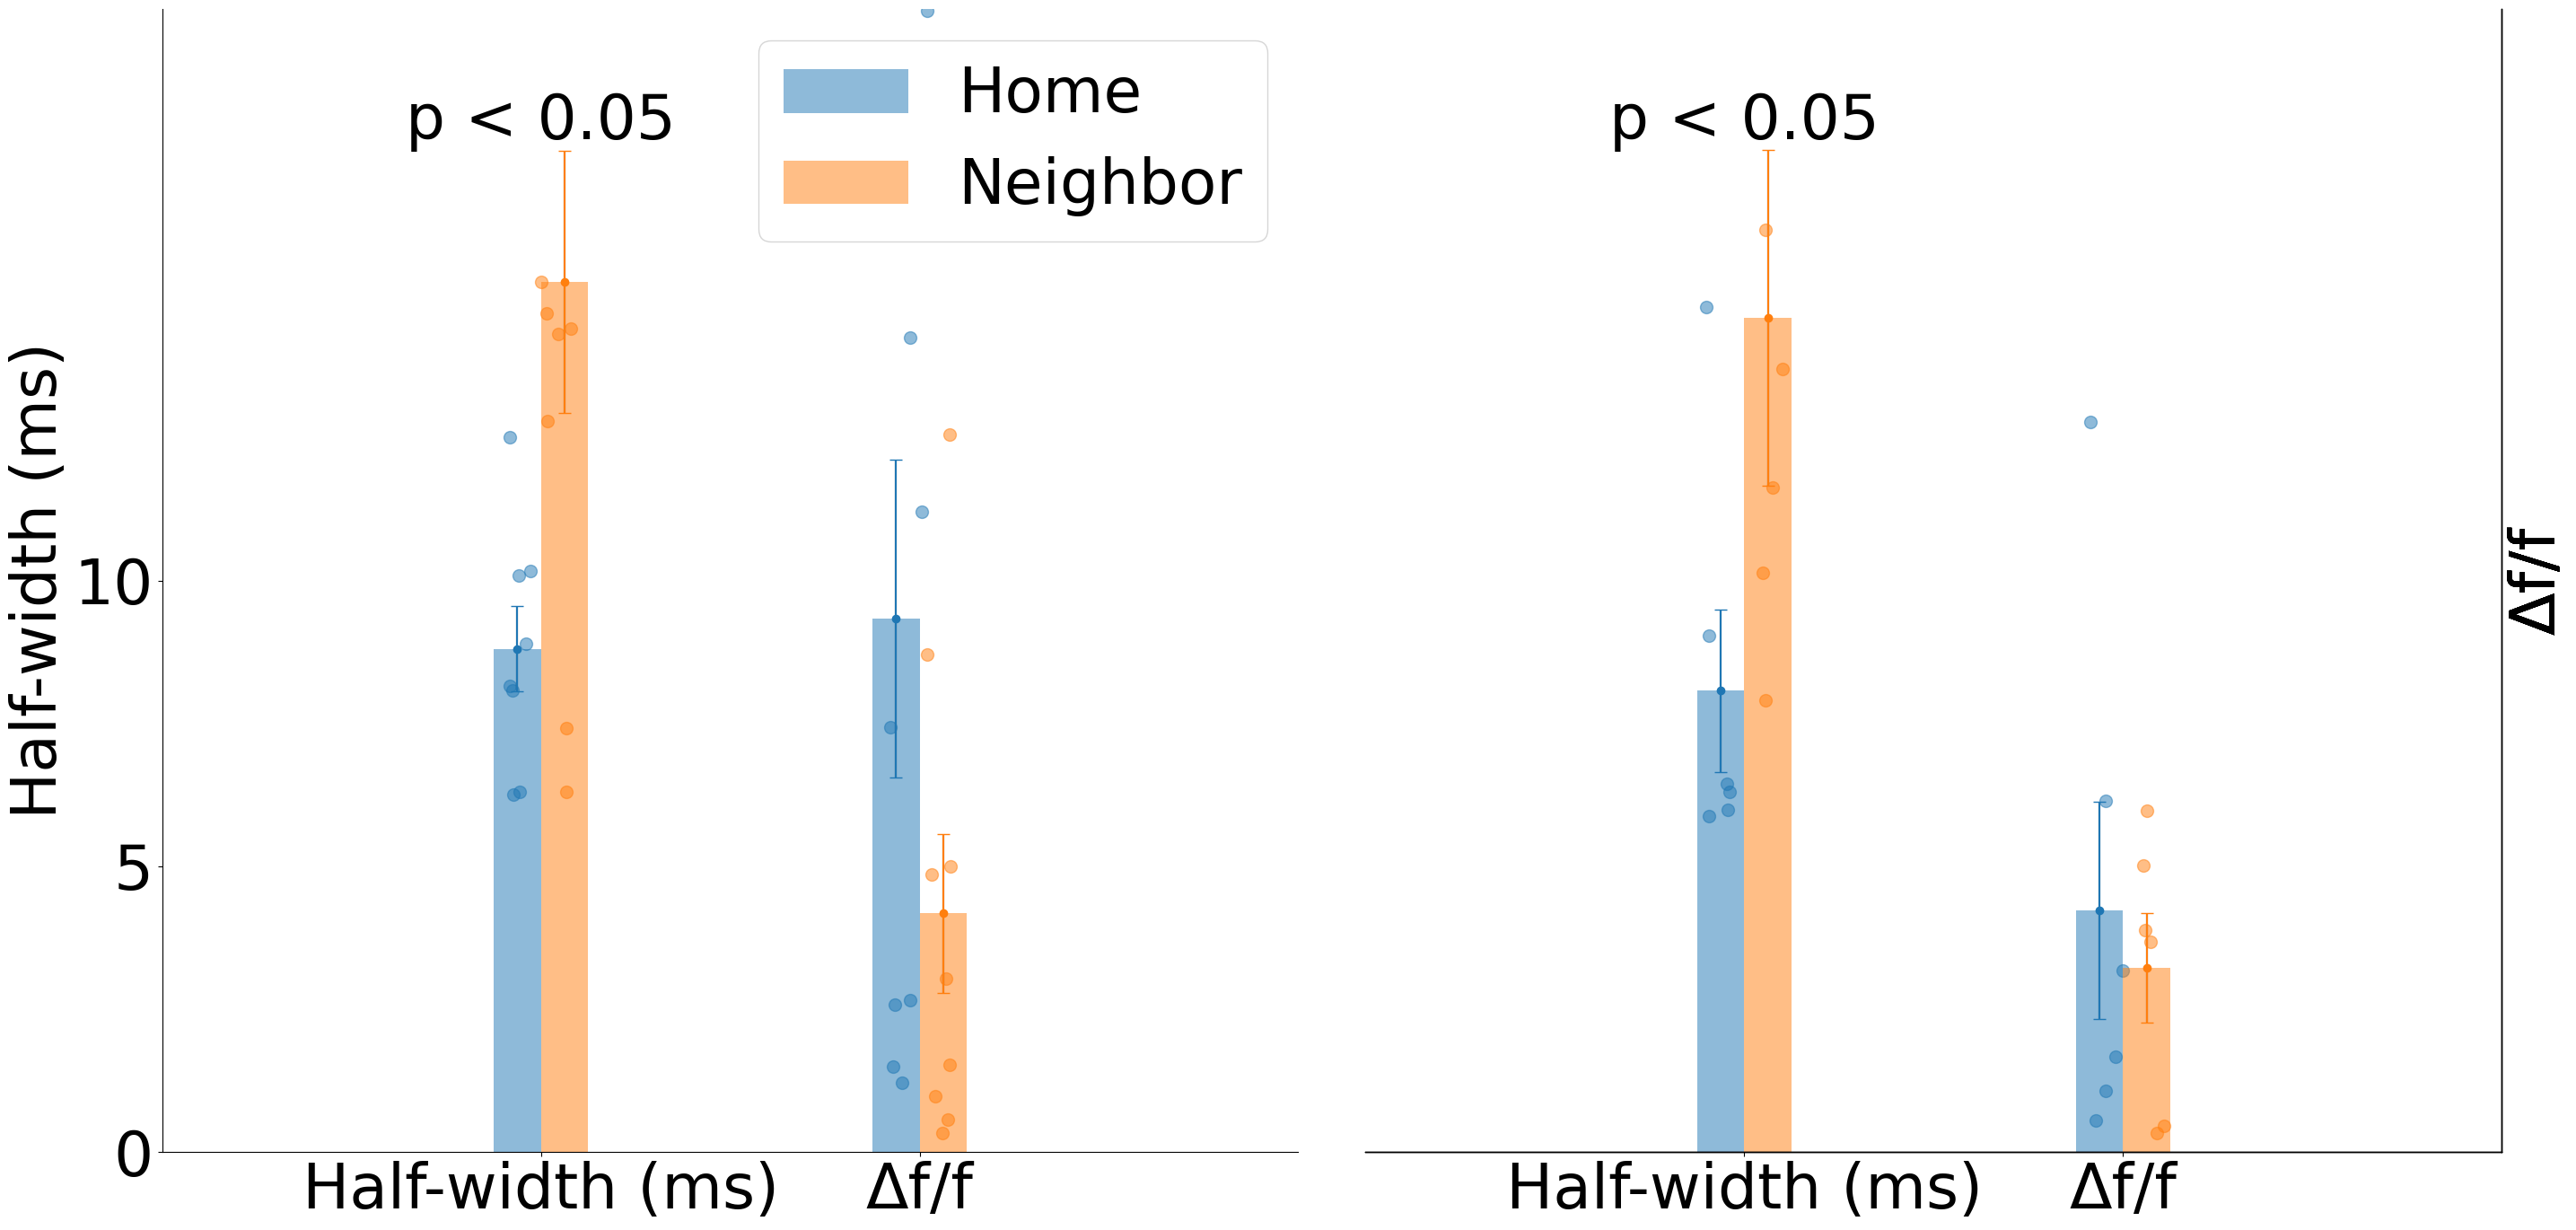

In [30]:
# compare the supra data (supra_df) to the L4 data (hw_lat_df):
#       for ACSF and NBQX, and for L2/3 and L4 stim, and for home versus neighbor
# leave out Medial/Lateral comparison for now
# do latency, half-width, amplitude, comparing supra to L4, for all four of the following plots:
#  - plot 1 home barrel in L4 stim: ACSF vs NBQX
#  - plot 2 neighbor barrel in L4 stim: ACSF vs NBQX
#  - plot 3 home barrel in L2/3 stim: ACSF vs NBQX
#  - plot 4 neighbor barrel in L2/3 stim: ACSF vs NBQX
plt.rcParams.update({'font.size': 50})
fig, ax = plt.subplots(1, 2, figsize=(30, 15))

# plot 1 home barrel in L4 stim: ACSF vs NBQX
layers = ['L4', 'L2/3']
drug = ['ACSF', 'NBQX']
home_neighbor = ['home', 'neighbor']
regions = ['Supragranular', 'Granular']
metrics = ['halfwidth',  'amp']
metric_labels = ['Half-width (ms)', 'Δf/f']
handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        if d == 'NBQX':
            continue
        region_dfs = []
        for k, home in enumerate(home_neighbor):
            
            for m, region in enumerate(regions):
                if region == 'Supragranular':
                    continue
                df = supra_df if region == 'Supragranular' else hw_lat_df
                hatch = '//' if d == 'NBQX' else None
                color = 'tab:blue' if home == 'home' else 'tab:orange'
                
                region_df = df[(df['Layer'] == layer) & 
                                    (df['drug'] == d)]
                if home == 'home':
                    region_df = region_df[region_df['ROI'] == 1]
                else:
                    region_df = region_df[region_df['ROI'] > 1]
                region_dfs.append(region_df)

                for l, metric in enumerate(metrics):
                    x_location_bar = l/2 + j/4 + k/16 - 1/32
                    #print("x_location_bar =", x_location_bar)
                    h = ax[i].bar(x_location_bar, 
                                    np.mean(region_df[metric].dropna()), 
                                    yerr=sem(region_df[metric].dropna()), 
                                    width=.125 / 2,
                                    color=color, label=home.capitalize(), hatch=hatch, alpha=0.5)
                    handles.append(h)

                    # add error bars
                    ax[i].errorbar(x_location_bar,
                                np.mean(region_df[metric].dropna()),
                                yerr=sem(region_df[metric].dropna()),
                                fmt='o', color=color, capsize=5)
                    # add jitter to x-axis for scatter plot
                    x_jitter = np.random.normal(x_location_bar, 0.015, len(region_df[metric].dropna()))
                    # plot the data
                    ax[i].scatter(x_jitter, region_df[metric].dropna(),
                                    color=color, alpha=0.5, s=100, marker='o')
                    ax[i].set_xticks([0, 0.5])
                    ax[i].set_xticklabels(metric_labels)
                    ax[0].set_ylabel('Half-width (ms)' )
                    ax[i].set_xlim(-0.5, 0.5 + 0.5 * (len(metrics)-1))
                    # label other side as Δf/f
                    ax2 = ax[1].twinx()
                    ax2.set_ylabel('Δf/f')
                    ax2.set_yticks([])
                    ax2.spines['left'].set_visible(False)
                    ax2.spines['top'].set_visible(False)
                    ax[1].set_yticks([])
                    #ax[i][k].set_title(home + ' barrel' + ' with ' + layer + ' stim')
                    ax[i].set_ylim(0, 5 + 5 * (len(metrics)+1))

                    # turn off spines
                    ax[i].spines['top'].set_visible(False)

        # significance testing: home vs neighbor barrel
        for l, metric in enumerate(metrics):
            # exclude nans from the data
            alt = 'greater' if metric == 'amp' else 'less'
            t_stat, p_val = ttest_ind(region_dfs[0][metric].dropna(), region_dfs[1][metric].dropna(), equal_var=False, alternative=alt)
            if not (d == 'ACSF'):
                continue
            print("\nresults for " + metric + " with " + layer + " stim, home versus neighbor (L4 ROIs):")
            print('T =', t_stat, 'p =', p_val)
            print("sample size for home barrel: ", len(region_dfs[0][metric].dropna()))
            print("sample size for neighbor barrel: ", len(region_dfs[1][metric].dropna()))
            #print(region_dfs[0][metric], region_dfs[1][metric])
            print("mean +/- sem for home barrel: ",
                    round(region_dfs[0][metric].dropna().mean(), 2), "±", 
                    round(sem(region_dfs[0][metric].dropna()), 2))
            print("mean +/- sem for neighbor barrel: ",
                    round(region_dfs[1][metric].dropna().mean(), 2), "±", 
                    round(sem(region_dfs[1][metric].dropna()), 2))
            height = max(region_dfs[0][metric].dropna().mean() + sem(region_dfs[0][metric].dropna()), 
                            region_dfs[1][metric].dropna().mean() + sem(region_dfs[1][metric].dropna())) + 0.2
            if p_val < 0.05 and d != 'NBQX':
                ax[i].text(0 if metric == 'halfwidth' else 0.5, height, 'p < 0.05', ha='center', fontsize=50)
                
# spines: turn off top and right spines for both axes
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_yticks([0, 5, 10])


# legend in top left, but with only the first two labels
ax[0].legend(handles=[handles[0], handles[-1]], labels=['Home', 'Neighbor'] + drug, loc='upper right')
plt.tight_layout()
plt.savefig(output_fig_dir + 'supra_vs_L4' + '_'.join(metrics) + '.png')
plt.show()



results for 1-samp t-test amp with L4 stim, home versus neighbor (L4 ROIs):
T = -3.6750964981741787 p = 0.0031316364242624474
sample size for home barrel:  9
mean +/- sem for home barrel:  0.52 ± 0.13

results for amp with L4 stim, home versus neighbor (L4 ROIs):
T = 1.662928500704462 p = 0.06137886052224368
sample size for home barrel:  9
sample size for neighbor barrel:  9
mean +/- sem for home barrel:  9.34 ± 2.78
mean +/- sem for neighbor barrel:  4.17 ± 1.38

results for halfwidth with L4 stim, home versus neighbor (L4 ROIs):
T = -2.663174093401087 p = 0.012235732857539141
sample size for home barrel:  8
sample size for neighbor barrel:  9
mean +/- sem for home barrel:  8.8 ± 0.74
mean +/- sem for neighbor barrel:  15.22 ± 2.29

results for 1-samp t-test amp with L2/3 stim, home versus neighbor (L4 ROIs):
T = -0.09360115981189322 p = 0.46453050269475454
sample size for home barrel:  6
mean +/- sem for home barrel:  0.97 ± 0.28

results for amp with L2/3 stim, home versus neighbor

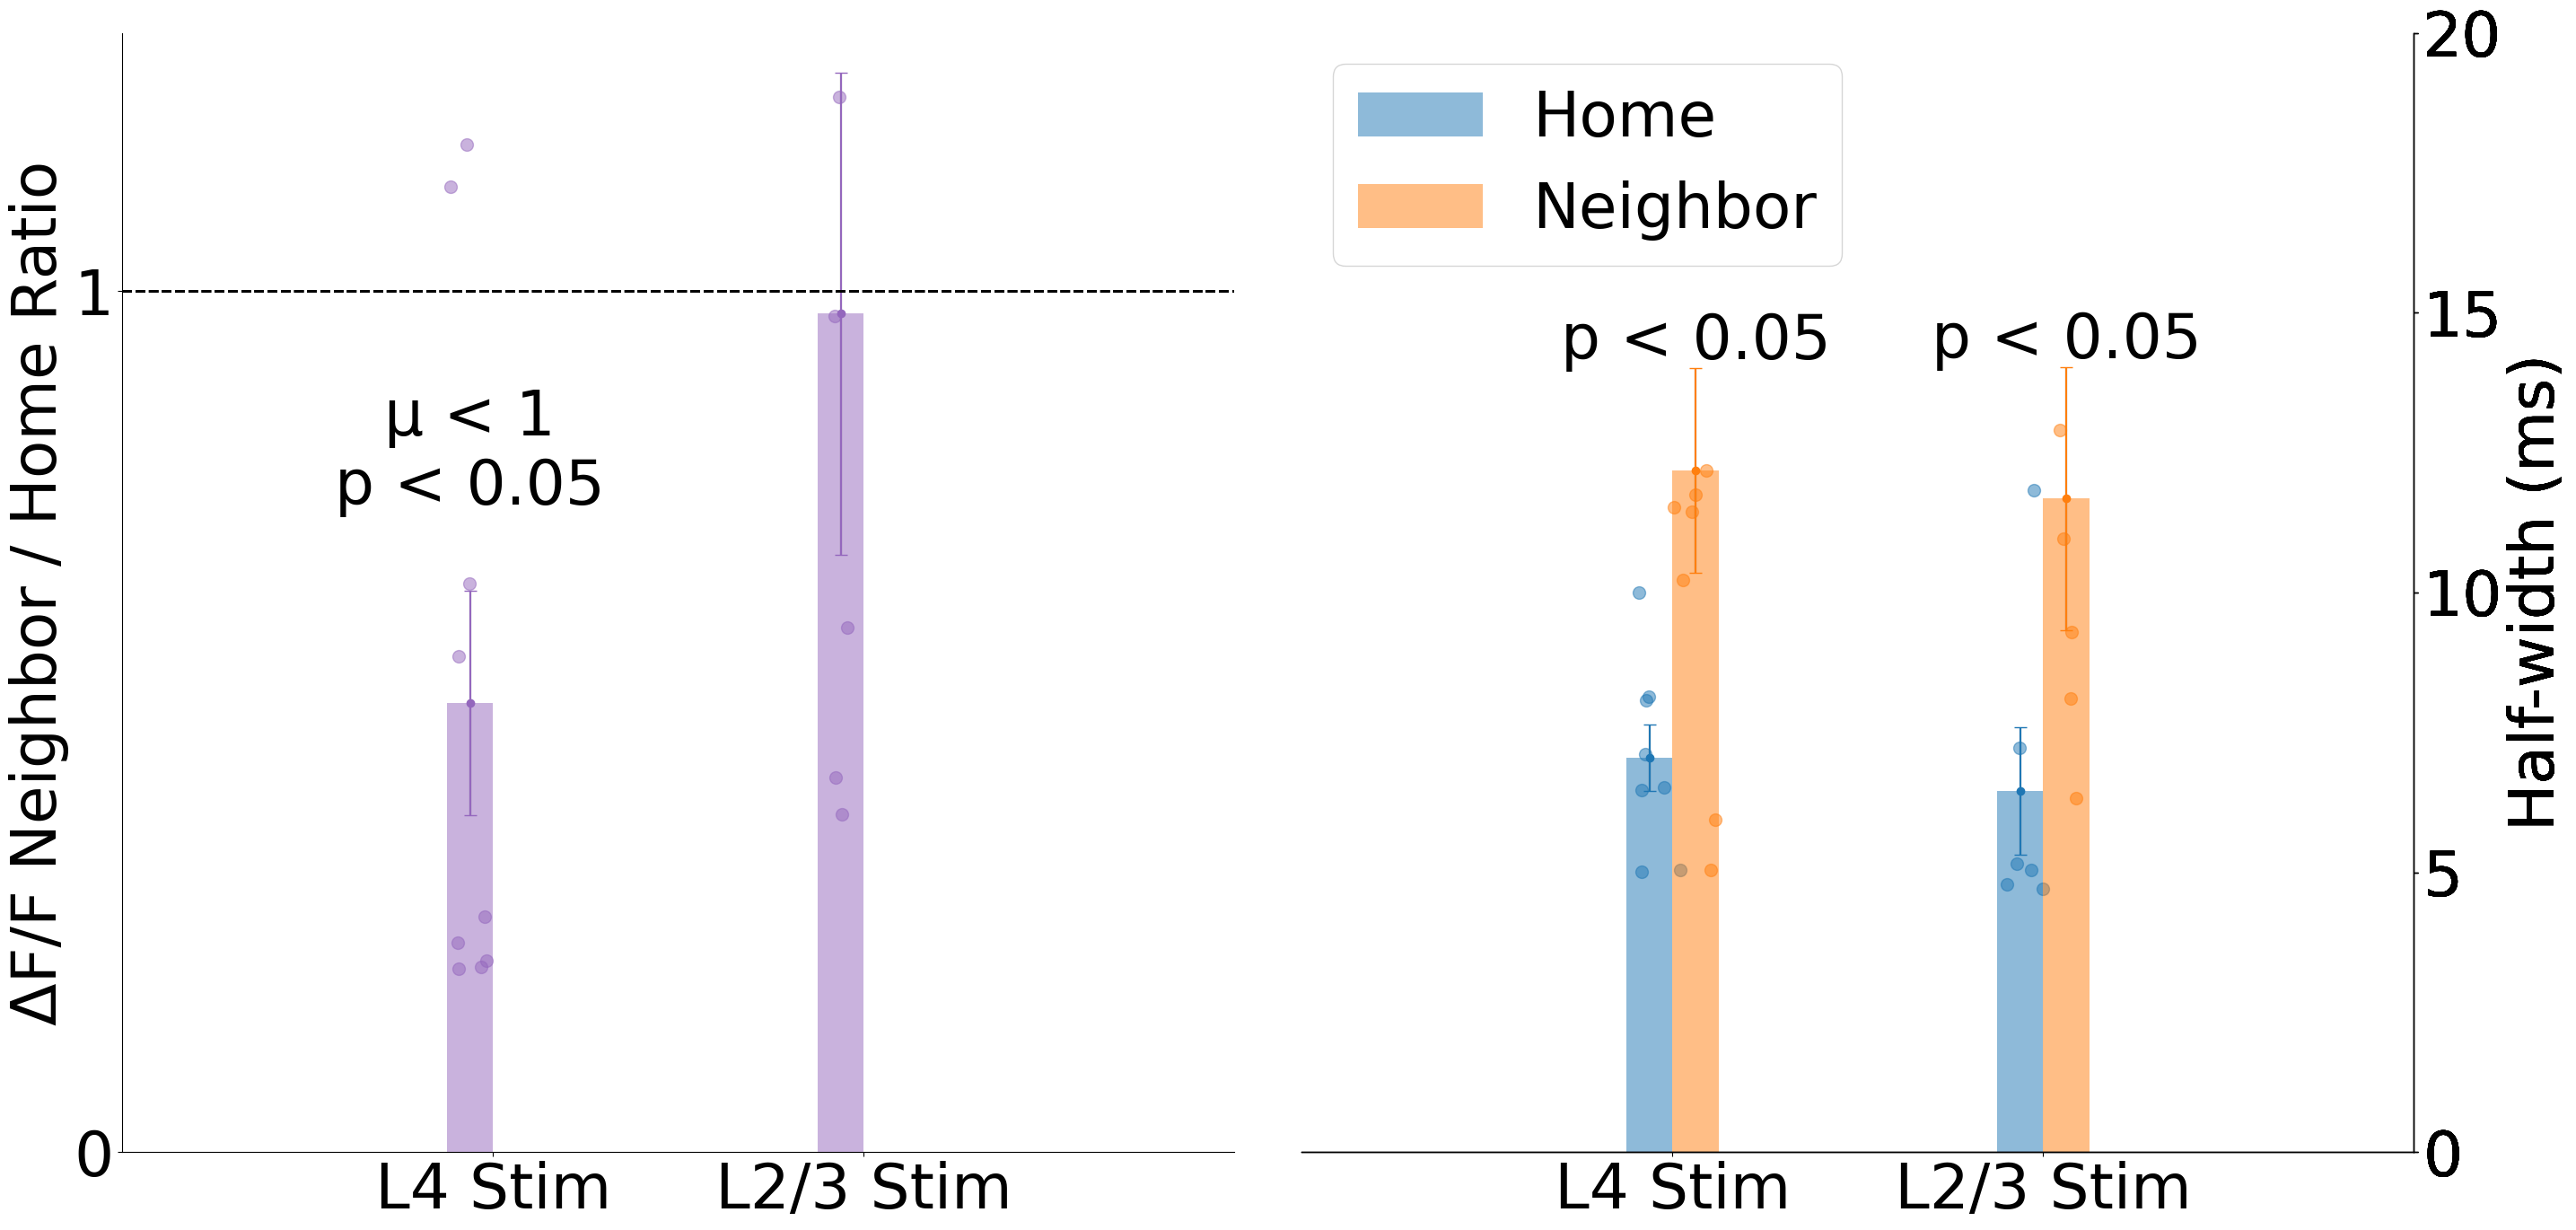

In [31]:
# compare the supra data (supra_df) to the L4 data (hw_lat_df):
#       for ACSF and NBQX, and for L2/3 and L4 stim, and for home versus neighbor
# leave out Medial/Lateral comparison for now
# do latency, half-width, amplitude, comparing supra to L4, for all four of the following plots:
#  - plot 1 home barrel in L4 stim: ACSF vs NBQX
#  - plot 2 neighbor barrel in L4 stim: ACSF vs NBQX
#  - plot 3 home barrel in L2/3 stim: ACSF vs NBQX
#  - plot 4 neighbor barrel in L2/3 stim: ACSF vs NBQX
plt.rcParams.update({'font.size': 50})
fig, ax = plt.subplots(1, 2, figsize=(30, 15))

# plot 1 home barrel in L4 stim: ACSF vs NBQX
layers = ['L4', 'L2/3']
drug = ['ACSF', 'NBQX']
home_neighbor = ['home', 'neighbor']
regions = ['Supragranular', 'Granular']
metrics = [ 'amp', 'halfwidth', ]
metric_labels = ['L4 Stim', 'L2/3 Stim']
handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        if d == 'NBQX':
            continue
        region_dfs = []
        for k, home in enumerate(home_neighbor):
            
            for m, region in enumerate(regions):
                if region == 'Supragranular':
                    continue
                df = supra_df if region == 'Supragranular' else hw_lat_df
                hatch = '//' if d == 'NBQX' else None
                color = 'tab:blue' if home == 'home' else 'tab:orange'
                
                region_df = df[(df['Layer'] == layer) & 
                                    (df['drug'] == d)]
                if home == 'home':
                    region_df = region_df[region_df['ROI'] == 1]
                else:
                    region_df = region_df[region_df['ROI'] > 1]
                region_dfs.append(region_df)

                for l, metric in enumerate(metrics):
                    x_location_bar = i/2 + j/4 + k/16 - 1/32
                    if metric == 'amp':
                        if home == 'home':
                            # use only one bar/scatter, which is neighbor / home
                            home_neighbor_df = df[(df['Layer'] == layer) & (df['drug'] == d)]
                            home_df = home_neighbor_df[home_neighbor_df['ROI'] == 1]
                            neighbor_df = home_neighbor_df[home_neighbor_df['ROI'] > 1]
                            # element-wise division
                            home_ratio =  (np.array(neighbor_df[metric]) / np.array(home_df[metric]))#.dropna() 
                            h = ax[l].bar(x_location_bar, 
                                            np.mean(home_ratio), 
                                            yerr=sem(home_ratio), 
                                            width=.125 / 2,
                                            color='tab:purple', label=home.capitalize(), hatch=hatch, alpha=0.5)
                            handles.append(h)

                            # add error bars
                            ax[l].errorbar(x_location_bar,
                                        np.mean(home_ratio),
                                        yerr=sem(home_ratio),
                                        fmt='o', color='tab:purple', capsize=5)
                            # add jitter to x-axis for scatter plot
                            x_jitter = np.random.normal(x_location_bar, 0.015, len(home_ratio))
                            # plot the data
                            ax[l].scatter(x_jitter, home_ratio,
                                            color='tab:purple', alpha=0.5, s=100, marker='o')
                            
                            # t-test: is the ratio significantly less than 1?
                            t_stat, p_val = ttest_1samp(home_ratio, 1, alternative='less')
                            print("\nresults for 1-samp t-test " + metric + " with " + layer + " stim, home versus neighbor (L4 ROIs):")
                            print('T =', t_stat, 'p =', p_val)
                            print("sample size for home barrel: ", len(home_ratio))
                            print("mean +/- sem for home barrel: ",
                                    round(np.mean(home_ratio), 2), "±", 
                                    round(sem(home_ratio), 2))
                            if p_val < 0.05 and d != 'NBQX':
                                ax[l].text(x_location_bar, 
                                            np.mean(home_ratio) + sem(home_ratio) + 0.1, # mu symbol: 
                                            'μ < 1\np < 0.05', ha='center', fontsize=50)
                    else:
                        
                        #print("x_location_bar =", x_location_bar)
                        h = ax[l].bar(x_location_bar, 
                                        np.mean(region_df[metric].dropna()), 
                                        yerr=sem(region_df[metric].dropna()), 
                                        width=.125 / 2,
                                        color=color, label=home.capitalize(), hatch=hatch, alpha=0.5)
                        handles.append(h)

                        # add error bars
                        ax[l].errorbar(x_location_bar,
                                    np.mean(region_df[metric].dropna()),
                                    yerr=sem(region_df[metric].dropna()),
                                    fmt='o', color=color, capsize=5)
                        # add jitter to x-axis for scatter plot
                        x_jitter = np.random.normal(x_location_bar, 0.015, len(region_df[metric].dropna()))
                        # plot the data
                        ax[l].scatter(x_jitter, region_df[metric].dropna(),
                                        color=color, alpha=0.5, s=100, marker='o')
                    ax[l].set_xticks([0, 0.5])
                    ax[l].set_xticklabels(metric_labels)
                    ax[0].set_ylabel('ΔF/F Neighbor / Home Ratio' )
                    ax[l].set_xlim(-0.5, 0.5 + 0.5 * (len(metrics)-1))
                    # label other side as Δf/f
                    ax2 = ax[1].twinx()
                    ax2.set_ylabel('Half-width (ms)')
                    ax2.set_yticks([0,  5, 10, 15, 20])
                    ax2.spines['left'].set_visible(False)
                    ax2.spines['top'].set_visible(False)
                    ax[1].set_yticks([])
                    #ax[i][k].set_title(home + ' barrel' + ' with ' + layer + ' stim')
                    ax[1].set_ylim(0, 25)
                    ax[0].set_ylim(0, 1.3)

                    # horizontal line at 1 for amp ratio
                    ax[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
                

                    # turn off spines
                    ax[l].spines['top'].set_visible(False)

        # significance testing: home vs neighbor barrel
        for l, metric in enumerate(metrics):
            # exclude nans from the data
            alt = 'greater' if metric == 'amp' else 'less'
            t_stat, p_val = ttest_ind(region_dfs[0][metric].dropna(), region_dfs[1][metric].dropna(), equal_var=False, alternative=alt)
            if not (d == 'ACSF'):
                continue
            print("\nresults for " + metric + " with " + layer + " stim, home versus neighbor (L4 ROIs):")
            print('T =', t_stat, 'p =', p_val)
            print("sample size for home barrel: ", len(region_dfs[0][metric].dropna()))
            print("sample size for neighbor barrel: ", len(region_dfs[1][metric].dropna()))
            #print(region_dfs[0][metric], region_dfs[1][metric])
            print("mean +/- sem for home barrel: ",
                    round(region_dfs[0][metric].dropna().mean(), 2), "±", 
                    round(sem(region_dfs[0][metric].dropna()), 2))
            print("mean +/- sem for neighbor barrel: ",
                    round(region_dfs[1][metric].dropna().mean(), 2), "±", 
                    round(sem(region_dfs[1][metric].dropna()), 2))
            height = max(region_dfs[0][metric].dropna().mean() + sem(region_dfs[0][metric].dropna()), 
                            region_dfs[1][metric].dropna().mean() + sem(region_dfs[1][metric].dropna())) + 0.2
            if p_val < 0.05 and d != 'NBQX':
                ax[l].text((x_location_bar if metric == 'halfwidth' else 0.5) , height, 'p < 0.05', ha='center', fontsize=50)
                
# spines: turn off top and right spines for both axes
ax[1].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yticks([0, 1])


# legend in top left, but with only the first two labels
ax[1].legend(handles=[handles[1], handles[-1]], labels=['Home', 'Neighbor'] + drug, loc='upper left')
plt.tight_layout()
plt.savefig(output_fig_dir + 'supra_vs_L4' + '_'.join(metrics) + '.png')
plt.show()


In [32]:
# compare granular ROIs within L2/3 stimulation
home_L23_mean = 3.2
home_L23_std = 0.57 * np.sqrt(6)
neighbor_L23_mean = 3.93
neighbor_L23_std = 0.39 * np.sqrt(6)
t_stat, p_val = ttest_ind_from_stats(mean1=home_L23_mean, std1=home_L23_std, nobs1=6,
                                        mean2=neighbor_L23_mean, std2=neighbor_L23_std, nobs2=6,
                                        equal_var=False)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

# compare granular ROIs within L4 stimulation
home_L4_mean = 2.02
home_L4_std = 0.21 * np.sqrt(9)
neighbor_L4_mean = 3.54
neighbor_L4_std = 0.4 * np.sqrt(9)
t_stat, p_val = ttest_ind_from_stats(mean1=home_L4_mean, std1=home_L4_std, nobs1=9,
                                        mean2=neighbor_L4_mean, std2=neighbor_L4_std, nobs2=9,
                                        equal_var=False)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

t-statistic:  -1.0569724573901356
p-value:  0.31855210909089915
t-statistic:  -3.3645120307841854
p-value:  0.005567405364663692


Skipping date 6/26/2024
Skipping date 7/1/2024
Skipping date 7/15/2024
Skipping date 7/17/2024
Skipping date 11/6/2024
Skipping date 12/9/2024
Skipping date 12/11/2024
Skipping date 10/23/2024
Skipping date 10/29/2024
Skipping date 12/18/2024
Saved figure to P:/John/crossing-paper/input/12-20-2024_1_3_1.png


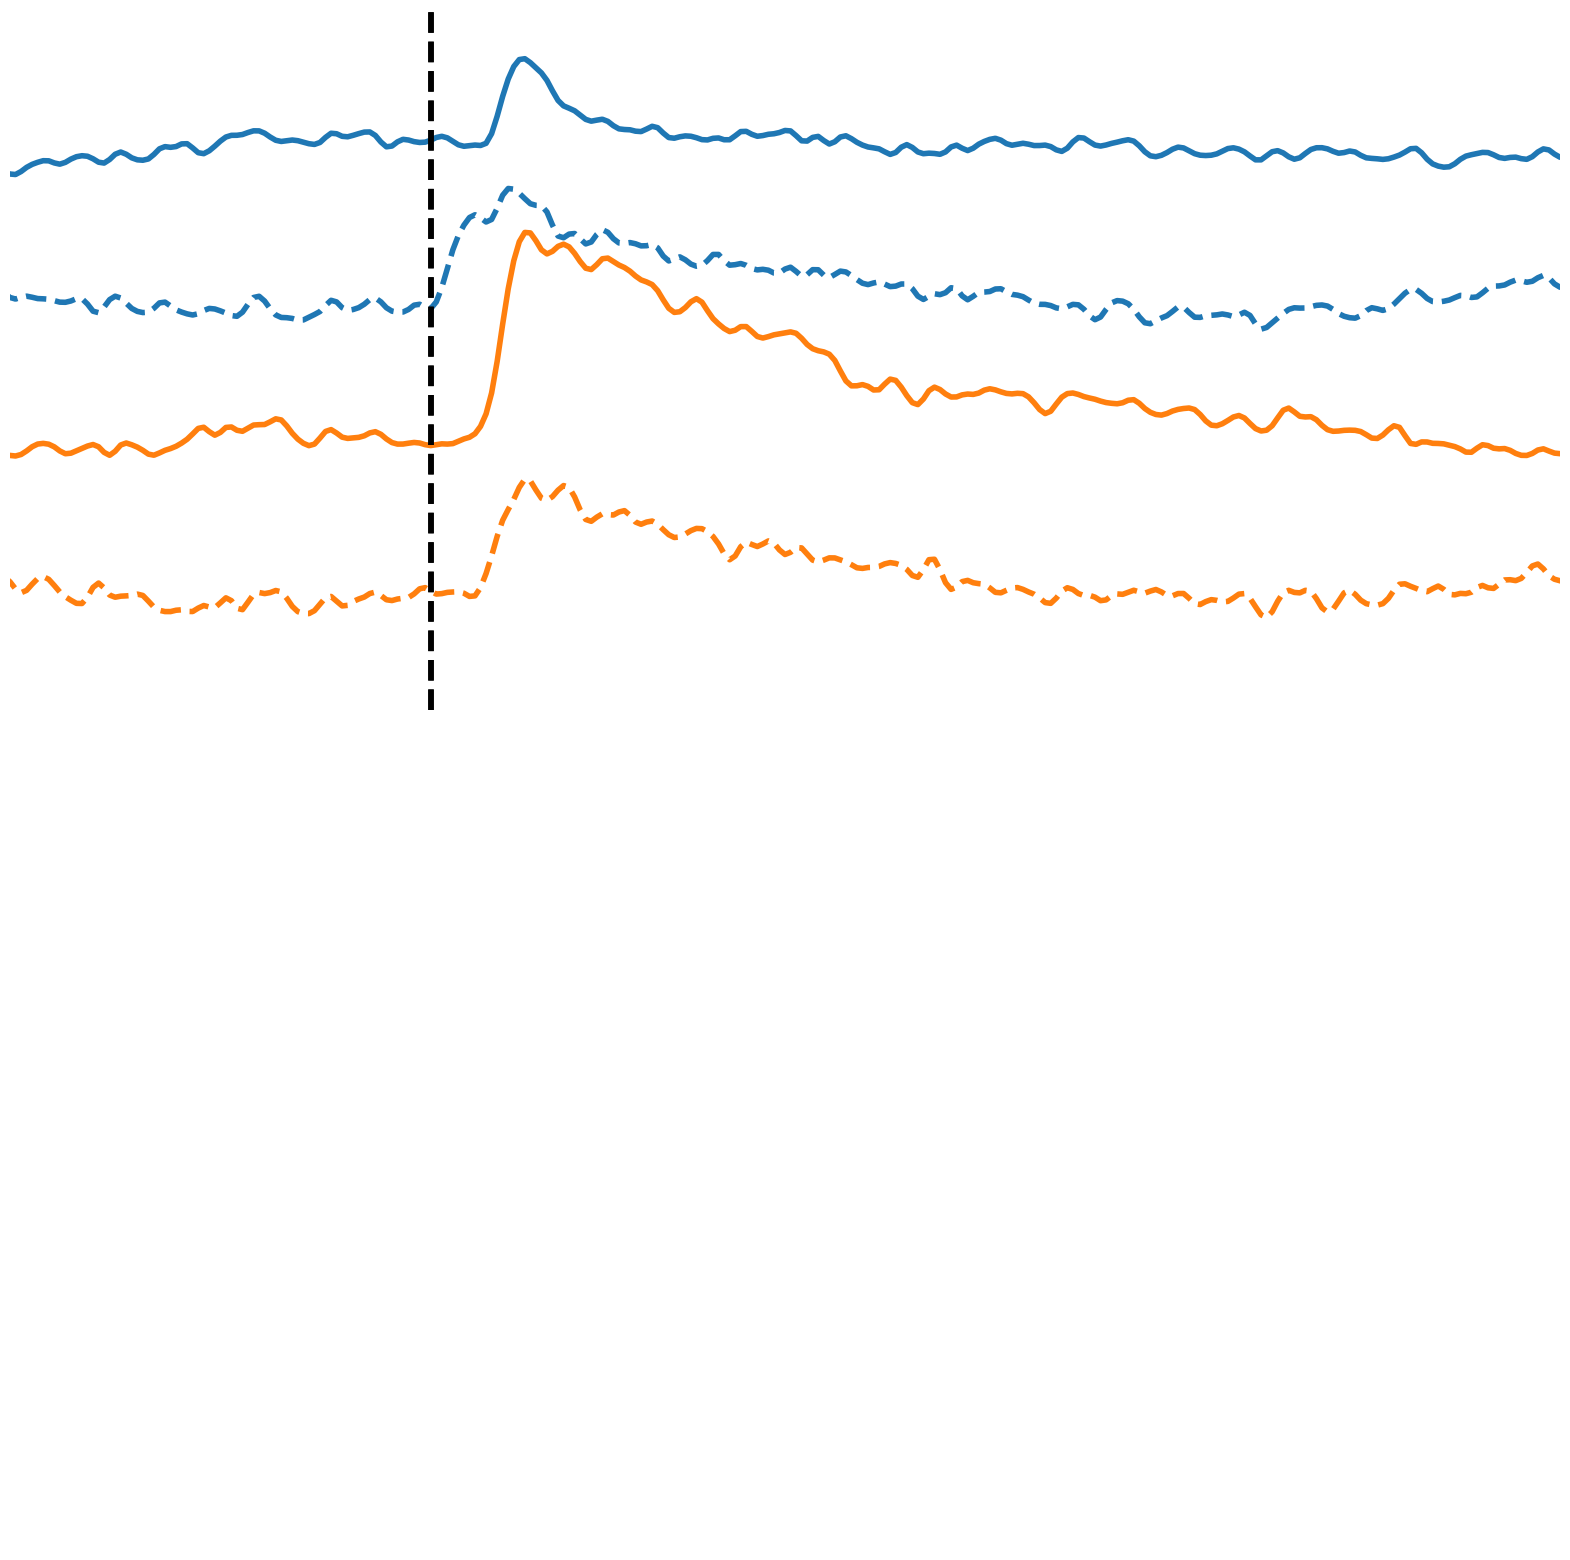

Saved figure to P:/John/crossing-paper/input/12-20-2024_1_3_2.png


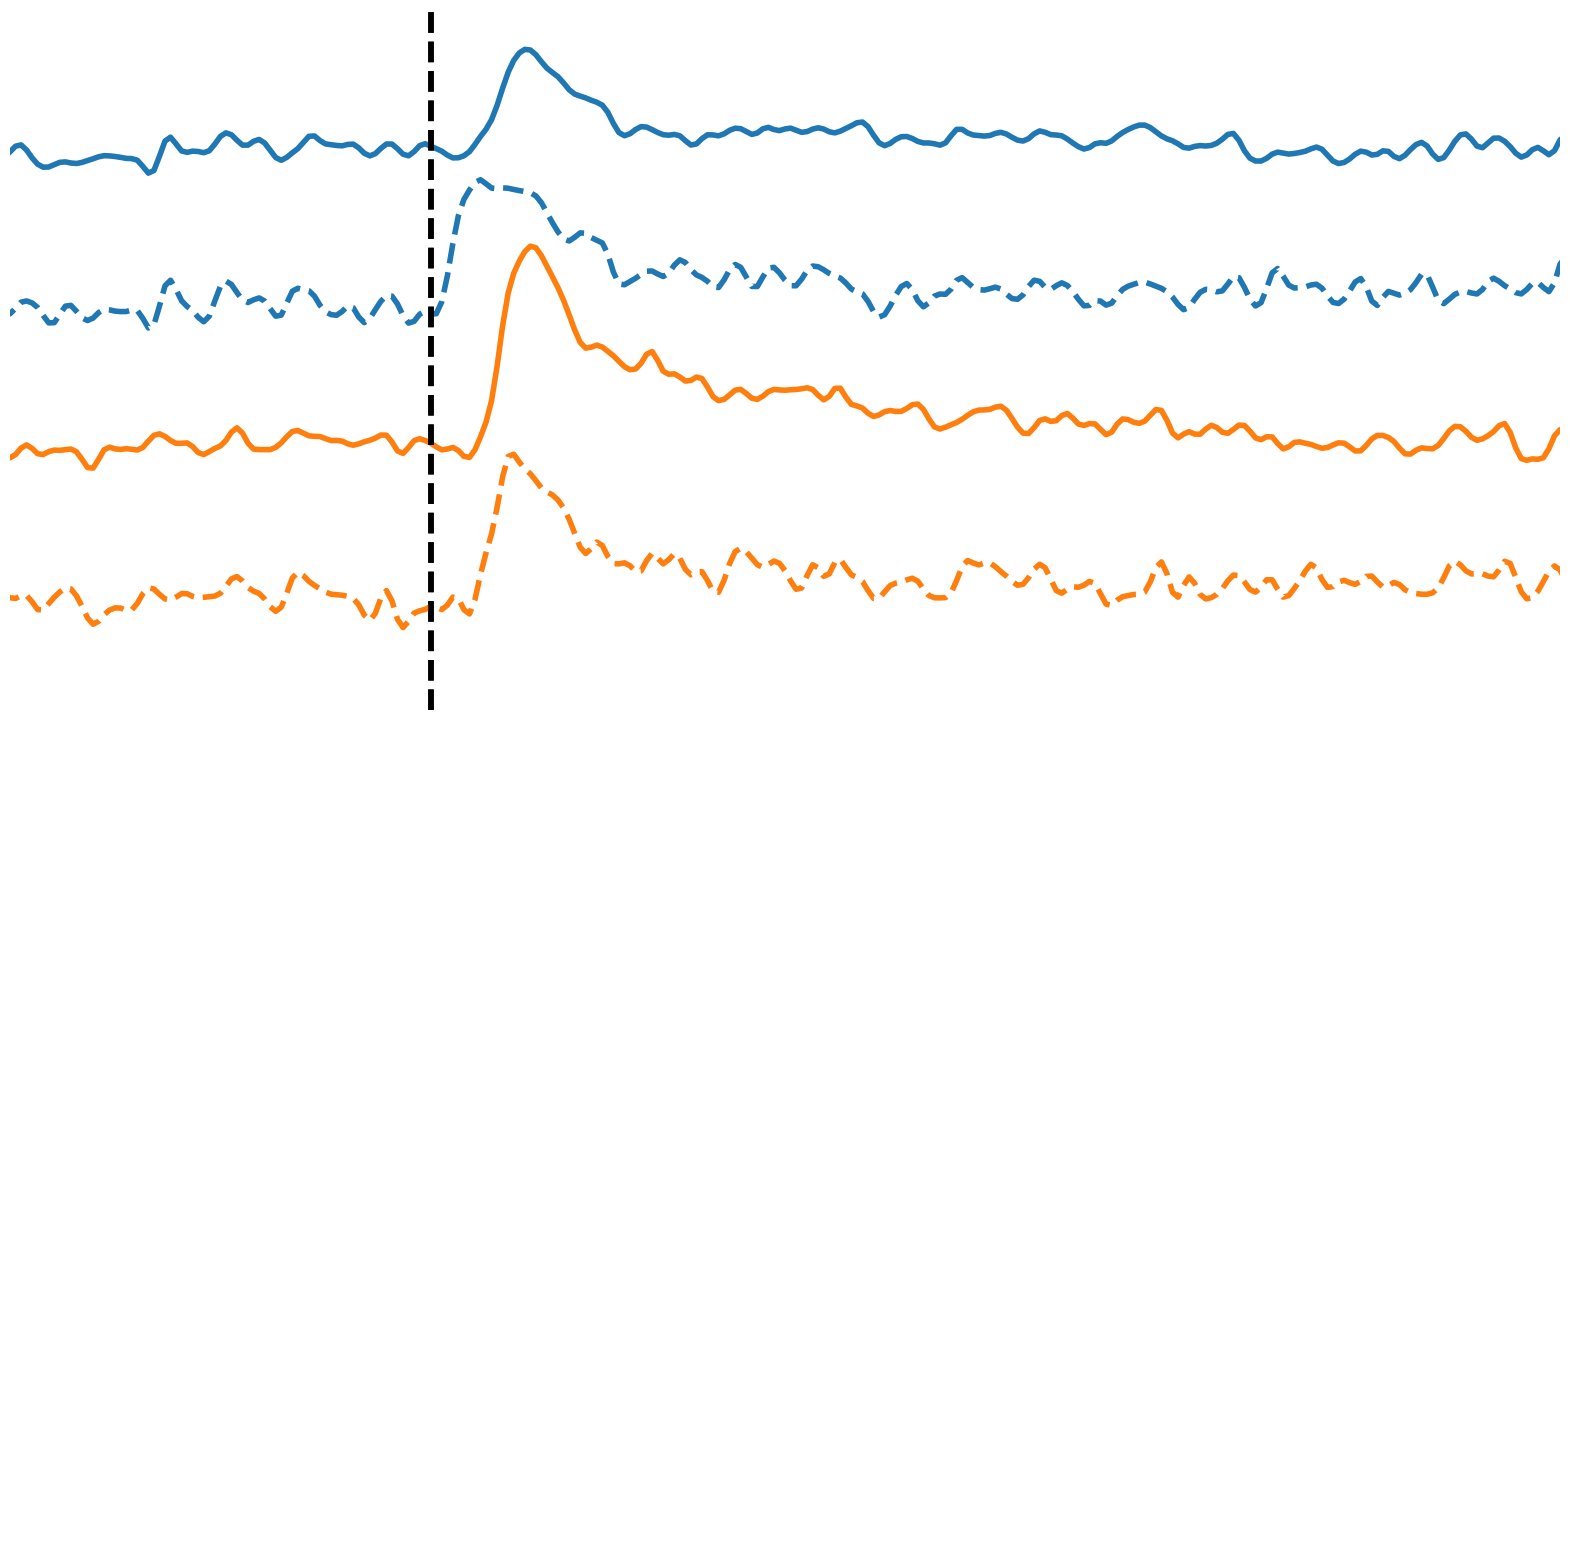

Saved figure to P:/John/crossing-paper/input/12-20-2024_2_1_1.png


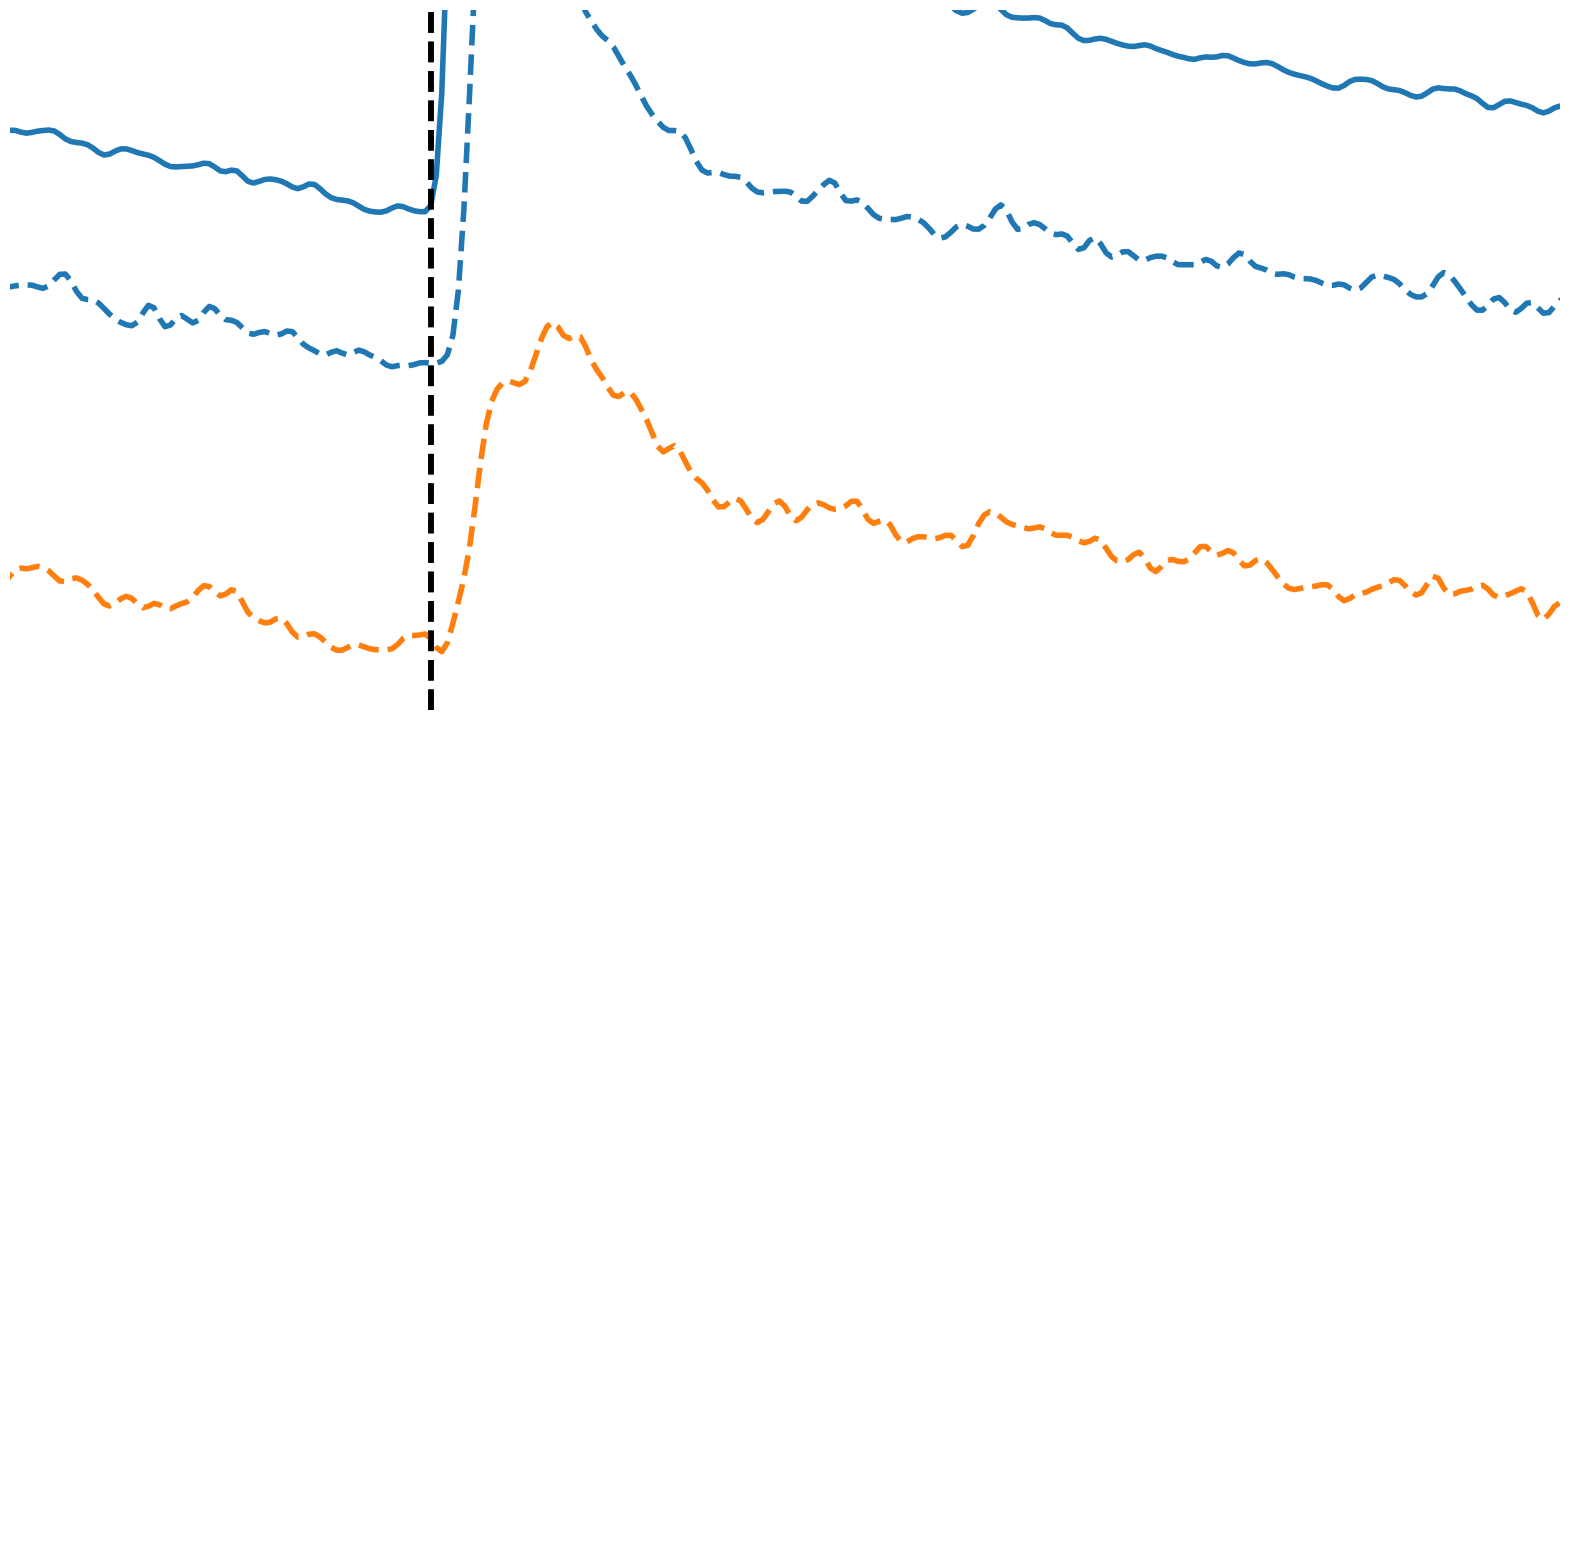

Saved figure to P:/John/crossing-paper/input/12-20-2024_2_3_1.png


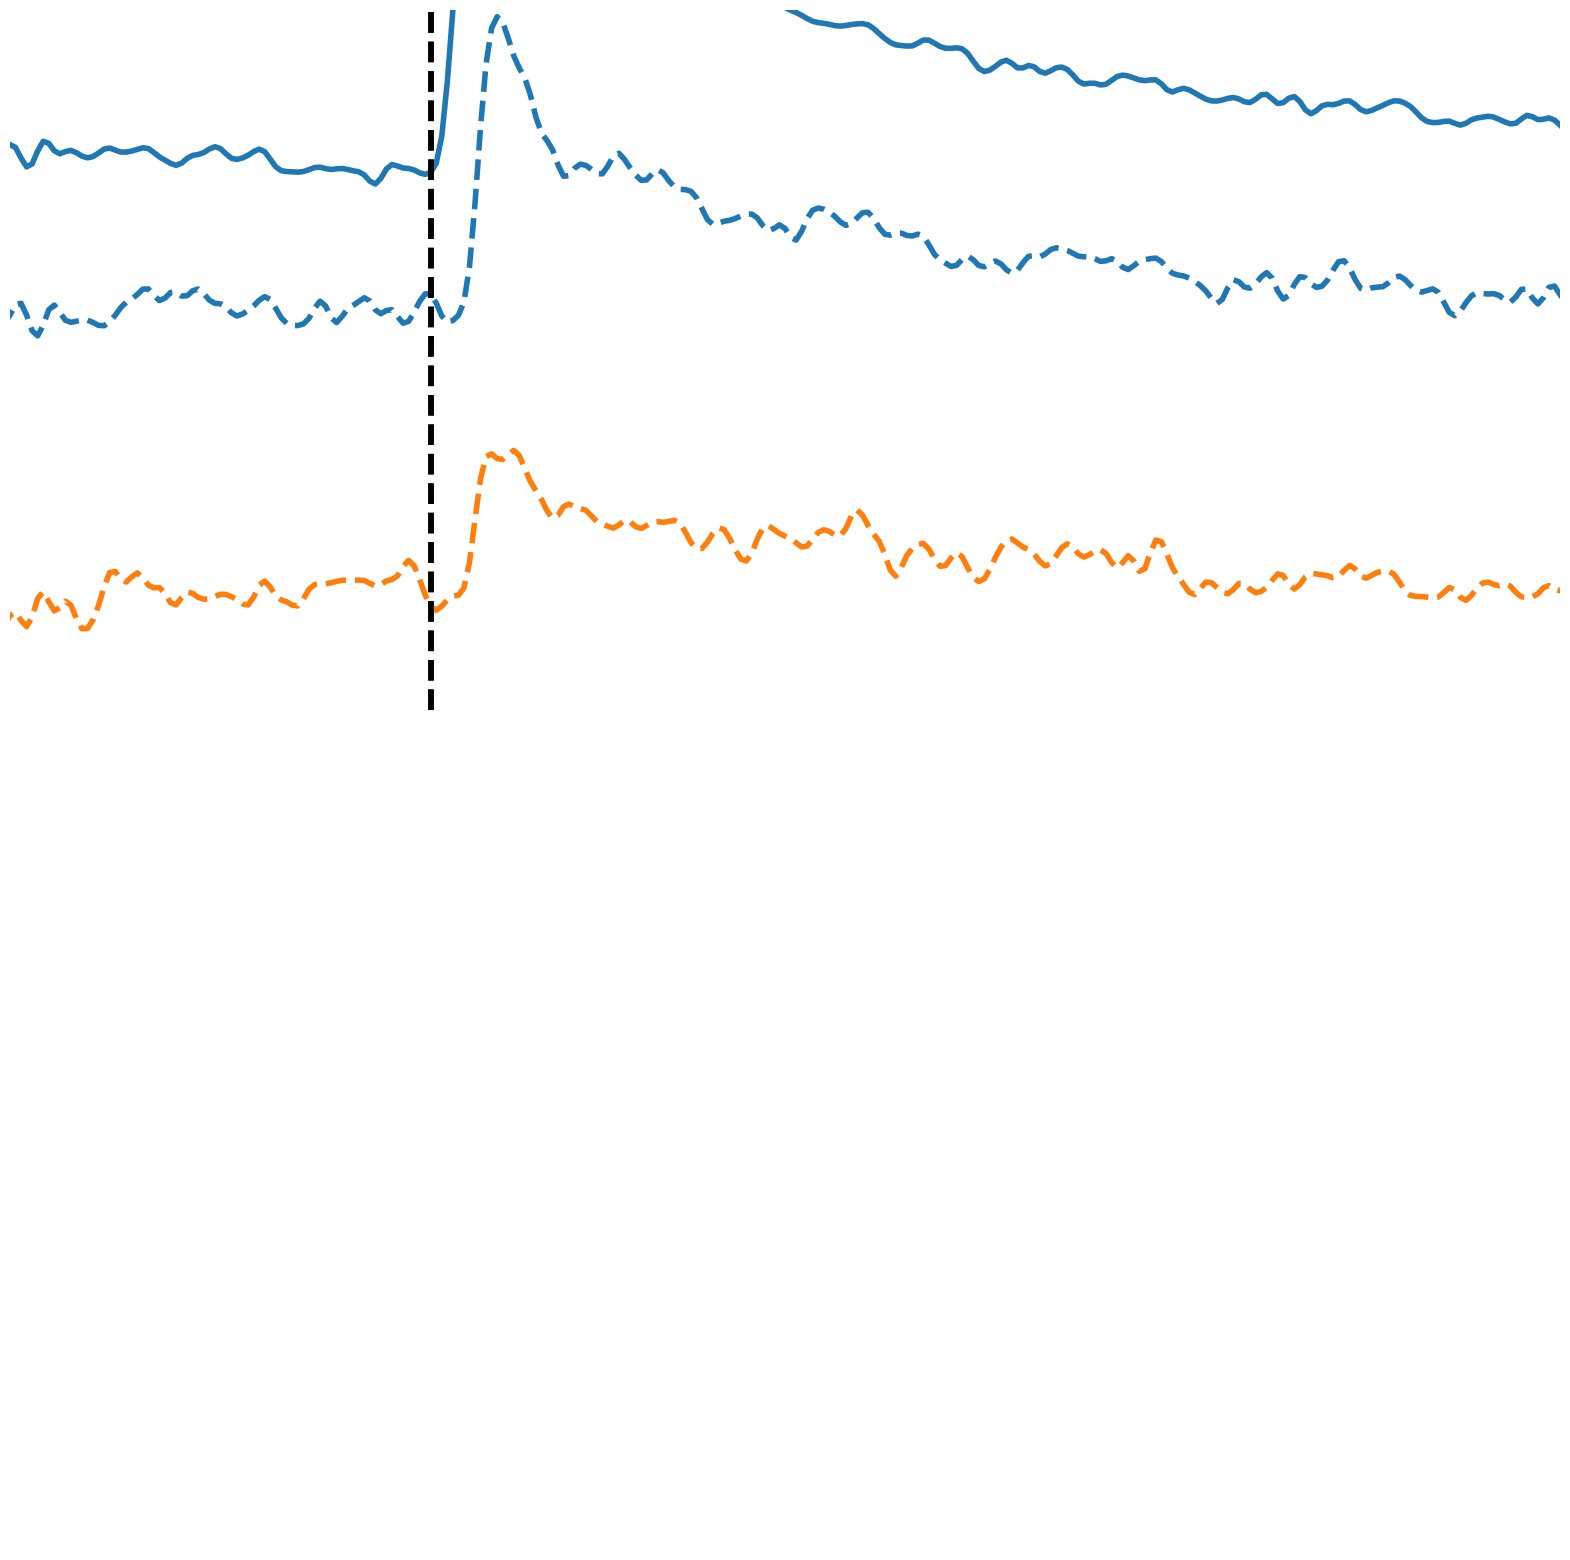

In [33]:
# compare supragranular traces to granular (L4) traces.
# for each layer and drug, compare supragranular to granular for home and neighbor barrels, plotting them in the same plot.
# matplotlib font size 20 rcParams['font.size'] = 20
plt.rcParams['font.size'] = 30

for date in supra_df['Date'].unique():
    date_df = supra_df[supra_df['Date'] == date]
    if not date == '12/20/2024': # C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda
        print('Skipping date ' + date)
        continue
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            for rec in loc_df['Recording'].unique():
                rec_df = loc_df[loc_df['Recording'] == rec]

                # get the layer and drug
                layer = rec_df['Layer'].values[0]
                drug = rec_df['drug'].values[0]

                # get the trace file
                supra_trace = rec_df['trace']
                # read in the trace
                supra_trace = read_dat_trace_file(supra_trace.values[0])

                # get the granular trace
                granular_df = hw_lat_df[(hw_lat_df['Date'] == date) &
                                        (hw_lat_df['Slice'] == slic) &
                                        (hw_lat_df['Location'] == loc) &
                                        (hw_lat_df['Recording'] == rec)]
                if granular_df.empty:
                    continue
                granular_trace_file = granular_df['trace']
                if 'amp_array' in granular_trace_file.values[0]:
                    granular_trace_file.values[0] = granular_trace_file.values[0].replace('amp_array', 'trace')
                try:
                    granular_trace = read_dat_trace_file(granular_trace_file.values[0])
                except FileNotFoundError:

                    print('File not found for ' + granular_trace.values[0])
                    continue

                # plot the traces
                fig, ax = plt.subplots(2, 1, figsize=(20, 20))
                cols = supra_trace.columns
                if len(granular_trace.columns) < len(cols):
                    cols = granular_trace.columns

                spacing = 2.5 # for 12/20
                #spacing = 1 # for 12/18
                for i, roi in enumerate(granular_trace.columns):
                    if roi == 'Pt' or roi == 'ROI2':
                        continue
                    t = np.arange(0, len(granular_trace[roi]) * 0.5, 0.5)
                    i_plot = 0 if roi == "ROI1" else 1
                    color = 'tab:blue' if roi == "ROI1" else 'tab:orange'
                    dashed = '-'
                    ax[0].plot(t, granular_trace[roi] - i_plot * spacing * 2, color=color, linestyle=dashed, linewidth=4)
                    #base += granular_trace[roi].max() + 0.1
                for i, roi in enumerate(supra_trace.columns):
                    if roi == 'Pt':
                        continue
                    try:
                        t = np.arange(0, len(granular_trace[roi]) * 0.5, 0.5)
                    except KeyError:
                        print('KeyError for ' + roi + ' in ' + date + ' ' + str(slic) + ' ' + str(loc) + ' ' + str(rec))
                        print("available keys: ", granular_trace.columns, 'for filename' + granular_trace_file.values[0])
                        continue
                    i_plot = 0 if roi == "ROI1" else 1
                    color = 'tab:blue' if roi == "ROI1" else 'tab:orange'
                    dashed = '--'
                    ax[0].plot(np.arange(0, len(supra_trace[roi]) * 0.5, 0.5), supra_trace[roi] - spacing - i_plot * spacing * 2, color=color, linewidth=4, linestyle=dashed)
                    #base += supra_trace[roi].max() + 0.1
                        
                    #ax[0].legend(loc='upper right', labels=['L4 ROI', 'L2/3 ROI'])
                    # label date, slice, loc, rec, layer, drug
                    #ax[0].set_title('Date: ' + date + '   Layer: ' + layer + '   Drug: ' + drug)
                    #ax[0].set_ylabel('Δf/f')
                    #ax[1].set_ylabel('Δf/f')
                    ax[0].set_xticks([])
                    ax[1].set_xticks([])
                    ax[0].set_yticks([])
                    ax[1].set_yticks([])
                    ax[0].set_xlim(10, 150)
                    ax[1].set_xlim(10, 150)
                    ax[0].set_ylim(-9.5, 2.5)  # for 12/20/24
                    #ax[0].set_ylim(-5.5, 3.5) # for 12/18/24
                    ax[1].set_ylim(-1.5, 3.5)
                    #ax[1].set_xlabel('Time (ms)')

                    # label stim time
                    ax[0].axvline(x=48, color='black', linestyle='--', linewidth=4)

                    # turn off the spines
                    ax[0].spines['top'].set_visible(False)
                    ax[0].spines['right'].set_visible(False)
                    ax[1].spines['top'].set_visible(False)
                    ax[1].spines['right'].set_visible(False)
                    ax[0].spines['bottom'].set_visible(False)
                    ax[0].spines['left'].set_visible(False)
                    ax[1].spines['bottom'].set_visible(False)
                    ax[1].spines['left'].set_visible(False)

                plt.savefig(output_fig_dir + date.replace('/', '-') + '_' + str(slic) + '_' + str(loc) + '_' + str(rec) + '.png')
                print('Saved figure to ' + output_fig_dir + date.replace('/', '-') + '_' + str(slic) + '_' + str(loc) + '_' + str(rec) + '.png')
                plt.show()


Mean latency for Home Granular: 2.8255819999999994 ± 0.057007197904202354
Mean latency for Neighbor Granular: 3.6199569999999976 ± 0.07024953217077054
Mean latency for Home Supragranular: 2.939088999999998 ± 0.03336644476343737
Mean latency for Neighbor Supragranular: 2.9629091836734687 ± 0.06154516330474846


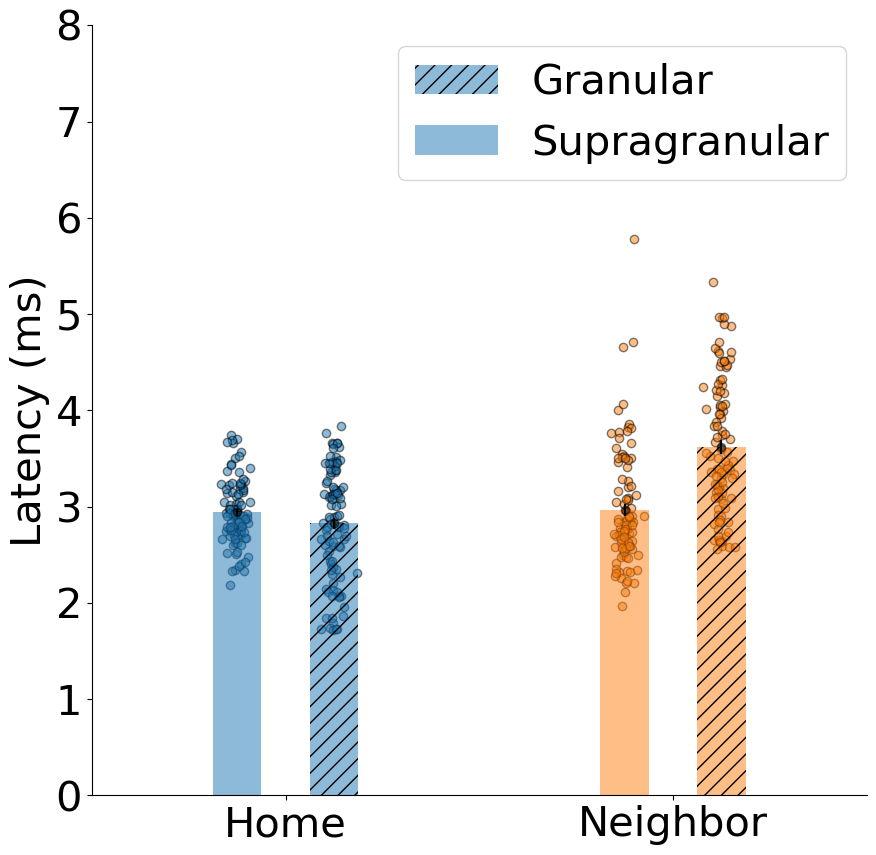

In [34]:
# use C:\Users\jjudge3\Desktop\Data\crossing_PPR\L23_vs_L4_NBQX\L4_NBQX_2\12-18-24\selected_zda\rand_rois02_01_02/export_summary.csv
# to plot latency distributions for each layer/barrel (4 total)
# read in the data
latencies_rand_12_18_24 = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda/rand_rois02_01_02/export_summary.csv'
latencies_rand_12_18_24_df = pd.read_csv(latencies_rand_12_18_24)
latencies_rand_12_18_24_df['latency'] -= 48.6
latencies_rand_12_18_24_df = latencies_rand_12_18_24_df[latencies_rand_12_18_24_df['latency'] > 0]

types_rois = latencies_rand_12_18_24_df['ROI_Set'].unique()
roi_type_map = {
    '2_rois_output__rand_0': ['Home', 'Granular'], 
    '2_rois_output__rand_1': ['Neighbor', 'Granular'],
    '2_rois_supragranular_output__rand_0': ['Home', 'Supragranular'],
    '2_rois_supragranular_output__rand_1': ['Neighbor', 'Supragranular']
}
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
handles = []
for i, roi_type in enumerate(types_rois):
    barrel, layer = roi_type_map[roi_type]
    # get the data for the barrel and layer
    roi_df = latencies_rand_12_18_24_df[latencies_rand_12_18_24_df['ROI_Set'] == roi_type]
    # get the mean and std of the latency
    mean_latency = np.mean(roi_df['latency'])
    sem_latency = sem(roi_df['latency'])
    # plot the data as 4 bars, with error bars and scatter points for each layer/barrel
    color = 'tab:blue' if barrel == 'Home' else 'tab:orange'
    hatch = '//' if layer == 'Granular' else None

    x_loc = 0 if barrel == 'Home' else 1
    x_loc += 0.125 if layer == 'Granular' else -0.125

    l1 = ax.bar(x_loc, mean_latency, yerr=sem_latency, width=.125, color=color, hatch=hatch, alpha=0.5)
    ax.errorbar(x_loc, mean_latency, yerr=sem_latency, fmt='o', color='black', alpha=0.5)
    x_jitter = np.random.normal(0, 0.015, size=len(roi_df['latency']))
    ax.scatter(x_loc + x_jitter, roi_df['latency'], color=color, alpha=0.5, edgecolors='black')
    handles.append(l1)

    print('Mean latency for ' + barrel + ' ' + layer + ': ' + str(mean_latency) + ' ± ' + str(sem_latency))

ax.legend(handles=[handles[0], handles[2]], labels=['Granular', 'Supragranular'], loc='upper right')
ax.set_ylim(0, 8)
ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0, 1])

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['Home', 'Neighbor'])
ax.set_ylabel('Latency (ms)')
plt.savefig(output_fig_dir + 'latency_distributions_rand_rois.png')
plt.show()

In [35]:
# load PPR data and take just the first-pulse rows for IPI = 100 to use as more single-pulse data (medial/lateral)
ppr_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/export_summary_backup_coronal.csv'
ppr_coronal_df = pd.read_csv(ppr_data)
ppr_coronal_df['latency'] -= 78.78  # measured via PhotoZ for IPI == 100 pulse 1
# load PPR catalog
ppr_catalog = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/ppr_catalog_backup-coronal-only.csv'
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_coronal_df = ppr_coronal_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_coronal_df.drop('zda_file', axis=1, inplace=True)

# only keep the first pulse for IPI = 100 and single pulse controls only
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['is_single_pulse_control'] == 1]
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['IPI'] == 100]

# keep only with substring 'pulse1' in the 'ROI_Set' column
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['ROI_Set'].str.contains('pulse1')]

# filter out columns with Home in Medial/Lateral
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['Medial/Lateral'] != 'Home']

# remove rows with negative halfwidth or latency
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['halfwidth'] > 0]
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['latency'] > 0]

# add Layer column and fill with 'L4'
ppr_coronal_df['Layer'] = 'L4'
ppr_coronal_df['drug'] = 'ACSF'

# to avoid double counts, remove rows from Date == ['12/18/2024' '12/20/2024']
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['Date'] != '12/18/2024']
ppr_coronal_df = ppr_coronal_df[ppr_coronal_df['Date'] != '12/20/2024']

ppr_coronal_df



ROI       amp  latency  halfwidth   X_Center   Y_Center  \
91      2  2.432550   5.5113    18.3610  53.121780  52.351288   
187     2  1.856520   3.6446    16.8169  53.754098  48.061475   
311     2  1.800210   3.2945    11.9526  60.164021  62.899471   
385     2  1.992990   3.9166    26.4890  30.245370  50.333333   
386     3  1.526330   4.5569    29.9288  70.971264  22.959770   
515     2  2.797810   4.1902    15.5445  52.301075  60.688172   
1030    2  0.749263   2.8437    16.8471  45.560403  52.040268   

                      ROI_Set        Date  Slice  Location  Recording  \
91              2_rois pulse1    1/2/2025      2         2          5   
187             1_rois pulse1    1/7/2025      1         2         11   
311             2_rois pulse1    1/7/2025      2         5         26   
385   3_rois-3-barrels pulse1    1/7/2025      3         2         13   
386   3_rois-3-barrels pulse1    1/7/2025      3         2         13   
515             4_rois pulse1    1/7/2025      4         2         16   
1030            1_rois pulse1  12/23/2024      1         3         11   

                                                  trace  \
91    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
187   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
311   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
385   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
386   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
515   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1030  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   

                                      trace_non_polyfit  \
91    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
187   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
311   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
385   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
386   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
515   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1030  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   

                                              amp_array Medial/Lateral  IPI  \
91    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...         Medial  100   
187   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...        Lateral  100   
311   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...        Lateral  100   
385   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...         Medial  100   
386   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...        Lateral  100   
515   C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...        Lateral  100   
1030  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...         Medial  100   

      is_single_pulse_control    zda_id Layer  drug  
91                          1  02_02_05    L4  ACSF  
187                         1  01_02_11    L4  ACSF  
311                         1  02_05_26    L4  ACSF  
385                         1  03_02_13    L4  ACSF  
386                         1  03_02_13    L4  ACSF  
515                         1  04_02_16    L4  ACSF  
1030                        1  01_03_11    L4  ACSF

Medial: 7
Lateral: 8


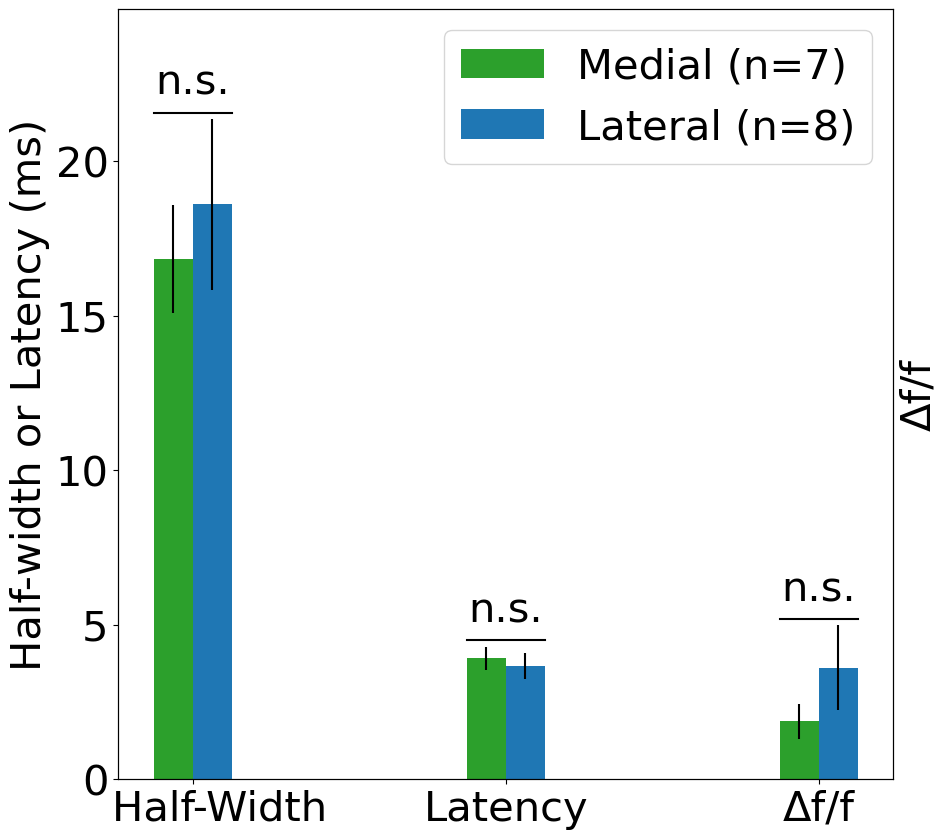

In [36]:


# plot the data that has 'Medial/Lateral' column populated. Restrict to L4 and ACSF and neighbor barrels (ROI > 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only for L4, not for L2/3. Compare latency, half-width, and amplitude for medial vs lateral neighbor barrels
directions = ['Medial', 'Lateral']
handles = []

sample_sizes = {dir: [] for dir in directions}
for i, direction in enumerate(directions):
    color = 'tab:blue' if direction == 'Lateral' else 'tab:green'
    for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
        # get the data for the direction
        direction_list = []
        for df in [hw_lat_df, ppr_coronal_df]:
            direction_df = df[(df['Layer'] == 'L4') & 
                                    (df['drug'] == 'ACSF') & 
                                    (df['ROI'] > 1) & 
                                    (df['Medial/Lateral'] == direction)]
            direction_list += list(direction_df[metric])
        direction_list = np.array(direction_list)
        # plot the data
        l1 = ax.bar(j + i / 8 - 1/16, 
                        np.mean(direction_list), 
                        yerr=sem(direction_list), 
                        width=.125,
                        color=color, label=direction)
        handles.append(l1)

        if j == 0:
            # print sample size for each direction
            print(direction + ':', len(direction_list))
            sample_sizes[direction].append(len(direction_list))

# legend: Medial in black, Lateral in green
ax.legend(handles=[handles[0], handles[-1]], labels=['Medial (n=' + str(sum((sample_sizes['Medial']))) + ")", 
                                                     'Lateral (n=' + str(sum((sample_sizes['Lateral']))) + ")"], 
                                            loc='upper right')

ax.set_ylabel('Half-width or Latency (ms)')
# right-side y-axis label
ax2 = ax.twinx()
ax2.set_ylabel('Δf/f')
ax2.set_yticks([])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['    Half-Width', 'Latency', 'Δf/f'])

# significance testing Medial vs Lateral
for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
    med1 = ppr_coronal_df[(ppr_coronal_df['Layer'] == 'L4') & 
                                        (ppr_coronal_df['drug'] == 'ACSF') & 
                                        (ppr_coronal_df['ROI'] > 1) & 
                                        (ppr_coronal_df['Medial/Lateral'] == 'Medial')][metric]
    lat1 = ppr_coronal_df[(ppr_coronal_df['Layer'] == 'L4') &
                                        (ppr_coronal_df['drug'] == 'ACSF') &
                                        (ppr_coronal_df['ROI'] > 1) &
                                        (ppr_coronal_df['Medial/Lateral'] == 'Lateral')][metric]
    med2 = hw_lat_df[(hw_lat_df['Layer'] == 'L4') &
                                        (hw_lat_df['drug'] == 'ACSF') &
                                        (hw_lat_df['ROI'] > 1) &
                                        (hw_lat_df['Medial/Lateral'] == 'Medial')][metric]
    lat2 = hw_lat_df[(hw_lat_df['Layer'] == 'L4') &
                                        (hw_lat_df['drug'] == 'ACSF') &
                                        (hw_lat_df['ROI'] > 1) &
                                        (hw_lat_df['Medial/Lateral'] == 'Lateral')][metric]
    med = list(med1) + list(med2)
    lat = list(lat1) + list(lat2)
    t_stat, p_val = ttest_ind(med, lat, equal_var=False)
    # draw bar between the two boxes # ax.get_ylim()[1] * 0.8
    med = np.array(med)
    lat = np.array(lat)
    height = max(med.mean() + sem(med), lat.mean() + sem(lat)) + 0.2

    ax.plot([j - 1/8, j + 1/8], [height, height], color='black')
    if p_val < 0.05:
        ax.text(j, height + .6, 'p < 0.05', ha='center')

        
    else:
        ax.text(j, height + .6, 'n.s.', ha='center')

# raise the y-axis limit by 10% to make room for the significance testing
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)


plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp_medial_lateral.png')
plt.show()


t-test between home and neighbor: t = 3.8084869850786784, p = 0.0013457621376488597
home: 156.9544246914259, 15.742191001588585
neighbor: 93.49972180845913, 5.457607392309444


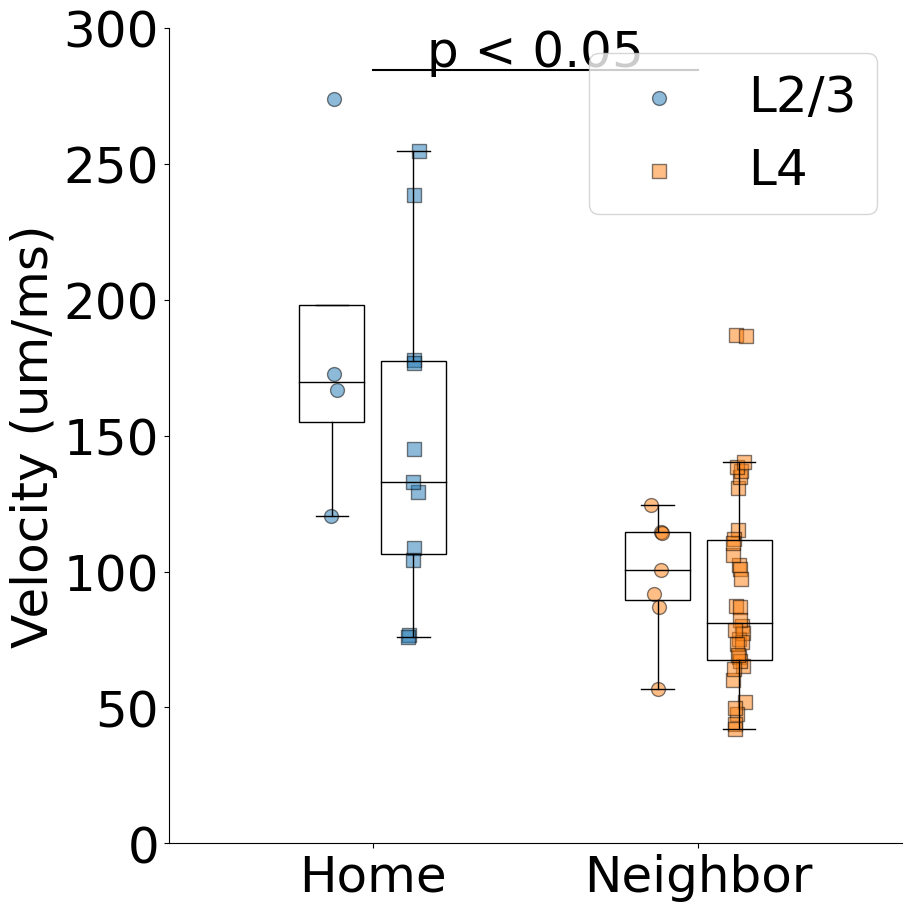

In [37]:
# using C:\Users\jjudge3\Desktop\Data\crossing_PPR\ladder_velocity_regimes.csv,
# plot the velocity distribution for each regime, taking instantaneous velocity from the ladder_df
ladder_regimes_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/ladder_velocity_regimes.csv'
ladder_regimes_df = pd.read_csv(ladder_regimes_data)
# ladder regimes has columns: Date, Slice, Location, Recording, velocity_regime_start, velocity_regime_end, velocity_regime_type

# set fontsize
plt.rcParams.update({'font.size': 36})

regime_velocities = {}
for i, row in ladder_regimes_df.iterrows():
    date, slic, loc, rec = row['Date'], row['Slice'], row['Location'], row['Recording']
    # get the corresponding subset in ladder_df, for drug == 'ACSF'
    ladder_row = ladder_df[(ladder_df['Date'] == date) & 
                            (ladder_df['Slice'] == slic) & 
                            (ladder_df['Location'] == loc) & 
                            (ladder_df['Recording'] == rec) & 
                            (ladder_df['drug'] == 'ACSF')]

    # exclude if Stim_Distance < 50 um
    ladder_row = ladder_row[ladder_row['Stim_Distance'] > 100]
    
    if ladder_row.empty:
        continue

    # the range [velocity_regime_start, velocity_regime_end] corresponds to the Dist_from_home_barrel
    # get the instantaneous velocity for this range

    start = row['velocity_regime_start']
    end = row['velocity_regime_end']

    regime_type = row['velocity_regime_type']

    # get the instantaneous velocity for this range
    regime_df = ladder_row[(ladder_row['Dist_from_home_barrel'] >= start) & 
                            (ladder_row['Dist_from_home_barrel'] <= end)]

    #print(regime_df['instantaneous_velocity'])

    if regime_df.empty:
        continue
    layer = regime_df['Layer'].values[0]
    #print(layer)

    if regime_type not in regime_velocities:
        regime_velocities[regime_type] = {}
    if layer not in regime_velocities[regime_type]:
        regime_velocities[regime_type][layer] = []
    
    # filter outliers > 700 um/ms and -700 um/ms
    regime_df = regime_df[(regime_df['instantaneous_velocity'] < 700) & (regime_df['instantaneous_velocity'] > -700)]
    #if regime_type == 'septal':
    #    print(regime_df[['instantaneous_velocity', 'Date', 'Dist_from_home_barrel']])
    avg_vel = np.mean(np.abs(regime_df['instantaneous_velocity']))

    # outliers
    if avg_vel < 300 and avg_vel > 40:
        regime_velocities[regime_type][layer].append(avg_vel)
    

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for j, layer in enumerate(['L2/3', 'L4']):
    regimes = []
    for i, regime_type in enumerate(['home', 'neighbor']): #, 'septal']):
        velocities = regime_velocities[regime_type][layer]
        # boxplot for each regime. transparent box, black outline, no outliers
        ax.boxplot(velocities, positions=[i + j * 0.25 - 0.125], widths=0.2, patch_artist=True, 
                    boxprops=dict(facecolor='none', color='black'), 
                    showfliers=False, medianprops=dict(color='black'))

        x_jitter = np.random.normal(0, 0.01, len(velocities))
        ax.scatter(x_jitter + i + j * 0.25 - 0.125, velocities,
                     alpha=0.5, color=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'),
                     edgecolors='black', s=100, marker=('o' if layer == 'L2/3' else 's'), label=layer)
        regimes.append(regime_type)

# significance testing between regimes
for i_ in range(len(regimes)):
    for j_ in range(i_ + 1, len(regimes)):
        regime1 = regime_velocities[regimes[i_]]['L2/3'] + regime_velocities[regimes[i_]]['L4']
        regime2 = regime_velocities[regimes[j_]]['L2/3'] + regime_velocities[regimes[j_]]['L4']
        t_stat, p_val = ttest_ind(regime1, regime2, equal_var=False)
        print(f"t-test between {regimes[i_]} and {regimes[j_]}: t = {t_stat}, p = {p_val}")
        # print mean and sem for each regime
        print(f"{regimes[i_]}: {np.mean(regime1)}, {sem(regime1)}")
        print(f"{regimes[j_]}: {np.mean(regime2)}, {sem(regime2)}")
        if 'home' in [regimes[i_], regimes[j_]] and 'septal' in [regimes[i_], regimes[j_]]:
            continue  # don't show significance testing between home and septal
        if p_val < 0.05:
            ax.text((i_ + j_) / 2, max(max(regime1), max(regime2)) + 12, 'p < 0.05', ha='center')

            # draw line between the two boxes
            ax.plot([i_, j_], [max(max(regime1), max(regime2)) + 10.5, max(max(regime1), max(regime2)) + 10.5], color='black')
        
ax.set_xticks(range(len(regimes)))
ax.set_xticklabels(['Home', 'Neighbor'])
ax.set_ylabel('Velocity (um/ms)')

ax.set_ylim(0, 300)

# turn off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend: only first 2 handles
handles = [ax.get_children()[0], ax.get_children()[3]]
ax.legend(handles=handles, labels=['L2/3', 'L4'], loc='upper right')
plt.tight_layout()
plt.savefig('P:/John/crossing-paper/input/ladder_velocity_regimes.png')


In [38]:
# compare pulse 2 half-widths and velocities (Is_Pulse_2 == True) to pulse 1 (all other)
# all in ladder_df
# piggybacking off the ladder velocity regimes created for the first pulse

# for all values of Is_Pulse_2 that are not True (such as nan), set to False
ladder_df['Is_Pulse_2'] = ladder_df['Is_Pulse_2'].fillna(False)

ladder_regimes_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/ladder_velocity_regimes.csv'
ladder_regimes_df = pd.read_csv(ladder_regimes_data)
# ladder regimes has columns: Date, Slice, Location, Recording, velocity_regime_start, velocity_regime_end, velocity_regime_type

# set fontsize
plt.rcParams.update({'font.size': 36})

regime_velocities = {}
for i, row in ladder_regimes_df.iterrows():
    for pulse in [True, False]:
        
        date, slic, loc, rec = row['Date'], row['Slice'], row['Location'], row['Recording']
        # get the corresponding subset in ladder_df, for drug == 'ACSF'
        ladder_row = ladder_df[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Location'] == loc) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['drug'] == 'ACSF') &
                                (ladder_df['Layer'] == 'L4') &
                                (ladder_df['Is_Pulse_2'] == pulse)]

        # exclude if Stim_Distance < 50 um
        ladder_row = ladder_row[ladder_row['Stim_Distance'] > 50]
        
        if ladder_row.empty:
            if pulse:
                print('No data found for pulse 2 ', date, slic, loc, rec)
            continue

        # the range [velocity_regime_start, velocity_regime_end] corresponds to the Dist_from_home_barrel
        # get the instantaneous velocity for this range

        start = row['velocity_regime_start']
        end = row['velocity_regime_end']

        regime_type = row['velocity_regime_type']

        # get the instantaneous velocity for this range
        regime_df = ladder_row[(ladder_row['Dist_from_home_barrel'] >= start) & 
                                (ladder_row['Dist_from_home_barrel'] <= end)]

        #print(regime_df['instantaneous_velocity'])

        if regime_df.empty:
            continue

        if regime_type not in regime_velocities:
            regime_velocities[regime_type] = {}
        if pulse not in regime_velocities[regime_type]:
            regime_velocities[regime_type][pulse] = []
        
        # filter outliers > 700 um/ms and -700 um/ms
        #regime_df = regime_df[(regime_df['instantaneous_velocity'] < 700) & (regime_df['instantaneous_velocity'] > -700)]
        #if regime_type == 'septal':
        #    print(regime_df[['instantaneous_velocity', 'Date', 'Dist_from_home_barrel']])
        avg_vel = np.mean(np.abs(regime_df['instantaneous_velocity']))

        # outliers
        if avg_vel < 300 and avg_vel > 40:
            regime_velocities[regime_type][pulse].append(avg_vel)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for j, pulse_number in enumerate(['Pulse 1', 'Pulse 2']):
    pulse = (pulse_number == 'Pulse 2')

    regimes = []
    for i, regime_type in enumerate([ 'neighbor']): #, 'septal']):
        velocities = regime_velocities[regime_type][pulse]
        # boxplot for each regime. transparent box, black outline, no outliers
        ax.boxplot(velocities, positions=[i + j * 0.25 - 0.125], widths=0.2, patch_artist=True, 
                    boxprops=dict(facecolor='none', color='black'), 
                    showfliers=False, medianprops=dict(color='black'))

        x_jitter = np.random.normal(0, 0.01, len(velocities))
        ax.scatter(x_jitter + i + j * 0.25 - 0.125, velocities,
                     alpha=0.5, color=('tab:red' if pulse else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'),
                     edgecolors='black', s=100, marker=('o' if pulse else 's'), label=pulse_number)
        regimes.append(regime_type)

# significance testing between pulse 1 and pulse 2
for reg in ['neighbor']:
    regime1 = regime_velocities[reg][True]
    regime2 = regime_velocities[reg][False]
    t_stat, p_val = ttest_ind(regime1, regime2, equal_var=False)
    print("mean pulse 1:", np.mean(regime1), "±", sem(regime1))
    print("mean pulse 2:", np.mean(regime2), "±", sem(regime2))
    print(f"t-test between  pulse 2 and  pulse 1: t = {t_stat}, p = {p_val}")

    if p_val < 0.05:
        ax.text((i_ + j_) / 2, max(max(regime1), max(regime2)) + 12, 'p < 0.05', ha='center')

        # draw line between the two boxes
        ax.plot([i_, j_], [max(max(regime1), max(regime2)) + 10.5, max(max(regime1), max(regime2)) + 10.5], color='black')
        
#ax.set_xticks(range(len(regimes)))
#ax.set_xticklabels(['Home', 'Neighbor'])
ax.set_ylabel('Velocity (um/ms)')
ax.set_xticks([])
#ax.set_ylim(0, 300)

# turn off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend: only first 2 handles
handles = [ax.get_children()[0], ax.get_children()[1]]
labels = [ax.get_children()[0].get_label(), ax.get_children()[1].get_label()]
ax.legend(handles=handles, labels=labels, loc='upper right')
plt.tight_layout()
plt.savefig('P:/John/crossing-paper/input/ladder_velocity_regimes_pulse2.png')


KeyError: 'Is_Pulse_2'

In [ ]:
print(ladder_df.columns)

Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI_Set', 'Date', 'Slice', 'Location',
       'Recording', 'trace', 'drug', 'Layer', 'Coronal/Sagittal', 'IPI',
       'Is_Pulse_2', 'Dist_from_home_barrel', 'resides_in_barrel',
       'instantaneous_velocity', 'ROI file', 'Medial/Lateral'],
      dtype='object')


No data found for pulse 2  6/26/2024 1 1 1
No data found for pulse 2  6/26/2024 1 1 1
No data found for pulse 2  7/1/2024 3 2 1
No data found for pulse 2  7/1/2024 3 2 1
No data found for pulse 2  7/1/2024 3 2 1
No data found for pulse 2  7/1/2024 4 1 1
No data found for pulse 2  7/1/2024 4 1 1
No data found for pulse 2  7/15/2024 2 1 1
No data found for pulse 2  7/15/2024 2 1 1
No data found for pulse 2  7/15/2024 2 1 1
No data found for pulse 2  7/17/2024 3 1 1
No data found for pulse 2  7/17/2024 3 1 1
No data found for pulse 2  7/17/2024 3 1 1
No data found for pulse 2  12/9/2024 1 1 1
No data found for pulse 2  12/9/2024 1 1 1
No data found for pulse 2  12/9/2024 1 1 1
No data found for pulse 2  12/11/2024 2 1 1
No data found for pulse 2  12/11/2024 2 1 1
No data found for pulse 2  12/11/2024 3 2 1
No data found for pulse 2  12/11/2024 3 2 1
No data found for pulse 2  12/11/2024 3 2 1
No data found for pulse 2  10/23/2024 1 2 3
No data found for pulse 2  10/23/2024 1 2 3
No data f

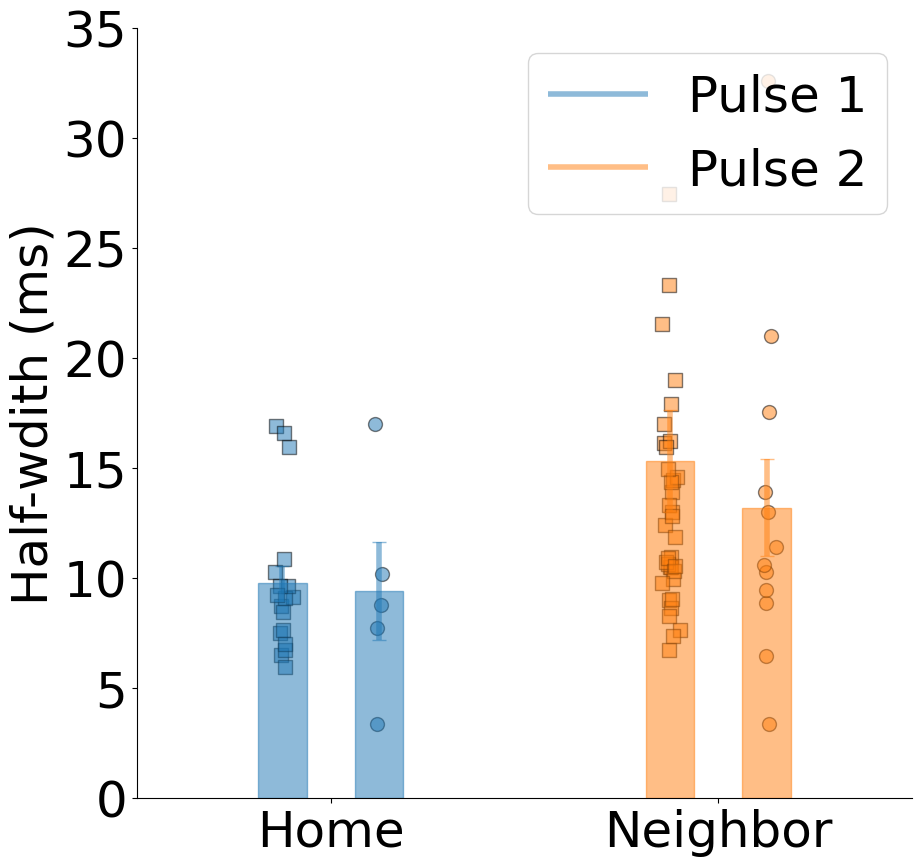

In [ ]:
# plot pulse 1 halfwidth versus pulse 2 halfwidth

# set fontsize
plt.rcParams.update({'font.size': 36})

regime_velocities = {}
for i, row in ladder_regimes_df.iterrows():
    for pulse in [True, False]:
        
        date, slic, loc, rec = row['Date'], row['Slice'], row['Location'], row['Recording']
        # get the corresponding subset in ladder_df, for drug == 'ACSF'
        ladder_row = ladder_df[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Location'] == loc) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['drug'] == 'ACSF') &
                                (ladder_df['Layer'] == 'L4') &
                                (ladder_df['Is_Pulse_2'] == pulse)]

        # exclude if Stim_Distance < 50 um
        ladder_row = ladder_row[ladder_row['Stim_Distance'] > 50]
        
        if ladder_row.empty:
            if pulse:
                print('No data found for pulse 2 ', date, slic, loc, rec)
            continue

        # the range [velocity_regime_start, velocity_regime_end] corresponds to the Dist_from_home_barrel
        # get the instantaneous velocity for this range

        start = row['velocity_regime_start']
        end = row['velocity_regime_end']

        regime_type = row['velocity_regime_type']

        # get the instantaneous velocity for this range
        regime_df = ladder_row[(ladder_row['Dist_from_home_barrel'] >= start) & 
                                (ladder_row['Dist_from_home_barrel'] <= end)]

        #print(regime_df['instantaneous_velocity'])

        if regime_df.empty:
            continue

        if regime_type not in regime_velocities:
            regime_velocities[regime_type] = {}
        if pulse not in regime_velocities[regime_type]:
            regime_velocities[regime_type][pulse] = []
        
        # filter outliers > 700 um/ms and -700 um/ms
        #regime_df = regime_df[(regime_df['instantaneous_velocity'] < 700) & (regime_df['instantaneous_velocity'] > -700)]
        #if regime_type == 'septal':
        #    print(regime_df[['instantaneous_velocity', 'Date', 'Dist_from_home_barrel']])
        avg_vel = np.mean(np.abs(regime_df['halfwidth']))

        # outliers
        if avg_vel > 0:
            regime_velocities[regime_type][pulse].append(avg_vel)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
print(regime_velocities)
for j, pulse_number in enumerate(['Pulse 1', 'Pulse 2']):
    pulse = (pulse_number == 'Pulse 2')

    regimes = []
    for i, regime_type in enumerate(['home', 'neighbor']): #, 'septal']):
        velocities = regime_velocities[regime_type][pulse]
        # boxplot for each regime. transparent box, black outline, no outliers
        # bar plot with error bars. caps on error bars, and color the error bars the same as the bar color
        ax.bar(i + j * 0.25 - 0.125, 
                np.mean(velocities), 
                width=.125,
                color=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'),
                edgecolor=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'), alpha=0.5)
        ax.errorbar(i + j * 0.25 - 0.125,
                    np.mean(velocities), 
                    yerr=sem(velocities), 
                    color=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'), 
                    capsize=5, elinewidth=4, alpha=0.5, label=pulse_number)

        x_jitter = np.random.normal(0, 0.01, len(velocities))
        
        ax.scatter(x_jitter + i + j * 0.25 - 0.125, velocities,
                     alpha=0.5, color=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'),
                     edgecolors='black', s=100, marker=('o' if pulse else 's'))
        regimes.append(regime_type)

# significance testing between pulse 1 and pulse 2
for reg in ['home', 'neighbor']:
    regime1 = regime_velocities[reg][True]
    regime2 = regime_velocities[reg][False]
    t_stat, p_val = ttest_ind(regime1, regime2, equal_var=False)
    pulse = 'Pulse 2' if pulse else 'Pulse 1'
    print(f"t-test {reg} between Pulse 1 and Pulse2 for {pulse}: t = {t_stat}, p = {p_val}")
    
    if p_val < 0.05:
        height = 30
        i_, j_ = 0, 1
        #ax.text((i_ + j_) / 2, height + 2, 'p < 0.05', ha='center')
        #ax.plot([i_, j_], [height, height], color='black')
        
ax.set_xticks(range(len(regimes)))
ax.set_xticklabels(['Home', 'Neighbor'])
ax.set_ylabel('Half-wdith (ms)')

ax.set_xlim(-0.5, 1.5)

# turn off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend: only first 2 handles
handles = [ax.get_children()[0], ax.get_children()[2]]
labels = [ax.get_children()[0].get_label(), ax.get_children()[2].get_label()]
ax.legend(handles=handles, labels=['Pulse 1', 'Pulse 2'], loc='upper right')
ax.set_ylim(0, 35)

plt.savefig('P:/John/crossing-paper/input/ladder_halfwidth_regimes_pulse2.png')
plt.show()


In [ ]:
ladder_df.columns

Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI_Set', 'Date', 'Slice', 'Location',
       'Recording', 'trace', 'drug', 'Layer', 'Coronal/Sagittal', 'IPI',
       'Is_Pulse_2', 'Dist_from_home_barrel', 'resides_in_barrel',
       'instantaneous_velocity', 'ROI file', 'Medial/Lateral'],
      dtype='object')

In [ ]:
import statsmodels.formula.api as smf
# mixed effects model with distance from home barrel as a fixed effect
# and Date, Slice, Location, Recording as random effects
# Dependent variable: halfwidth
# Independent variable: Dist_from_home_barrel

data = ladder_df[(ladder_df['Is_Pulse_2'] == True) &
                    (ladder_df['Layer'] == 'L4') & 
                    (ladder_df['drug'] == 'ACSF') & 
                    (ladder_df['Stim_Distance'] > 200) & 
                    #(ladder_df['Dist_from_home_barrel'] > 0) &
                    (ladder_df['halfwidth'] > 0) 
                    ]
#data.loc['Dist_from_home_barrel'] = np.abs(data['Dist_from_home_barrel']).astype(float)
data['Date_Slice'] = data['Date'] + '_' + data['Slice'].astype(str)
print(len(data))
model = smf.mixedlm('halfwidth ~ Stim_Distance',
                    data=data,
                    groups=data['Date_Slice'])
results = model.fit()

# Print the results
print(results.summary())

2203
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: halfwidth 
No. Observations: 2203    Method:             REML      
No. Groups:       26      Scale:              55.7678   
Min. group size:  9       Log-Likelihood:     -7596.7076
Max. group size:  172     Converged:          Yes       
Mean group size:  84.7                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     18.236    1.194 15.270 0.000 15.895 20.576
Stim_Distance -0.020    0.003 -5.820 0.000 -0.027 -0.013
Group Var     14.214    0.581                           



C:\Users\jjudge3\AppData\Local\Temp\ipykernel_13480\720100097.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date_Slice'] = data['Date'] + '_' + data['Slice'].astype(str)


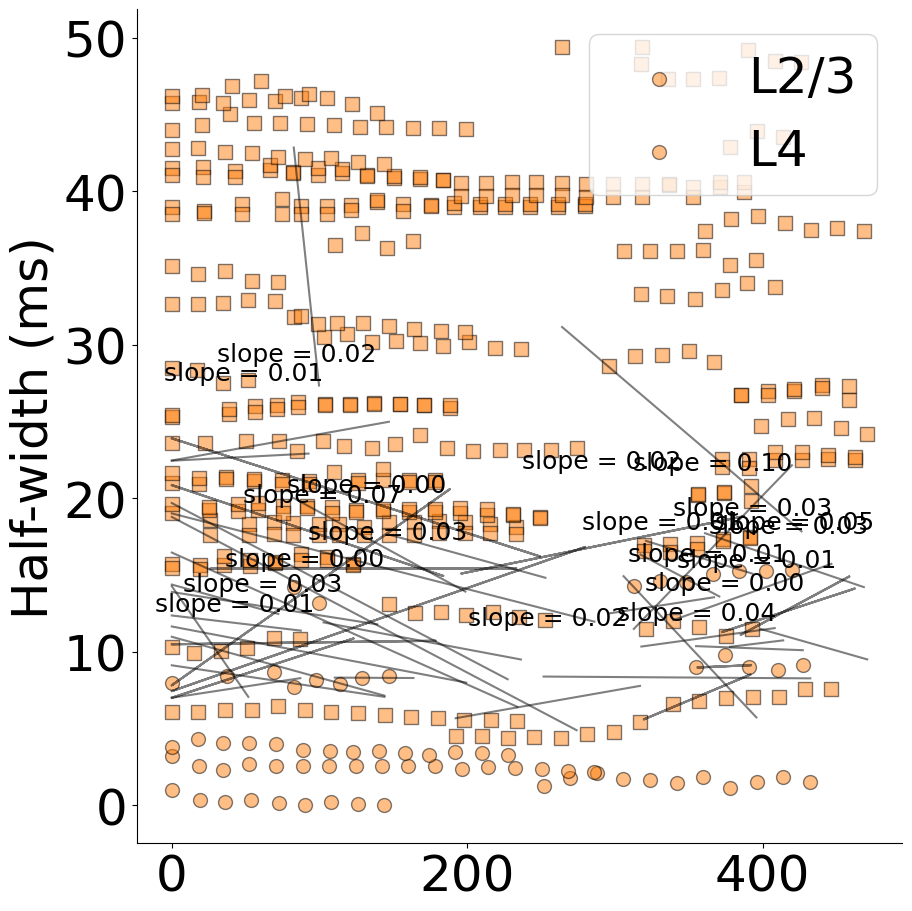

In [ ]:
# using C:\Users\jjudge3\Desktop\Data\crossing_PPR\ladder_velocity_regimes.csv,
# plot halfwidth versus distance from home barrel for neighbor regime
ladder_regimes_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/ladder_velocity_regimes.csv'
ladder_regimes_df = pd.read_csv(ladder_regimes_data)
# ladder regimes has columns: Date, Slice, Location, Recording, velocity_regime_start, velocity_regime_end, velocity_regime_type

# set fontsize
plt.rcParams.update({'font.size': 36})
baseline = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
regime_velocities = {}
for i, row in ladder_regimes_df.iterrows():
    date, slic, loc, rec = row['Date'], row['Slice'], row['Location'], row['Recording']
    # get the corresponding subset in ladder_df, for drug == 'ACSF'
    ladder_row = ladder_df[(ladder_df['Date'] == date) & 
                            (ladder_df['Slice'] == slic) & 
                            (ladder_df['Location'] == loc) & 
                            (ladder_df['Recording'] == rec) & 
                            (ladder_df['drug'] == 'ACSF')]

    # exclude if Stim_Distance < 50 um
    ladder_row = ladder_row[ladder_row['Stim_Distance'] > 100]
    
    if ladder_row.empty:
        continue

    # the range [velocity_regime_start, velocity_regime_end] corresponds to the Dist_from_home_barrel
    # get the instantaneous velocity for this range

    start = row['velocity_regime_start']
    end = row['velocity_regime_end']

    regime_type = row['velocity_regime_type']
    if regime_type != 'neighbor':
        continue

    # get the instantaneous velocity for this range
    regime_df = ladder_row[(ladder_row['Dist_from_home_barrel'] >= start) & 
                            (ladder_row['Dist_from_home_barrel'] <= end)]

    #print(regime_df['instantaneous_velocity'])

    if regime_df.empty:
        continue
    layer = regime_df['Layer'].values[0]
    #print(layer)

    if regime_type not in regime_velocities:
        regime_velocities[regime_type] = {}
    if layer not in regime_velocities[regime_type]:
        regime_velocities[regime_type][layer] = []
    
    regime_df = regime_df[(regime_df['halfwidth'] > 0)]
    #if regime_type == 'septal':
    hw = np.abs(regime_df['halfwidth'])
    dist = np.abs(regime_df['Dist_from_home_barrel'])

    # linear fit to the data
    coeffs = np.polyfit(dist, hw, 1)
    y_fit = np.polyval(coeffs, dist)
    ax.plot(dist, y_fit, color='black', alpha=0.5)

    # label the slope if it is significant
    slope = coeffs[0]
    if slope > 0:
        ax.text(np.mean(dist), np.mean(hw) + 5, f'slope = {slope:.2f}', ha='center', fontsize=18)

    # normalize the halfwidths to 0-1
    hw = (hw - np.min(hw)) / (np.max(hw) - np.min(hw))
    # outliers
    #if avg_vel < 300 and avg_vel > 40:
    regime_velocities[regime_type][layer].append([hw, dist])
    ax.scatter(dist, hw + baseline, alpha=0.5, color=('tab:blue' if regime_type == 'home' else 'tab:orange' if regime_type == 'neighbor' else 'tab:green'),
                edgecolors='black', s=100, marker=('o' if layer == 'L2/3' else 's'), label=layer)
    baseline += 1.1
    


        
#ax.set_xticks(range(len(regimes)))
#ax.set_xticklabels(['Home', 'Neighbor'])
ax.set_ylabel('Half-width (ms)')

#ax.set_ylim(0, 30)

# turn off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend: only first 2 handles
handles = [ax.get_children()[0], ax.get_children()[3]]
ax.legend(handles=handles, labels=['L2/3', 'L4'], loc='upper right')
plt.tight_layout()
plt.savefig('P:/John/crossing-paper/input/ladder_halfwidth_neighbor_regimes.png')


## 